<a href="https://colab.research.google.com/github/ShockLess/microcirculation-solution/blob/main/Pipeline%20Notebooks/Train_LoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка сессии

## Импорты

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown 16OObQ8_WdEWM97BlMOVnlVSorOp1gU3N -O /content/train/
!gdown 12hNXcrHr0v48m9VRr-GLj5eq3pnYU7Im
!N | unzip -q /content/train/train_dataset_mc.zip -d /content/train
!gdown 1dTi50FWqeYUDY27V2ufVe6wB5SEyBgdG

Downloading...
From: https://drive.google.com/uc?id=16OObQ8_WdEWM97BlMOVnlVSorOp1gU3N
To: /content/train/train_dataset_mc.zip
100% 1.99G/1.99G [00:09<00:00, 218MB/s]
Downloading...
From: https://drive.google.com/uc?id=12hNXcrHr0v48m9VRr-GLj5eq3pnYU7Im
To: /content/requirements.txt
100% 225/225 [00:00<00:00, 398kB/s]
/bin/bash: N: command not found
replace /content/train/1.geojson? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
Downloading...
From: https://drive.google.com/uc?id=1dTi50FWqeYUDY27V2ufVe6wB5SEyBgdG
To: /content/dataset.txt
100% 13.6k/13.6k [00:00<00:00, 16.9MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_location = '/content/drive/MyDrive'

In [ ]:
!pip install -r /content/requirements.txt -q

     |████████████████████████████████| 97 kB 5.4 MB/s 
     |████████████████████████████████| 376 kB 61.8 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
     |████████████████████████████████| 1.6 MB 58.5 MB/s 


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
import multiprocessing
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")
import json
from GPUtil import showUtilization as gpu_usage
import GPUtil

# Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

## Класс датасета

In [ ]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, mode: str = "train", transform=None):
        self.class_ids = {"vessel": 1}

        self.mode = mode.lower()

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")
        if self.mode == "train":
            self._mask_files = glob.glob(f"{data_folder}/*.geojson")

        image_file_ids = set([el.split(".")[0] for el in self._image_files])
        if self.mode == "train":
            mask_file_ids = set([el.split(".")[0] for el in self._mask_files])

        if self.mode == "train":
            intersecting_ids = list(image_file_ids.intersection(mask_file_ids))
            self._image_files = [el + ".png" for el in intersecting_ids]
            self._mask_files = [el + ".geojson" for el in intersecting_ids]

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod 
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.float32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]: 
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0) 
    
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)
        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)


    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        if self.mode == "train":
            json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)

        if self.mode == "train":
            mask = self.read_layout(json_path, image.shape[:2])

        if self.mode == "train":
            sample = {'image': image,
                      'mask': mask}
        else:
            sample = {"image": image}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)


## Преобразование

In [ ]:
# Задаем преобразование изображений
size = 1024
train_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}


In [ ]:
# Инициализируем датасет
dataset = EyeDataset("/content/train")

In [ ]:
for j in range(2):
    try:
        for i in range(len(dataset)):
            if glob.glob(dataset._image_files[i].replace("png", "geojson"))==[]:
                dataset._image_files.pop(i)
    except:
        j-=1

In [ ]:
with open('dataset.txt') as f:
    dat_str = f.readlines()
for i in range(len(dat_str)):
  dat_str[i] = dat_str[i].replace('\n','')
dataset._image_files = list(dat_str)

In [ ]:
for msg in dataset.make_report():
  print(msg)

Найдено 596 изображений
Для всех изображений есть файл разметки


## Визуализация

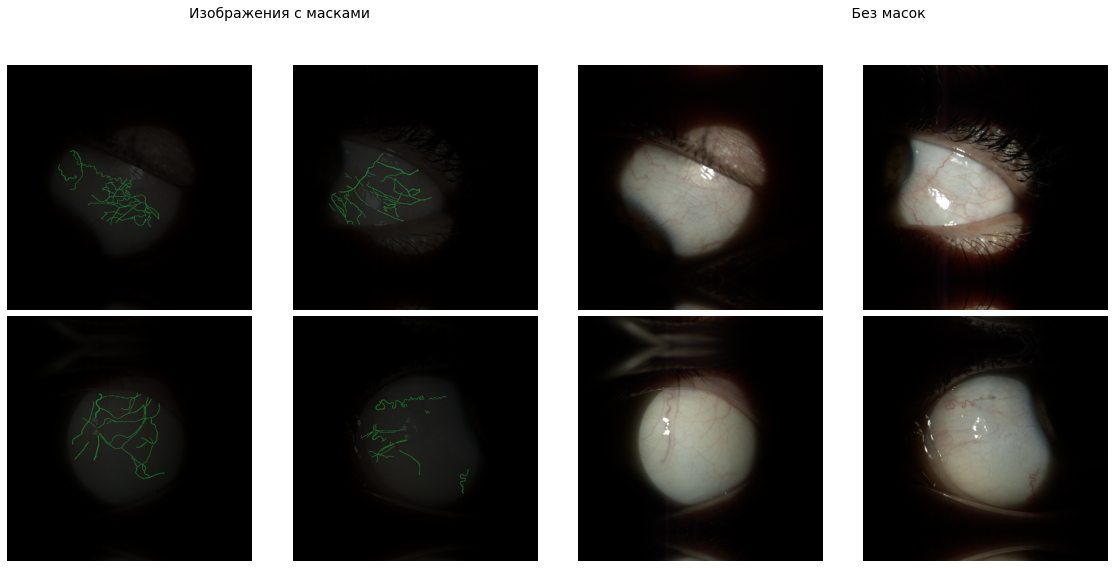

In [ ]:
# Посмотрим на картинки из датасета

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" "*105} Без масок', fontsize=14)

for i, sample in zip(range(4), dataset):
    transformed = transforms['test'](**sample)
    image, mask = transformed["image"], transformed["mask"]

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

## Вспомогательные функции

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

# Класс тренировщика модели

In [ ]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer  
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """
        self.model.train()
    
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):
            self.optimizer.zero_grad()
            try:
                batch = next(train_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()
        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        print(metrics)
        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)
        n_batches = len(train_loader)
        with tqdm(total=n_batches) as pbar:
            while True:
                batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

                if batch_metrics is None:
                    break

                for metric_name in batch_metrics:
                    metrics_sum[metric_name] += batch_metrics[metric_name]

                pbar.update(1)
                num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches
        print('epoch metrics:')
        print(metrics)
        return metrics

    def fit(self, train_loader, num_epochs: int,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
          # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary


# Метрики

In [ ]:
# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-70):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)

# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(predictions)

        return numerator / (denominator + self.epsilon)

def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    accuracy = Accuracy()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_accuracy(pred, target):
        return accuracy(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('dice', exp_dice),
            ('accuracy', exp_accuracy),
            ('recall', exp_recall),
            ]

# Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy
import random

In [ ]:
def density(dataset: list=Any):
    densities=[]
    for i in tqdm(range(len(dataset))):
        mask = dataset[i]['mask'][:,:,1]
        densities.append(mask.sum()/(mask.shape[0] * mask.shape[1]))
    return densities

In [ ]:
!mkdir {drive_location}/Competitions/LeadersOfDigital/models/cv

mkdir: cannot create directory ‘/content/drive/MyDrive/Competitions/LeadersOfDigital/models/cv’: File exists


In [ ]:
def cv(base_model,
       dataset,
       device: str,
       loss_function: Any,
       lr: float = 1e-6,
       eps: float = 1e-8,
       random_state: int = 69,
       shuffle: bool = True,
       n_folds: int = 4,
       epochs: int = 10,
       batch_size: int = 1,
       metric_functions: list = [],
       transform: Dict = None,
       lr_scheduler: Any = None, 
       importances: list = [],
       optimizer: Any = None,
       start_fold: int = 0) -> List[Dict]:
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

    #loss_function.to(device)

    kfold = StratifiedKFold(n_folds, shuffle=shuffle)
    summaries = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, importances)):
        if(fold>=start_fold):
            print(f'FOLD {fold}')
            print('--------------------------------')

            model = deepcopy(base_model)


            trainer = UnetTrainer(
                model=model,
                optimizer=optimizer,
                criterion=loss_function,
                device=device,
                metric_functions=metric_functions,
                lr_scheduler=lr_scheduler
            )

            train_subset = DatasetPart(dataset, indices=train_ids, transform=transform["train"] if transform else None)
            train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,shuffle=True)
            
            test_subset = DatasetPart(dataset, indices=test_ids, transform=transform["test"] if transform else None)
            val_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,shuffle=True)
            
            summary = trainer.fit(train_loader, epochs, val_loader=val_loader)
            torch.save(model, f"{drive_location}/Competitions/LeadersOfDigital/models/cv/model{fold}.pt")
            summaries.append(summary)
        

    return summaries

# Модель

In [ ]:
def make_criterion():
    soft_dice = SoftDice()
    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

In [ ]:
torch.cuda.empty_cache()

In [ ]:
denses=density(dataset)

100%|██████████| 596/596 [03:24<00:00,  2.91it/s]


In [ ]:
values, threshes = np.histogram(denses, bins=15)

In [ ]:
def bining(value):
    for bin, thresh in enumerate(threshes[1:]):
        if value < thresh:
            return bin
    return bin + 1

In [ ]:
binary_denses = list(map(bining, denses))

In [ ]:
!pip install madgrad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import madgrad

In [ ]:
cores = multiprocessing.cpu_count()
batch_size=1
lr_e =  1e-5
lr_d = 1e-3


model = torch.load(f"{drive_location}/Competitions/LeadersOfDigital/models/pretrain/model_pretrain.pt")

#model = smp.Unet(encoder, activation='logsoftmax', classes=2, encoder_weights='imagenet').cuda()

def make_criterion():
    soft_dice = SoftDice()
    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

optimizer = madgrad.MADGRAD(model.parameters(), 1e-5)
criterion = make_criterion()

#cv(model, dataset, 'cuda',loss_function=criterion, batch_size=1, metric_functions=make_metrics(), transform=transforms, importances=binary_denses, optimizer=optimizer, start_fold=0)

# Процесс обучения

In [ ]:
# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25)

In [ ]:
# Разбиваем объект датасета на тренировачный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 1,
                                           num_workers=cores,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 1,
                                           num_workers=cores,
                                   shuffle=True, drop_last=True)

In [ ]:
trainer = UnetTrainer(
                model=model,
                optimizer=optimizer,
                criterion=criterion,
                device='cuda',
                metric_functions=make_metrics(),
            )
summary = trainer.fit(train_loader, 8, val_loader=valid_loader)


!mv /content/model.pt /content/drive/MyDrive/Competitions/LeadersOfDigital/models/model.pt

  0%|          | 1/447 [00:02<17:29,  2.35s/it]

{'loss': 0.5570183992385864, 'dice': 0.4429815709590912, 'accuracy': 0.3127020597457886, 'recall': 0.7593424916267395}



  0%|          | 2/447 [00:03<12:56,  1.75s/it]

{'loss': 0.5163857340812683, 'dice': 0.4836142659187317, 'accuracy': 0.3549759089946747, 'recall': 0.758475124835968}



  1%|          | 3/447 [00:04<11:28,  1.55s/it]

{'loss': 0.6571938991546631, 'dice': 0.3428061008453369, 'accuracy': 0.21957097947597504, 'recall': 0.7813318967819214}



  1%|          | 4/447 [00:06<10:46,  1.46s/it]

{'loss': 0.3938339948654175, 'dice': 0.6061659455299377, 'accuracy': 0.4878195524215698, 'recall': 0.8003275990486145}



  1%|          | 5/447 [00:07<10:23,  1.41s/it]

{'loss': 0.5526310205459595, 'dice': 0.4473689794540405, 'accuracy': 0.31582963466644287, 'recall': 0.7666838765144348}



  1%|▏         | 6/447 [00:08<10:08,  1.38s/it]

{'loss': 0.4915597438812256, 'dice': 0.5084403157234192, 'accuracy': 0.5427978038787842, 'recall': 0.47817325592041016}



  2%|▏         | 7/447 [00:10<10:00,  1.36s/it]

{'loss': 0.7581552863121033, 'dice': 0.24184472858905792, 'accuracy': 0.3519693613052368, 'recall': 0.18420912325382233}



  2%|▏         | 8/447 [00:11<09:54,  1.35s/it]

{'loss': 0.7242562174797058, 'dice': 0.2757437825202942, 'accuracy': 0.4425795078277588, 'recall': 0.20025517046451569}



  2%|▏         | 9/447 [00:12<09:49,  1.35s/it]

{'loss': 0.7534756660461426, 'dice': 0.24652434885501862, 'accuracy': 0.6075484752655029, 'recall': 0.15463528037071228}



  2%|▏         | 10/447 [00:14<09:46,  1.34s/it]

{'loss': 0.7395737171173096, 'dice': 0.2604263126850128, 'accuracy': 0.5527154207229614, 'recall': 0.17034423351287842}



  2%|▏         | 11/447 [00:15<09:44,  1.34s/it]

{'loss': 0.6692754030227661, 'dice': 0.3307246267795563, 'accuracy': 0.23177292943000793, 'recall': 0.5771142840385437}



  3%|▎         | 12/447 [00:16<09:43,  1.34s/it]

{'loss': 0.5124316215515137, 'dice': 0.48756837844848633, 'accuracy': 0.4825589954853058, 'recall': 0.49268290400505066}



  3%|▎         | 13/447 [00:18<09:41,  1.34s/it]

{'loss': 0.5177637338638306, 'dice': 0.48223626613616943, 'accuracy': 0.37331637740135193, 'recall': 0.6808967590332031}



  3%|▎         | 14/447 [00:19<09:49,  1.36s/it]

{'loss': 0.5722102522850037, 'dice': 0.42778974771499634, 'accuracy': 0.31321245431900024, 'recall': 0.6745484471321106}



  3%|▎         | 15/447 [00:21<10:05,  1.40s/it]

{'loss': 0.5659325122833252, 'dice': 0.4340674877166748, 'accuracy': 0.5585224628448486, 'recall': 0.35496985912323}



  4%|▎         | 16/447 [00:22<10:08,  1.41s/it]

{'loss': 0.5160880088806152, 'dice': 0.48391205072402954, 'accuracy': 0.48039549589157104, 'recall': 0.48748040199279785}



  4%|▍         | 17/447 [00:23<09:57,  1.39s/it]

{'loss': 0.3898884654045105, 'dice': 0.6101115942001343, 'accuracy': 0.4990248382091522, 'recall': 0.7848178744316101}



  4%|▍         | 18/447 [00:25<09:51,  1.38s/it]

{'loss': 0.47423529624938965, 'dice': 0.5257647037506104, 'accuracy': 0.5265717506408691, 'recall': 0.5249601006507874}



  4%|▍         | 19/447 [00:26<09:45,  1.37s/it]

{'loss': 0.6467648148536682, 'dice': 0.3532352149486542, 'accuracy': 0.23303817212581635, 'recall': 0.7294971942901611}



  4%|▍         | 20/447 [00:28<09:40,  1.36s/it]

{'loss': 0.47319579124450684, 'dice': 0.5268041491508484, 'accuracy': 0.45512738823890686, 'recall': 0.6252773404121399}



  5%|▍         | 21/447 [00:29<09:39,  1.36s/it]

{'loss': 0.4373047947883606, 'dice': 0.5626952052116394, 'accuracy': 0.6252260804176331, 'recall': 0.5115348696708679}



  5%|▍         | 22/447 [00:30<09:38,  1.36s/it]

{'loss': 0.43940412998199463, 'dice': 0.5605958700180054, 'accuracy': 0.5029953718185425, 'recall': 0.6330944895744324}



  5%|▌         | 23/447 [00:32<09:36,  1.36s/it]

{'loss': 0.5643092393875122, 'dice': 0.4356907904148102, 'accuracy': 0.33515411615371704, 'recall': 0.6223902106285095}



  5%|▌         | 24/447 [00:33<09:34,  1.36s/it]

{'loss': 0.3902224898338318, 'dice': 0.609777569770813, 'accuracy': 0.620721161365509, 'recall': 0.5992130041122437}



  6%|▌         | 25/447 [00:34<09:33,  1.36s/it]

{'loss': 0.4021059274673462, 'dice': 0.5978940725326538, 'accuracy': 0.5810543894767761, 'recall': 0.6157388687133789}



  6%|▌         | 26/447 [00:36<09:35,  1.37s/it]

{'loss': 0.5282502174377441, 'dice': 0.47174981236457825, 'accuracy': 0.5591186881065369, 'recall': 0.40799573063850403}



  6%|▌         | 27/447 [00:37<09:40,  1.38s/it]

{'loss': 0.447969913482666, 'dice': 0.5520301461219788, 'accuracy': 0.7094696760177612, 'recall': 0.45177581906318665}



  6%|▋         | 28/447 [00:39<09:39,  1.38s/it]

{'loss': 0.4781215190887451, 'dice': 0.5218784809112549, 'accuracy': 0.5137540102005005, 'recall': 0.5302640199661255}



  6%|▋         | 29/447 [00:40<09:34,  1.37s/it]

{'loss': 0.32618337869644165, 'dice': 0.6738166809082031, 'accuracy': 0.6430034041404724, 'recall': 0.7077318429946899}



  7%|▋         | 30/447 [00:41<09:31,  1.37s/it]

{'loss': 0.4077865481376648, 'dice': 0.59221351146698, 'accuracy': 0.6517881155014038, 'recall': 0.5426172614097595}



  7%|▋         | 31/447 [00:43<09:28,  1.37s/it]

{'loss': 0.3827595114707947, 'dice': 0.6172404885292053, 'accuracy': 0.6824967265129089, 'recall': 0.5633739829063416}



  7%|▋         | 32/447 [00:44<09:26,  1.36s/it]

{'loss': 0.6150548458099365, 'dice': 0.3849451541900635, 'accuracy': 0.25079914927482605, 'recall': 0.8276156783103943}



  7%|▋         | 33/447 [00:45<09:24,  1.36s/it]

{'loss': 0.44626593589782715, 'dice': 0.5537340641021729, 'accuracy': 0.5310964584350586, 'recall': 0.5783873200416565}



  8%|▊         | 34/447 [00:47<09:22,  1.36s/it]

{'loss': 0.458304762840271, 'dice': 0.541695237159729, 'accuracy': 0.4681817889213562, 'recall': 0.6425948739051819}



  8%|▊         | 35/447 [00:48<09:20,  1.36s/it]

{'loss': 0.9342916011810303, 'dice': 0.06570839881896973, 'accuracy': 0.05358542874455452, 'recall': 0.0849205031991005}



  8%|▊         | 36/447 [00:49<09:18,  1.36s/it]

{'loss': 0.3832014203071594, 'dice': 0.6167985200881958, 'accuracy': 0.5849636197090149, 'recall': 0.6522979140281677}



  8%|▊         | 37/447 [00:51<09:16,  1.36s/it]

{'loss': 0.5125217437744141, 'dice': 0.4874782860279083, 'accuracy': 0.34871962666511536, 'recall': 0.8096423149108887}



  9%|▊         | 38/447 [00:52<09:14,  1.36s/it]

{'loss': 0.40269607305526733, 'dice': 0.5973039269447327, 'accuracy': 0.5725966095924377, 'recall': 0.6242397427558899}



  9%|▊         | 39/447 [00:53<09:12,  1.35s/it]

{'loss': 0.3268789052963257, 'dice': 0.6731211543083191, 'accuracy': 0.612668514251709, 'recall': 0.746809720993042}



  9%|▉         | 40/447 [00:55<09:10,  1.35s/it]

{'loss': 0.4860595464706421, 'dice': 0.5139404535293579, 'accuracy': 0.37473273277282715, 'recall': 0.8177063465118408}



  9%|▉         | 41/447 [00:56<09:08,  1.35s/it]

{'loss': 0.5171926021575928, 'dice': 0.48280736804008484, 'accuracy': 0.6733102202415466, 'recall': 0.3763304352760315}



  9%|▉         | 42/447 [00:57<09:06,  1.35s/it]

{'loss': 0.5458388328552246, 'dice': 0.45416122674942017, 'accuracy': 0.30452364683151245, 'recall': 0.8929322957992554}



 10%|▉         | 43/447 [00:59<09:03,  1.35s/it]

{'loss': 0.42866748571395874, 'dice': 0.5713325142860413, 'accuracy': 0.5283219814300537, 'recall': 0.6219666004180908}



 10%|▉         | 44/447 [01:00<09:01,  1.34s/it]

{'loss': 0.4962783455848694, 'dice': 0.5037216544151306, 'accuracy': 0.750615119934082, 'recall': 0.3790454566478729}



 10%|█         | 45/447 [01:01<09:00,  1.34s/it]

{'loss': 0.4627567529678345, 'dice': 0.5372431874275208, 'accuracy': 0.42821815609931946, 'recall': 0.7207464575767517}



 10%|█         | 46/447 [01:03<09:01,  1.35s/it]

{'loss': 0.4798210859298706, 'dice': 0.5201789140701294, 'accuracy': 0.45105263590812683, 'recall': 0.6143280267715454}



 11%|█         | 47/447 [01:04<08:58,  1.35s/it]

{'loss': 0.8247194886207581, 'dice': 0.17528049647808075, 'accuracy': 0.1223396435379982, 'recall': 0.3089931607246399}



 11%|█         | 48/447 [01:06<08:56,  1.35s/it]

{'loss': 0.482899010181427, 'dice': 0.517100989818573, 'accuracy': 0.6668736934661865, 'recall': 0.42226481437683105}



 11%|█         | 49/447 [01:07<08:55,  1.35s/it]

{'loss': 0.4943616986274719, 'dice': 0.5056383013725281, 'accuracy': 0.4660891592502594, 'recall': 0.5525214672088623}



 11%|█         | 50/447 [01:08<08:54,  1.35s/it]

{'loss': 0.400734007358551, 'dice': 0.5992660522460938, 'accuracy': 0.6263044476509094, 'recall': 0.5744655728340149}



 11%|█▏        | 51/447 [01:10<08:51,  1.34s/it]

{'loss': 0.3725277781486511, 'dice': 0.6274721026420593, 'accuracy': 0.6497918367385864, 'recall': 0.6066348552703857}



 12%|█▏        | 52/447 [01:11<08:50,  1.34s/it]

{'loss': 0.4661361575126648, 'dice': 0.5338638424873352, 'accuracy': 0.5931733846664429, 'recall': 0.4853365421295166}



 12%|█▏        | 53/447 [01:12<08:52,  1.35s/it]

{'loss': 0.49317842721939087, 'dice': 0.5068215131759644, 'accuracy': 0.43895184993743896, 'recall': 0.5995175838470459}



 12%|█▏        | 54/447 [01:14<08:49,  1.35s/it]

{'loss': 0.9164965748786926, 'dice': 0.08350344002246857, 'accuracy': 0.06060387194156647, 'recall': 0.1342189610004425}



 12%|█▏        | 55/447 [01:15<08:47,  1.35s/it]

{'loss': 0.34747588634490967, 'dice': 0.6525239944458008, 'accuracy': 0.6256445646286011, 'recall': 0.681816816329956}



 13%|█▎        | 56/447 [01:16<08:45,  1.34s/it]

{'loss': 0.5944536924362183, 'dice': 0.4055463373661041, 'accuracy': 0.2570314109325409, 'recall': 0.9605737328529358}



 13%|█▎        | 57/447 [01:18<08:43,  1.34s/it]

{'loss': 0.34557920694351196, 'dice': 0.6544206738471985, 'accuracy': 0.657658040523529, 'recall': 0.6512150168418884}



 13%|█▎        | 58/447 [01:19<08:41,  1.34s/it]

{'loss': 0.4739696979522705, 'dice': 0.5260303020477295, 'accuracy': 0.37240323424339294, 'recall': 0.8954147100448608}



 13%|█▎        | 59/447 [01:20<08:40,  1.34s/it]

{'loss': 0.3511595129966736, 'dice': 0.6488405466079712, 'accuracy': 0.6341281533241272, 'recall': 0.6642516851425171}



 13%|█▎        | 60/447 [01:22<08:39,  1.34s/it]

{'loss': 0.42623627185821533, 'dice': 0.5737636685371399, 'accuracy': 0.42792803049087524, 'recall': 0.8703870177268982}



 14%|█▎        | 61/447 [01:23<08:36,  1.34s/it]

{'loss': 0.500386118888855, 'dice': 0.4996139407157898, 'accuracy': 0.5728883743286133, 'recall': 0.4429580569267273}



 14%|█▍        | 62/447 [01:24<08:35,  1.34s/it]

{'loss': 0.9319353103637695, 'dice': 0.06806467473506927, 'accuracy': 0.08934907615184784, 'recall': 0.05496994033455849}



 14%|█▍        | 63/447 [01:26<08:35,  1.34s/it]

{'loss': 0.5199095606803894, 'dice': 0.4800904095172882, 'accuracy': 0.3255077302455902, 'recall': 0.9142784476280212}



 14%|█▍        | 64/447 [01:27<08:34,  1.34s/it]

{'loss': 0.6068882942199707, 'dice': 0.3931117057800293, 'accuracy': 0.2867806553840637, 'recall': 0.6247552037239075}



 15%|█▍        | 65/447 [01:28<08:32,  1.34s/it]

{'loss': 0.5871555805206299, 'dice': 0.4128444790840149, 'accuracy': 0.6442297697067261, 'recall': 0.30374839901924133}



 15%|█▍        | 66/447 [01:30<08:30,  1.34s/it]

{'loss': 0.5181519985198975, 'dice': 0.48184800148010254, 'accuracy': 0.6217120289802551, 'recall': 0.3933562636375427}



 15%|█▍        | 67/447 [01:31<08:29,  1.34s/it]

{'loss': 0.5290222764015198, 'dice': 0.4709777235984802, 'accuracy': 0.7503747940063477, 'recall': 0.34319236874580383}



 15%|█▌        | 68/447 [01:32<08:27,  1.34s/it]

{'loss': 0.4922633767127991, 'dice': 0.5077366232872009, 'accuracy': 0.7264713644981384, 'recall': 0.39023882150650024}



 15%|█▌        | 69/447 [01:34<08:26,  1.34s/it]

{'loss': 0.45487284660339355, 'dice': 0.5451270937919617, 'accuracy': 0.6371778845787048, 'recall': 0.47631555795669556}



 16%|█▌        | 70/447 [01:35<08:25,  1.34s/it]

{'loss': 0.5237753391265869, 'dice': 0.4762246608734131, 'accuracy': 0.366306334733963, 'recall': 0.680391252040863}



 16%|█▌        | 71/447 [01:36<08:24,  1.34s/it]

{'loss': 0.4767270088195801, 'dice': 0.5232729911804199, 'accuracy': 0.429616242647171, 'recall': 0.6691478490829468}



 16%|█▌        | 72/447 [01:38<08:24,  1.35s/it]

{'loss': 0.5028271079063416, 'dice': 0.49717283248901367, 'accuracy': 0.44743138551712036, 'recall': 0.559357225894928}



 16%|█▋        | 73/447 [01:39<08:25,  1.35s/it]

{'loss': 0.7082905173301697, 'dice': 0.29170945286750793, 'accuracy': 0.176066055893898, 'recall': 0.8500145077705383}



 17%|█▋        | 74/447 [01:41<08:27,  1.36s/it]

{'loss': 0.47172850370407104, 'dice': 0.5282715559005737, 'accuracy': 0.39673173427581787, 'recall': 0.7903034687042236}



 17%|█▋        | 75/447 [01:42<08:26,  1.36s/it]

{'loss': 0.508723258972168, 'dice': 0.49127665162086487, 'accuracy': 0.4402350187301636, 'recall': 0.5557063221931458}



 17%|█▋        | 76/447 [01:43<08:22,  1.35s/it]

{'loss': 0.36341118812561035, 'dice': 0.6365888714790344, 'accuracy': 0.6020419001579285, 'recall': 0.6753419041633606}



 17%|█▋        | 77/447 [01:45<08:19,  1.35s/it]

{'loss': 0.497383177280426, 'dice': 0.5026167631149292, 'accuracy': 0.586808979511261, 'recall': 0.4395521879196167}



 17%|█▋        | 78/447 [01:46<08:17,  1.35s/it]

{'loss': 0.4816235899925232, 'dice': 0.5183764100074768, 'accuracy': 0.4937405586242676, 'recall': 0.5455998778343201}



 18%|█▊        | 79/447 [01:47<08:16,  1.35s/it]

{'loss': 0.5723132491111755, 'dice': 0.42768678069114685, 'accuracy': 0.3730410635471344, 'recall': 0.5010899901390076}



 18%|█▊        | 80/447 [01:49<08:14,  1.35s/it]

{'loss': 0.4098290801048279, 'dice': 0.5901710391044617, 'accuracy': 0.45330357551574707, 'recall': 0.8454363942146301}



 18%|█▊        | 81/447 [01:50<08:13,  1.35s/it]

{'loss': 0.6215530633926392, 'dice': 0.3784469664096832, 'accuracy': 0.25552859902381897, 'recall': 0.7292349338531494}



 18%|█▊        | 82/447 [01:51<08:11,  1.35s/it]

{'loss': 0.626426637172699, 'dice': 0.373573362827301, 'accuracy': 0.48580411076545715, 'recall': 0.3034663796424866}



 19%|█▊        | 83/447 [01:53<08:11,  1.35s/it]

{'loss': 0.49774718284606934, 'dice': 0.5022528171539307, 'accuracy': 0.41313472390174866, 'recall': 0.640393078327179}



 19%|█▉        | 84/447 [01:54<08:09,  1.35s/it]

{'loss': 0.4315260648727417, 'dice': 0.5684739947319031, 'accuracy': 0.5865201950073242, 'recall': 0.5515050292015076}



 19%|█▉        | 85/447 [01:55<08:07,  1.35s/it]

{'loss': 0.7224003076553345, 'dice': 0.2775996923446655, 'accuracy': 0.8571681976318359, 'recall': 0.16561809182167053}



 19%|█▉        | 86/447 [01:57<08:05,  1.35s/it]

{'loss': 0.48224902153015137, 'dice': 0.5177509188652039, 'accuracy': 0.6881351470947266, 'recall': 0.4149966537952423}



 19%|█▉        | 87/447 [01:58<08:10,  1.36s/it]

{'loss': 0.4477248787879944, 'dice': 0.5522751212120056, 'accuracy': 0.5499371886253357, 'recall': 0.5546329617500305}



 20%|█▉        | 88/447 [01:59<08:07,  1.36s/it]

{'loss': 0.4585556387901306, 'dice': 0.5414443612098694, 'accuracy': 0.6967612504959106, 'recall': 0.4427497684955597}



 20%|█▉        | 89/447 [02:01<08:04,  1.35s/it]

{'loss': 0.5187748670578003, 'dice': 0.4812251627445221, 'accuracy': 0.4557056128978729, 'recall': 0.5097724199295044}



 20%|██        | 90/447 [02:02<08:03,  1.35s/it]

{'loss': 0.44164520502090454, 'dice': 0.5583547949790955, 'accuracy': 0.511141836643219, 'recall': 0.6151772141456604}



 20%|██        | 91/447 [02:03<08:00,  1.35s/it]

{'loss': 0.5009986162185669, 'dice': 0.4990014135837555, 'accuracy': 0.5694891214370728, 'recall': 0.4440408945083618}



 21%|██        | 92/447 [02:05<07:58,  1.35s/it]

{'loss': 0.5785614252090454, 'dice': 0.421438604593277, 'accuracy': 0.46271559596061707, 'recall': 0.3869227468967438}



 21%|██        | 93/447 [02:06<07:57,  1.35s/it]

{'loss': 0.3394814729690552, 'dice': 0.6605185270309448, 'accuracy': 0.5269335508346558, 'recall': 0.8848370313644409}



 21%|██        | 94/447 [02:07<07:56,  1.35s/it]

{'loss': 0.5853067636489868, 'dice': 0.41469326615333557, 'accuracy': 0.3137582838535309, 'recall': 0.6113684773445129}



 21%|██▏       | 95/447 [02:09<07:55,  1.35s/it]

{'loss': 0.32011258602142334, 'dice': 0.6798874735832214, 'accuracy': 0.710649311542511, 'recall': 0.651678204536438}



 21%|██▏       | 96/447 [02:10<07:53,  1.35s/it]

{'loss': 0.3951820731163025, 'dice': 0.604817807674408, 'accuracy': 0.6329734325408936, 'recall': 0.5790603756904602}



 22%|██▏       | 97/447 [02:12<07:53,  1.35s/it]

{'loss': 0.4180002212524414, 'dice': 0.581999659538269, 'accuracy': 0.48295679688453674, 'recall': 0.7321451306343079}



 22%|██▏       | 98/447 [02:13<07:51,  1.35s/it]

{'loss': 0.6835986375808716, 'dice': 0.31640133261680603, 'accuracy': 0.18978926539421082, 'recall': 0.9504945278167725}



 22%|██▏       | 99/447 [02:14<07:49,  1.35s/it]

{'loss': 0.4858361482620239, 'dice': 0.5141638517379761, 'accuracy': 0.36625486612319946, 'recall': 0.8624616861343384}



 22%|██▏       | 100/447 [02:16<07:48,  1.35s/it]

{'loss': 0.2745788097381592, 'dice': 0.7254213094711304, 'accuracy': 0.587104320526123, 'recall': 0.9489971995353699}



 23%|██▎       | 101/447 [02:17<07:47,  1.35s/it]

{'loss': 0.5072005987167358, 'dice': 0.49279946088790894, 'accuracy': 0.7218029499053955, 'recall': 0.37410780787467957}



 23%|██▎       | 102/447 [02:18<07:44,  1.35s/it]

{'loss': 0.38961857557296753, 'dice': 0.6103814840316772, 'accuracy': 0.7173541188240051, 'recall': 0.5311724543571472}



 23%|██▎       | 103/447 [02:20<07:42,  1.35s/it]

{'loss': 0.5262105464935303, 'dice': 0.47378939390182495, 'accuracy': 0.8244034647941589, 'recall': 0.3324151039123535}



 23%|██▎       | 104/447 [02:21<07:42,  1.35s/it]

{'loss': 0.4065415859222412, 'dice': 0.593458354473114, 'accuracy': 0.4986099600791931, 'recall': 0.7328686714172363}



 23%|██▎       | 105/447 [02:22<07:40,  1.35s/it]

{'loss': 0.4488763213157654, 'dice': 0.5511237382888794, 'accuracy': 0.699478268623352, 'recall': 0.45468762516975403}



 24%|██▎       | 106/447 [02:24<07:39,  1.35s/it]

{'loss': 0.4787778854370117, 'dice': 0.5212221145629883, 'accuracy': 0.7135271430015564, 'recall': 0.4105684161186218}



 24%|██▍       | 107/447 [02:25<07:38,  1.35s/it]

{'loss': 0.47908711433410645, 'dice': 0.5209129452705383, 'accuracy': 0.5439380407333374, 'recall': 0.49975788593292236}



 24%|██▍       | 108/447 [02:26<07:35,  1.34s/it]

{'loss': 0.4810183048248291, 'dice': 0.5189817547798157, 'accuracy': 0.7278069257736206, 'recall': 0.4032730460166931}



 24%|██▍       | 109/447 [02:28<07:34,  1.34s/it]

{'loss': 0.5287303924560547, 'dice': 0.4712696373462677, 'accuracy': 0.4241516590118408, 'recall': 0.5301642417907715}



 25%|██▍       | 110/447 [02:29<07:33,  1.35s/it]

{'loss': 0.3326520323753357, 'dice': 0.6673480272293091, 'accuracy': 0.6548458933830261, 'recall': 0.6803367733955383}



 25%|██▍       | 111/447 [02:30<07:33,  1.35s/it]

{'loss': 0.3630155324935913, 'dice': 0.6369845867156982, 'accuracy': 0.512013852596283, 'recall': 0.8426576852798462}



 25%|██▌       | 112/447 [02:32<07:31,  1.35s/it]

{'loss': 0.36865270137786865, 'dice': 0.6313472390174866, 'accuracy': 0.4942735731601715, 'recall': 0.8736236095428467}



 25%|██▌       | 113/447 [02:33<07:29,  1.35s/it]

{'loss': 0.6076086759567261, 'dice': 0.39239123463630676, 'accuracy': 0.4842829406261444, 'recall': 0.3298104405403137}



 26%|██▌       | 114/447 [02:34<07:27,  1.34s/it]

{'loss': 0.3559855818748474, 'dice': 0.6440144777297974, 'accuracy': 0.6433002352714539, 'recall': 0.6447304487228394}



 26%|██▌       | 115/447 [02:36<07:25,  1.34s/it]

{'loss': 0.38566887378692627, 'dice': 0.6143311262130737, 'accuracy': 0.7163575291633606, 'recall': 0.5377436280250549}



 26%|██▌       | 116/447 [02:37<07:24,  1.34s/it]

{'loss': 0.4658409357070923, 'dice': 0.5341590642929077, 'accuracy': 0.7678607106208801, 'recall': 0.40951991081237793}



 26%|██▌       | 117/447 [02:38<07:22,  1.34s/it]

{'loss': 0.45618605613708496, 'dice': 0.543813943862915, 'accuracy': 0.45466214418411255, 'recall': 0.6764559149742126}



 26%|██▋       | 118/447 [02:40<07:21,  1.34s/it]

{'loss': 0.38033366203308105, 'dice': 0.619666337966919, 'accuracy': 0.5569577813148499, 'recall': 0.6982874274253845}



 27%|██▋       | 119/447 [02:41<07:20,  1.34s/it]

{'loss': 0.8345450162887573, 'dice': 0.16545501351356506, 'accuracy': 0.09833018481731415, 'recall': 0.5213598608970642}



 27%|██▋       | 120/447 [02:42<07:18,  1.34s/it]

{'loss': 0.45942825078964233, 'dice': 0.5405718088150024, 'accuracy': 0.7113755941390991, 'recall': 0.43590858578681946}



 27%|██▋       | 121/447 [02:44<07:17,  1.34s/it]

{'loss': 0.45128488540649414, 'dice': 0.5487151145935059, 'accuracy': 0.4794675409793854, 'recall': 0.6413415670394897}



 27%|██▋       | 122/447 [02:45<07:16,  1.34s/it]

{'loss': 0.42192167043685913, 'dice': 0.5780782103538513, 'accuracy': 0.4876038134098053, 'recall': 0.7097766995429993}



 28%|██▊       | 123/447 [02:47<07:15,  1.34s/it]

{'loss': 0.27951908111572266, 'dice': 0.7204809784889221, 'accuracy': 0.7191530466079712, 'recall': 0.7218136787414551}



 28%|██▊       | 124/447 [02:48<07:13,  1.34s/it]

{'loss': 0.48757410049438477, 'dice': 0.5124258995056152, 'accuracy': 0.40708890557289124, 'recall': 0.6913060545921326}



 28%|██▊       | 125/447 [02:49<07:12,  1.34s/it]

{'loss': 0.4475722312927246, 'dice': 0.5524277091026306, 'accuracy': 0.4059501886367798, 'recall': 0.8642842173576355}



 28%|██▊       | 126/447 [02:51<07:10,  1.34s/it]

{'loss': 0.46472233533859253, 'dice': 0.5352776050567627, 'accuracy': 0.40233367681503296, 'recall': 0.7994374632835388}



 28%|██▊       | 127/447 [02:52<07:09,  1.34s/it]

{'loss': 0.5237723588943481, 'dice': 0.47622767090797424, 'accuracy': 0.5571780800819397, 'recall': 0.4158153831958771}



 29%|██▊       | 128/447 [02:53<07:09,  1.35s/it]

{'loss': 0.3865584135055542, 'dice': 0.6134414672851562, 'accuracy': 0.5502774715423584, 'recall': 0.6929865479469299}



 29%|██▉       | 129/447 [02:55<07:08,  1.35s/it]

{'loss': 0.480354905128479, 'dice': 0.519645094871521, 'accuracy': 0.45017707347869873, 'recall': 0.6144647598266602}



 29%|██▉       | 130/447 [02:56<07:06,  1.35s/it]

{'loss': 0.5079066753387451, 'dice': 0.4920933246612549, 'accuracy': 0.7598532438278198, 'recall': 0.3638710677623749}



 29%|██▉       | 131/447 [02:57<07:04,  1.34s/it]

{'loss': 0.6778154373168945, 'dice': 0.32218456268310547, 'accuracy': 0.5355015397071838, 'recall': 0.23040339350700378}



 30%|██▉       | 132/447 [02:59<07:03,  1.34s/it]

{'loss': 0.5932343602180481, 'dice': 0.4067656397819519, 'accuracy': 0.6911842226982117, 'recall': 0.28818079829216003}



 30%|██▉       | 133/447 [03:00<07:02,  1.35s/it]

{'loss': 0.4582397937774658, 'dice': 0.5417602062225342, 'accuracy': 0.5948623418807983, 'recall': 0.4973617196083069}



 30%|██▉       | 134/447 [03:01<07:00,  1.34s/it]

{'loss': 0.4114777445793152, 'dice': 0.5885222554206848, 'accuracy': 0.4889370799064636, 'recall': 0.7390496730804443}



 30%|███       | 135/447 [03:03<06:59,  1.34s/it]

{'loss': 0.47371089458465576, 'dice': 0.5262891054153442, 'accuracy': 0.507106363773346, 'recall': 0.546980082988739}



 30%|███       | 136/447 [03:04<06:59,  1.35s/it]

{'loss': 0.44570356607437134, 'dice': 0.5542964935302734, 'accuracy': 0.5839512348175049, 'recall': 0.5275080800056458}



 31%|███       | 137/447 [03:05<06:57,  1.35s/it]

{'loss': 0.4609469175338745, 'dice': 0.5390530824661255, 'accuracy': 0.40746259689331055, 'recall': 0.7961803078651428}



 31%|███       | 138/447 [03:07<06:56,  1.35s/it]

{'loss': 0.44091641902923584, 'dice': 0.5590836405754089, 'accuracy': 0.6623972654342651, 'recall': 0.4836491346359253}



 31%|███       | 139/447 [03:08<06:54,  1.35s/it]

{'loss': 0.5640417337417603, 'dice': 0.43595820665359497, 'accuracy': 0.39122575521469116, 'recall': 0.49224066734313965}



 31%|███▏      | 140/447 [03:09<06:53,  1.35s/it]

{'loss': 0.39304834604263306, 'dice': 0.6069517135620117, 'accuracy': 0.6269115805625916, 'recall': 0.5882236361503601}



 32%|███▏      | 141/447 [03:11<06:52,  1.35s/it]

{'loss': 0.42915570735931396, 'dice': 0.570844292640686, 'accuracy': 0.7483999133110046, 'recall': 0.461382657289505}



 32%|███▏      | 142/447 [03:12<06:51,  1.35s/it]

{'loss': 0.4523778557777405, 'dice': 0.5476222038269043, 'accuracy': 0.4677393138408661, 'recall': 0.6604104042053223}



 32%|███▏      | 143/447 [03:13<06:50,  1.35s/it]

{'loss': 0.4585384726524353, 'dice': 0.5414615273475647, 'accuracy': 0.47724711894989014, 'recall': 0.6256428956985474}



 32%|███▏      | 144/447 [03:15<06:47,  1.35s/it]

{'loss': 0.502035915851593, 'dice': 0.497964084148407, 'accuracy': 0.4189831614494324, 'recall': 0.613638699054718}



 32%|███▏      | 145/447 [03:16<06:46,  1.35s/it]

{'loss': 0.5256088972091675, 'dice': 0.4743911921977997, 'accuracy': 0.3884662985801697, 'recall': 0.6091232299804688}



 33%|███▎      | 146/447 [03:17<06:44,  1.34s/it]

{'loss': 0.5364251136779785, 'dice': 0.4635748863220215, 'accuracy': 0.35874220728874207, 'recall': 0.654973030090332}



 33%|███▎      | 147/447 [03:19<06:43,  1.34s/it]

{'loss': 0.3855575919151306, 'dice': 0.6144422888755798, 'accuracy': 0.5356817245483398, 'recall': 0.7203551530838013}



 33%|███▎      | 148/447 [03:20<06:41,  1.34s/it]

{'loss': 0.4032427668571472, 'dice': 0.5967571139335632, 'accuracy': 0.462975412607193, 'recall': 0.8392746448516846}



 33%|███▎      | 149/447 [03:21<06:40,  1.34s/it]

{'loss': 0.47697895765304565, 'dice': 0.5230211019515991, 'accuracy': 0.7839876413345337, 'recall': 0.39240193367004395}



 34%|███▎      | 150/447 [03:23<06:38,  1.34s/it]

{'loss': 0.39255958795547485, 'dice': 0.6074403524398804, 'accuracy': 0.708357036113739, 'recall': 0.531692385673523}



 34%|███▍      | 151/447 [03:24<06:37,  1.34s/it]

{'loss': 0.29240602254867554, 'dice': 0.7075939178466797, 'accuracy': 0.8066413998603821, 'recall': 0.6302104592323303}



 34%|███▍      | 152/447 [03:26<06:36,  1.34s/it]

{'loss': 0.4537140130996704, 'dice': 0.5462860465049744, 'accuracy': 0.5006434917449951, 'recall': 0.6010857224464417}



 34%|███▍      | 153/447 [03:27<06:34,  1.34s/it]

{'loss': 0.5502949357032776, 'dice': 0.4497050642967224, 'accuracy': 0.5247142910957336, 'recall': 0.39345911145210266}



 34%|███▍      | 154/447 [03:28<06:33,  1.34s/it]

{'loss': 0.6316802501678467, 'dice': 0.36831972002983093, 'accuracy': 0.23483707010746002, 'recall': 0.8533926010131836}



 35%|███▍      | 155/447 [03:30<06:31,  1.34s/it]

{'loss': 0.4241769313812256, 'dice': 0.5758229494094849, 'accuracy': 0.6644631624221802, 'recall': 0.5080487132072449}



 35%|███▍      | 156/447 [03:31<06:30,  1.34s/it]

{'loss': 0.6987237334251404, 'dice': 0.3012762665748596, 'accuracy': 0.24011124670505524, 'recall': 0.40425431728363037}



 35%|███▌      | 157/447 [03:32<06:28,  1.34s/it]

{'loss': 0.3192451596260071, 'dice': 0.6807548999786377, 'accuracy': 0.5773967504501343, 'recall': 0.8291848301887512}



 35%|███▌      | 158/447 [03:34<06:27,  1.34s/it]

{'loss': 0.35335177183151245, 'dice': 0.6466482877731323, 'accuracy': 0.8191962838172913, 'recall': 0.5341415405273438}



 36%|███▌      | 159/447 [03:35<06:29,  1.35s/it]

{'loss': 0.48549771308898926, 'dice': 0.514502227306366, 'accuracy': 0.3677724599838257, 'recall': 0.8560330271720886}



 36%|███▌      | 160/447 [03:36<06:29,  1.36s/it]

{'loss': 0.5441405177116394, 'dice': 0.4558594822883606, 'accuracy': 0.9048510193824768, 'recall': 0.3046771287918091}



 36%|███▌      | 161/447 [03:38<06:27,  1.36s/it]

{'loss': 0.4703391194343567, 'dice': 0.5296608209609985, 'accuracy': 0.4262813627719879, 'recall': 0.699235737323761}



 36%|███▌      | 162/447 [03:39<06:25,  1.35s/it]

{'loss': 0.3760901093482971, 'dice': 0.6239099502563477, 'accuracy': 0.5605441927909851, 'recall': 0.7034276127815247}



 36%|███▋      | 163/447 [03:40<06:23,  1.35s/it]

{'loss': 0.5572947859764099, 'dice': 0.4427052140235901, 'accuracy': 0.779431939125061, 'recall': 0.30914828181266785}



 37%|███▋      | 164/447 [03:42<06:22,  1.35s/it]

{'loss': 0.39790475368499756, 'dice': 0.6020952463150024, 'accuracy': 0.7882175445556641, 'recall': 0.4870806038379669}



 37%|███▋      | 165/447 [03:43<06:20,  1.35s/it]

{'loss': 0.43488210439682007, 'dice': 0.5651177763938904, 'accuracy': 0.45432883501052856, 'recall': 0.7473639845848083}



 37%|███▋      | 166/447 [03:44<06:19,  1.35s/it]

{'loss': 0.44092655181884766, 'dice': 0.5590734481811523, 'accuracy': 0.658577561378479, 'recall': 0.48569077253341675}



 37%|███▋      | 167/447 [03:46<06:17,  1.35s/it]

{'loss': 0.5673723816871643, 'dice': 0.4326276183128357, 'accuracy': 0.6821785569190979, 'recall': 0.3167542517185211}



 38%|███▊      | 168/447 [03:47<06:16,  1.35s/it]

{'loss': 0.4751884937286377, 'dice': 0.5248116254806519, 'accuracy': 0.6173883080482483, 'recall': 0.45637810230255127}



 38%|███▊      | 169/447 [03:48<06:15,  1.35s/it]

{'loss': 0.6327648162841797, 'dice': 0.3672351837158203, 'accuracy': 0.383656769990921, 'recall': 0.3521616756916046}



 38%|███▊      | 170/447 [03:50<06:20,  1.37s/it]

{'loss': 0.46745818853378296, 'dice': 0.5325419306755066, 'accuracy': 0.4024369716644287, 'recall': 0.786960244178772}



 38%|███▊      | 171/447 [03:51<06:32,  1.42s/it]

{'loss': 0.6527653932571411, 'dice': 0.3472346365451813, 'accuracy': 0.21619422733783722, 'recall': 0.8815829753875732}



 38%|███▊      | 172/447 [03:53<06:27,  1.41s/it]

{'loss': 0.38080865144729614, 'dice': 0.6191913485527039, 'accuracy': 0.697417676448822, 'recall': 0.556743860244751}



 39%|███▊      | 173/447 [03:54<06:21,  1.39s/it]

{'loss': 0.5480532646179199, 'dice': 0.4519467353820801, 'accuracy': 0.35248324275016785, 'recall': 0.6296095252037048}



 39%|███▉      | 174/447 [03:56<06:16,  1.38s/it]

{'loss': 0.4933643937110901, 'dice': 0.5066356062889099, 'accuracy': 0.5469842553138733, 'recall': 0.47183069586753845}



 39%|███▉      | 175/447 [03:57<06:13,  1.37s/it]

{'loss': 0.363179087638855, 'dice': 0.6368209719657898, 'accuracy': 0.6972223520278931, 'recall': 0.5860505104064941}



 39%|███▉      | 176/447 [03:58<06:10,  1.37s/it]

{'loss': 0.4082249402999878, 'dice': 0.5917750597000122, 'accuracy': 0.5428171157836914, 'recall': 0.6504397392272949}



 40%|███▉      | 177/447 [04:00<06:07,  1.36s/it]

{'loss': 0.4424246549606323, 'dice': 0.5575754046440125, 'accuracy': 0.5541905760765076, 'recall': 0.561001718044281}



 40%|███▉      | 178/447 [04:01<06:04,  1.36s/it]

{'loss': 0.3819030523300171, 'dice': 0.6180970072746277, 'accuracy': 0.6255106925964355, 'recall': 0.6108570694923401}



 40%|████      | 179/447 [04:02<06:02,  1.35s/it]

{'loss': 0.5650655031204224, 'dice': 0.43493449687957764, 'accuracy': 0.2920783460140228, 'recall': 0.8513143062591553}



 40%|████      | 180/447 [04:04<06:02,  1.36s/it]

{'loss': 0.37731224298477173, 'dice': 0.6226877570152283, 'accuracy': 0.5177702307701111, 'recall': 0.7809300422668457}



 40%|████      | 181/447 [04:05<06:01,  1.36s/it]

{'loss': 0.3736330270767212, 'dice': 0.626366913318634, 'accuracy': 0.6028206944465637, 'recall': 0.6518273949623108}



 41%|████      | 182/447 [04:06<05:58,  1.35s/it]

{'loss': 0.4740734100341797, 'dice': 0.5259265303611755, 'accuracy': 0.4648781716823578, 'recall': 0.6054327487945557}



 41%|████      | 183/447 [04:08<05:57,  1.35s/it]

{'loss': 0.5531467199325562, 'dice': 0.44685328006744385, 'accuracy': 0.2952554523944855, 'recall': 0.9184048175811768}



 41%|████      | 184/447 [04:09<05:55,  1.35s/it]

{'loss': 0.4765768051147461, 'dice': 0.5234231948852539, 'accuracy': 0.7622026801109314, 'recall': 0.39856308698654175}



 41%|████▏     | 185/447 [04:10<05:54,  1.35s/it]

{'loss': 0.4891485571861267, 'dice': 0.5108513832092285, 'accuracy': 0.48181530833244324, 'recall': 0.5436115264892578}



 42%|████▏     | 186/447 [04:12<05:53,  1.35s/it]

{'loss': 0.6704018115997314, 'dice': 0.32959818840026855, 'accuracy': 0.2830786108970642, 'recall': 0.3944139778614044}



 42%|████▏     | 187/447 [04:13<05:50,  1.35s/it]

{'loss': 0.4658128619194031, 'dice': 0.5341870784759521, 'accuracy': 0.6678942441940308, 'recall': 0.44508469104766846}



 42%|████▏     | 188/447 [04:14<05:48,  1.35s/it]

{'loss': 0.44494307041168213, 'dice': 0.5550569295883179, 'accuracy': 0.48389485478401184, 'recall': 0.6507581472396851}



 42%|████▏     | 189/447 [04:16<05:46,  1.34s/it]

{'loss': 0.5822069644927979, 'dice': 0.4177929759025574, 'accuracy': 0.3642483353614807, 'recall': 0.48979273438453674}



 43%|████▎     | 190/447 [04:17<05:45,  1.34s/it]

{'loss': 0.5511319041252136, 'dice': 0.448868066072464, 'accuracy': 0.3006071150302887, 'recall': 0.885699450969696}



 43%|████▎     | 191/447 [04:18<05:43,  1.34s/it]

{'loss': 0.7957340478897095, 'dice': 0.20426598191261292, 'accuracy': 0.11410658061504364, 'recall': 0.973312497138977}



 43%|████▎     | 192/447 [04:20<05:42,  1.34s/it]

{'loss': 0.6054326891899109, 'dice': 0.3945673406124115, 'accuracy': 0.3123076558113098, 'recall': 0.5356552004814148}



 43%|████▎     | 193/447 [04:21<05:41,  1.35s/it]

{'loss': 0.47552573680877686, 'dice': 0.5244742035865784, 'accuracy': 0.7625632882118225, 'recall': 0.39968401193618774}



 43%|████▎     | 194/447 [04:22<05:40,  1.35s/it]

{'loss': 0.3477514386177063, 'dice': 0.6522485613822937, 'accuracy': 0.5652063488960266, 'recall': 0.7709800601005554}



 44%|████▎     | 195/447 [04:24<05:38,  1.34s/it]

{'loss': 0.43706774711608887, 'dice': 0.5629323720932007, 'accuracy': 0.45903345942497253, 'recall': 0.7276248335838318}



 44%|████▍     | 196/447 [04:25<05:40,  1.36s/it]

{'loss': 0.30599671602249146, 'dice': 0.694003164768219, 'accuracy': 0.7051504254341125, 'recall': 0.6832030415534973}



 44%|████▍     | 197/447 [04:27<05:40,  1.36s/it]

{'loss': 0.5178163051605225, 'dice': 0.48218369483947754, 'accuracy': 0.7294822335243225, 'recall': 0.36010581254959106}



 44%|████▍     | 198/447 [04:28<05:37,  1.36s/it]

{'loss': 0.3705211281776428, 'dice': 0.6294788718223572, 'accuracy': 0.6039343476295471, 'recall': 0.6572796702384949}



 45%|████▍     | 199/447 [04:29<05:35,  1.35s/it]

{'loss': 0.5021092891693115, 'dice': 0.4978906810283661, 'accuracy': 0.6292974352836609, 'recall': 0.41188329458236694}



 45%|████▍     | 200/447 [04:31<05:33,  1.35s/it]

{'loss': 0.4744914174079895, 'dice': 0.5255085229873657, 'accuracy': 0.6954804062843323, 'recall': 0.42230045795440674}



 45%|████▍     | 201/447 [04:32<05:32,  1.35s/it]

{'loss': 0.5557903051376343, 'dice': 0.4442098140716553, 'accuracy': 0.3543391227722168, 'recall': 0.5951594710350037}



 45%|████▌     | 202/447 [04:33<05:31,  1.35s/it]

{'loss': 0.35387593507766724, 'dice': 0.646124005317688, 'accuracy': 0.7091768980026245, 'recall': 0.5933677554130554}



 45%|████▌     | 203/447 [04:35<05:30,  1.35s/it]

{'loss': 0.44181329011917114, 'dice': 0.5581867098808289, 'accuracy': 0.5761098861694336, 'recall': 0.5413450598716736}



 46%|████▌     | 204/447 [04:36<05:28,  1.35s/it]

{'loss': 0.5037118792533875, 'dice': 0.4962880611419678, 'accuracy': 0.44850632548332214, 'recall': 0.5554647445678711}



 46%|████▌     | 205/447 [04:37<05:26,  1.35s/it]

{'loss': 0.3629834055900574, 'dice': 0.6370166540145874, 'accuracy': 0.7096503973007202, 'recall': 0.5778706073760986}



 46%|████▌     | 206/447 [04:39<05:25,  1.35s/it]

{'loss': 0.4373401999473572, 'dice': 0.562659740447998, 'accuracy': 0.4348515272140503, 'recall': 0.7968694567680359}



 46%|████▋     | 207/447 [04:40<05:23,  1.35s/it]

{'loss': 0.3566296696662903, 'dice': 0.6433702111244202, 'accuracy': 0.5906168818473816, 'recall': 0.7064715027809143}



 47%|████▋     | 208/447 [04:41<05:22,  1.35s/it]

{'loss': 0.44259077310562134, 'dice': 0.5574091076850891, 'accuracy': 0.485608845949173, 'recall': 0.6541256904602051}



 47%|████▋     | 209/447 [04:43<05:20,  1.35s/it]

{'loss': 0.35767877101898193, 'dice': 0.6423213481903076, 'accuracy': 0.6582978963851929, 'recall': 0.6271019577980042}



 47%|████▋     | 210/447 [04:44<05:19,  1.35s/it]

{'loss': 0.4743344783782959, 'dice': 0.5256656408309937, 'accuracy': 0.46204206347465515, 'recall': 0.6096091866493225}



 47%|████▋     | 211/447 [04:45<05:18,  1.35s/it]

{'loss': 0.5801533460617065, 'dice': 0.41984671354293823, 'accuracy': 0.3550907075405121, 'recall': 0.5134890675544739}



 47%|████▋     | 212/447 [04:47<05:16,  1.34s/it]

{'loss': 0.4637089967727661, 'dice': 0.5362910032272339, 'accuracy': 0.37358853220939636, 'recall': 0.9500490427017212}



 48%|████▊     | 213/447 [04:48<05:14,  1.34s/it]

{'loss': 0.5928869247436523, 'dice': 0.40711307525634766, 'accuracy': 0.27046704292297363, 'recall': 0.8228205442428589}



 48%|████▊     | 214/447 [04:49<05:12,  1.34s/it]

{'loss': 0.40059393644332886, 'dice': 0.5994060635566711, 'accuracy': 0.5867183208465576, 'recall': 0.6126546263694763}



 48%|████▊     | 215/447 [04:51<05:13,  1.35s/it]

{'loss': 0.3614015579223633, 'dice': 0.6385983824729919, 'accuracy': 0.6496263742446899, 'recall': 0.6279385685920715}



 48%|████▊     | 216/447 [04:52<05:11,  1.35s/it]

{'loss': 0.32376331090927124, 'dice': 0.676236629486084, 'accuracy': 0.7121793627738953, 'recall': 0.6437475681304932}



 49%|████▊     | 217/447 [04:54<05:09,  1.35s/it]

{'loss': 0.49980592727661133, 'dice': 0.5001940727233887, 'accuracy': 0.4768295884132385, 'recall': 0.525966227054596}



 49%|████▉     | 218/447 [04:55<05:08,  1.35s/it]

{'loss': 0.3638797402381897, 'dice': 0.6361203789710999, 'accuracy': 0.802098274230957, 'recall': 0.5270565748214722}



 49%|████▉     | 219/447 [04:56<05:07,  1.35s/it]

{'loss': 0.5783355832099915, 'dice': 0.42166435718536377, 'accuracy': 0.8402784466743469, 'recall': 0.28145015239715576}



 49%|████▉     | 220/447 [04:58<05:05,  1.35s/it]

{'loss': 0.46089184284210205, 'dice': 0.539108157157898, 'accuracy': 0.8737475275993347, 'recall': 0.38981255888938904}



 49%|████▉     | 221/447 [04:59<05:04,  1.35s/it]

{'loss': 0.5069226026535034, 'dice': 0.49307742714881897, 'accuracy': 0.5643635988235474, 'recall': 0.43778035044670105}



 50%|████▉     | 222/447 [05:00<05:02,  1.34s/it]

{'loss': 0.4196789860725403, 'dice': 0.5803210735321045, 'accuracy': 0.7548046708106995, 'recall': 0.47135964035987854}



 50%|████▉     | 223/447 [05:02<05:01,  1.35s/it]

{'loss': 0.48275935649871826, 'dice': 0.5172407031059265, 'accuracy': 0.6914199590682983, 'recall': 0.41315948963165283}



 50%|█████     | 224/447 [05:03<05:00,  1.35s/it]

{'loss': 0.5298919677734375, 'dice': 0.4701080024242401, 'accuracy': 0.3455137014389038, 'recall': 0.7352398633956909}



 50%|█████     | 225/447 [05:04<04:58,  1.35s/it]

{'loss': 0.687294602394104, 'dice': 0.312705397605896, 'accuracy': 0.2180255949497223, 'recall': 0.5527369976043701}



 51%|█████     | 226/447 [05:06<04:57,  1.35s/it]

{'loss': 0.37439650297164917, 'dice': 0.6256034970283508, 'accuracy': 0.5233742594718933, 'recall': 0.7774633765220642}



 51%|█████     | 227/447 [05:07<04:58,  1.36s/it]

{'loss': 0.4399155378341675, 'dice': 0.5600845217704773, 'accuracy': 0.4462849795818329, 'recall': 0.7517842650413513}



 51%|█████     | 228/447 [05:08<04:56,  1.35s/it]

{'loss': 0.40726810693740845, 'dice': 0.5927318334579468, 'accuracy': 0.4555310904979706, 'recall': 0.8482001423835754}



 51%|█████     | 229/447 [05:10<04:55,  1.35s/it]

{'loss': 0.4685441255569458, 'dice': 0.5314558744430542, 'accuracy': 0.431791216135025, 'recall': 0.6909354329109192}



 51%|█████▏    | 230/447 [05:11<04:53,  1.35s/it]

{'loss': 0.35832059383392334, 'dice': 0.6416794061660767, 'accuracy': 0.6863383650779724, 'recall': 0.6024771928787231}



 52%|█████▏    | 231/447 [05:12<04:53,  1.36s/it]

{'loss': 0.4633474349975586, 'dice': 0.5366525053977966, 'accuracy': 0.6172142624855042, 'recall': 0.474693238735199}



 52%|█████▏    | 232/447 [05:14<04:51,  1.35s/it]

{'loss': 0.3108384609222412, 'dice': 0.6891615390777588, 'accuracy': 0.7395203709602356, 'recall': 0.6452239751815796}



 52%|█████▏    | 233/447 [05:15<04:50,  1.36s/it]

{'loss': 0.507379412651062, 'dice': 0.49262064695358276, 'accuracy': 0.3382984697818756, 'recall': 0.9058384299278259}



 52%|█████▏    | 234/447 [05:17<04:48,  1.35s/it]

{'loss': 0.3410825729370117, 'dice': 0.6589174270629883, 'accuracy': 0.7731894254684448, 'recall': 0.5740733742713928}



 53%|█████▎    | 235/447 [05:18<04:47,  1.36s/it]

{'loss': 0.49059903621673584, 'dice': 0.5094008445739746, 'accuracy': 0.4868256747722626, 'recall': 0.5341715812683105}



 53%|█████▎    | 236/447 [05:19<04:46,  1.36s/it]

{'loss': 0.37292349338531494, 'dice': 0.6270765066146851, 'accuracy': 0.740670382976532, 'recall': 0.543692409992218}



 53%|█████▎    | 237/447 [05:21<04:43,  1.35s/it]

{'loss': 0.46311038732528687, 'dice': 0.5368896126747131, 'accuracy': 0.47372156381607056, 'recall': 0.6194959282875061}



 53%|█████▎    | 238/447 [05:22<04:41,  1.35s/it]

{'loss': 0.4095553159713745, 'dice': 0.5904446840286255, 'accuracy': 0.7510111927986145, 'recall': 0.4864429235458374}



 53%|█████▎    | 239/447 [05:23<04:40,  1.35s/it]

{'loss': 0.4596448540687561, 'dice': 0.5403550863265991, 'accuracy': 0.44343680143356323, 'recall': 0.6914880275726318}



 54%|█████▎    | 240/447 [05:25<04:39,  1.35s/it]

{'loss': 0.46266037225723267, 'dice': 0.5373396277427673, 'accuracy': 0.5037998557090759, 'recall': 0.575663685798645}



 54%|█████▍    | 241/447 [05:26<04:37,  1.35s/it]

{'loss': 0.44147664308547974, 'dice': 0.5585233569145203, 'accuracy': 0.4963858425617218, 'recall': 0.6384437680244446}



 54%|█████▍    | 242/447 [05:27<04:37,  1.35s/it]

{'loss': 0.36990368366241455, 'dice': 0.6300962567329407, 'accuracy': 0.6181190013885498, 'recall': 0.6425468325614929}



 54%|█████▍    | 243/447 [05:29<04:35,  1.35s/it]

{'loss': 0.4715957045555115, 'dice': 0.5284043550491333, 'accuracy': 0.5257995128631592, 'recall': 0.5310351252555847}



 55%|█████▍    | 244/447 [05:30<04:34,  1.35s/it]

{'loss': 0.34571248292922974, 'dice': 0.6542874574661255, 'accuracy': 0.7227205038070679, 'recall': 0.5976930260658264}



 55%|█████▍    | 245/447 [05:31<04:32,  1.35s/it]

{'loss': 0.41055572032928467, 'dice': 0.5894442796707153, 'accuracy': 0.7910853028297424, 'recall': 0.46971723437309265}



 55%|█████▌    | 246/447 [05:33<04:31,  1.35s/it]

{'loss': 0.36141765117645264, 'dice': 0.6385823488235474, 'accuracy': 0.5325382947921753, 'recall': 0.7973601222038269}



 55%|█████▌    | 247/447 [05:34<04:29,  1.35s/it]

{'loss': 0.3998757004737854, 'dice': 0.6001242995262146, 'accuracy': 0.575611412525177, 'recall': 0.6268178224563599}



 55%|█████▌    | 248/447 [05:35<04:28,  1.35s/it]

{'loss': 0.40339916944503784, 'dice': 0.5966009497642517, 'accuracy': 0.48807528614997864, 'recall': 0.7671886086463928}



 56%|█████▌    | 249/447 [05:37<04:26,  1.35s/it]

{'loss': 0.546790361404419, 'dice': 0.4532095491886139, 'accuracy': 0.31986314058303833, 'recall': 0.7772226929664612}



 56%|█████▌    | 250/447 [05:38<04:25,  1.35s/it]

{'loss': 0.5638817548751831, 'dice': 0.4361182451248169, 'accuracy': 0.48708686232566833, 'recall': 0.3948059380054474}



 56%|█████▌    | 251/447 [05:39<04:24,  1.35s/it]

{'loss': 0.4379318356513977, 'dice': 0.5620681643486023, 'accuracy': 0.6407235860824585, 'recall': 0.5006127953529358}



 56%|█████▋    | 252/447 [05:41<04:22,  1.35s/it]

{'loss': 0.38758575916290283, 'dice': 0.6124141812324524, 'accuracy': 0.5963963270187378, 'recall': 0.6293163895606995}



 57%|█████▋    | 253/447 [05:42<04:21,  1.35s/it]

{'loss': 0.5025443434715271, 'dice': 0.4974556565284729, 'accuracy': 0.7720128893852234, 'recall': 0.36695313453674316}



 57%|█████▋    | 254/447 [05:43<04:20,  1.35s/it]

{'loss': 0.4821810722351074, 'dice': 0.5178188681602478, 'accuracy': 0.8056316375732422, 'recall': 0.3815203309059143}



 57%|█████▋    | 255/447 [05:45<04:18,  1.35s/it]

{'loss': 0.4818313717842102, 'dice': 0.518168568611145, 'accuracy': 0.5508409738540649, 'recall': 0.48915496468544006}



 57%|█████▋    | 256/447 [05:46<04:17,  1.35s/it]

{'loss': 0.5068989992141724, 'dice': 0.49310103058815, 'accuracy': 0.645972490310669, 'recall': 0.3987383246421814}



 57%|█████▋    | 257/447 [05:48<04:16,  1.35s/it]

{'loss': 0.5946539640426636, 'dice': 0.40534600615501404, 'accuracy': 0.27648523449897766, 'recall': 0.7591709494590759}



 58%|█████▊    | 258/447 [05:49<04:14,  1.35s/it]

{'loss': 0.5580228567123413, 'dice': 0.4419771134853363, 'accuracy': 0.36961400508880615, 'recall': 0.5495725274085999}



 58%|█████▊    | 259/447 [05:50<04:13,  1.35s/it]

{'loss': 0.39117997884750366, 'dice': 0.6088200211524963, 'accuracy': 0.5998179316520691, 'recall': 0.6180962920188904}



 58%|█████▊    | 260/447 [05:52<04:12,  1.35s/it]

{'loss': 0.33877694606781006, 'dice': 0.6612229943275452, 'accuracy': 0.5788146257400513, 'recall': 0.770992636680603}



 58%|█████▊    | 261/447 [05:53<04:11,  1.35s/it]

{'loss': 0.43052375316619873, 'dice': 0.5694761872291565, 'accuracy': 0.4400593340396881, 'recall': 0.8067260384559631}



 59%|█████▊    | 262/447 [05:54<04:09,  1.35s/it]

{'loss': 0.5041555166244507, 'dice': 0.49584445357322693, 'accuracy': 0.34675922989845276, 'recall': 0.8698092699050903}



 59%|█████▉    | 263/447 [05:56<04:07,  1.35s/it]

{'loss': 0.5884155631065369, 'dice': 0.41158443689346313, 'accuracy': 0.2752886116504669, 'recall': 0.8151825666427612}



 59%|█████▉    | 264/447 [05:57<04:07,  1.35s/it]

{'loss': 0.35272669792175293, 'dice': 0.6472733020782471, 'accuracy': 0.7003688216209412, 'recall': 0.6016609072685242}



 59%|█████▉    | 265/447 [05:58<04:08,  1.36s/it]

{'loss': 0.3567512035369873, 'dice': 0.6432487964630127, 'accuracy': 0.6874121427536011, 'recall': 0.6044175028800964}



 60%|█████▉    | 266/447 [06:00<04:07,  1.37s/it]

{'loss': 0.8036381006240845, 'dice': 0.19636186957359314, 'accuracy': 0.10983976721763611, 'recall': 0.9249793291091919}



 60%|█████▉    | 267/447 [06:01<04:04,  1.36s/it]

{'loss': 0.5426392555236816, 'dice': 0.45736074447631836, 'accuracy': 0.31059879064559937, 'recall': 0.8670560121536255}



 60%|█████▉    | 268/447 [06:02<04:03,  1.36s/it]

{'loss': 0.370863676071167, 'dice': 0.6291362047195435, 'accuracy': 0.5203714966773987, 'recall': 0.7953817844390869}



 60%|██████    | 269/447 [06:04<04:02,  1.36s/it]

{'loss': 0.4341743588447571, 'dice': 0.5658256411552429, 'accuracy': 0.7001359462738037, 'recall': 0.4747517704963684}



 60%|██████    | 270/447 [06:05<04:02,  1.37s/it]

{'loss': 0.39279067516326904, 'dice': 0.6072094440460205, 'accuracy': 0.7425355315208435, 'recall': 0.5136054754257202}



 61%|██████    | 271/447 [06:07<03:59,  1.36s/it]

{'loss': 0.6254972815513611, 'dice': 0.3745027482509613, 'accuracy': 0.31557032465934753, 'recall': 0.4605007469654083}



 61%|██████    | 272/447 [06:08<03:57,  1.35s/it]

{'loss': 0.6284003853797913, 'dice': 0.3715996742248535, 'accuracy': 0.3197086751461029, 'recall': 0.4435988962650299}



 61%|██████    | 273/447 [06:09<03:55,  1.35s/it]

{'loss': 0.6796426177024841, 'dice': 0.32035738229751587, 'accuracy': 0.5928268432617188, 'recall': 0.21948139369487762}



 61%|██████▏   | 274/447 [06:11<03:53,  1.35s/it]

{'loss': 0.4267263412475586, 'dice': 0.5732736587524414, 'accuracy': 0.6278354525566101, 'recall': 0.5274370312690735}



 62%|██████▏   | 275/447 [06:12<03:51,  1.35s/it]

{'loss': 0.5524536371231079, 'dice': 0.4475463330745697, 'accuracy': 0.41806843876838684, 'recall': 0.4814966320991516}



 62%|██████▏   | 276/447 [06:13<03:50,  1.35s/it]

{'loss': 0.3918796181678772, 'dice': 0.6081204414367676, 'accuracy': 0.7022908926010132, 'recall': 0.5362186431884766}



 62%|██████▏   | 277/447 [06:15<03:48,  1.34s/it]

{'loss': 0.33092039823532104, 'dice': 0.6690797209739685, 'accuracy': 0.7985262870788574, 'recall': 0.5757470726966858}



 62%|██████▏   | 278/447 [06:16<03:47,  1.35s/it]

{'loss': 0.5757136940956116, 'dice': 0.42428627610206604, 'accuracy': 0.29493996500968933, 'recall': 0.7556991577148438}



 62%|██████▏   | 279/447 [06:17<03:45,  1.35s/it]

{'loss': 0.3434116244316101, 'dice': 0.6565883755683899, 'accuracy': 0.6872220635414124, 'recall': 0.6285694241523743}



 63%|██████▎   | 280/447 [06:19<03:44,  1.35s/it]

{'loss': 0.580489456653595, 'dice': 0.4195106029510498, 'accuracy': 0.5747033953666687, 'recall': 0.33031290769577026}



 63%|██████▎   | 281/447 [06:20<03:43,  1.35s/it]

{'loss': 0.4746388792991638, 'dice': 0.5253611207008362, 'accuracy': 0.765884280204773, 'recall': 0.39980408549308777}



 63%|██████▎   | 282/447 [06:21<03:41,  1.35s/it]

{'loss': 0.7034493088722229, 'dice': 0.2965506911277771, 'accuracy': 0.1790992170572281, 'recall': 0.8615400791168213}



 63%|██████▎   | 283/447 [06:23<03:40,  1.34s/it]

{'loss': 0.5332556962966919, 'dice': 0.4667443633079529, 'accuracy': 0.4989311993122101, 'recall': 0.438458651304245}



 64%|██████▎   | 284/447 [06:24<03:39,  1.35s/it]

{'loss': 0.48650097846984863, 'dice': 0.5134991407394409, 'accuracy': 0.4066106379032135, 'recall': 0.696625828742981}



 64%|██████▍   | 285/447 [06:25<03:38,  1.35s/it]

{'loss': 0.7371505498886108, 'dice': 0.26284947991371155, 'accuracy': 0.30744630098342896, 'recall': 0.22955164313316345}



 64%|██████▍   | 286/447 [06:27<03:37,  1.35s/it]

{'loss': 0.4181578755378723, 'dice': 0.5818420648574829, 'accuracy': 0.7129653692245483, 'recall': 0.4914569556713104}



 64%|██████▍   | 287/447 [06:28<03:35,  1.35s/it]

{'loss': 0.4144442677497864, 'dice': 0.5855557322502136, 'accuracy': 0.5751133561134338, 'recall': 0.5963843464851379}



 64%|██████▍   | 288/447 [06:29<03:34,  1.35s/it]

{'loss': 0.3216285705566406, 'dice': 0.6783715486526489, 'accuracy': 0.7538900375366211, 'recall': 0.6166049838066101}



 65%|██████▍   | 289/447 [06:31<03:32,  1.35s/it]

{'loss': 0.4539194107055664, 'dice': 0.5460805892944336, 'accuracy': 0.4068627953529358, 'recall': 0.8301289081573486}



 65%|██████▍   | 290/447 [06:32<03:31,  1.35s/it]

{'loss': 0.33763402700424194, 'dice': 0.6623659729957581, 'accuracy': 0.536189079284668, 'recall': 0.8662019371986389}



 65%|██████▌   | 291/447 [06:33<03:29,  1.34s/it]

{'loss': 0.46386462450027466, 'dice': 0.5361354351043701, 'accuracy': 0.4444423019886017, 'recall': 0.675497829914093}



 65%|██████▌   | 292/447 [06:35<03:28,  1.34s/it]

{'loss': 0.3914986252784729, 'dice': 0.6085013747215271, 'accuracy': 0.7662486433982849, 'recall': 0.5046162009239197}



 66%|██████▌   | 293/447 [06:36<03:26,  1.34s/it]

{'loss': 0.5274361371994019, 'dice': 0.47256383299827576, 'accuracy': 0.3446977138519287, 'recall': 0.7512360215187073}



 66%|██████▌   | 294/447 [06:38<03:26,  1.35s/it]

{'loss': 0.41143184900283813, 'dice': 0.5885681509971619, 'accuracy': 0.6586483120918274, 'recall': 0.5319669246673584}



 66%|██████▌   | 295/447 [06:39<03:26,  1.36s/it]

{'loss': 0.44858264923095703, 'dice': 0.551417350769043, 'accuracy': 0.7855809330940247, 'recall': 0.4247955083847046}



 66%|██████▌   | 296/447 [06:40<03:24,  1.35s/it]

{'loss': 0.2702208161354065, 'dice': 0.7297791838645935, 'accuracy': 0.5844486951828003, 'recall': 0.9713067412376404}



 66%|██████▋   | 297/447 [06:42<03:23,  1.35s/it]

{'loss': 0.6029469966888428, 'dice': 0.397053062915802, 'accuracy': 0.2626340091228485, 'recall': 0.8133186101913452}



 67%|██████▋   | 298/447 [06:43<03:21,  1.35s/it]

{'loss': 0.5585706233978271, 'dice': 0.44142937660217285, 'accuracy': 0.7588179707527161, 'recall': 0.31124556064605713}



 67%|██████▋   | 299/447 [06:44<03:19,  1.35s/it]

{'loss': 0.35989493131637573, 'dice': 0.6401050686836243, 'accuracy': 0.7169427871704102, 'recall': 0.5781431198120117}



 67%|██████▋   | 300/447 [06:46<03:18,  1.35s/it]

{'loss': 0.3891603946685791, 'dice': 0.6108397245407104, 'accuracy': 0.793427050113678, 'recall': 0.4965672194957733}



 67%|██████▋   | 301/447 [06:47<03:17,  1.35s/it]

{'loss': 0.44146472215652466, 'dice': 0.5585352778434753, 'accuracy': 0.43527308106422424, 'recall': 0.7791885137557983}



 68%|██████▊   | 302/447 [06:48<03:15,  1.35s/it]

{'loss': 0.6579971313476562, 'dice': 0.3420029282569885, 'accuracy': 0.34496819972991943, 'recall': 0.3390881419181824}



 68%|██████▊   | 303/447 [06:50<03:14,  1.35s/it]

{'loss': 0.46760523319244385, 'dice': 0.5323947668075562, 'accuracy': 0.5998518466949463, 'recall': 0.4785758852958679}



 68%|██████▊   | 304/447 [06:51<03:13,  1.35s/it]

{'loss': 0.3681928515434265, 'dice': 0.6318070888519287, 'accuracy': 0.8644183278083801, 'recall': 0.49784034490585327}



 68%|██████▊   | 305/447 [06:52<03:11,  1.35s/it]

{'loss': 0.4766196608543396, 'dice': 0.5233803987503052, 'accuracy': 0.4041401743888855, 'recall': 0.7424325942993164}



 68%|██████▊   | 306/447 [06:54<03:11,  1.36s/it]

{'loss': 0.46808820962905884, 'dice': 0.5319118499755859, 'accuracy': 0.6295636892318726, 'recall': 0.4604856073856354}



 69%|██████▊   | 307/447 [06:55<03:11,  1.36s/it]

{'loss': 0.40682804584503174, 'dice': 0.5931719541549683, 'accuracy': 0.679608941078186, 'recall': 0.5262412428855896}



 69%|██████▉   | 308/447 [06:56<03:09,  1.36s/it]

{'loss': 0.5795557498931885, 'dice': 0.42044419050216675, 'accuracy': 0.26876702904701233, 'recall': 0.9650841951370239}



 69%|██████▉   | 309/447 [06:58<03:07,  1.36s/it]

{'loss': 0.5577285885810852, 'dice': 0.4422714412212372, 'accuracy': 0.29290252923965454, 'recall': 0.9025229215621948}



 69%|██████▉   | 310/447 [06:59<03:05,  1.36s/it]

{'loss': 0.49567365646362305, 'dice': 0.504326343536377, 'accuracy': 0.8281784057617188, 'recall': 0.36255308985710144}



 70%|██████▉   | 311/447 [07:01<03:04,  1.35s/it]

{'loss': 0.2793561816215515, 'dice': 0.7206438779830933, 'accuracy': 0.6736695766448975, 'recall': 0.7746601700782776}



 70%|██████▉   | 312/447 [07:02<03:02,  1.35s/it]

{'loss': 0.4726827144622803, 'dice': 0.527317225933075, 'accuracy': 0.5981080532073975, 'recall': 0.47151026129722595}



 70%|███████   | 313/447 [07:03<03:00,  1.35s/it]

{'loss': 0.936183750629425, 'dice': 0.06381624937057495, 'accuracy': 0.06179015710949898, 'recall': 0.06597971171140671}



 70%|███████   | 314/447 [07:05<02:59,  1.35s/it]

{'loss': 0.6117115616798401, 'dice': 0.3882884383201599, 'accuracy': 0.7162638902664185, 'recall': 0.26633450388908386}



 70%|███████   | 315/447 [07:06<02:58,  1.35s/it]

{'loss': 0.4226732850074768, 'dice': 0.5773267149925232, 'accuracy': 0.814699649810791, 'recall': 0.44706785678863525}



 71%|███████   | 316/447 [07:07<02:56,  1.35s/it]

{'loss': 0.41252362728118896, 'dice': 0.5874763131141663, 'accuracy': 0.6470485925674438, 'recall': 0.537948727607727}



 71%|███████   | 317/447 [07:09<02:55,  1.35s/it]

{'loss': 0.624764084815979, 'dice': 0.3752358555793762, 'accuracy': 0.2597906291484833, 'recall': 0.6753439903259277}



 71%|███████   | 318/447 [07:10<02:53,  1.35s/it]

{'loss': 0.4444845914840698, 'dice': 0.555515468120575, 'accuracy': 0.6712541580200195, 'recall': 0.4738188087940216}



 71%|███████▏  | 319/447 [07:11<02:52,  1.35s/it]

{'loss': 0.34647703170776367, 'dice': 0.6535229682922363, 'accuracy': 0.7720128893852234, 'recall': 0.5665653944015503}



 72%|███████▏  | 320/447 [07:13<02:51,  1.35s/it]

{'loss': 0.41089218854904175, 'dice': 0.5891076326370239, 'accuracy': 0.7223827242851257, 'recall': 0.4973497688770294}



 72%|███████▏  | 321/447 [07:14<02:50,  1.35s/it]

{'loss': 0.41582536697387695, 'dice': 0.584174633026123, 'accuracy': 0.7492503523826599, 'recall': 0.47870564460754395}



 72%|███████▏  | 322/447 [07:15<02:49,  1.35s/it]

{'loss': 0.2809896469116211, 'dice': 0.7190102934837341, 'accuracy': 0.7342121601104736, 'recall': 0.7044252157211304}



 72%|███████▏  | 323/447 [07:17<02:47,  1.35s/it]

{'loss': 0.4612160921096802, 'dice': 0.5387839078903198, 'accuracy': 0.4852787256240845, 'recall': 0.6055498123168945}



 72%|███████▏  | 324/447 [07:18<02:46,  1.35s/it]

{'loss': 0.4939260482788086, 'dice': 0.5060739517211914, 'accuracy': 0.36558595299720764, 'recall': 0.82192462682724}



 73%|███████▎  | 325/447 [07:19<02:44,  1.35s/it]

{'loss': 0.501125156879425, 'dice': 0.49887484312057495, 'accuracy': 0.3444172739982605, 'recall': 0.9045137166976929}



 73%|███████▎  | 326/447 [07:21<02:43,  1.35s/it]

{'loss': 0.7223471999168396, 'dice': 0.2776528596878052, 'accuracy': 0.16254518926143646, 'recall': 0.9513797760009766}



 73%|███████▎  | 327/447 [07:22<02:42,  1.35s/it]

{'loss': 0.5593963861465454, 'dice': 0.4406036138534546, 'accuracy': 0.3322667181491852, 'recall': 0.6537669897079468}



 73%|███████▎  | 328/447 [07:24<02:41,  1.35s/it]

{'loss': 0.4460463523864746, 'dice': 0.5539536476135254, 'accuracy': 0.7755948305130005, 'recall': 0.43083444237709045}



 74%|███████▎  | 329/447 [07:25<02:39,  1.36s/it]

{'loss': 0.3477209210395813, 'dice': 0.6522790193557739, 'accuracy': 0.5910513401031494, 'recall': 0.7276578545570374}



 74%|███████▍  | 330/447 [07:26<02:38,  1.35s/it]

{'loss': 0.32802045345306396, 'dice': 0.671979546546936, 'accuracy': 0.6175733208656311, 'recall': 0.7368978261947632}



 74%|███████▍  | 331/447 [07:28<02:36,  1.35s/it]

{'loss': 0.30618757009506226, 'dice': 0.6938124299049377, 'accuracy': 0.6114974021911621, 'recall': 0.8017359375953674}



 74%|███████▍  | 332/447 [07:29<02:35,  1.35s/it]

{'loss': 0.3283594250679016, 'dice': 0.6716405153274536, 'accuracy': 0.624182403087616, 'recall': 0.7269090414047241}



 74%|███████▍  | 333/447 [07:30<02:33,  1.35s/it]

{'loss': 0.697624921798706, 'dice': 0.30237507820129395, 'accuracy': 0.18375375866889954, 'recall': 0.8530705571174622}



 75%|███████▍  | 334/447 [07:32<02:32,  1.35s/it]

{'loss': 0.4031258821487427, 'dice': 0.5968741178512573, 'accuracy': 0.4641137719154358, 'recall': 0.8360181450843811}



 75%|███████▍  | 335/447 [07:33<02:31,  1.35s/it]

{'loss': 0.5374587774276733, 'dice': 0.46254122257232666, 'accuracy': 0.4136185050010681, 'recall': 0.5245895385742188}



 75%|███████▌  | 336/447 [07:34<02:29,  1.35s/it]

{'loss': 0.7668316960334778, 'dice': 0.23316830396652222, 'accuracy': 0.14200124144554138, 'recall': 0.651337206363678}



 75%|███████▌  | 337/447 [07:36<02:28,  1.35s/it]

{'loss': 0.4744457006454468, 'dice': 0.5255542397499084, 'accuracy': 0.7707131505012512, 'recall': 0.3987230062484741}



 76%|███████▌  | 338/447 [07:37<02:26,  1.35s/it]

{'loss': 0.5508315563201904, 'dice': 0.44916844367980957, 'accuracy': 0.6292914152145386, 'recall': 0.34921273589134216}



 76%|███████▌  | 339/447 [07:38<02:25,  1.35s/it]

{'loss': 0.4749487042427063, 'dice': 0.5250512957572937, 'accuracy': 0.3960486948490143, 'recall': 0.7786889672279358}



 76%|███████▌  | 340/447 [07:40<02:24,  1.35s/it]

{'loss': 0.336993932723999, 'dice': 0.663006067276001, 'accuracy': 0.7242691516876221, 'recall': 0.6112986207008362}



 76%|███████▋  | 341/447 [07:41<02:23,  1.35s/it]

{'loss': 0.40390443801879883, 'dice': 0.5960955619812012, 'accuracy': 0.6191386580467224, 'recall': 0.5747060775756836}



 77%|███████▋  | 342/447 [07:42<02:21,  1.35s/it]

{'loss': 0.5026217103004456, 'dice': 0.49737828969955444, 'accuracy': 0.47877174615859985, 'recall': 0.517489492893219}



 77%|███████▋  | 343/447 [07:44<02:20,  1.35s/it]

{'loss': 0.4639727473258972, 'dice': 0.5360272526741028, 'accuracy': 0.3775746822357178, 'recall': 0.9236416816711426}



 77%|███████▋  | 344/447 [07:45<02:18,  1.35s/it]

{'loss': 0.4326545000076294, 'dice': 0.567345380783081, 'accuracy': 0.6164076328277588, 'recall': 0.525517463684082}



 77%|███████▋  | 345/447 [07:46<02:17,  1.35s/it]

{'loss': 0.49074000120162964, 'dice': 0.5092599987983704, 'accuracy': 0.3624531030654907, 'recall': 0.8559525012969971}



 77%|███████▋  | 346/447 [07:48<02:16,  1.35s/it]

{'loss': 0.43486541509628296, 'dice': 0.565134584903717, 'accuracy': 0.43123698234558105, 'recall': 0.819625198841095}



 78%|███████▊  | 347/447 [07:49<02:14,  1.35s/it]

{'loss': 0.32279157638549805, 'dice': 0.6772083044052124, 'accuracy': 0.5844417214393616, 'recall': 0.8049803972244263}



 78%|███████▊  | 348/447 [07:50<02:13,  1.35s/it]

{'loss': 0.4241064786911011, 'dice': 0.5758935213088989, 'accuracy': 0.5226262211799622, 'recall': 0.6412513852119446}



 78%|███████▊  | 349/447 [07:52<02:12,  1.35s/it]

{'loss': 0.5769626498222351, 'dice': 0.4230373501777649, 'accuracy': 0.7420480251312256, 'recall': 0.2958498001098633}



 78%|███████▊  | 350/447 [07:53<02:10,  1.35s/it]

{'loss': 0.5315401554107666, 'dice': 0.468459814786911, 'accuracy': 0.7899675369262695, 'recall': 0.3329521119594574}



 79%|███████▊  | 351/447 [07:55<02:09,  1.35s/it]

{'loss': 0.4933932423591614, 'dice': 0.5066067576408386, 'accuracy': 0.4254201352596283, 'recall': 0.6260886788368225}



 79%|███████▊  | 352/447 [07:56<02:08,  1.35s/it]

{'loss': 0.6220624446868896, 'dice': 0.3779374957084656, 'accuracy': 0.6730012893676758, 'recall': 0.26274311542510986}



 79%|███████▉  | 353/447 [07:57<02:06,  1.35s/it]

{'loss': 0.4151725769042969, 'dice': 0.5848274230957031, 'accuracy': 0.5765831470489502, 'recall': 0.5933108329772949}



 79%|███████▉  | 354/447 [07:59<02:05,  1.35s/it]

{'loss': 0.3770483732223511, 'dice': 0.6229516863822937, 'accuracy': 0.7314584851264954, 'recall': 0.5424787402153015}



 79%|███████▉  | 355/447 [08:00<02:04,  1.36s/it]

{'loss': 0.45455223321914673, 'dice': 0.5454477667808533, 'accuracy': 0.7837439179420471, 'recall': 0.41827258467674255}



 80%|███████▉  | 356/447 [08:01<02:03,  1.35s/it]

{'loss': 0.25196051597595215, 'dice': 0.7480394840240479, 'accuracy': 0.7368336319923401, 'recall': 0.7595914602279663}



 80%|███████▉  | 357/447 [08:03<02:01,  1.35s/it]

{'loss': 0.4391266703605652, 'dice': 0.56087327003479, 'accuracy': 0.9183555245399475, 'recall': 0.40371987223625183}



 80%|████████  | 358/447 [08:04<02:00,  1.35s/it]

{'loss': 0.4622378945350647, 'dice': 0.5377620458602905, 'accuracy': 0.5365014672279358, 'recall': 0.5390285849571228}



 80%|████████  | 359/447 [08:05<01:59,  1.36s/it]

{'loss': 0.3151260018348694, 'dice': 0.6848739385604858, 'accuracy': 0.7180173397064209, 'recall': 0.6546552777290344}



 81%|████████  | 360/447 [08:07<01:58,  1.37s/it]

{'loss': 0.43263280391693115, 'dice': 0.5673672556877136, 'accuracy': 0.6408116817474365, 'recall': 0.5090268850326538}



 81%|████████  | 361/447 [08:08<01:57,  1.37s/it]

{'loss': 0.4172844886779785, 'dice': 0.5827153921127319, 'accuracy': 0.44118019938468933, 'recall': 0.8579572439193726}



 81%|████████  | 362/447 [08:10<01:56,  1.37s/it]

{'loss': 0.49779874086380005, 'dice': 0.5022011995315552, 'accuracy': 0.4218708872795105, 'recall': 0.6203188896179199}



 81%|████████  | 363/447 [08:11<01:54,  1.36s/it]

{'loss': 0.4351215958595276, 'dice': 0.5648784041404724, 'accuracy': 0.5074447989463806, 'recall': 0.6369723081588745}



 81%|████████▏ | 364/447 [08:12<01:52,  1.36s/it]

{'loss': 0.3098444938659668, 'dice': 0.6901555061340332, 'accuracy': 0.6866039037704468, 'recall': 0.6937441229820251}



 82%|████████▏ | 365/447 [08:14<01:51,  1.36s/it]

{'loss': 0.44373053312301636, 'dice': 0.5562694668769836, 'accuracy': 0.4549066722393036, 'recall': 0.7157548666000366}



 82%|████████▏ | 366/447 [08:15<01:49,  1.36s/it]

{'loss': 0.6988407969474792, 'dice': 0.3011592626571655, 'accuracy': 0.18076471984386444, 'recall': 0.9017526507377625}



 82%|████████▏ | 367/447 [08:16<01:48,  1.35s/it]

{'loss': 0.39632648229599, 'dice': 0.6036736369132996, 'accuracy': 0.5250158309936523, 'recall': 0.7100538015365601}



 82%|████████▏ | 368/447 [08:18<01:46,  1.35s/it]

{'loss': 0.452032208442688, 'dice': 0.547967791557312, 'accuracy': 0.40910616517066956, 'recall': 0.8295339941978455}



 83%|████████▎ | 369/447 [08:19<01:45,  1.35s/it]

{'loss': 0.47646522521972656, 'dice': 0.5235347747802734, 'accuracy': 0.482390433549881, 'recall': 0.5723522901535034}



 83%|████████▎ | 370/447 [08:20<01:44,  1.35s/it]

{'loss': 0.43454891443252563, 'dice': 0.5654510855674744, 'accuracy': 0.6813132166862488, 'recall': 0.4832679033279419}



 83%|████████▎ | 371/447 [08:22<01:42,  1.35s/it]

{'loss': 0.3276140093803406, 'dice': 0.6723859310150146, 'accuracy': 0.6349563598632812, 'recall': 0.7145047187805176}



 83%|████████▎ | 372/447 [08:23<01:41,  1.35s/it]

{'loss': 0.44342857599258423, 'dice': 0.5565715432167053, 'accuracy': 0.8847672343254089, 'recall': 0.4059779644012451}



 83%|████████▎ | 373/447 [08:24<01:40,  1.35s/it]

{'loss': 0.29086029529571533, 'dice': 0.7091395854949951, 'accuracy': 0.7368897795677185, 'recall': 0.6834036111831665}



 84%|████████▎ | 374/447 [08:26<01:38,  1.35s/it]

{'loss': 0.3962385058403015, 'dice': 0.6037614941596985, 'accuracy': 0.503724217414856, 'recall': 0.7533791065216064}



 84%|████████▍ | 375/447 [08:27<01:37,  1.35s/it]

{'loss': 0.5631117224693298, 'dice': 0.43688827753067017, 'accuracy': 0.592067539691925, 'recall': 0.34616053104400635}



 84%|████████▍ | 376/447 [08:28<01:36,  1.35s/it]

{'loss': 0.5259381532669067, 'dice': 0.4740617573261261, 'accuracy': 0.7690736651420593, 'recall': 0.3426307141780853}



 84%|████████▍ | 377/447 [08:30<01:34,  1.35s/it]

{'loss': 0.43885862827301025, 'dice': 0.561141312122345, 'accuracy': 0.6411231756210327, 'recall': 0.498901903629303}



 85%|████████▍ | 378/447 [08:31<01:33,  1.35s/it]

{'loss': 0.4211270809173584, 'dice': 0.5788729190826416, 'accuracy': 0.6518396735191345, 'recall': 0.5205973386764526}



 85%|████████▍ | 379/447 [08:32<01:31,  1.35s/it]

{'loss': 0.40831732749938965, 'dice': 0.5916826128959656, 'accuracy': 0.47075775265693665, 'recall': 0.7962062358856201}



 85%|████████▌ | 380/447 [08:34<01:30,  1.35s/it]

{'loss': 0.3462780714035034, 'dice': 0.653721809387207, 'accuracy': 0.6246466636657715, 'recall': 0.6856358051300049}



 85%|████████▌ | 381/447 [08:35<01:29,  1.35s/it]

{'loss': 0.26856499910354614, 'dice': 0.7314350605010986, 'accuracy': 0.7069710493087769, 'recall': 0.7576528787612915}



 85%|████████▌ | 382/447 [08:37<01:27,  1.35s/it]

{'loss': 0.4188860058784485, 'dice': 0.5811139941215515, 'accuracy': 0.45235326886177063, 'recall': 0.8123452067375183}



 86%|████████▌ | 383/447 [08:38<01:26,  1.35s/it]

{'loss': 0.4006829857826233, 'dice': 0.5993170142173767, 'accuracy': 0.6422934532165527, 'recall': 0.5617310404777527}



 86%|████████▌ | 384/447 [08:39<01:25,  1.35s/it]

{'loss': 0.45146405696868896, 'dice': 0.548535943031311, 'accuracy': 0.4314922094345093, 'recall': 0.7527115941047668}



 86%|████████▌ | 385/447 [08:41<01:24,  1.36s/it]

{'loss': 0.3800669312477112, 'dice': 0.6199331283569336, 'accuracy': 0.6365688443183899, 'recall': 0.604144811630249}



 86%|████████▋ | 386/447 [08:42<01:22,  1.36s/it]

{'loss': 0.4180382490158081, 'dice': 0.5819617509841919, 'accuracy': 0.8238604068756104, 'recall': 0.44987207651138306}



 87%|████████▋ | 387/447 [08:43<01:21,  1.36s/it]

{'loss': 0.4279422163963318, 'dice': 0.5720577239990234, 'accuracy': 0.4479093849658966, 'recall': 0.7914168834686279}



 87%|████████▋ | 388/447 [08:45<01:19,  1.36s/it]

{'loss': 0.443464457988739, 'dice': 0.5565354824066162, 'accuracy': 0.6717222332954407, 'recall': 0.4750705659389496}



 87%|████████▋ | 389/447 [08:46<01:18,  1.35s/it]

{'loss': 0.48565614223480225, 'dice': 0.514343798160553, 'accuracy': 0.46618983149528503, 'recall': 0.5735915303230286}



 87%|████████▋ | 390/447 [08:47<01:16,  1.35s/it]

{'loss': 0.7672111988067627, 'dice': 0.2327888309955597, 'accuracy': 0.18147093057632446, 'recall': 0.32457485795021057}



 87%|████████▋ | 391/447 [08:49<01:15,  1.35s/it]

{'loss': 0.6438069343566895, 'dice': 0.35619309544563293, 'accuracy': 0.23091408610343933, 'recall': 0.7786239981651306}



 88%|████████▊ | 392/447 [08:50<01:14,  1.35s/it]

{'loss': 0.4418068528175354, 'dice': 0.5581930875778198, 'accuracy': 0.4495627284049988, 'recall': 0.7360486388206482}



 88%|████████▊ | 393/447 [08:51<01:13,  1.35s/it]

{'loss': 0.3564261794090271, 'dice': 0.6435739398002625, 'accuracy': 0.5773552656173706, 'recall': 0.7269500494003296}



 88%|████████▊ | 394/447 [08:53<01:11,  1.35s/it]

{'loss': 0.7358816862106323, 'dice': 0.2641182541847229, 'accuracy': 0.16096384823322296, 'recall': 0.7354079484939575}



 88%|████████▊ | 395/447 [08:54<01:10,  1.35s/it]

{'loss': 0.4963873624801636, 'dice': 0.5036126375198364, 'accuracy': 0.5261228084564209, 'recall': 0.48294955492019653}



 89%|████████▊ | 396/447 [08:55<01:08,  1.35s/it]

{'loss': 0.37217533588409424, 'dice': 0.627824604511261, 'accuracy': 0.7139603495597839, 'recall': 0.5602350234985352}



 89%|████████▉ | 397/447 [08:57<01:07,  1.35s/it]

{'loss': 0.4903911352157593, 'dice': 0.509608805179596, 'accuracy': 0.7572552561759949, 'recall': 0.3840216398239136}



 89%|████████▉ | 398/447 [08:58<01:06,  1.35s/it]

{'loss': 0.4199672341346741, 'dice': 0.5800327658653259, 'accuracy': 0.47739526629447937, 'recall': 0.7388902306556702}



 89%|████████▉ | 399/447 [09:00<01:04,  1.35s/it]

{'loss': 0.4029850363731384, 'dice': 0.5970151424407959, 'accuracy': 0.4650156795978546, 'recall': 0.8336570262908936}



 89%|████████▉ | 400/447 [09:01<01:03,  1.35s/it]

{'loss': 0.4738895297050476, 'dice': 0.5261104106903076, 'accuracy': 0.3844086527824402, 'recall': 0.8332740664482117}



 90%|████████▉ | 401/447 [09:02<01:02,  1.35s/it]

{'loss': 0.3853108286857605, 'dice': 0.6146892309188843, 'accuracy': 0.7419092655181885, 'recall': 0.5247132778167725}



 90%|████████▉ | 402/447 [09:04<01:00,  1.35s/it]

{'loss': 0.3583259582519531, 'dice': 0.6416740417480469, 'accuracy': 0.6014947891235352, 'recall': 0.6876055002212524}



 90%|█████████ | 403/447 [09:05<00:59,  1.35s/it]

{'loss': 0.40629273653030396, 'dice': 0.5937073230743408, 'accuracy': 0.5948171019554138, 'recall': 0.5926015973091125}



 90%|█████████ | 404/447 [09:06<00:58,  1.35s/it]

{'loss': 0.32253170013427734, 'dice': 0.6774682998657227, 'accuracy': 0.5863622426986694, 'recall': 0.8020936846733093}



 91%|█████████ | 405/447 [09:08<00:56,  1.35s/it]

{'loss': 0.38437962532043457, 'dice': 0.6156203150749207, 'accuracy': 0.6438592672348022, 'recall': 0.5897542238235474}



 91%|█████████ | 406/447 [09:09<00:55,  1.35s/it]

{'loss': 0.42091047763824463, 'dice': 0.5790895223617554, 'accuracy': 0.607749342918396, 'recall': 0.5530110597610474}



 91%|█████████ | 407/447 [09:10<00:53,  1.35s/it]

{'loss': 0.45040029287338257, 'dice': 0.5495997071266174, 'accuracy': 0.7433170676231384, 'recall': 0.4359784424304962}



 91%|█████████▏| 408/447 [09:12<00:52,  1.35s/it]

{'loss': 0.45112472772598267, 'dice': 0.5488752722740173, 'accuracy': 0.7656508088111877, 'recall': 0.4277641773223877}



 91%|█████████▏| 409/447 [09:13<00:51,  1.35s/it]

{'loss': 0.43955689668655396, 'dice': 0.5604431629180908, 'accuracy': 0.7180594801902771, 'recall': 0.45956671237945557}



 92%|█████████▏| 410/447 [09:14<00:50,  1.35s/it]

{'loss': 0.3731895089149475, 'dice': 0.6268104910850525, 'accuracy': 0.5330527424812317, 'recall': 0.7605894804000854}



 92%|█████████▏| 411/447 [09:16<00:48,  1.35s/it]

{'loss': 0.35327959060668945, 'dice': 0.6467204689979553, 'accuracy': 0.6435829401016235, 'recall': 0.6498886942863464}



 92%|█████████▏| 412/447 [09:17<00:47,  1.35s/it]

{'loss': 0.4148750305175781, 'dice': 0.5851248502731323, 'accuracy': 0.48999643325805664, 'recall': 0.7260885834693909}



 92%|█████████▏| 413/447 [09:18<00:45,  1.35s/it]

{'loss': 0.3572227358818054, 'dice': 0.6427772641181946, 'accuracy': 0.7383475303649902, 'recall': 0.5691123604774475}



 93%|█████████▎| 414/447 [09:20<00:44,  1.36s/it]

{'loss': 0.43366533517837524, 'dice': 0.56633460521698, 'accuracy': 0.67686927318573, 'recall': 0.4868333637714386}



 93%|█████████▎| 415/447 [09:21<00:43,  1.35s/it]

{'loss': 0.42816323041915894, 'dice': 0.5718367099761963, 'accuracy': 0.4440004527568817, 'recall': 0.8030504584312439}



 93%|█████████▎| 416/447 [09:23<00:41,  1.35s/it]

{'loss': 0.37132519483566284, 'dice': 0.6286748647689819, 'accuracy': 0.8439728021621704, 'recall': 0.5008959770202637}



 93%|█████████▎| 417/447 [09:24<00:40,  1.35s/it]

{'loss': 0.4156312346458435, 'dice': 0.5843687653541565, 'accuracy': 0.5571224689483643, 'recall': 0.6144171357154846}



 94%|█████████▎| 418/447 [09:25<00:39,  1.35s/it]

{'loss': 0.3880978226661682, 'dice': 0.6119020581245422, 'accuracy': 0.7157079577445984, 'recall': 0.5343937873840332}



 94%|█████████▎| 419/447 [09:27<00:37,  1.35s/it]

{'loss': 0.3504195213317871, 'dice': 0.6495804190635681, 'accuracy': 0.6065511107444763, 'recall': 0.699181079864502}



 94%|█████████▍| 420/447 [09:28<00:36,  1.35s/it]

{'loss': 0.3819414973258972, 'dice': 0.618058443069458, 'accuracy': 0.7283281683921814, 'recall': 0.5367882251739502}



 94%|█████████▍| 421/447 [09:29<00:35,  1.35s/it]

{'loss': 0.5037925839424133, 'dice': 0.4962073862552643, 'accuracy': 0.530273973941803, 'recall': 0.4662536382675171}



 94%|█████████▍| 422/447 [09:31<00:33,  1.34s/it]

{'loss': 0.4572732448577881, 'dice': 0.5427266955375671, 'accuracy': 0.7326241135597229, 'recall': 0.431008517742157}



 95%|█████████▍| 423/447 [09:32<00:32,  1.35s/it]

{'loss': 0.35087549686431885, 'dice': 0.6491245627403259, 'accuracy': 0.6840512752532959, 'recall': 0.6175912022590637}



 95%|█████████▍| 424/447 [09:33<00:30,  1.35s/it]

{'loss': 0.3417012095451355, 'dice': 0.6582987904548645, 'accuracy': 0.5968481302261353, 'recall': 0.7338555455207825}



 95%|█████████▌| 425/447 [09:35<00:29,  1.35s/it]

{'loss': 0.3491367697715759, 'dice': 0.6508632302284241, 'accuracy': 0.6945077776908875, 'recall': 0.612379789352417}



 95%|█████████▌| 426/447 [09:36<00:28,  1.35s/it]

{'loss': 0.5842915177345276, 'dice': 0.4157085418701172, 'accuracy': 0.2713785469532013, 'recall': 0.8879623413085938}



 96%|█████████▌| 427/447 [09:37<00:26,  1.35s/it]

{'loss': 0.5110192894935608, 'dice': 0.4889806807041168, 'accuracy': 0.356322705745697, 'recall': 0.7790005207061768}



 96%|█████████▌| 428/447 [09:39<00:25,  1.35s/it]

{'loss': 0.46016383171081543, 'dice': 0.5398361682891846, 'accuracy': 0.4782170057296753, 'recall': 0.6196835041046143}



 96%|█████████▌| 429/447 [09:40<00:24,  1.35s/it]

{'loss': 0.6233114004135132, 'dice': 0.3766885995864868, 'accuracy': 0.2426089197397232, 'recall': 0.8420588970184326}



 96%|█████████▌| 430/447 [09:41<00:23,  1.35s/it]

{'loss': 0.3359948396682739, 'dice': 0.6640051007270813, 'accuracy': 0.7459350824356079, 'recall': 0.5982915759086609}



 96%|█████████▋| 431/447 [09:43<00:21,  1.36s/it]

{'loss': 0.542071521282196, 'dice': 0.45792847871780396, 'accuracy': 0.34366777539253235, 'recall': 0.686008632183075}



 97%|█████████▋| 432/447 [09:44<00:20,  1.36s/it]

{'loss': 0.29499465227127075, 'dice': 0.7050052285194397, 'accuracy': 0.7987625598907471, 'recall': 0.6309459805488586}



 97%|█████████▋| 433/447 [09:45<00:19,  1.36s/it]

{'loss': 0.4885062575340271, 'dice': 0.5114936828613281, 'accuracy': 0.41291964054107666, 'recall': 0.6718906760215759}



 97%|█████████▋| 434/447 [09:47<00:17,  1.36s/it]

{'loss': 0.3354869484901428, 'dice': 0.6645130515098572, 'accuracy': 0.7787486910820007, 'recall': 0.5795047879219055}



 97%|█████████▋| 435/447 [09:48<00:16,  1.35s/it]

{'loss': 0.3768852949142456, 'dice': 0.623114824295044, 'accuracy': 0.67447829246521, 'recall': 0.5790206789970398}



 98%|█████████▊| 436/447 [09:50<00:14,  1.35s/it]

{'loss': 0.4330558776855469, 'dice': 0.5669441223144531, 'accuracy': 0.692754328250885, 'recall': 0.479807049036026}



 98%|█████████▊| 437/447 [09:51<00:13,  1.35s/it]

{'loss': 0.5824762582778931, 'dice': 0.4175237715244293, 'accuracy': 0.28818485140800476, 'recall': 0.7574887871742249}



 98%|█████████▊| 438/447 [09:52<00:12,  1.35s/it]

{'loss': 0.4198605418205261, 'dice': 0.5801394581794739, 'accuracy': 0.45584636926651, 'recall': 0.7976228594779968}



 98%|█████████▊| 439/447 [09:54<00:10,  1.35s/it]

{'loss': 0.4891667366027832, 'dice': 0.5108333230018616, 'accuracy': 0.5166623592376709, 'recall': 0.5051342844963074}



 98%|█████████▊| 440/447 [09:55<00:09,  1.35s/it]

{'loss': 0.4333451986312866, 'dice': 0.5666548013687134, 'accuracy': 0.5325774550437927, 'recall': 0.605391263961792}



 99%|█████████▊| 441/447 [09:56<00:08,  1.35s/it]

{'loss': 0.41035890579223633, 'dice': 0.5896411538124084, 'accuracy': 0.7116090655326843, 'recall': 0.5033655166625977}



 99%|█████████▉| 442/447 [09:58<00:06,  1.35s/it]

{'loss': 0.5580922365188599, 'dice': 0.44190776348114014, 'accuracy': 0.49121013283729553, 'recall': 0.4015994966030121}



 99%|█████████▉| 443/447 [09:59<00:05,  1.35s/it]

{'loss': 0.3439940810203552, 'dice': 0.6560059189796448, 'accuracy': 0.8231149911880493, 'recall': 0.5452991724014282}



 99%|█████████▉| 444/447 [10:00<00:04,  1.35s/it]

{'loss': 0.3610485792160034, 'dice': 0.6389514207839966, 'accuracy': 0.5555742383003235, 'recall': 0.751772940158844}



100%|█████████▉| 445/447 [10:02<00:02,  1.35s/it]

{'loss': 0.3541461229324341, 'dice': 0.6458539366722107, 'accuracy': 0.7437607645988464, 'recall': 0.5707250237464905}



100%|█████████▉| 446/447 [10:03<00:01,  1.35s/it]

{'loss': 0.4688723683357239, 'dice': 0.5311275720596313, 'accuracy': 0.3855661153793335, 'recall': 0.8532534837722778}



100%|██████████| 447/447 [10:04<00:00,  1.35s/it]

{'loss': 0.4074247479438782, 'dice': 0.5925753116607666, 'accuracy': 0.47295302152633667, 'recall': 0.7931953072547913}
epoch metrics:
{'loss': 0.47095066388981455, 'dice': 0.5290493343433811, 'accuracy': 0.539466513149957, 'recall': 0.5993890028688599}



  0%|          | 1/447 [00:01<13:22,  1.80s/it]

{'loss': 0.39614665508270264, 'dice': 0.6038532257080078, 'accuracy': 0.48852652311325073, 'recall': 0.7904570698738098}



  0%|          | 2/447 [00:03<11:29,  1.55s/it]

{'loss': 0.3204650282859802, 'dice': 0.6795349717140198, 'accuracy': 0.7544119954109192, 'recall': 0.618179440498352}



  1%|          | 3/447 [00:04<10:48,  1.46s/it]

{'loss': 0.4349418878555298, 'dice': 0.565058171749115, 'accuracy': 0.5326061248779297, 'recall': 0.6017214059829712}



  1%|          | 4/447 [00:05<10:30,  1.42s/it]

{'loss': 0.9499717354774475, 'dice': 0.05002828314900398, 'accuracy': 0.05147998780012131, 'recall': 0.048656195402145386}



  1%|          | 5/447 [00:07<10:18,  1.40s/it]

{'loss': 0.5344119071960449, 'dice': 0.4655880331993103, 'accuracy': 0.7856907248497009, 'recall': 0.3308106064796448}



  1%|▏         | 6/447 [00:08<10:10,  1.38s/it]

{'loss': 0.38199955224990845, 'dice': 0.6180004477500916, 'accuracy': 0.6841914653778076, 'recall': 0.5634868144989014}



  2%|▏         | 7/447 [00:09<10:06,  1.38s/it]

{'loss': 0.40734314918518066, 'dice': 0.5926568508148193, 'accuracy': 0.46652868390083313, 'recall': 0.8122532367706299}



  2%|▏         | 8/447 [00:11<10:03,  1.38s/it]

{'loss': 0.4005531668663025, 'dice': 0.5994468331336975, 'accuracy': 0.7717226147651672, 'recall': 0.49005022644996643}



  2%|▏         | 9/447 [00:12<10:00,  1.37s/it]

{'loss': 0.46713483333587646, 'dice': 0.5328651666641235, 'accuracy': 0.48873651027679443, 'recall': 0.5857535600662231}



  2%|▏         | 10/447 [00:14<09:57,  1.37s/it]

{'loss': 0.3147628903388977, 'dice': 0.685236930847168, 'accuracy': 0.6138051748275757, 'recall': 0.7754842638969421}



  2%|▏         | 11/447 [00:15<09:55,  1.37s/it]

{'loss': 0.5315677523612976, 'dice': 0.4684322774410248, 'accuracy': 0.48440873622894287, 'recall': 0.4534759223461151}



  3%|▎         | 12/447 [00:16<09:52,  1.36s/it]

{'loss': 0.4843302369117737, 'dice': 0.5156698226928711, 'accuracy': 0.5103727579116821, 'recall': 0.5210779309272766}



  3%|▎         | 13/447 [00:18<09:49,  1.36s/it]

{'loss': 0.34154069423675537, 'dice': 0.6584593057632446, 'accuracy': 0.6720983982086182, 'recall': 0.6453627943992615}



  3%|▎         | 14/447 [00:19<09:46,  1.35s/it]

{'loss': 0.2953950762748718, 'dice': 0.7046048641204834, 'accuracy': 0.6689299941062927, 'recall': 0.7442994117736816}



  3%|▎         | 15/447 [00:20<09:44,  1.35s/it]

{'loss': 0.3425722122192383, 'dice': 0.6574278473854065, 'accuracy': 0.5686410665512085, 'recall': 0.7790706753730774}



  4%|▎         | 16/447 [00:22<09:43,  1.35s/it]

{'loss': 0.33906829357147217, 'dice': 0.6609315872192383, 'accuracy': 0.7715253233909607, 'recall': 0.5780687928199768}



  4%|▍         | 17/447 [00:23<09:41,  1.35s/it]

{'loss': 0.3666267991065979, 'dice': 0.6333733201026917, 'accuracy': 0.4937386214733124, 'recall': 0.8831328749656677}



  4%|▍         | 18/447 [00:24<09:39,  1.35s/it]

{'loss': 0.5439370274543762, 'dice': 0.456062912940979, 'accuracy': 0.33840155601501465, 'recall': 0.6991586685180664}



  4%|▍         | 19/447 [00:26<09:38,  1.35s/it]

{'loss': 0.39093321561813354, 'dice': 0.6090667247772217, 'accuracy': 0.6625683903694153, 'recall': 0.563559889793396}



  4%|▍         | 20/447 [00:27<09:37,  1.35s/it]

{'loss': 0.4641808867454529, 'dice': 0.5358191728591919, 'accuracy': 0.4151265323162079, 'recall': 0.7554591298103333}



  5%|▍         | 21/447 [00:28<09:35,  1.35s/it]

{'loss': 0.6401965618133545, 'dice': 0.3598034679889679, 'accuracy': 0.22349879145622253, 'recall': 0.9222599864006042}



  5%|▍         | 22/447 [00:30<09:33,  1.35s/it]

{'loss': 0.5596003532409668, 'dice': 0.440399706363678, 'accuracy': 0.34549543261528015, 'recall': 0.6071885228157043}



  5%|▌         | 23/447 [00:31<09:33,  1.35s/it]

{'loss': 0.4644923806190491, 'dice': 0.5355076789855957, 'accuracy': 0.4280421733856201, 'recall': 0.7150235176086426}



  5%|▌         | 24/447 [00:33<09:36,  1.36s/it]

{'loss': 0.6345407962799072, 'dice': 0.36545926332473755, 'accuracy': 0.2952490746974945, 'recall': 0.4794794023036957}



  6%|▌         | 25/447 [00:34<09:33,  1.36s/it]

{'loss': 0.3551880717277527, 'dice': 0.6448120474815369, 'accuracy': 0.6515962481498718, 'recall': 0.6381676197052002}



  6%|▌         | 26/447 [00:35<09:29,  1.35s/it]

{'loss': 0.4911937713623047, 'dice': 0.5088062286376953, 'accuracy': 0.8584581017494202, 'recall': 0.36154723167419434}



  6%|▌         | 27/447 [00:37<09:28,  1.35s/it]

{'loss': 0.40943098068237305, 'dice': 0.5905690789222717, 'accuracy': 0.5040104985237122, 'recall': 0.71302330493927}



  6%|▋         | 28/447 [00:38<09:27,  1.36s/it]

{'loss': 0.6111745834350586, 'dice': 0.388825386762619, 'accuracy': 0.6219300031661987, 'recall': 0.28282150626182556}



  6%|▋         | 29/447 [00:39<09:26,  1.36s/it]

{'loss': 0.4869921803474426, 'dice': 0.5130077600479126, 'accuracy': 0.820242166519165, 'recall': 0.3732144832611084}



  7%|▋         | 30/447 [00:41<09:23,  1.35s/it]

{'loss': 0.4134833812713623, 'dice': 0.5865166783332825, 'accuracy': 0.600872278213501, 'recall': 0.5728309750556946}



  7%|▋         | 31/447 [00:42<09:21,  1.35s/it]

{'loss': 0.38236773014068604, 'dice': 0.6176322102546692, 'accuracy': 0.5149669051170349, 'recall': 0.7714258432388306}



  7%|▋         | 32/447 [00:43<09:20,  1.35s/it]

{'loss': 0.5269613265991211, 'dice': 0.47303861379623413, 'accuracy': 0.48681315779685974, 'recall': 0.4600221812725067}



  7%|▋         | 33/447 [00:45<09:17,  1.35s/it]

{'loss': 0.5058039426803589, 'dice': 0.4941961169242859, 'accuracy': 0.6470293998718262, 'recall': 0.39976781606674194}



  8%|▊         | 34/447 [00:46<09:15,  1.35s/it]

{'loss': 0.4111490249633789, 'dice': 0.5888510346412659, 'accuracy': 0.6376380920410156, 'recall': 0.5469987988471985}



  8%|▊         | 35/447 [00:47<09:15,  1.35s/it]

{'loss': 0.4987034797668457, 'dice': 0.5012965798377991, 'accuracy': 0.5199344158172607, 'recall': 0.48394864797592163}



  8%|▊         | 36/447 [00:49<09:13,  1.35s/it]

{'loss': 0.5099567174911499, 'dice': 0.4900432229042053, 'accuracy': 0.644118070602417, 'recall': 0.3954504132270813}



  8%|▊         | 37/447 [00:50<09:12,  1.35s/it]

{'loss': 0.5108871459960938, 'dice': 0.48911288380622864, 'accuracy': 0.5644124150276184, 'recall': 0.43154004216194153}



  9%|▊         | 38/447 [00:51<09:09,  1.34s/it]

{'loss': 0.9266527891159058, 'dice': 0.07334720343351364, 'accuracy': 0.06261042505502701, 'recall': 0.088528573513031}



  9%|▊         | 39/447 [00:53<09:08,  1.35s/it]

{'loss': 0.3800355792045593, 'dice': 0.6199644207954407, 'accuracy': 0.47770148515701294, 'recall': 0.882897675037384}



  9%|▉         | 40/447 [00:54<09:09,  1.35s/it]

{'loss': 0.44462746381759644, 'dice': 0.5553726553916931, 'accuracy': 0.6586995124816895, 'recall': 0.4800669550895691}



  9%|▉         | 41/447 [00:55<09:07,  1.35s/it]

{'loss': 0.45885658264160156, 'dice': 0.5411434173583984, 'accuracy': 0.4248245358467102, 'recall': 0.7451758980751038}



  9%|▉         | 42/447 [00:57<09:05,  1.35s/it]

{'loss': 0.4195331335067749, 'dice': 0.5804668664932251, 'accuracy': 0.46281516551971436, 'recall': 0.7783236503601074}



 10%|▉         | 43/447 [00:58<09:04,  1.35s/it]

{'loss': 0.3740836977958679, 'dice': 0.6259163022041321, 'accuracy': 0.6375328898429871, 'recall': 0.6147153973579407}



 10%|▉         | 44/447 [00:59<09:04,  1.35s/it]

{'loss': 0.6275781393051147, 'dice': 0.37242183089256287, 'accuracy': 0.2402341663837433, 'recall': 0.8280550241470337}



 10%|█         | 45/447 [01:01<09:01,  1.35s/it]

{'loss': 0.4020060896873474, 'dice': 0.597993791103363, 'accuracy': 0.478755921125412, 'recall': 0.7963247895240784}



 10%|█         | 46/447 [01:02<08:59,  1.34s/it]

{'loss': 0.44037944078445435, 'dice': 0.5596204996109009, 'accuracy': 0.7794508934020996, 'recall': 0.43651044368743896}



 11%|█         | 47/447 [01:04<08:58,  1.35s/it]

{'loss': 0.6765533685684204, 'dice': 0.323446661233902, 'accuracy': 0.26544880867004395, 'recall': 0.41387391090393066}



 11%|█         | 48/447 [01:05<08:59,  1.35s/it]

{'loss': 0.46586155891418457, 'dice': 0.5341384410858154, 'accuracy': 0.6748484969139099, 'recall': 0.44198232889175415}



 11%|█         | 49/447 [01:06<08:59,  1.36s/it]

{'loss': 0.4038660526275635, 'dice': 0.5961339473724365, 'accuracy': 0.7307777404785156, 'recall': 0.503386378288269}



 11%|█         | 50/447 [01:08<08:58,  1.36s/it]

{'loss': 0.46544206142425537, 'dice': 0.5345578789710999, 'accuracy': 0.7314597964286804, 'recall': 0.42118024826049805}



 11%|█▏        | 51/447 [01:09<09:02,  1.37s/it]

{'loss': 0.4331146478652954, 'dice': 0.5668854117393494, 'accuracy': 0.4959360659122467, 'recall': 0.6615239381790161}



 12%|█▏        | 52/447 [01:10<09:02,  1.37s/it]

{'loss': 0.48019713163375854, 'dice': 0.5198028683662415, 'accuracy': 0.48856040835380554, 'recall': 0.5553140640258789}



 12%|█▏        | 53/447 [01:12<08:59,  1.37s/it]

{'loss': 0.39525049924850464, 'dice': 0.6047495603561401, 'accuracy': 0.6406339406967163, 'recall': 0.5726718902587891}



 12%|█▏        | 54/447 [01:13<08:56,  1.37s/it]

{'loss': 0.42488110065460205, 'dice': 0.5751189589500427, 'accuracy': 0.5347344279289246, 'recall': 0.6221016645431519}



 12%|█▏        | 55/447 [01:14<08:53,  1.36s/it]

{'loss': 0.43382972478866577, 'dice': 0.5661702156066895, 'accuracy': 0.7302332520484924, 'recall': 0.4623035490512848}



 13%|█▎        | 56/447 [01:16<08:50,  1.36s/it]

{'loss': 0.3638531565666199, 'dice': 0.6361467242240906, 'accuracy': 0.6706956028938293, 'recall': 0.6049829721450806}



 13%|█▎        | 57/447 [01:17<08:48,  1.36s/it]

{'loss': 0.7845380306243896, 'dice': 0.21546199917793274, 'accuracy': 0.1295579969882965, 'recall': 0.6394563913345337}



 13%|█▎        | 58/447 [01:19<08:47,  1.36s/it]

{'loss': 0.3138604760169983, 'dice': 0.6861395239830017, 'accuracy': 0.6834599375724792, 'recall': 0.6888400912284851}



 13%|█▎        | 59/447 [01:20<08:44,  1.35s/it]

{'loss': 0.3937525153160095, 'dice': 0.6062473654747009, 'accuracy': 0.7301089763641357, 'recall': 0.5183160901069641}



 13%|█▎        | 60/447 [01:21<08:43,  1.35s/it]

{'loss': 0.41588854789733887, 'dice': 0.5841114521026611, 'accuracy': 0.4642028212547302, 'recall': 0.7875421047210693}



 14%|█▎        | 61/447 [01:23<08:40,  1.35s/it]

{'loss': 0.5499364137649536, 'dice': 0.450063556432724, 'accuracy': 0.30328845977783203, 'recall': 0.8721243143081665}



 14%|█▍        | 62/447 [01:24<08:40,  1.35s/it]

{'loss': 0.3393353819847107, 'dice': 0.6606646180152893, 'accuracy': 0.6015042066574097, 'recall': 0.7327316999435425}



 14%|█▍        | 63/447 [01:25<08:39,  1.35s/it]

{'loss': 0.3229749798774719, 'dice': 0.6770249009132385, 'accuracy': 0.6996315121650696, 'recall': 0.6558335423469543}



 14%|█▍        | 64/447 [01:27<08:39,  1.36s/it]

{'loss': 0.36393648386001587, 'dice': 0.6360636353492737, 'accuracy': 0.6503894925117493, 'recall': 0.6223552227020264}



 15%|█▍        | 65/447 [01:28<08:38,  1.36s/it]

{'loss': 0.3792184591293335, 'dice': 0.6207816004753113, 'accuracy': 0.6769854426383972, 'recall': 0.5731944441795349}



 15%|█▍        | 66/447 [01:29<08:36,  1.35s/it]

{'loss': 0.41538459062576294, 'dice': 0.5846154093742371, 'accuracy': 0.5914368629455566, 'recall': 0.577949583530426}



 15%|█▍        | 67/447 [01:31<08:34,  1.35s/it]

{'loss': 0.397024929523468, 'dice': 0.6029749512672424, 'accuracy': 0.43653592467308044, 'recall': 0.9745404124259949}



 15%|█▌        | 68/447 [01:32<08:33,  1.35s/it]

{'loss': 0.4235098958015442, 'dice': 0.5764901638031006, 'accuracy': 0.44636884331703186, 'recall': 0.8136894702911377}



 15%|█▌        | 69/447 [01:33<08:31,  1.35s/it]

{'loss': 0.793104350566864, 'dice': 0.20689569413661957, 'accuracy': 0.11682794988155365, 'recall': 0.9032514691352844}



 16%|█▌        | 70/447 [01:35<08:29,  1.35s/it]

{'loss': 0.31459760665893555, 'dice': 0.6854023933410645, 'accuracy': 0.5868966579437256, 'recall': 0.8236439824104309}



 16%|█▌        | 71/447 [01:36<08:26,  1.35s/it]

{'loss': 0.5060294270515442, 'dice': 0.4939705431461334, 'accuracy': 0.6161767244338989, 'recall': 0.4122158885002136}



 16%|█▌        | 72/447 [01:37<08:26,  1.35s/it]

{'loss': 0.4698718786239624, 'dice': 0.5301281213760376, 'accuracy': 0.6461485028266907, 'recall': 0.44942986965179443}



 16%|█▋        | 73/447 [01:39<08:26,  1.35s/it]

{'loss': 0.3787686824798584, 'dice': 0.6212313175201416, 'accuracy': 0.5086359977722168, 'recall': 0.7978488802909851}



 17%|█▋        | 74/447 [01:40<08:25,  1.36s/it]

{'loss': 0.4230946898460388, 'dice': 0.5769052505493164, 'accuracy': 0.5013006925582886, 'recall': 0.6793649196624756}



 17%|█▋        | 75/447 [01:42<08:24,  1.36s/it]

{'loss': 0.42203807830810547, 'dice': 0.5779619216918945, 'accuracy': 0.7070068717002869, 'recall': 0.48875319957733154}



 17%|█▋        | 76/447 [01:43<08:23,  1.36s/it]

{'loss': 0.4633294939994812, 'dice': 0.5366705060005188, 'accuracy': 0.5657576322555542, 'recall': 0.5104279518127441}



 17%|█▋        | 77/447 [01:44<08:21,  1.36s/it]

{'loss': 0.6541982889175415, 'dice': 0.3458017408847809, 'accuracy': 0.7966804504394531, 'recall': 0.22082599997520447}



 17%|█▋        | 78/447 [01:46<08:21,  1.36s/it]

{'loss': 0.4568822979927063, 'dice': 0.5431177020072937, 'accuracy': 0.4477482736110687, 'recall': 0.6901095509529114}



 18%|█▊        | 79/447 [01:47<08:20,  1.36s/it]

{'loss': 0.4071624279022217, 'dice': 0.5928375720977783, 'accuracy': 0.7905335426330566, 'recall': 0.4742400050163269}



 18%|█▊        | 80/447 [01:48<08:18,  1.36s/it]

{'loss': 0.3363990783691406, 'dice': 0.6636009216308594, 'accuracy': 0.8129302263259888, 'recall': 0.5606192350387573}



 18%|█▊        | 81/447 [01:50<08:17,  1.36s/it]

{'loss': 0.5063165426254272, 'dice': 0.49368342757225037, 'accuracy': 0.8215768337249756, 'recall': 0.35285720229148865}



 18%|█▊        | 82/447 [01:51<08:14,  1.36s/it]

{'loss': 0.42446374893188477, 'dice': 0.5755362510681152, 'accuracy': 0.6232512593269348, 'recall': 0.5346075892448425}



 19%|█▊        | 83/447 [01:52<08:13,  1.35s/it]

{'loss': 0.45710617303848267, 'dice': 0.5428937673568726, 'accuracy': 0.7908976674079895, 'recall': 0.41329559683799744}



 19%|█▉        | 84/447 [01:54<08:11,  1.35s/it]

{'loss': 0.5237351059913635, 'dice': 0.4762648344039917, 'accuracy': 0.9266422390937805, 'recall': 0.3204944431781769}



 19%|█▉        | 85/447 [01:55<08:11,  1.36s/it]

{'loss': 0.31152451038360596, 'dice': 0.6884754300117493, 'accuracy': 0.6054291129112244, 'recall': 0.7979266047477722}



 19%|█▉        | 86/447 [01:56<08:09,  1.36s/it]

{'loss': 0.41033703088760376, 'dice': 0.5896629095077515, 'accuracy': 0.5502835512161255, 'recall': 0.6351128220558167}



 19%|█▉        | 87/447 [01:58<08:07,  1.35s/it]

{'loss': 0.3816865086555481, 'dice': 0.6183134913444519, 'accuracy': 0.6303558945655823, 'recall': 0.6067225337028503}



 20%|█▉        | 88/447 [01:59<08:05,  1.35s/it]

{'loss': 0.4828800559043884, 'dice': 0.517119824886322, 'accuracy': 0.7797964811325073, 'recall': 0.38681888580322266}



 20%|█▉        | 89/447 [02:00<08:03,  1.35s/it]

{'loss': 0.3780222535133362, 'dice': 0.6219778060913086, 'accuracy': 0.6253851056098938, 'recall': 0.618607223033905}



 20%|██        | 90/447 [02:02<08:02,  1.35s/it]

{'loss': 0.4477778673171997, 'dice': 0.5522220134735107, 'accuracy': 0.4777607321739197, 'recall': 0.6541789770126343}



 20%|██        | 91/447 [02:03<08:00,  1.35s/it]

{'loss': 0.4195927381515503, 'dice': 0.5804071426391602, 'accuracy': 0.46569693088531494, 'recall': 0.7700971364974976}



 21%|██        | 92/447 [02:05<07:58,  1.35s/it]

{'loss': 0.6093186736106873, 'dice': 0.39068132638931274, 'accuracy': 0.316495418548584, 'recall': 0.5102930068969727}



 21%|██        | 93/447 [02:06<07:56,  1.35s/it]

{'loss': 0.4166327714920044, 'dice': 0.5833672881126404, 'accuracy': 0.4427061676979065, 'recall': 0.8550390601158142}



 21%|██        | 94/447 [02:07<07:54,  1.35s/it]

{'loss': 0.33548349142074585, 'dice': 0.6645165085792542, 'accuracy': 0.6188572645187378, 'recall': 0.7174500226974487}



 21%|██▏       | 95/447 [02:09<07:54,  1.35s/it]

{'loss': 0.36653465032577515, 'dice': 0.6334652900695801, 'accuracy': 0.698870062828064, 'recall': 0.5792548656463623}



 21%|██▏       | 96/447 [02:10<07:52,  1.35s/it]

{'loss': 0.5264917612075806, 'dice': 0.47350820899009705, 'accuracy': 0.4436836242675781, 'recall': 0.5076313614845276}



 22%|██▏       | 97/447 [02:11<07:51,  1.35s/it]

{'loss': 0.34622830152511597, 'dice': 0.6537715792655945, 'accuracy': 0.5975748300552368, 'recall': 0.7216351628303528}



 22%|██▏       | 98/447 [02:13<07:49,  1.35s/it]

{'loss': 0.3814498782157898, 'dice': 0.6185501217842102, 'accuracy': 0.7497529983520508, 'recall': 0.5264279842376709}



 22%|██▏       | 99/447 [02:14<07:49,  1.35s/it]

{'loss': 0.45358312129974365, 'dice': 0.5464168787002563, 'accuracy': 0.39815208315849304, 'recall': 0.8706206679344177}



 22%|██▏       | 100/447 [02:15<07:48,  1.35s/it]

{'loss': 0.40344786643981934, 'dice': 0.5965521335601807, 'accuracy': 0.508400559425354, 'recall': 0.7216851115226746}



 23%|██▎       | 101/447 [02:17<07:45,  1.35s/it]

{'loss': 0.9314883351325989, 'dice': 0.06851166486740112, 'accuracy': 0.05673420429229736, 'recall': 0.08645986020565033}



 23%|██▎       | 102/447 [02:18<07:43,  1.34s/it]

{'loss': 0.35476958751678467, 'dice': 0.6452304720878601, 'accuracy': 0.6157074570655823, 'recall': 0.6777271628379822}



 23%|██▎       | 103/447 [02:19<07:42,  1.34s/it]

{'loss': 0.3242608904838562, 'dice': 0.675739049911499, 'accuracy': 0.7540872693061829, 'recall': 0.612139105796814}



 23%|██▎       | 104/447 [02:21<07:41,  1.35s/it]

{'loss': 0.44777625799179077, 'dice': 0.5522237420082092, 'accuracy': 0.4139029383659363, 'recall': 0.8293970823287964}



 23%|██▎       | 105/447 [02:22<07:41,  1.35s/it]

{'loss': 0.49978357553482056, 'dice': 0.5002164244651794, 'accuracy': 0.4165792465209961, 'recall': 0.6258741021156311}



 24%|██▎       | 106/447 [02:23<07:41,  1.35s/it]

{'loss': 0.5546797513961792, 'dice': 0.4453202188014984, 'accuracy': 0.29950594902038574, 'recall': 0.8678158521652222}



 24%|██▍       | 107/447 [02:25<07:40,  1.35s/it]

{'loss': 0.47744888067245483, 'dice': 0.5225511193275452, 'accuracy': 0.4212048053741455, 'recall': 0.6881201267242432}



 24%|██▍       | 108/447 [02:26<07:39,  1.36s/it]

{'loss': 0.3598296642303467, 'dice': 0.6401703953742981, 'accuracy': 0.7572149634361267, 'recall': 0.5544652938842773}



 24%|██▍       | 109/447 [02:27<07:38,  1.36s/it]

{'loss': 0.4601892828941345, 'dice': 0.5398107767105103, 'accuracy': 0.6809094548225403, 'recall': 0.4471516013145447}



 25%|██▍       | 110/447 [02:29<07:37,  1.36s/it]

{'loss': 0.46817314624786377, 'dice': 0.5318268537521362, 'accuracy': 0.5250980257987976, 'recall': 0.5387303233146667}



 25%|██▍       | 111/447 [02:30<07:34,  1.35s/it]

{'loss': 0.46672630310058594, 'dice': 0.5332736968994141, 'accuracy': 0.40112385153770447, 'recall': 0.7952770590782166}



 25%|██▌       | 112/447 [02:32<07:33,  1.35s/it]

{'loss': 0.37991929054260254, 'dice': 0.6200807094573975, 'accuracy': 0.7473556995391846, 'recall': 0.5298474431037903}



 25%|██▌       | 113/447 [02:33<07:32,  1.35s/it]

{'loss': 0.28844332695007324, 'dice': 0.7115566730499268, 'accuracy': 0.6185227632522583, 'recall': 0.8375325202941895}



 26%|██▌       | 114/447 [02:34<07:31,  1.36s/it]

{'loss': 0.40438640117645264, 'dice': 0.5956135988235474, 'accuracy': 0.444611519575119, 'recall': 0.9019349813461304}



 26%|██▌       | 115/447 [02:36<07:28,  1.35s/it]

{'loss': 0.45965880155563354, 'dice': 0.5403411984443665, 'accuracy': 0.8585973978042603, 'recall': 0.3942168354988098}



 26%|██▌       | 116/447 [02:37<07:29,  1.36s/it]

{'loss': 0.2568390965461731, 'dice': 0.7431609630584717, 'accuracy': 0.6208879351615906, 'recall': 0.9254029989242554}



 26%|██▌       | 117/447 [02:38<07:26,  1.35s/it]

{'loss': 0.4484556317329407, 'dice': 0.5515443682670593, 'accuracy': 0.577090859413147, 'recall': 0.528163731098175}



 26%|██▋       | 118/447 [02:40<07:23,  1.35s/it]

{'loss': 0.4673190712928772, 'dice': 0.5326809883117676, 'accuracy': 0.5789631605148315, 'recall': 0.49325063824653625}



 27%|██▋       | 119/447 [02:41<07:23,  1.35s/it]

{'loss': 0.45416247844696045, 'dice': 0.5458375215530396, 'accuracy': 0.664336085319519, 'recall': 0.4632135033607483}



 27%|██▋       | 120/447 [02:42<07:21,  1.35s/it]

{'loss': 0.47610557079315186, 'dice': 0.5238944292068481, 'accuracy': 0.6464099884033203, 'recall': 0.4404204785823822}



 27%|██▋       | 121/447 [02:44<07:19,  1.35s/it]

{'loss': 0.43077629804611206, 'dice': 0.5692237019538879, 'accuracy': 0.4954703748226166, 'recall': 0.6687741875648499}



 27%|██▋       | 122/447 [02:45<07:20,  1.35s/it]

{'loss': 0.3228660821914673, 'dice': 0.6771339774131775, 'accuracy': 0.7256276607513428, 'recall': 0.6347158551216125}



 28%|██▊       | 123/447 [02:46<07:19,  1.36s/it]

{'loss': 0.5155150890350342, 'dice': 0.4844849109649658, 'accuracy': 0.6535424590110779, 'recall': 0.38491544127464294}



 28%|██▊       | 124/447 [02:48<07:16,  1.35s/it]

{'loss': 0.39359986782073975, 'dice': 0.6064001321792603, 'accuracy': 0.7301374673843384, 'recall': 0.5185250639915466}



 28%|██▊       | 125/447 [02:49<07:13,  1.35s/it]

{'loss': 0.40479958057403564, 'dice': 0.5952004194259644, 'accuracy': 0.7002264261245728, 'recall': 0.5175706744194031}



 28%|██▊       | 126/447 [02:50<07:11,  1.35s/it]

{'loss': 0.394067645072937, 'dice': 0.605932354927063, 'accuracy': 0.6941025853157043, 'recall': 0.5376374125480652}



 28%|██▊       | 127/447 [02:52<07:11,  1.35s/it]

{'loss': 0.3335915803909302, 'dice': 0.6664084792137146, 'accuracy': 0.6038440465927124, 'recall': 0.7434360384941101}



 29%|██▊       | 128/447 [02:53<07:10,  1.35s/it]

{'loss': 0.381905734539032, 'dice': 0.618094265460968, 'accuracy': 0.5449602603912354, 'recall': 0.7138999700546265}



 29%|██▉       | 129/447 [02:55<07:10,  1.35s/it]

{'loss': 0.3799644708633423, 'dice': 0.6200355291366577, 'accuracy': 0.6343436241149902, 'recall': 0.606358528137207}



 29%|██▉       | 130/447 [02:56<07:10,  1.36s/it]

{'loss': 0.49151426553726196, 'dice': 0.5084856748580933, 'accuracy': 0.36083748936653137, 'recall': 0.8606472611427307}



 29%|██▉       | 131/447 [02:57<07:10,  1.36s/it]

{'loss': 0.30734455585479736, 'dice': 0.6926554441452026, 'accuracy': 0.6656355857849121, 'recall': 0.7219617366790771}



 30%|██▉       | 132/447 [02:59<07:06,  1.36s/it]

{'loss': 0.6148985028266907, 'dice': 0.38510146737098694, 'accuracy': 0.25441068410873413, 'recall': 0.7919014692306519}



 30%|██▉       | 133/447 [03:00<07:06,  1.36s/it]

{'loss': 0.6128867864608765, 'dice': 0.38711315393447876, 'accuracy': 0.2764349579811096, 'recall': 0.6455944180488586}



 30%|██▉       | 134/447 [03:01<07:03,  1.35s/it]

{'loss': 0.46200424432754517, 'dice': 0.5379956960678101, 'accuracy': 0.8379316926002502, 'recall': 0.3961828351020813}



 30%|███       | 135/447 [03:03<07:02,  1.36s/it]

{'loss': 0.4743537902832031, 'dice': 0.5256462097167969, 'accuracy': 0.42150720953941345, 'recall': 0.6981279253959656}



 30%|███       | 136/447 [03:04<07:04,  1.37s/it]

{'loss': 0.43558502197265625, 'dice': 0.564414918422699, 'accuracy': 0.46632975339889526, 'recall': 0.7147517800331116}



 31%|███       | 137/447 [03:05<07:01,  1.36s/it]

{'loss': 0.4852864742279053, 'dice': 0.51471346616745, 'accuracy': 0.40313389897346497, 'recall': 0.711697518825531}



 31%|███       | 138/447 [03:07<06:59,  1.36s/it]

{'loss': 0.4553905725479126, 'dice': 0.5446094274520874, 'accuracy': 0.7539134621620178, 'recall': 0.4262675642967224}



 31%|███       | 139/447 [03:08<06:57,  1.35s/it]

{'loss': 0.48528581857681274, 'dice': 0.5147141218185425, 'accuracy': 0.8087270855903625, 'recall': 0.3774809241294861}



 31%|███▏      | 140/447 [03:09<06:55,  1.35s/it]

{'loss': 0.42767298221588135, 'dice': 0.5723270177841187, 'accuracy': 0.44138553738594055, 'recall': 0.8137274980545044}



 32%|███▏      | 141/447 [03:11<06:53,  1.35s/it]

{'loss': 0.36133521795272827, 'dice': 0.6386648416519165, 'accuracy': 0.8042014837265015, 'recall': 0.5296431183815002}



 32%|███▏      | 142/447 [03:12<06:53,  1.36s/it]

{'loss': 0.3793296217918396, 'dice': 0.6206703186035156, 'accuracy': 0.6586374640464783, 'recall': 0.5868417620658875}



 32%|███▏      | 143/447 [03:14<06:53,  1.36s/it]

{'loss': 0.3196401000022888, 'dice': 0.680359959602356, 'accuracy': 0.6610817909240723, 'recall': 0.7007961273193359}



 32%|███▏      | 144/447 [03:15<06:52,  1.36s/it]

{'loss': 0.43456387519836426, 'dice': 0.5654361248016357, 'accuracy': 0.42730051279067993, 'recall': 0.8355477452278137}



 32%|███▏      | 145/447 [03:16<06:50,  1.36s/it]

{'loss': 0.5112754702568054, 'dice': 0.4887244701385498, 'accuracy': 0.35231077671051025, 'recall': 0.7975233197212219}



 33%|███▎      | 146/447 [03:18<06:48,  1.36s/it]

{'loss': 0.48434680700302124, 'dice': 0.5156531929969788, 'accuracy': 0.36681413650512695, 'recall': 0.8677545785903931}



 33%|███▎      | 147/447 [03:19<06:46,  1.36s/it]

{'loss': 0.5835047364234924, 'dice': 0.41649526357650757, 'accuracy': 0.36610838770866394, 'recall': 0.48296499252319336}



 33%|███▎      | 148/447 [03:20<06:45,  1.36s/it]

{'loss': 0.4607589840888977, 'dice': 0.5392409563064575, 'accuracy': 0.5257186889648438, 'recall': 0.5534772276878357}



 33%|███▎      | 149/447 [03:22<06:43,  1.35s/it]

{'loss': 0.46610450744628906, 'dice': 0.5338956117630005, 'accuracy': 0.496564120054245, 'recall': 0.5772965550422668}



 34%|███▎      | 150/447 [03:23<06:43,  1.36s/it]

{'loss': 0.3848245143890381, 'dice': 0.6151754260063171, 'accuracy': 0.7050193548202515, 'recall': 0.5456417798995972}



 34%|███▍      | 151/447 [03:24<06:43,  1.36s/it]

{'loss': 0.35818952322006226, 'dice': 0.6418104767799377, 'accuracy': 0.5966625213623047, 'recall': 0.6943503022193909}



 34%|███▍      | 152/447 [03:26<06:41,  1.36s/it]

{'loss': 0.4773842692375183, 'dice': 0.5226157307624817, 'accuracy': 0.6862385869026184, 'recall': 0.4219971299171448}



 34%|███▍      | 153/447 [03:27<06:40,  1.36s/it]

{'loss': 0.412839412689209, 'dice': 0.587160587310791, 'accuracy': 0.657306969165802, 'recall': 0.5305421948432922}



 34%|███▍      | 154/447 [03:28<06:39,  1.36s/it]

{'loss': 0.3522096276283264, 'dice': 0.6477903127670288, 'accuracy': 0.7979773283004761, 'recall': 0.5451818108558655}



 35%|███▍      | 155/447 [03:30<06:36,  1.36s/it]

{'loss': 0.23785662651062012, 'dice': 0.7621434330940247, 'accuracy': 0.6977689266204834, 'recall': 0.8396031260490417}



 35%|███▍      | 156/447 [03:31<06:34,  1.36s/it]

{'loss': 0.291800856590271, 'dice': 0.708199143409729, 'accuracy': 0.7881371974945068, 'recall': 0.6429834961891174}



 35%|███▌      | 157/447 [03:33<06:33,  1.36s/it]

{'loss': 0.38005995750427246, 'dice': 0.6199399828910828, 'accuracy': 0.7240549921989441, 'recall': 0.5420029759407043}



 35%|███▌      | 158/447 [03:34<06:32,  1.36s/it]

{'loss': 0.3267413377761841, 'dice': 0.6732587218284607, 'accuracy': 0.60735023021698, 'recall': 0.7552128434181213}



 36%|███▌      | 159/447 [03:35<06:31,  1.36s/it]

{'loss': 0.7586449384689331, 'dice': 0.24135512113571167, 'accuracy': 0.14463426172733307, 'recall': 0.728568434715271}



 36%|███▌      | 160/447 [03:37<06:29,  1.36s/it]

{'loss': 0.4503362774848938, 'dice': 0.5496638417243958, 'accuracy': 0.6545524597167969, 'recall': 0.4737480878829956}



 36%|███▌      | 161/447 [03:38<06:28,  1.36s/it]

{'loss': 0.41696232557296753, 'dice': 0.5830377340316772, 'accuracy': 0.6763836741447449, 'recall': 0.5123320817947388}



 36%|███▌      | 162/447 [03:39<06:29,  1.37s/it]

{'loss': 0.5734473466873169, 'dice': 0.4265527129173279, 'accuracy': 0.3728863000869751, 'recall': 0.49826353788375854}



 36%|███▋      | 163/447 [03:41<06:27,  1.36s/it]

{'loss': 0.30475372076034546, 'dice': 0.6952462792396545, 'accuracy': 0.7315706014633179, 'recall': 0.6623585224151611}



 37%|███▋      | 164/447 [03:42<06:25,  1.36s/it]

{'loss': 0.4923754334449768, 'dice': 0.5076245069503784, 'accuracy': 0.43171507120132446, 'recall': 0.6159239411354065}



 37%|███▋      | 165/447 [03:43<06:23,  1.36s/it]

{'loss': 0.4051164984703064, 'dice': 0.5948835611343384, 'accuracy': 0.7403296828269958, 'recall': 0.49720242619514465}



 37%|███▋      | 166/447 [03:45<06:20,  1.35s/it]

{'loss': 0.4151742458343506, 'dice': 0.5848258137702942, 'accuracy': 0.6153775453567505, 'recall': 0.5571642518043518}



 37%|███▋      | 167/447 [03:46<06:20,  1.36s/it]

{'loss': 0.47739750146865845, 'dice': 0.522602379322052, 'accuracy': 0.3871482312679291, 'recall': 0.803851306438446}



 38%|███▊      | 168/447 [03:48<06:19,  1.36s/it]

{'loss': 0.38397133350372314, 'dice': 0.6160286664962769, 'accuracy': 0.5448940992355347, 'recall': 0.708524763584137}



 38%|███▊      | 169/447 [03:49<06:17,  1.36s/it]

{'loss': 0.41667264699935913, 'dice': 0.5833273530006409, 'accuracy': 0.4999498426914215, 'recall': 0.7000811696052551}



 38%|███▊      | 170/447 [03:50<06:15,  1.35s/it]

{'loss': 0.5372925400733948, 'dice': 0.4627074897289276, 'accuracy': 0.3090677261352539, 'recall': 0.9200912714004517}



 38%|███▊      | 171/447 [03:52<06:14,  1.36s/it]

{'loss': 0.4073019027709961, 'dice': 0.5926980376243591, 'accuracy': 0.7012310028076172, 'recall': 0.5132585167884827}



 38%|███▊      | 172/447 [03:53<06:13,  1.36s/it]

{'loss': 0.43940430879592896, 'dice': 0.5605956315994263, 'accuracy': 0.5953748822212219, 'recall': 0.5296554565429688}



 39%|███▊      | 173/447 [03:54<06:14,  1.37s/it]

{'loss': 0.511336088180542, 'dice': 0.4886639416217804, 'accuracy': 0.38342198729515076, 'recall': 0.6735368967056274}



 39%|███▉      | 174/447 [03:56<06:11,  1.36s/it]

{'loss': 0.3985065221786499, 'dice': 0.6014935374259949, 'accuracy': 0.8201722502708435, 'recall': 0.4748787581920624}



 39%|███▉      | 175/447 [03:57<06:09,  1.36s/it]

{'loss': 0.39402222633361816, 'dice': 0.6059777736663818, 'accuracy': 0.48648467659950256, 'recall': 0.8032850623130798}



 39%|███▉      | 176/447 [03:58<06:05,  1.35s/it]

{'loss': 0.5294442176818848, 'dice': 0.47055578231811523, 'accuracy': 0.5832180976867676, 'recall': 0.3943733274936676}



 40%|███▉      | 177/447 [04:00<06:04,  1.35s/it]

{'loss': 0.4662076234817505, 'dice': 0.5337923765182495, 'accuracy': 0.7556197643280029, 'recall': 0.4126504957675934}



 40%|███▉      | 178/447 [04:01<06:04,  1.35s/it]

{'loss': 0.535719633102417, 'dice': 0.464280366897583, 'accuracy': 0.3145972192287445, 'recall': 0.8856812119483948}



 40%|████      | 179/447 [04:02<06:03,  1.36s/it]

{'loss': 0.32488757371902466, 'dice': 0.6751124262809753, 'accuracy': 0.7968038320541382, 'recall': 0.5856668949127197}



 40%|████      | 180/447 [04:04<06:01,  1.35s/it]

{'loss': 0.4871665835380554, 'dice': 0.5128333568572998, 'accuracy': 0.6628367304801941, 'recall': 0.4181939959526062}



 40%|████      | 181/447 [04:05<06:01,  1.36s/it]

{'loss': 0.46091556549072266, 'dice': 0.5390844941139221, 'accuracy': 0.3981562554836273, 'recall': 0.834433913230896}



 41%|████      | 182/447 [04:06<05:59,  1.36s/it]

{'loss': 0.384382426738739, 'dice': 0.6156174540519714, 'accuracy': 0.5325114727020264, 'recall': 0.7294600009918213}



 41%|████      | 183/447 [04:08<05:57,  1.35s/it]

{'loss': 0.365006685256958, 'dice': 0.634993314743042, 'accuracy': 0.7250549793243408, 'recall': 0.5648334622383118}



 41%|████      | 184/447 [04:09<05:56,  1.36s/it]

{'loss': 0.3806987404823303, 'dice': 0.6193013191223145, 'accuracy': 0.47982534766197205, 'recall': 0.8730921745300293}



 41%|████▏     | 185/447 [04:11<05:54,  1.35s/it]

{'loss': 0.38126295804977417, 'dice': 0.6187371015548706, 'accuracy': 0.5124098062515259, 'recall': 0.780745267868042}



 42%|████▏     | 186/447 [04:12<05:53,  1.36s/it]

{'loss': 0.33766400814056396, 'dice': 0.6623359322547913, 'accuracy': 0.5956524610519409, 'recall': 0.7458319664001465}



 42%|████▏     | 187/447 [04:13<05:53,  1.36s/it]

{'loss': 0.34905707836151123, 'dice': 0.6509429216384888, 'accuracy': 0.6955108046531677, 'recall': 0.6117427349090576}



 42%|████▏     | 188/447 [04:15<05:50,  1.35s/it]

{'loss': 0.4649454951286316, 'dice': 0.5350545048713684, 'accuracy': 0.7202349901199341, 'recall': 0.42562225461006165}



 42%|████▏     | 189/447 [04:16<05:48,  1.35s/it]

{'loss': 0.5297079086303711, 'dice': 0.4702920913696289, 'accuracy': 0.31936678290367126, 'recall': 0.8916785717010498}



 43%|████▎     | 190/447 [04:17<05:48,  1.36s/it]

{'loss': 0.47025012969970703, 'dice': 0.529749870300293, 'accuracy': 0.7829440236091614, 'recall': 0.40029841661453247}



 43%|████▎     | 191/447 [04:19<05:47,  1.36s/it]

{'loss': 0.3344341516494751, 'dice': 0.6655659079551697, 'accuracy': 0.6933513283729553, 'recall': 0.6399216651916504}



 43%|████▎     | 192/447 [04:20<05:46,  1.36s/it]

{'loss': 0.30773860216140747, 'dice': 0.6922613382339478, 'accuracy': 0.737388551235199, 'recall': 0.6523391604423523}



 43%|████▎     | 193/447 [04:21<05:43,  1.35s/it]

{'loss': 0.5861473083496094, 'dice': 0.4138526916503906, 'accuracy': 0.2732403874397278, 'recall': 0.8526192903518677}



 43%|████▎     | 194/447 [04:23<05:42,  1.35s/it]

{'loss': 0.4114670753479004, 'dice': 0.5885329246520996, 'accuracy': 0.7966238260269165, 'recall': 0.4666392505168915}



 44%|████▎     | 195/447 [04:24<05:40,  1.35s/it]

{'loss': 0.44460880756378174, 'dice': 0.5553911924362183, 'accuracy': 0.6669395565986633, 'recall': 0.47581005096435547}



 44%|████▍     | 196/447 [04:25<05:42,  1.36s/it]

{'loss': 0.3265257477760315, 'dice': 0.6734742522239685, 'accuracy': 0.7418088912963867, 'recall': 0.6166673898696899}



 44%|████▍     | 197/447 [04:27<05:43,  1.37s/it]

{'loss': 0.36312294006347656, 'dice': 0.6368770599365234, 'accuracy': 0.5069223046302795, 'recall': 0.8564322590827942}



 44%|████▍     | 198/447 [04:28<05:40,  1.37s/it]

{'loss': 0.41381150484085083, 'dice': 0.5861886143684387, 'accuracy': 0.6593772768974304, 'recall': 0.5276240110397339}



 45%|████▍     | 199/447 [04:30<05:40,  1.37s/it]

{'loss': 0.33816272020339966, 'dice': 0.6618373990058899, 'accuracy': 0.7313175797462463, 'recall': 0.6044138669967651}



 45%|████▍     | 200/447 [04:31<05:40,  1.38s/it]

{'loss': 0.5143738985061646, 'dice': 0.48562610149383545, 'accuracy': 0.672196626663208, 'recall': 0.38012194633483887}



 45%|████▍     | 201/447 [04:32<05:36,  1.37s/it]

{'loss': 0.4970152974128723, 'dice': 0.5029847025871277, 'accuracy': 0.4635932147502899, 'recall': 0.5496919751167297}



 45%|████▌     | 202/447 [04:34<05:33,  1.36s/it]

{'loss': 0.3442142605781555, 'dice': 0.6557856798171997, 'accuracy': 0.7771821618080139, 'recall': 0.5671901702880859}



 45%|████▌     | 203/447 [04:35<05:30,  1.36s/it]

{'loss': 0.47073447704315186, 'dice': 0.5292654037475586, 'accuracy': 0.8431991338729858, 'recall': 0.38567402958869934}



 46%|████▌     | 204/447 [04:36<05:28,  1.35s/it]

{'loss': 0.5709623098373413, 'dice': 0.4290376305580139, 'accuracy': 0.2778145670890808, 'recall': 0.9415560364723206}



 46%|████▌     | 205/447 [04:38<05:27,  1.35s/it]

{'loss': 0.5967614650726318, 'dice': 0.4032384753227234, 'accuracy': 0.2645275890827179, 'recall': 0.847802460193634}



 46%|████▌     | 206/447 [04:39<05:24,  1.35s/it]

{'loss': 0.36855727434158325, 'dice': 0.6314427852630615, 'accuracy': 0.714053750038147, 'recall': 0.5659646391868591}



 46%|████▋     | 207/447 [04:40<05:23,  1.35s/it]

{'loss': 0.33693820238113403, 'dice': 0.663061797618866, 'accuracy': 0.5545098781585693, 'recall': 0.8244595527648926}



 47%|████▋     | 208/447 [04:42<05:22,  1.35s/it]

{'loss': 0.3787802457809448, 'dice': 0.6212197542190552, 'accuracy': 0.5909133553504944, 'recall': 0.6548029184341431}



 47%|████▋     | 209/447 [04:43<05:21,  1.35s/it]

{'loss': 0.42825424671173096, 'dice': 0.5717458128929138, 'accuracy': 0.7273334264755249, 'recall': 0.4709932208061218}



 47%|████▋     | 210/447 [04:44<05:19,  1.35s/it]

{'loss': 0.4365362524986267, 'dice': 0.5634638071060181, 'accuracy': 0.49643346667289734, 'recall': 0.6514211297035217}



 47%|████▋     | 211/447 [04:46<05:18,  1.35s/it]

{'loss': 0.311362624168396, 'dice': 0.688637375831604, 'accuracy': 0.6507312655448914, 'recall': 0.731232762336731}



 47%|████▋     | 212/447 [04:47<05:17,  1.35s/it]

{'loss': 0.538833498954773, 'dice': 0.46116650104522705, 'accuracy': 0.6053887009620667, 'recall': 0.3724398612976074}



 48%|████▊     | 213/447 [04:49<05:17,  1.36s/it]

{'loss': 0.46402549743652344, 'dice': 0.5359745621681213, 'accuracy': 0.5414671301841736, 'recall': 0.5305922031402588}



 48%|████▊     | 214/447 [04:50<05:14,  1.35s/it]

{'loss': 0.4758780598640442, 'dice': 0.5241219997406006, 'accuracy': 0.4667879343032837, 'recall': 0.5975125432014465}



 48%|████▊     | 215/447 [04:51<05:14,  1.35s/it]

{'loss': 0.4880862236022949, 'dice': 0.5119137763977051, 'accuracy': 0.7930667996406555, 'recall': 0.3779318034648895}



 48%|████▊     | 216/447 [04:53<05:12,  1.35s/it]

{'loss': 0.6052309274673462, 'dice': 0.39476919174194336, 'accuracy': 0.2613036632537842, 'recall': 0.8069157004356384}



 49%|████▊     | 217/447 [04:54<05:12,  1.36s/it]

{'loss': 0.43891578912734985, 'dice': 0.5610842704772949, 'accuracy': 0.42490389943122864, 'recall': 0.8257272839546204}



 49%|████▉     | 218/447 [04:55<05:10,  1.36s/it]

{'loss': 0.31971776485443115, 'dice': 0.6802822351455688, 'accuracy': 0.6521809697151184, 'recall': 0.710914134979248}



 49%|████▉     | 219/447 [04:57<05:08,  1.35s/it]

{'loss': 0.3971242308616638, 'dice': 0.6028757691383362, 'accuracy': 0.5891674160957336, 'recall': 0.6172372698783875}



 49%|████▉     | 220/447 [04:58<05:07,  1.35s/it]

{'loss': 0.44596248865127563, 'dice': 0.5540375113487244, 'accuracy': 0.41668710112571716, 'recall': 0.8264589309692383}



 49%|████▉     | 221/447 [04:59<05:06,  1.36s/it]

{'loss': 0.37764328718185425, 'dice': 0.6223565936088562, 'accuracy': 0.5353548526763916, 'recall': 0.7431232929229736}



 50%|████▉     | 222/447 [05:01<05:04,  1.35s/it]

{'loss': 0.3732890486717224, 'dice': 0.6267108917236328, 'accuracy': 0.5671820044517517, 'recall': 0.7002008557319641}



 50%|████▉     | 223/447 [05:02<05:02,  1.35s/it]

{'loss': 0.4395639896392822, 'dice': 0.560435950756073, 'accuracy': 0.7018647789955139, 'recall': 0.4664452373981476}



 50%|█████     | 224/447 [05:03<05:01,  1.35s/it]

{'loss': 0.46737992763519287, 'dice': 0.5326200723648071, 'accuracy': 0.4727102518081665, 'recall': 0.6099194288253784}



 50%|█████     | 225/447 [05:05<04:59,  1.35s/it]

{'loss': 0.40846508741378784, 'dice': 0.5915349125862122, 'accuracy': 0.6792951226234436, 'recall': 0.5238562822341919}



 51%|█████     | 226/447 [05:06<04:58,  1.35s/it]

{'loss': 0.6034053564071655, 'dice': 0.39659470319747925, 'accuracy': 0.34293854236602783, 'recall': 0.47015514969825745}



 51%|█████     | 227/447 [05:07<04:56,  1.35s/it]

{'loss': 0.49876242876052856, 'dice': 0.5012375712394714, 'accuracy': 0.4847288429737091, 'recall': 0.5189104676246643}



 51%|█████     | 228/447 [05:09<04:55,  1.35s/it]

{'loss': 0.37064671516418457, 'dice': 0.6293531060218811, 'accuracy': 0.6711841225624084, 'recall': 0.5924305319786072}



 51%|█████     | 229/447 [05:10<04:53,  1.35s/it]

{'loss': 0.36541587114334106, 'dice': 0.6345841288566589, 'accuracy': 0.6830836534500122, 'recall': 0.5925150513648987}



 51%|█████▏    | 230/447 [05:12<04:53,  1.35s/it]

{'loss': 0.46335136890411377, 'dice': 0.5366486310958862, 'accuracy': 0.3935343325138092, 'recall': 0.8433416485786438}



 52%|█████▏    | 231/447 [05:13<04:52,  1.35s/it]

{'loss': 0.6809535026550293, 'dice': 0.3190465569496155, 'accuracy': 0.4588389992713928, 'recall': 0.24454276263713837}



 52%|█████▏    | 232/447 [05:14<04:50,  1.35s/it]

{'loss': 0.31817716360092163, 'dice': 0.6818228363990784, 'accuracy': 0.6667208671569824, 'recall': 0.6976248025894165}



 52%|█████▏    | 233/447 [05:16<04:48,  1.35s/it]

{'loss': 0.4060825705528259, 'dice': 0.5939174294471741, 'accuracy': 0.46390819549560547, 'recall': 0.8251693844795227}



 52%|█████▏    | 234/447 [05:17<04:47,  1.35s/it]

{'loss': 0.32172703742980957, 'dice': 0.6782730221748352, 'accuracy': 0.8132913112640381, 'recall': 0.5817018747329712}



 53%|█████▎    | 235/447 [05:18<04:45,  1.35s/it]

{'loss': 0.5781787037849426, 'dice': 0.421821266412735, 'accuracy': 0.2884773313999176, 'recall': 0.7843952178955078}



 53%|█████▎    | 236/447 [05:20<04:44,  1.35s/it]

{'loss': 0.37419408559799194, 'dice': 0.6258059144020081, 'accuracy': 0.5000845789909363, 'recall': 0.8359684348106384}



 53%|█████▎    | 237/447 [05:21<04:45,  1.36s/it]

{'loss': 0.44240880012512207, 'dice': 0.5575911998748779, 'accuracy': 0.8295806646347046, 'recall': 0.4199160039424896}



 53%|█████▎    | 238/447 [05:22<04:47,  1.38s/it]

{'loss': 0.47142529487609863, 'dice': 0.5285747051239014, 'accuracy': 0.3989846110343933, 'recall': 0.7828413844108582}



 53%|█████▎    | 239/447 [05:24<04:48,  1.39s/it]

{'loss': 0.3084508776664734, 'dice': 0.6915492415428162, 'accuracy': 0.6580923795700073, 'recall': 0.7285899519920349}



 54%|█████▎    | 240/447 [05:25<04:45,  1.38s/it]

{'loss': 0.41553670167922974, 'dice': 0.5844632983207703, 'accuracy': 0.5161443948745728, 'recall': 0.6736271977424622}



 54%|█████▍    | 241/447 [05:27<04:41,  1.37s/it]

{'loss': 0.3722406029701233, 'dice': 0.6277594566345215, 'accuracy': 0.6600891351699829, 'recall': 0.5984487533569336}



 54%|█████▍    | 242/447 [05:28<04:38,  1.36s/it]

{'loss': 0.5034223198890686, 'dice': 0.49657776951789856, 'accuracy': 0.5799475908279419, 'recall': 0.43416476249694824}



 54%|█████▍    | 243/447 [05:29<04:37,  1.36s/it]

{'loss': 0.26380205154418945, 'dice': 0.7361979484558105, 'accuracy': 0.6982923150062561, 'recall': 0.7784550786018372}



 55%|█████▍    | 244/447 [05:31<04:35,  1.36s/it]

{'loss': 0.40132778882980347, 'dice': 0.5986721515655518, 'accuracy': 0.7972199320793152, 'recall': 0.47930195927619934}



 55%|█████▍    | 245/447 [05:32<04:34,  1.36s/it]

{'loss': 0.4727572202682495, 'dice': 0.5272427797317505, 'accuracy': 0.3943120539188385, 'recall': 0.7953826189041138}



 55%|█████▌    | 246/447 [05:33<04:32,  1.36s/it]

{'loss': 0.6244189739227295, 'dice': 0.3755809962749481, 'accuracy': 0.3154866099357605, 'recall': 0.4639560878276825}



 55%|█████▌    | 247/447 [05:35<04:30,  1.35s/it]

{'loss': 0.3899286389350891, 'dice': 0.6100713610649109, 'accuracy': 0.5953896045684814, 'recall': 0.6254954934120178}



 55%|█████▌    | 248/447 [05:36<04:30,  1.36s/it]

{'loss': 0.2769433259963989, 'dice': 0.7230567336082458, 'accuracy': 0.6974714398384094, 'recall': 0.7505905032157898}



 56%|█████▌    | 249/447 [05:37<04:31,  1.37s/it]

{'loss': 0.41166484355926514, 'dice': 0.5883352160453796, 'accuracy': 0.49079573154449463, 'recall': 0.7342602014541626}



 56%|█████▌    | 250/447 [05:39<04:29,  1.37s/it]

{'loss': 0.4571533203125, 'dice': 0.5428466796875, 'accuracy': 0.618919312953949, 'recall': 0.48342758417129517}



 56%|█████▌    | 251/447 [05:40<04:26,  1.36s/it]

{'loss': 0.371849000453949, 'dice': 0.6281508803367615, 'accuracy': 0.7620242834091187, 'recall': 0.5342867970466614}



 56%|█████▋    | 252/447 [05:41<04:25,  1.36s/it]

{'loss': 0.45919108390808105, 'dice': 0.540808916091919, 'accuracy': 0.8090202808380127, 'recall': 0.40615716576576233}



 57%|█████▋    | 253/447 [05:43<04:24,  1.36s/it]

{'loss': 0.533550500869751, 'dice': 0.46644943952560425, 'accuracy': 0.8187460899353027, 'recall': 0.3261227607727051}



 57%|█████▋    | 254/447 [05:44<04:22,  1.36s/it]

{'loss': 0.438609778881073, 'dice': 0.5613901615142822, 'accuracy': 0.4563143849372864, 'recall': 0.7293344140052795}



 57%|█████▋    | 255/447 [05:46<04:20,  1.36s/it]

{'loss': 0.4655371308326721, 'dice': 0.5344629287719727, 'accuracy': 0.7681434154510498, 'recall': 0.4097967743873596}



 57%|█████▋    | 256/447 [05:47<04:18,  1.36s/it]

{'loss': 0.3332304358482361, 'dice': 0.6667696237564087, 'accuracy': 0.821245551109314, 'recall': 0.5612068772315979}



 57%|█████▋    | 257/447 [05:48<04:17,  1.36s/it]

{'loss': 0.4720821976661682, 'dice': 0.527917742729187, 'accuracy': 0.4501619040966034, 'recall': 0.6381433010101318}



 58%|█████▊    | 258/447 [05:50<04:16,  1.36s/it]

{'loss': 0.3022802472114563, 'dice': 0.6977198123931885, 'accuracy': 0.7411967515945435, 'recall': 0.6590607762336731}



 58%|█████▊    | 259/447 [05:51<04:14,  1.36s/it]

{'loss': 0.5304875373840332, 'dice': 0.4695124924182892, 'accuracy': 0.3344358801841736, 'recall': 0.7876325249671936}



 58%|█████▊    | 260/447 [05:52<04:13,  1.36s/it]

{'loss': 0.4004868268966675, 'dice': 0.5995131731033325, 'accuracy': 0.525780975818634, 'recall': 0.6972978711128235}



 58%|█████▊    | 261/447 [05:54<04:12,  1.36s/it]

{'loss': 0.375360369682312, 'dice': 0.624639630317688, 'accuracy': 0.609346866607666, 'recall': 0.6407197713851929}



 59%|█████▊    | 262/447 [05:55<04:11,  1.36s/it]

{'loss': 0.33464401960372925, 'dice': 0.6653560996055603, 'accuracy': 0.7469412088394165, 'recall': 0.5998382568359375}



 59%|█████▉    | 263/447 [05:56<04:09,  1.36s/it]

{'loss': 0.5176540613174438, 'dice': 0.48234593868255615, 'accuracy': 0.37763622403144836, 'recall': 0.6674004793167114}



 59%|█████▉    | 264/447 [05:58<04:07,  1.35s/it]

{'loss': 0.33298587799072266, 'dice': 0.6670140624046326, 'accuracy': 0.6992835998535156, 'recall': 0.6375913619995117}



 59%|█████▉    | 265/447 [05:59<04:06,  1.35s/it]

{'loss': 0.3557211756706238, 'dice': 0.6442788243293762, 'accuracy': 0.7451438307762146, 'recall': 0.5674650073051453}



 60%|█████▉    | 266/447 [06:00<04:05,  1.36s/it]

{'loss': 0.2828168272972107, 'dice': 0.7171831727027893, 'accuracy': 0.7245212197303772, 'recall': 0.7099922895431519}



 60%|█████▉    | 267/447 [06:02<04:03,  1.35s/it]

{'loss': 0.4672689437866211, 'dice': 0.5327309966087341, 'accuracy': 0.3921372592449188, 'recall': 0.8304874300956726}



 60%|█████▉    | 268/447 [06:03<04:02,  1.35s/it]

{'loss': 0.37176626920700073, 'dice': 0.6282337307929993, 'accuracy': 0.6470523476600647, 'recall': 0.6104788184165955}



 60%|██████    | 269/447 [06:05<04:01,  1.36s/it]

{'loss': 0.275900661945343, 'dice': 0.7240992784500122, 'accuracy': 0.606521487236023, 'recall': 0.8982256054878235}



 60%|██████    | 270/447 [06:06<03:59,  1.36s/it]

{'loss': 0.4194480776786804, 'dice': 0.5805518627166748, 'accuracy': 0.5430708527565002, 'recall': 0.6235900521278381}



 61%|██████    | 271/447 [06:07<03:57,  1.35s/it]

{'loss': 0.3485274910926819, 'dice': 0.6514725089073181, 'accuracy': 0.6617075204849243, 'recall': 0.6415491104125977}



 61%|██████    | 272/447 [06:09<03:56,  1.35s/it]

{'loss': 0.3720245361328125, 'dice': 0.627975344657898, 'accuracy': 0.7251296043395996, 'recall': 0.5537790656089783}



 61%|██████    | 273/447 [06:10<03:54,  1.35s/it]

{'loss': 0.3213694095611572, 'dice': 0.6786306500434875, 'accuracy': 0.5800162553787231, 'recall': 0.8176470398902893}



 61%|██████▏   | 274/447 [06:11<03:53,  1.35s/it]

{'loss': 0.36465388536453247, 'dice': 0.6353460550308228, 'accuracy': 0.5236098766326904, 'recall': 0.8077074885368347}



 62%|██████▏   | 275/447 [06:13<03:51,  1.35s/it]

{'loss': 0.4103747606277466, 'dice': 0.5896252393722534, 'accuracy': 0.538804292678833, 'recall': 0.6510317325592041}



 62%|██████▏   | 276/447 [06:14<03:50,  1.35s/it]

{'loss': 0.44306790828704834, 'dice': 0.5569321513175964, 'accuracy': 0.42056339979171753, 'recall': 0.8241718411445618}



 62%|██████▏   | 277/447 [06:15<03:49,  1.35s/it]

{'loss': 0.641900897026062, 'dice': 0.3580990731716156, 'accuracy': 0.23696143925189972, 'recall': 0.732627272605896}



 62%|██████▏   | 278/447 [06:17<03:48,  1.35s/it]

{'loss': 0.3018794059753418, 'dice': 0.6981205344200134, 'accuracy': 0.6648769378662109, 'recall': 0.7348636984825134}



 62%|██████▏   | 279/447 [06:18<03:47,  1.36s/it]

{'loss': 0.4144812822341919, 'dice': 0.5855187177658081, 'accuracy': 0.6714004278182983, 'recall': 0.519116222858429}



 63%|██████▎   | 280/447 [06:19<03:45,  1.35s/it]

{'loss': 0.549558699131012, 'dice': 0.45044127106666565, 'accuracy': 0.3065851628780365, 'recall': 0.8486415147781372}



 63%|██████▎   | 281/447 [06:21<03:46,  1.36s/it]

{'loss': 0.3162742853164673, 'dice': 0.6837257146835327, 'accuracy': 0.709231436252594, 'recall': 0.6599908471107483}



 63%|██████▎   | 282/447 [06:22<03:44,  1.36s/it]

{'loss': 0.3899608850479126, 'dice': 0.6100390553474426, 'accuracy': 0.6277375817298889, 'recall': 0.5933111310005188}



 63%|██████▎   | 283/447 [06:23<03:43,  1.36s/it]

{'loss': 0.5792902708053589, 'dice': 0.4207097291946411, 'accuracy': 0.7709189057350159, 'recall': 0.28929170966148376}



 64%|██████▎   | 284/447 [06:25<03:41,  1.36s/it]

{'loss': 0.5075668096542358, 'dice': 0.492433100938797, 'accuracy': 0.36279964447021484, 'recall': 0.766211211681366}



 64%|██████▍   | 285/447 [06:26<03:40,  1.36s/it]

{'loss': 0.4759371876716614, 'dice': 0.5240626335144043, 'accuracy': 0.7238600254058838, 'recall': 0.4107021391391754}



 64%|██████▍   | 286/447 [06:28<03:38,  1.36s/it]

{'loss': 0.3680180311203003, 'dice': 0.6319820284843445, 'accuracy': 0.58254075050354, 'recall': 0.690593957901001}



 64%|██████▍   | 287/447 [06:29<03:36,  1.35s/it]

{'loss': 0.5644400715827942, 'dice': 0.4355599284172058, 'accuracy': 0.34891852736473083, 'recall': 0.5794442892074585}



 64%|██████▍   | 288/447 [06:30<03:34,  1.35s/it]

{'loss': 0.4748445153236389, 'dice': 0.5251555442810059, 'accuracy': 0.7931309342384338, 'recall': 0.39253097772598267}



 65%|██████▍   | 289/447 [06:32<03:33,  1.35s/it]

{'loss': 0.34930509328842163, 'dice': 0.6506948471069336, 'accuracy': 0.6220199465751648, 'recall': 0.6821413636207581}



 65%|██████▍   | 290/447 [06:33<03:31,  1.35s/it]

{'loss': 0.37207549810409546, 'dice': 0.6279245615005493, 'accuracy': 0.8133838176727295, 'recall': 0.5113351941108704}



 65%|██████▌   | 291/447 [06:34<03:30,  1.35s/it]

{'loss': 0.6199573874473572, 'dice': 0.3800426423549652, 'accuracy': 0.24222899973392487, 'recall': 0.8816458582878113}



 65%|██████▌   | 292/447 [06:36<03:29,  1.35s/it]

{'loss': 0.4168187379837036, 'dice': 0.5831812620162964, 'accuracy': 0.5393238067626953, 'recall': 0.6348029375076294}



 66%|██████▌   | 293/447 [06:37<03:28,  1.35s/it]

{'loss': 0.6604028344154358, 'dice': 0.339597225189209, 'accuracy': 0.21014313399791718, 'recall': 0.8844323754310608}



 66%|██████▌   | 294/447 [06:38<03:26,  1.35s/it]

{'loss': 0.3034384846687317, 'dice': 0.6965615749359131, 'accuracy': 0.6990350484848022, 'recall': 0.694105327129364}



 66%|██████▌   | 295/447 [06:40<03:25,  1.35s/it]

{'loss': 0.46659737825393677, 'dice': 0.5334026217460632, 'accuracy': 0.7815673351287842, 'recall': 0.404852956533432}



 66%|██████▌   | 296/447 [06:41<03:24,  1.35s/it]

{'loss': 0.4235377907752991, 'dice': 0.5764621496200562, 'accuracy': 0.6344404816627502, 'recall': 0.5281932950019836}



 66%|██████▋   | 297/447 [06:42<03:22,  1.35s/it]

{'loss': 0.33792173862457275, 'dice': 0.6620783805847168, 'accuracy': 0.6182237267494202, 'recall': 0.7126296758651733}



 67%|██████▋   | 298/447 [06:44<03:21,  1.35s/it]

{'loss': 0.45562899112701416, 'dice': 0.5443710088729858, 'accuracy': 0.5832514762878418, 'recall': 0.510350227355957}



 67%|██████▋   | 299/447 [06:45<03:20,  1.35s/it]

{'loss': 0.39244264364242554, 'dice': 0.6075573563575745, 'accuracy': 0.5307950973510742, 'recall': 0.7102757096290588}



 67%|██████▋   | 300/447 [06:46<03:18,  1.35s/it]

{'loss': 0.36124640703201294, 'dice': 0.6387535333633423, 'accuracy': 0.8752621412277222, 'recall': 0.5028705596923828}



 67%|██████▋   | 301/447 [06:48<03:17,  1.35s/it]

{'loss': 0.4279879331588745, 'dice': 0.5720120668411255, 'accuracy': 0.4142972230911255, 'recall': 0.9236137270927429}



 68%|██████▊   | 302/447 [06:49<03:15,  1.35s/it]

{'loss': 0.3376191258430481, 'dice': 0.6623809337615967, 'accuracy': 0.6377685070037842, 'recall': 0.6889692544937134}



 68%|██████▊   | 303/447 [06:50<03:14,  1.35s/it]

{'loss': 0.4855729937553406, 'dice': 0.5144270658493042, 'accuracy': 0.4754202365875244, 'recall': 0.5604066848754883}



 68%|██████▊   | 304/447 [06:52<03:12,  1.35s/it]

{'loss': 0.5602952241897583, 'dice': 0.43970486521720886, 'accuracy': 0.3002542555332184, 'recall': 0.8210211992263794}



 68%|██████▊   | 305/447 [06:53<03:11,  1.35s/it]

{'loss': 0.4788520932197571, 'dice': 0.5211479067802429, 'accuracy': 0.372246652841568, 'recall': 0.8685899376869202}



 68%|██████▊   | 306/447 [06:55<03:09,  1.35s/it]

{'loss': 0.3365463614463806, 'dice': 0.6634535789489746, 'accuracy': 0.6673739552497864, 'recall': 0.6595789194107056}



 69%|██████▊   | 307/447 [06:56<03:08,  1.35s/it]

{'loss': 0.42286497354507446, 'dice': 0.5771350264549255, 'accuracy': 0.4692474901676178, 'recall': 0.749444305896759}



 69%|██████▉   | 308/447 [06:57<03:07,  1.35s/it]

{'loss': 0.3942756652832031, 'dice': 0.6057243943214417, 'accuracy': 0.45528629422187805, 'recall': 0.904640257358551}



 69%|██████▉   | 309/447 [06:59<03:06,  1.35s/it]

{'loss': 0.5891396403312683, 'dice': 0.4108603894710541, 'accuracy': 0.2699861228466034, 'recall': 0.8591510653495789}



 69%|██████▉   | 310/447 [07:00<03:04,  1.35s/it]

{'loss': 0.9050745964050293, 'dice': 0.09492544084787369, 'accuracy': 0.130874365568161, 'recall': 0.07446985691785812}



 70%|██████▉   | 311/447 [07:01<03:03,  1.35s/it]

{'loss': 0.36223089694976807, 'dice': 0.6377691626548767, 'accuracy': 0.6078670024871826, 'recall': 0.6707654595375061}



 70%|██████▉   | 312/447 [07:03<03:02,  1.35s/it]

{'loss': 0.44386422634124756, 'dice': 0.5561357140541077, 'accuracy': 0.877413272857666, 'recall': 0.40707820653915405}



 70%|███████   | 313/447 [07:04<03:01,  1.36s/it]

{'loss': 0.36195486783981323, 'dice': 0.6380451321601868, 'accuracy': 0.5338679552078247, 'recall': 0.7927371859550476}



 70%|███████   | 314/447 [07:05<03:00,  1.35s/it]

{'loss': 0.5368839502334595, 'dice': 0.4631161093711853, 'accuracy': 0.7536077499389648, 'recall': 0.3342669606208801}



 70%|███████   | 315/447 [07:07<02:58,  1.35s/it]

{'loss': 0.6382676362991333, 'dice': 0.3617323935031891, 'accuracy': 0.5053356289863586, 'recall': 0.28168487548828125}



 71%|███████   | 316/447 [07:08<02:57,  1.35s/it]

{'loss': 0.63463294506073, 'dice': 0.36536696553230286, 'accuracy': 0.4959328770637512, 'recall': 0.28922238945961}



 71%|███████   | 317/447 [07:09<02:56,  1.36s/it]

{'loss': 0.3419644236564636, 'dice': 0.6580356359481812, 'accuracy': 0.698494017124176, 'recall': 0.6220074892044067}



 71%|███████   | 318/447 [07:11<02:54,  1.35s/it]

{'loss': 0.3836360573768616, 'dice': 0.6163639426231384, 'accuracy': 0.7854869961738586, 'recall': 0.5071661472320557}



 71%|███████▏  | 319/447 [07:12<02:53,  1.35s/it]

{'loss': 0.46661555767059326, 'dice': 0.5333845019340515, 'accuracy': 0.5637362599372864, 'recall': 0.5061339735984802}



 72%|███████▏  | 320/447 [07:13<02:51,  1.35s/it]

{'loss': 0.17302507162094116, 'dice': 0.8269749283790588, 'accuracy': 0.7541295289993286, 'recall': 0.9153980612754822}



 72%|███████▏  | 321/447 [07:15<02:50,  1.35s/it]

{'loss': 0.5001383423805237, 'dice': 0.4998616576194763, 'accuracy': 0.7694945931434631, 'recall': 0.3701574504375458}



 72%|███████▏  | 322/447 [07:16<02:49,  1.35s/it]

{'loss': 0.4660274386405945, 'dice': 0.5339726209640503, 'accuracy': 0.5603237748146057, 'recall': 0.5099887251853943}



 72%|███████▏  | 323/447 [07:18<02:47,  1.35s/it]

{'loss': 0.3703691363334656, 'dice': 0.6296308636665344, 'accuracy': 0.613912045955658, 'recall': 0.646175742149353}



 72%|███████▏  | 324/447 [07:19<02:46,  1.36s/it]

{'loss': 0.47516900300979614, 'dice': 0.5248310565948486, 'accuracy': 0.7479407787322998, 'recall': 0.4042452275753021}



 73%|███████▎  | 325/447 [07:20<02:46,  1.37s/it]

{'loss': 0.3751072287559509, 'dice': 0.6248928308486938, 'accuracy': 0.5228011608123779, 'recall': 0.7765325903892517}



 73%|███████▎  | 326/447 [07:22<02:45,  1.37s/it]

{'loss': 0.4836563467979431, 'dice': 0.5163436532020569, 'accuracy': 0.4848312437534332, 'recall': 0.5522372722625732}



 73%|███████▎  | 327/447 [07:23<02:44,  1.37s/it]

{'loss': 0.36036407947540283, 'dice': 0.6396359801292419, 'accuracy': 0.7042236328125, 'recall': 0.5859001874923706}



 73%|███████▎  | 328/447 [07:24<02:42,  1.36s/it]

{'loss': 0.2971171736717224, 'dice': 0.7028828263282776, 'accuracy': 0.7206653356552124, 'recall': 0.6859567761421204}



 74%|███████▎  | 329/447 [07:26<02:40,  1.36s/it]

{'loss': 0.43878090381622314, 'dice': 0.5612191557884216, 'accuracy': 0.6569398045539856, 'recall': 0.4898451864719391}



 74%|███████▍  | 330/447 [07:27<02:39,  1.36s/it]

{'loss': 0.4541592597961426, 'dice': 0.5458407402038574, 'accuracy': 0.42421969771385193, 'recall': 0.7652261853218079}



 74%|███████▍  | 331/447 [07:28<02:37,  1.36s/it]

{'loss': 0.3548594117164612, 'dice': 0.6451405882835388, 'accuracy': 0.8583065271377563, 'recall': 0.5167919993400574}



 74%|███████▍  | 332/447 [07:30<02:35,  1.35s/it]

{'loss': 0.26746463775634766, 'dice': 0.7325353622436523, 'accuracy': 0.7531917691230774, 'recall': 0.7129817008972168}



 74%|███████▍  | 333/447 [07:31<02:34,  1.36s/it]

{'loss': 0.36393797397613525, 'dice': 0.6360620260238647, 'accuracy': 0.7359203696250916, 'recall': 0.560065746307373}



 75%|███████▍  | 334/447 [07:33<02:35,  1.37s/it]

{'loss': 0.35540831089019775, 'dice': 0.6445916891098022, 'accuracy': 0.7343080639839172, 'recall': 0.5744112730026245}



 75%|███████▍  | 335/447 [07:34<02:36,  1.40s/it]

{'loss': 0.44597429037094116, 'dice': 0.5540257692337036, 'accuracy': 0.45051270723342896, 'recall': 0.7192966938018799}



 75%|███████▌  | 336/447 [07:35<02:34,  1.39s/it]

{'loss': 0.4406830668449402, 'dice': 0.5593168139457703, 'accuracy': 0.41227567195892334, 'recall': 0.8693921566009521}



 75%|███████▌  | 337/447 [07:37<02:31,  1.38s/it]

{'loss': 0.42226189374923706, 'dice': 0.5777381658554077, 'accuracy': 0.4408399760723114, 'recall': 0.8379567265510559}



 76%|███████▌  | 338/447 [07:38<02:29,  1.37s/it]

{'loss': 0.39687591791152954, 'dice': 0.6031240820884705, 'accuracy': 0.6950851678848267, 'recall': 0.5326530933380127}



 76%|███████▌  | 339/447 [07:39<02:27,  1.37s/it]

{'loss': 0.4836081862449646, 'dice': 0.5163918137550354, 'accuracy': 0.36337482929229736, 'recall': 0.8920219540596008}



 76%|███████▌  | 340/447 [07:41<02:25,  1.36s/it]

{'loss': 0.4059842824935913, 'dice': 0.5940157771110535, 'accuracy': 0.6121367812156677, 'recall': 0.576936662197113}



 76%|███████▋  | 341/447 [07:42<02:23,  1.36s/it]

{'loss': 0.5131038427352905, 'dice': 0.48689624667167664, 'accuracy': 0.3825468420982361, 'recall': 0.6695264577865601}



 77%|███████▋  | 342/447 [07:44<02:22,  1.36s/it]

{'loss': 0.5669773817062378, 'dice': 0.433022677898407, 'accuracy': 0.28798654675483704, 'recall': 0.8723634481430054}



 77%|███████▋  | 343/447 [07:45<02:20,  1.35s/it]

{'loss': 0.5070027112960815, 'dice': 0.49299728870391846, 'accuracy': 0.3495630919933319, 'recall': 0.8360478281974792}



 77%|███████▋  | 344/447 [07:46<02:18,  1.35s/it]

{'loss': 0.34232908487319946, 'dice': 0.6576709151268005, 'accuracy': 0.5720434784889221, 'recall': 0.7734454870223999}



 77%|███████▋  | 345/447 [07:48<02:17,  1.35s/it]

{'loss': 0.371179461479187, 'dice': 0.6288205981254578, 'accuracy': 0.5663192272186279, 'recall': 0.7068291306495667}



 77%|███████▋  | 346/447 [07:49<02:16,  1.35s/it]

{'loss': 0.4030625820159912, 'dice': 0.5969374775886536, 'accuracy': 0.4781695306301117, 'recall': 0.7942015528678894}



 78%|███████▊  | 347/447 [07:50<02:16,  1.36s/it]

{'loss': 0.4864193797111511, 'dice': 0.5135806202888489, 'accuracy': 0.36468029022216797, 'recall': 0.8679803609848022}



 78%|███████▊  | 348/447 [07:52<02:15,  1.37s/it]

{'loss': 0.26567262411117554, 'dice': 0.734327495098114, 'accuracy': 0.7641484141349792, 'recall': 0.7067465782165527}



 78%|███████▊  | 349/447 [07:53<02:14,  1.37s/it]

{'loss': 0.5869458913803101, 'dice': 0.4130541682243347, 'accuracy': 0.33633220195770264, 'recall': 0.5351229906082153}



 78%|███████▊  | 350/447 [07:54<02:11,  1.36s/it]

{'loss': 0.2943108081817627, 'dice': 0.7056893706321716, 'accuracy': 0.8459861278533936, 'recall': 0.6053063869476318}



 79%|███████▊  | 351/447 [07:56<02:10,  1.36s/it]

{'loss': 0.5062015056610107, 'dice': 0.49379852414131165, 'accuracy': 0.8028826117515564, 'recall': 0.3565414845943451}



 79%|███████▊  | 352/447 [07:57<02:09,  1.36s/it]

{'loss': 0.5470746755599976, 'dice': 0.45292526483535767, 'accuracy': 0.7047761082649231, 'recall': 0.3336837887763977}



 79%|███████▉  | 353/447 [07:58<02:07,  1.36s/it]

{'loss': 0.4691416025161743, 'dice': 0.5308584570884705, 'accuracy': 0.5691306591033936, 'recall': 0.4974091947078705}



 79%|███████▉  | 354/447 [08:00<02:06,  1.36s/it]

{'loss': 0.41337156295776367, 'dice': 0.5866284370422363, 'accuracy': 0.8744891285896301, 'recall': 0.44134750962257385}



 79%|███████▉  | 355/447 [08:01<02:04,  1.36s/it]

{'loss': 0.49659812450408936, 'dice': 0.5034018158912659, 'accuracy': 0.8325201869010925, 'recall': 0.36077678203582764}



 80%|███████▉  | 356/447 [08:03<02:03,  1.36s/it]

{'loss': 0.3668840527534485, 'dice': 0.6331160068511963, 'accuracy': 0.7561222910881042, 'recall': 0.5445314049720764}



 80%|███████▉  | 357/447 [08:04<02:02,  1.36s/it]

{'loss': 0.3874230980873108, 'dice': 0.6125768423080444, 'accuracy': 0.5358814001083374, 'recall': 0.7148924469947815}



 80%|████████  | 358/447 [08:05<02:00,  1.36s/it]

{'loss': 0.29592734575271606, 'dice': 0.7040726542472839, 'accuracy': 0.6258022785186768, 'recall': 0.8047206997871399}



 80%|████████  | 359/447 [08:07<01:59,  1.36s/it]

{'loss': 0.4265482425689697, 'dice': 0.5734518766403198, 'accuracy': 0.7646219730377197, 'recall': 0.45875445008277893}



 81%|████████  | 360/447 [08:08<01:57,  1.35s/it]

{'loss': 0.4682654142379761, 'dice': 0.5317346453666687, 'accuracy': 0.7892340421676636, 'recall': 0.4009264409542084}



 81%|████████  | 361/447 [08:09<01:56,  1.36s/it]

{'loss': 0.35217928886413574, 'dice': 0.647820770740509, 'accuracy': 0.7755683064460754, 'recall': 0.5562054514884949}



 81%|████████  | 362/447 [08:11<01:54,  1.35s/it]

{'loss': 0.26844674348831177, 'dice': 0.731553316116333, 'accuracy': 0.7046718001365662, 'recall': 0.7605670690536499}



 81%|████████  | 363/447 [08:12<01:54,  1.36s/it]

{'loss': 0.363422691822052, 'dice': 0.6365773677825928, 'accuracy': 0.65253746509552, 'recall': 0.6213793754577637}



 81%|████████▏ | 364/447 [08:13<01:52,  1.36s/it]

{'loss': 0.33775490522384644, 'dice': 0.6622450351715088, 'accuracy': 0.7013629078865051, 'recall': 0.6272602081298828}



 82%|████████▏ | 365/447 [08:15<01:51,  1.36s/it]

{'loss': 0.35535746812820435, 'dice': 0.6446425318717957, 'accuracy': 0.5480438470840454, 'recall': 0.7825807929039001}



 82%|████████▏ | 366/447 [08:16<01:49,  1.36s/it]

{'loss': 0.7354921102523804, 'dice': 0.26450785994529724, 'accuracy': 0.1559678018093109, 'recall': 0.8698433637619019}



 82%|████████▏ | 367/447 [08:17<01:48,  1.35s/it]

{'loss': 0.5232856273651123, 'dice': 0.4767143428325653, 'accuracy': 0.36338332295417786, 'recall': 0.6927751898765564}



 82%|████████▏ | 368/447 [08:19<01:47,  1.36s/it]

{'loss': 0.6245935559272766, 'dice': 0.37540650367736816, 'accuracy': 0.2320851981639862, 'recall': 0.9815506339073181}



 83%|████████▎ | 369/447 [08:20<01:45,  1.35s/it]

{'loss': 0.4196464419364929, 'dice': 0.5803536176681519, 'accuracy': 0.4378771483898163, 'recall': 0.8602677583694458}



 83%|████████▎ | 370/447 [08:22<01:44,  1.36s/it]

{'loss': 0.41339540481567383, 'dice': 0.5866045951843262, 'accuracy': 0.47539523243904114, 'recall': 0.7657328844070435}



 83%|████████▎ | 371/447 [08:23<01:42,  1.35s/it]

{'loss': 0.4338361620903015, 'dice': 0.5661638379096985, 'accuracy': 0.4874322712421417, 'recall': 0.6752288937568665}



 83%|████████▎ | 372/447 [08:24<01:41,  1.35s/it]

{'loss': 0.38377702236175537, 'dice': 0.6162229776382446, 'accuracy': 0.666817307472229, 'recall': 0.5727648735046387}



 83%|████████▎ | 373/447 [08:26<01:40,  1.36s/it]

{'loss': 0.7314684391021729, 'dice': 0.26853156089782715, 'accuracy': 0.15753483772277832, 'recall': 0.9089981317520142}



 84%|████████▎ | 374/447 [08:27<01:39,  1.36s/it]

{'loss': 0.3347499370574951, 'dice': 0.6652500033378601, 'accuracy': 0.746886670589447, 'recall': 0.5997010469436646}



 84%|████████▍ | 375/447 [08:28<01:37,  1.36s/it]

{'loss': 0.37994450330734253, 'dice': 0.6200554966926575, 'accuracy': 0.8351702690124512, 'recall': 0.493058443069458}



 84%|████████▍ | 376/447 [08:30<01:36,  1.36s/it]

{'loss': 0.48436158895492554, 'dice': 0.5156384110450745, 'accuracy': 0.5177225470542908, 'recall': 0.5135709643363953}



 84%|████████▍ | 377/447 [08:31<01:35,  1.36s/it]

{'loss': 0.40115636587142944, 'dice': 0.5988436937332153, 'accuracy': 0.7333903908729553, 'recall': 0.5060114860534668}



 85%|████████▍ | 378/447 [08:32<01:33,  1.36s/it]

{'loss': 0.3184911608695984, 'dice': 0.6815087795257568, 'accuracy': 0.7339717149734497, 'recall': 0.6360456347465515}



 85%|████████▍ | 379/447 [08:34<01:32,  1.36s/it]

{'loss': 0.3950348496437073, 'dice': 0.6049651503562927, 'accuracy': 0.6531358361244202, 'recall': 0.5634118914604187}



 85%|████████▌ | 380/447 [08:35<01:31,  1.36s/it]

{'loss': 0.3030521869659424, 'dice': 0.6969476938247681, 'accuracy': 0.7264518737792969, 'recall': 0.6697466969490051}



 85%|████████▌ | 381/447 [08:36<01:29,  1.36s/it]

{'loss': 0.3838251829147339, 'dice': 0.6161748766899109, 'accuracy': 0.5606284141540527, 'recall': 0.6839386820793152}



 85%|████████▌ | 382/447 [08:38<01:28,  1.36s/it]

{'loss': 0.41209787130355835, 'dice': 0.5879021883010864, 'accuracy': 0.45459628105163574, 'recall': 0.8318272829055786}



 86%|████████▌ | 383/447 [08:39<01:26,  1.35s/it]

{'loss': 0.46762365102767944, 'dice': 0.5323763489723206, 'accuracy': 0.5432953238487244, 'recall': 0.5218876600265503}



 86%|████████▌ | 384/447 [08:41<01:25,  1.36s/it]

{'loss': 0.3618335723876953, 'dice': 0.6381664872169495, 'accuracy': 0.6503440737724304, 'recall': 0.6264364123344421}



 86%|████████▌ | 385/447 [08:42<01:23,  1.35s/it]

{'loss': 0.524486780166626, 'dice': 0.4755132794380188, 'accuracy': 0.4156423509120941, 'recall': 0.5555349588394165}



 86%|████████▋ | 386/447 [08:43<01:22,  1.36s/it]

{'loss': 0.2971716523170471, 'dice': 0.7028282880783081, 'accuracy': 0.7212587594985962, 'recall': 0.6853160858154297}



 87%|████████▋ | 387/447 [08:45<01:21,  1.35s/it]

{'loss': 0.33041703701019287, 'dice': 0.6695829629898071, 'accuracy': 0.6813175678253174, 'recall': 0.6582456827163696}



 87%|████████▋ | 388/447 [08:46<01:19,  1.35s/it]

{'loss': 0.33990323543548584, 'dice': 0.6600967645645142, 'accuracy': 0.6642114520072937, 'recall': 0.6560327410697937}



 87%|████████▋ | 389/447 [08:47<01:18,  1.35s/it]

{'loss': 0.27122485637664795, 'dice': 0.7287750244140625, 'accuracy': 0.6900895833969116, 'recall': 0.7720552086830139}



 87%|████████▋ | 390/447 [08:49<01:17,  1.36s/it]

{'loss': 0.30802619457244873, 'dice': 0.6919738054275513, 'accuracy': 0.7003213763237, 'recall': 0.6838229298591614}



 87%|████████▋ | 391/447 [08:50<01:15,  1.36s/it]

{'loss': 0.28877079486846924, 'dice': 0.7112292647361755, 'accuracy': 0.7257965803146362, 'recall': 0.697235107421875}



 88%|████████▊ | 392/447 [08:51<01:14,  1.35s/it]

{'loss': 0.42710447311401367, 'dice': 0.5728954672813416, 'accuracy': 0.6960195899009705, 'recall': 0.48678454756736755}



 88%|████████▊ | 393/447 [08:53<01:13,  1.36s/it]

{'loss': 0.5665311813354492, 'dice': 0.43346887826919556, 'accuracy': 0.7455335259437561, 'recall': 0.3055655360221863}



 88%|████████▊ | 394/447 [08:54<01:11,  1.35s/it]

{'loss': 0.45744961500167847, 'dice': 0.5425504446029663, 'accuracy': 0.40140464901924133, 'recall': 0.8367908000946045}



 88%|████████▊ | 395/447 [08:55<01:10,  1.35s/it]

{'loss': 0.2867357134819031, 'dice': 0.7132642865180969, 'accuracy': 0.8168004751205444, 'recall': 0.6330233216285706}



 89%|████████▊ | 396/447 [08:57<01:08,  1.35s/it]

{'loss': 0.3762890100479126, 'dice': 0.6237109899520874, 'accuracy': 0.48769524693489075, 'recall': 0.8649376630783081}



 89%|████████▉ | 397/447 [08:58<01:07,  1.35s/it]

{'loss': 0.37190544605255127, 'dice': 0.6280945539474487, 'accuracy': 0.5760748386383057, 'recall': 0.6904415488243103}



 89%|████████▉ | 398/447 [08:59<01:06,  1.35s/it]

{'loss': 0.42596209049224854, 'dice': 0.5740379691123962, 'accuracy': 0.4182433485984802, 'recall': 0.9147981405258179}



 89%|████████▉ | 399/447 [09:01<01:05,  1.36s/it]

{'loss': 0.507094144821167, 'dice': 0.4929059147834778, 'accuracy': 0.676689624786377, 'recall': 0.3876289427280426}



 89%|████████▉ | 400/447 [09:02<01:03,  1.35s/it]

{'loss': 0.39104801416397095, 'dice': 0.608951985836029, 'accuracy': 0.8499404191970825, 'recall': 0.4744332432746887}



 90%|████████▉ | 401/447 [09:04<01:02,  1.35s/it]

{'loss': 0.5584959983825684, 'dice': 0.44150400161743164, 'accuracy': 0.5768651962280273, 'recall': 0.3575945198535919}



 90%|████████▉ | 402/447 [09:05<01:00,  1.36s/it]

{'loss': 0.35241544246673584, 'dice': 0.6475846171379089, 'accuracy': 0.7041217684745789, 'recall': 0.5994518995285034}



 90%|█████████ | 403/447 [09:06<00:59,  1.35s/it]

{'loss': 0.34695589542388916, 'dice': 0.6530442237854004, 'accuracy': 0.5663488507270813, 'recall': 0.7710791230201721}



 90%|█████████ | 404/447 [09:08<00:58,  1.35s/it]

{'loss': 0.5042246580123901, 'dice': 0.49577534198760986, 'accuracy': 0.5885579586029053, 'recall': 0.4282624125480652}



 91%|█████████ | 405/447 [09:09<00:56,  1.35s/it]

{'loss': 0.44449084997177124, 'dice': 0.5555092096328735, 'accuracy': 0.6079006195068359, 'recall': 0.511431872844696}



 91%|█████████ | 406/447 [09:10<00:55,  1.35s/it]

{'loss': 0.5231822729110718, 'dice': 0.4768177270889282, 'accuracy': 0.3319489657878876, 'recall': 0.8460497856140137}



 91%|█████████ | 407/447 [09:12<00:53,  1.35s/it]

{'loss': 0.45790785551071167, 'dice': 0.5420921444892883, 'accuracy': 0.7677809596061707, 'recall': 0.418943852186203}



 91%|█████████▏| 408/447 [09:13<00:52,  1.35s/it]

{'loss': 0.42720305919647217, 'dice': 0.5727969408035278, 'accuracy': 0.6129019260406494, 'recall': 0.537618100643158}



 91%|█████████▏| 409/447 [09:14<00:51,  1.35s/it]

{'loss': 0.6678425073623657, 'dice': 0.3321574628353119, 'accuracy': 0.19991092383861542, 'recall': 0.9813418984413147}



 92%|█████████▏| 410/447 [09:16<00:50,  1.35s/it]

{'loss': 0.4364902973175049, 'dice': 0.5635097026824951, 'accuracy': 0.5767446756362915, 'recall': 0.5508685111999512}



 92%|█████████▏| 411/447 [09:17<00:48,  1.36s/it]

{'loss': 0.37137365341186523, 'dice': 0.6286263465881348, 'accuracy': 0.6339254975318909, 'recall': 0.6234151721000671}



 92%|█████████▏| 412/447 [09:18<00:47,  1.36s/it]

{'loss': 0.4307679533958435, 'dice': 0.5692321062088013, 'accuracy': 0.4196923077106476, 'recall': 0.8843236565589905}



 92%|█████████▏| 413/447 [09:20<00:46,  1.36s/it]

{'loss': 0.548294186592102, 'dice': 0.45170584321022034, 'accuracy': 0.3445872664451599, 'recall': 0.655463457107544}



 93%|█████████▎| 414/447 [09:21<00:44,  1.36s/it]

{'loss': 0.3547552824020386, 'dice': 0.6452446579933167, 'accuracy': 0.5765652656555176, 'recall': 0.7324984669685364}



 93%|█████████▎| 415/447 [09:22<00:43,  1.35s/it]

{'loss': 0.3462038040161133, 'dice': 0.6537961959838867, 'accuracy': 0.6853042244911194, 'recall': 0.625058114528656}



 93%|█████████▎| 416/447 [09:24<00:41,  1.35s/it]

{'loss': 0.3642086386680603, 'dice': 0.6357913613319397, 'accuracy': 0.7457715272903442, 'recall': 0.5540802478790283}



 93%|█████████▎| 417/447 [09:25<00:40,  1.35s/it]

{'loss': 0.3455849885940552, 'dice': 0.6544149518013, 'accuracy': 0.7104962468147278, 'recall': 0.6065393090248108}



 94%|█████████▎| 418/447 [09:27<00:39,  1.35s/it]

{'loss': 0.3268604874610901, 'dice': 0.6731395125389099, 'accuracy': 0.7875506281852722, 'recall': 0.5877538323402405}



 94%|█████████▎| 419/447 [09:28<00:38,  1.36s/it]

{'loss': 0.5518347024917603, 'dice': 0.44816526770591736, 'accuracy': 0.4169212281703949, 'recall': 0.48447155952453613}



 94%|█████████▍| 420/447 [09:29<00:36,  1.36s/it]

{'loss': 0.3665100932121277, 'dice': 0.6334898471832275, 'accuracy': 0.7581649422645569, 'recall': 0.5440281629562378}



 94%|█████████▍| 421/447 [09:31<00:35,  1.35s/it]

{'loss': 0.4520392417907715, 'dice': 0.5479607582092285, 'accuracy': 0.44076302647590637, 'recall': 0.7240586280822754}



 94%|█████████▍| 422/447 [09:32<00:33,  1.35s/it]

{'loss': 0.4396105408668518, 'dice': 0.5603895783424377, 'accuracy': 0.5402947664260864, 'recall': 0.5820368528366089}



 95%|█████████▍| 423/447 [09:33<00:32,  1.35s/it]

{'loss': 0.4974561929702759, 'dice': 0.5025439262390137, 'accuracy': 0.6563664674758911, 'recall': 0.4071308374404907}



 95%|█████████▍| 424/447 [09:35<00:31,  1.35s/it]

{'loss': 0.5635606050491333, 'dice': 0.4364393651485443, 'accuracy': 0.2972877025604248, 'recall': 0.8204838037490845}



 95%|█████████▌| 425/447 [09:36<00:29,  1.35s/it]

{'loss': 0.5238953232765198, 'dice': 0.4761047065258026, 'accuracy': 0.5840725898742676, 'recall': 0.40182575583457947}



 95%|█████████▌| 426/447 [09:37<00:28,  1.35s/it]

{'loss': 0.3789684772491455, 'dice': 0.6210315823554993, 'accuracy': 0.5341512560844421, 'recall': 0.7416639924049377}



 96%|█████████▌| 427/447 [09:39<00:27,  1.35s/it]

{'loss': 0.3455062508583069, 'dice': 0.6544936895370483, 'accuracy': 0.7603832483291626, 'recall': 0.5744911432266235}



 96%|█████████▌| 428/447 [09:40<00:25,  1.36s/it]

{'loss': 0.3974462151527405, 'dice': 0.6025537848472595, 'accuracy': 0.713816225528717, 'recall': 0.5212990045547485}



 96%|█████████▌| 429/447 [09:41<00:24,  1.36s/it]

{'loss': 0.3737039566040039, 'dice': 0.6262959837913513, 'accuracy': 0.6813488006591797, 'recall': 0.5794745087623596}



 96%|█████████▌| 430/447 [09:43<00:23,  1.39s/it]

{'loss': 0.27509385347366333, 'dice': 0.7249062657356262, 'accuracy': 0.6716400980949402, 'recall': 0.7873489260673523}



 96%|█████████▋| 431/447 [09:44<00:22,  1.40s/it]

{'loss': 0.4224962592124939, 'dice': 0.5775038003921509, 'accuracy': 0.6925668120384216, 'recall': 0.49522680044174194}



 97%|█████████▋| 432/447 [09:46<00:20,  1.38s/it]

{'loss': 0.26934993267059326, 'dice': 0.7306499481201172, 'accuracy': 0.7187492251396179, 'recall': 0.7429516315460205}



 97%|█████████▋| 433/447 [09:47<00:19,  1.38s/it]

{'loss': 0.45259153842926025, 'dice': 0.547408401966095, 'accuracy': 0.5813440680503845, 'recall': 0.5172162055969238}



 97%|█████████▋| 434/447 [09:48<00:17,  1.37s/it]

{'loss': 0.38370662927627563, 'dice': 0.6162933707237244, 'accuracy': 0.6615898609161377, 'recall': 0.5768018960952759}



 97%|█████████▋| 435/447 [09:50<00:16,  1.36s/it]

{'loss': 0.4139636158943176, 'dice': 0.5860364437103271, 'accuracy': 0.5706719160079956, 'recall': 0.6022510528564453}



 98%|█████████▊| 436/447 [09:51<00:14,  1.36s/it]

{'loss': 0.3651299476623535, 'dice': 0.6348701119422913, 'accuracy': 0.4877050817012787, 'recall': 0.9092302918434143}



 98%|█████████▊| 437/447 [09:52<00:13,  1.36s/it]

{'loss': 0.6013578772544861, 'dice': 0.3986421823501587, 'accuracy': 0.25450074672698975, 'recall': 0.9193130731582642}



 98%|█████████▊| 438/447 [09:54<00:12,  1.36s/it]

{'loss': 0.4798206090927124, 'dice': 0.5201794505119324, 'accuracy': 0.4194566607475281, 'recall': 0.6845606565475464}



 98%|█████████▊| 439/447 [09:55<00:10,  1.35s/it]

{'loss': 0.3776124119758606, 'dice': 0.6223875880241394, 'accuracy': 0.480091392993927, 'recall': 0.8845681548118591}



 98%|█████████▊| 440/447 [09:57<00:09,  1.36s/it]

{'loss': 0.29541343450546265, 'dice': 0.7045865654945374, 'accuracy': 0.7779033184051514, 'recall': 0.6438996195793152}



 99%|█████████▊| 441/447 [09:58<00:08,  1.35s/it]

{'loss': 0.3056938052177429, 'dice': 0.6943063139915466, 'accuracy': 0.8084419965744019, 'recall': 0.6084109544754028}



 99%|█████████▉| 442/447 [09:59<00:06,  1.35s/it]

{'loss': 0.617476224899292, 'dice': 0.3825238347053528, 'accuracy': 0.2465933859348297, 'recall': 0.8523885607719421}



 99%|█████████▉| 443/447 [10:01<00:05,  1.36s/it]

{'loss': 0.5690128803253174, 'dice': 0.43098723888397217, 'accuracy': 0.2838718593120575, 'recall': 0.8946200013160706}



 99%|█████████▉| 444/447 [10:02<00:04,  1.35s/it]

{'loss': 0.3977164626121521, 'dice': 0.6022835373878479, 'accuracy': 0.5510655641555786, 'recall': 0.6639977693557739}



100%|█████████▉| 445/447 [10:03<00:02,  1.35s/it]

{'loss': 0.5736044645309448, 'dice': 0.4263955354690552, 'accuracy': 0.8860883116722107, 'recall': 0.28074705600738525}



100%|█████████▉| 446/447 [10:05<00:01,  1.35s/it]

{'loss': 0.34145545959472656, 'dice': 0.6585444211959839, 'accuracy': 0.5346452593803406, 'recall': 0.8571905493736267}



100%|██████████| 447/447 [10:06<00:00,  1.36s/it]

{'loss': 0.5674414038658142, 'dice': 0.4325585961341858, 'accuracy': 0.7105464339256287, 'recall': 0.31091782450675964}
epoch metrics:
{'loss': 0.43507686624057607, 'dice': 0.5649231377680697, 'accuracy': 0.5783669181851466, 'recall': 0.6252517792035802}



  0%|          | 1/447 [00:02<17:29,  2.35s/it]

{'loss': 0.4472143054008484, 'dice': 0.5527856945991516, 'accuracy': 0.8124026656150818, 'recall': 0.41891446709632874}



  0%|          | 2/447 [00:03<13:06,  1.77s/it]

{'loss': 0.32841968536376953, 'dice': 0.6715803146362305, 'accuracy': 0.6983872652053833, 'recall': 0.6467551589012146}



  1%|          | 3/447 [00:05<11:43,  1.58s/it]

{'loss': 0.32963991165161133, 'dice': 0.6703601479530334, 'accuracy': 0.7523801326751709, 'recall': 0.6044648885726929}



  1%|          | 4/447 [00:06<11:00,  1.49s/it]

{'loss': 0.3384401202201843, 'dice': 0.6615597605705261, 'accuracy': 0.628024697303772, 'recall': 0.6988782286643982}



  1%|          | 5/447 [00:07<10:34,  1.44s/it]

{'loss': 0.4279882311820984, 'dice': 0.5720117688179016, 'accuracy': 0.7247226238250732, 'recall': 0.47245728969573975}



  1%|▏         | 6/447 [00:09<10:26,  1.42s/it]

{'loss': 0.4393789768218994, 'dice': 0.5606210231781006, 'accuracy': 0.8172999620437622, 'recall': 0.4266336262226105}



  2%|▏         | 7/447 [00:10<10:18,  1.41s/it]

{'loss': 0.5428862571716309, 'dice': 0.45711368322372437, 'accuracy': 0.32962632179260254, 'recall': 0.7454115152359009}



  2%|▏         | 8/447 [00:11<10:08,  1.39s/it]

{'loss': 0.4671541452407837, 'dice': 0.5328458547592163, 'accuracy': 0.7594636678695679, 'recall': 0.4103890657424927}



  2%|▏         | 9/447 [00:13<10:04,  1.38s/it]

{'loss': 0.34885215759277344, 'dice': 0.6511478424072266, 'accuracy': 0.5205836892127991, 'recall': 0.8691281080245972}



  2%|▏         | 10/447 [00:14<10:00,  1.37s/it]

{'loss': 0.4274393916130066, 'dice': 0.5725604891777039, 'accuracy': 0.7482678890228271, 'recall': 0.46367985010147095}



  2%|▏         | 11/447 [00:15<09:56,  1.37s/it]

{'loss': 0.32997214794158936, 'dice': 0.6700278520584106, 'accuracy': 0.6624984741210938, 'recall': 0.6777303218841553}



  3%|▎         | 12/447 [00:17<09:52,  1.36s/it]

{'loss': 0.30149585008621216, 'dice': 0.6985041499137878, 'accuracy': 0.7311462759971619, 'recall': 0.6686519980430603}



  3%|▎         | 13/447 [00:18<09:49,  1.36s/it]

{'loss': 0.3943437933921814, 'dice': 0.6056562066078186, 'accuracy': 0.533878743648529, 'recall': 0.6997320055961609}



  3%|▎         | 14/447 [00:20<09:48,  1.36s/it]

{'loss': 0.2687068581581116, 'dice': 0.7312931418418884, 'accuracy': 0.7325695753097534, 'recall': 0.7300211787223816}



  3%|▎         | 15/447 [00:21<09:47,  1.36s/it]

{'loss': 0.44090133905410767, 'dice': 0.5590987205505371, 'accuracy': 0.5067790150642395, 'recall': 0.6234650611877441}



  4%|▎         | 16/447 [00:22<09:46,  1.36s/it]

{'loss': 0.41714590787887573, 'dice': 0.5828540921211243, 'accuracy': 0.5871338248252869, 'recall': 0.5786362886428833}



  4%|▍         | 17/447 [00:24<09:44,  1.36s/it]

{'loss': 0.3906847834587097, 'dice': 0.6093152761459351, 'accuracy': 0.8737816214561462, 'recall': 0.467743843793869}



  4%|▍         | 18/447 [00:25<09:43,  1.36s/it]

{'loss': 0.42374974489212036, 'dice': 0.5762503147125244, 'accuracy': 0.7051674723625183, 'recall': 0.4871843457221985}



  4%|▍         | 19/447 [00:26<09:41,  1.36s/it]

{'loss': 0.3900083899497986, 'dice': 0.6099916100502014, 'accuracy': 0.7835443019866943, 'recall': 0.4993803799152374}



  4%|▍         | 20/447 [00:28<09:39,  1.36s/it]

{'loss': 0.35984206199645996, 'dice': 0.6401579976081848, 'accuracy': 0.6200100779533386, 'recall': 0.6616593599319458}



  5%|▍         | 21/447 [00:29<09:40,  1.36s/it]

{'loss': 0.29503321647644043, 'dice': 0.7049667239189148, 'accuracy': 0.7077264189720154, 'recall': 0.7022284269332886}



  5%|▍         | 22/447 [00:30<09:42,  1.37s/it]

{'loss': 0.4251874089241028, 'dice': 0.5748125910758972, 'accuracy': 0.4469229578971863, 'recall': 0.8052352070808411}



  5%|▌         | 23/447 [00:32<09:41,  1.37s/it]

{'loss': 0.4076617360115051, 'dice': 0.5923382043838501, 'accuracy': 0.6208963394165039, 'recall': 0.5662916302680969}



  5%|▌         | 24/447 [00:33<09:38,  1.37s/it]

{'loss': 0.4627071022987366, 'dice': 0.5372928977012634, 'accuracy': 0.46412280201911926, 'recall': 0.6378517746925354}



  6%|▌         | 25/447 [00:35<09:33,  1.36s/it]

{'loss': 0.4556737542152405, 'dice': 0.5443263053894043, 'accuracy': 0.3981795012950897, 'recall': 0.8599657416343689}



  6%|▌         | 26/447 [00:36<09:33,  1.36s/it]

{'loss': 0.747646689414978, 'dice': 0.25235334038734436, 'accuracy': 0.14609111845493317, 'recall': 0.9256241321563721}



  6%|▌         | 27/447 [00:37<09:29,  1.36s/it]

{'loss': 0.6997784972190857, 'dice': 0.3002215325832367, 'accuracy': 0.1816551387310028, 'recall': 0.8644455671310425}



  6%|▋         | 28/447 [00:39<09:26,  1.35s/it]

{'loss': 0.6180497407913208, 'dice': 0.3819502592086792, 'accuracy': 0.24470272660255432, 'recall': 0.8697976469993591}



  6%|▋         | 29/447 [00:40<09:24,  1.35s/it]

{'loss': 0.37321317195892334, 'dice': 0.6267868280410767, 'accuracy': 0.5316667556762695, 'recall': 0.7633588314056396}



  7%|▋         | 30/447 [00:41<09:22,  1.35s/it]

{'loss': 0.3331834673881531, 'dice': 0.6668164730072021, 'accuracy': 0.5836011171340942, 'recall': 0.7777097225189209}



  7%|▋         | 31/447 [00:43<09:24,  1.36s/it]

{'loss': 0.5030677318572998, 'dice': 0.49693217873573303, 'accuracy': 0.45374685525894165, 'recall': 0.5492025017738342}



  7%|▋         | 32/447 [00:44<09:21,  1.35s/it]

{'loss': 0.41513264179229736, 'dice': 0.5848674178123474, 'accuracy': 0.44253289699554443, 'recall': 0.862173318862915}



  7%|▋         | 33/447 [00:45<09:19,  1.35s/it]

{'loss': 0.3375086784362793, 'dice': 0.6624913811683655, 'accuracy': 0.7386032938957214, 'recall': 0.6006004810333252}



  8%|▊         | 34/447 [00:47<09:18,  1.35s/it]

{'loss': 0.3849101662635803, 'dice': 0.6150898337364197, 'accuracy': 0.5224874019622803, 'recall': 0.7475874423980713}



  8%|▊         | 35/447 [00:48<09:17,  1.35s/it]

{'loss': 0.37421733140945435, 'dice': 0.6257826089859009, 'accuracy': 0.53528892993927, 'recall': 0.7530983090400696}



  8%|▊         | 36/447 [00:49<09:16,  1.35s/it]

{'loss': 0.4053879380226135, 'dice': 0.5946120023727417, 'accuracy': 0.5161774158477783, 'recall': 0.7011545896530151}



  8%|▊         | 37/447 [00:51<09:14,  1.35s/it]

{'loss': 0.387164831161499, 'dice': 0.6128350496292114, 'accuracy': 0.7724741697311401, 'recall': 0.5078774690628052}



  9%|▊         | 38/447 [00:52<09:14,  1.36s/it]

{'loss': 0.31253504753112793, 'dice': 0.6874649524688721, 'accuracy': 0.7928017973899841, 'recall': 0.6068366765975952}



  9%|▊         | 39/447 [00:53<09:13,  1.36s/it]

{'loss': 0.3368636965751648, 'dice': 0.6631363034248352, 'accuracy': 0.7764787077903748, 'recall': 0.5786682963371277}



  9%|▉         | 40/447 [00:55<09:15,  1.36s/it]

{'loss': 0.6294940710067749, 'dice': 0.3705059587955475, 'accuracy': 0.3335019648075104, 'recall': 0.4167463183403015}



  9%|▉         | 41/447 [00:56<09:17,  1.37s/it]

{'loss': 0.4882305860519409, 'dice': 0.5117693543434143, 'accuracy': 0.3700658679008484, 'recall': 0.829332709312439}



  9%|▉         | 42/447 [00:58<09:12,  1.37s/it]

{'loss': 0.4487239718437195, 'dice': 0.5512759685516357, 'accuracy': 0.8855456709861755, 'recall': 0.40020814538002014}



 10%|▉         | 43/447 [00:59<09:10,  1.36s/it]

{'loss': 0.400532066822052, 'dice': 0.5994679927825928, 'accuracy': 0.8625017404556274, 'recall': 0.4593743681907654}



 10%|▉         | 44/447 [01:00<09:09,  1.36s/it]

{'loss': 0.5708736181259155, 'dice': 0.4291263520717621, 'accuracy': 0.7852446436882019, 'recall': 0.29523399472236633}



 10%|█         | 45/447 [01:02<09:07,  1.36s/it]

{'loss': 0.5036169290542603, 'dice': 0.49638301134109497, 'accuracy': 0.7464097142219543, 'recall': 0.37183013558387756}



 10%|█         | 46/447 [01:03<09:03,  1.36s/it]

{'loss': 0.3928234577178955, 'dice': 0.6071765422821045, 'accuracy': 0.7039090394973755, 'recall': 0.5338183641433716}



 11%|█         | 47/447 [01:04<09:03,  1.36s/it]

{'loss': 0.33104532957077026, 'dice': 0.668954610824585, 'accuracy': 0.5332484245300293, 'recall': 0.8973112106323242}



 11%|█         | 48/447 [01:06<09:01,  1.36s/it]

{'loss': 0.4712532162666321, 'dice': 0.5287467837333679, 'accuracy': 0.5063765048980713, 'recall': 0.5531848669052124}



 11%|█         | 49/447 [01:07<09:00,  1.36s/it]

{'loss': 0.5363333225250244, 'dice': 0.4636666774749756, 'accuracy': 0.45217087864875793, 'recall': 0.4757622480392456}



 11%|█         | 50/447 [01:08<08:59,  1.36s/it]

{'loss': 0.41378629207611084, 'dice': 0.5862136483192444, 'accuracy': 0.5228690505027771, 'recall': 0.667022168636322}



 11%|█▏        | 51/447 [01:10<08:57,  1.36s/it]

{'loss': 0.4862402081489563, 'dice': 0.5137597918510437, 'accuracy': 0.5393424034118652, 'recall': 0.4904941916465759}



 12%|█▏        | 52/447 [01:11<08:55,  1.36s/it]

{'loss': 0.49825960397720337, 'dice': 0.5017403960227966, 'accuracy': 0.44672104716300964, 'recall': 0.5722159147262573}



 12%|█▏        | 53/447 [01:13<08:55,  1.36s/it]

{'loss': 0.44999754428863525, 'dice': 0.5500024557113647, 'accuracy': 0.4940289855003357, 'recall': 0.6202800869941711}



 12%|█▏        | 54/447 [01:14<08:53,  1.36s/it]

{'loss': 0.47065669298171997, 'dice': 0.52934330701828, 'accuracy': 0.4114440977573395, 'recall': 0.7419483661651611}



 12%|█▏        | 55/447 [01:15<08:52,  1.36s/it]

{'loss': 0.4742163419723511, 'dice': 0.5257835984230042, 'accuracy': 0.3806244432926178, 'recall': 0.8499179482460022}



 13%|█▎        | 56/447 [01:17<08:48,  1.35s/it]

{'loss': 0.569133996963501, 'dice': 0.430866003036499, 'accuracy': 0.28173401951789856, 'recall': 0.9154431223869324}



 13%|█▎        | 57/447 [01:18<08:48,  1.35s/it]

{'loss': 0.38790392875671387, 'dice': 0.6120960712432861, 'accuracy': 0.6201616525650024, 'recall': 0.6042374968528748}



 13%|█▎        | 58/447 [01:19<08:47,  1.36s/it]

{'loss': 0.38155579566955566, 'dice': 0.6184442043304443, 'accuracy': 0.7534459233283997, 'recall': 0.5244700908660889}



 13%|█▎        | 59/447 [01:21<08:44,  1.35s/it]

{'loss': 0.3649601340293884, 'dice': 0.6350398659706116, 'accuracy': 0.5299688577651978, 'recall': 0.792076051235199}



 13%|█▎        | 60/447 [01:22<08:42,  1.35s/it]

{'loss': 0.4460812211036682, 'dice': 0.5539187788963318, 'accuracy': 0.7400339245796204, 'recall': 0.44260555505752563}



 14%|█▎        | 61/447 [01:23<08:42,  1.35s/it]

{'loss': 0.6089611649513245, 'dice': 0.39103883504867554, 'accuracy': 0.25157642364501953, 'recall': 0.8774652481079102}



 14%|█▍        | 62/447 [01:25<08:41,  1.36s/it]

{'loss': 0.46793967485427856, 'dice': 0.532060444355011, 'accuracy': 0.3988257050514221, 'recall': 0.7989701628684998}



 14%|█▍        | 63/447 [01:26<08:39,  1.35s/it]

{'loss': 0.34540855884552, 'dice': 0.65459144115448, 'accuracy': 0.5379473567008972, 'recall': 0.8358248472213745}



 14%|█▍        | 64/447 [01:27<08:40,  1.36s/it]

{'loss': 0.37216103076934814, 'dice': 0.6278389692306519, 'accuracy': 0.6060752868652344, 'recall': 0.6512239575386047}



 15%|█▍        | 65/447 [01:29<08:38,  1.36s/it]

{'loss': 0.30843204259872437, 'dice': 0.6915679574012756, 'accuracy': 0.8087744116783142, 'recall': 0.6040322780609131}



 15%|█▍        | 66/447 [01:30<08:35,  1.35s/it]

{'loss': 0.3389586806297302, 'dice': 0.6610413193702698, 'accuracy': 0.7515636086463928, 'recall': 0.5899809002876282}



 15%|█▍        | 67/447 [01:31<08:32,  1.35s/it]

{'loss': 0.4489912986755371, 'dice': 0.5510087013244629, 'accuracy': 0.829278290271759, 'recall': 0.4125686287879944}



 15%|█▌        | 68/447 [01:33<08:30,  1.35s/it]

{'loss': 0.7252355813980103, 'dice': 0.27476438879966736, 'accuracy': 0.16157419979572296, 'recall': 0.9175518751144409}



 15%|█▌        | 69/447 [01:34<08:27,  1.34s/it]

{'loss': 0.7604185938835144, 'dice': 0.2395813912153244, 'accuracy': 0.1468959003686905, 'recall': 0.6492021083831787}



 16%|█▌        | 70/447 [01:35<08:26,  1.34s/it]

{'loss': 0.4275714159011841, 'dice': 0.5724285840988159, 'accuracy': 0.5994812250137329, 'recall': 0.5477120280265808}



 16%|█▌        | 71/447 [01:37<08:26,  1.35s/it]

{'loss': 0.39176303148269653, 'dice': 0.6082369089126587, 'accuracy': 0.5395807027816772, 'recall': 0.6969118714332581}



 16%|█▌        | 72/447 [01:38<08:26,  1.35s/it]

{'loss': 0.3863983750343323, 'dice': 0.6136016845703125, 'accuracy': 0.5277115106582642, 'recall': 0.7328858971595764}



 16%|█▋        | 73/447 [01:40<08:23,  1.35s/it]

{'loss': 0.45620590448379517, 'dice': 0.5437940955162048, 'accuracy': 0.802456259727478, 'recall': 0.41123682260513306}



 17%|█▋        | 74/447 [01:41<08:23,  1.35s/it]

{'loss': 0.32690370082855225, 'dice': 0.6730962991714478, 'accuracy': 0.6812296509742737, 'recall': 0.6651548743247986}



 17%|█▋        | 75/447 [01:42<08:23,  1.35s/it]

{'loss': 0.37409698963165283, 'dice': 0.6259030103683472, 'accuracy': 0.6648986339569092, 'recall': 0.5912280082702637}



 17%|█▋        | 76/447 [01:44<08:20,  1.35s/it]

{'loss': 0.367176353931427, 'dice': 0.6328237056732178, 'accuracy': 0.5696039795875549, 'recall': 0.7118285298347473}



 17%|█▋        | 77/447 [01:45<08:18,  1.35s/it]

{'loss': 0.3596157431602478, 'dice': 0.640384316444397, 'accuracy': 0.6686509847640991, 'recall': 0.6144106388092041}



 17%|█▋        | 78/447 [01:46<08:16,  1.35s/it]

{'loss': 0.37308090925216675, 'dice': 0.6269190311431885, 'accuracy': 0.6060494184494019, 'recall': 0.6492773294448853}



 18%|█▊        | 79/447 [01:48<08:15,  1.35s/it]

{'loss': 0.43479037284851074, 'dice': 0.5652095675468445, 'accuracy': 0.49376794695854187, 'recall': 0.6608217358589172}



 18%|█▊        | 80/447 [01:49<08:15,  1.35s/it]

{'loss': 0.36993104219436646, 'dice': 0.6300690174102783, 'accuracy': 0.7605652213096619, 'recall': 0.5377951264381409}



 18%|█▊        | 81/447 [01:50<08:17,  1.36s/it]

{'loss': 0.29194653034210205, 'dice': 0.7080535292625427, 'accuracy': 0.8428768515586853, 'recall': 0.6104140281677246}



 18%|█▊        | 82/447 [01:52<08:16,  1.36s/it]

{'loss': 0.536135196685791, 'dice': 0.46386468410491943, 'accuracy': 0.7478423714637756, 'recall': 0.3361998200416565}



 19%|█▊        | 83/447 [01:53<08:12,  1.35s/it]

{'loss': 0.32314056158065796, 'dice': 0.6768593788146973, 'accuracy': 0.7866631150245667, 'recall': 0.5939542055130005}



 19%|█▉        | 84/447 [01:54<08:10,  1.35s/it]

{'loss': 0.49587923288345337, 'dice': 0.5041207671165466, 'accuracy': 0.6279388070106506, 'recall': 0.42108961939811707}



 19%|█▉        | 85/447 [01:56<08:09,  1.35s/it]

{'loss': 0.40478450059890747, 'dice': 0.5952154994010925, 'accuracy': 0.4651922285556793, 'recall': 0.8261194229125977}



 19%|█▉        | 86/447 [01:57<08:07,  1.35s/it]

{'loss': 0.42579638957977295, 'dice': 0.574203610420227, 'accuracy': 0.6217697262763977, 'recall': 0.5333979725837708}



 19%|█▉        | 87/447 [01:58<08:05,  1.35s/it]

{'loss': 0.46707290410995483, 'dice': 0.5329270362854004, 'accuracy': 0.693382203578949, 'recall': 0.43277817964553833}



 20%|█▉        | 88/447 [02:00<08:04,  1.35s/it]

{'loss': 0.35759472846984863, 'dice': 0.6424052715301514, 'accuracy': 0.7067019939422607, 'recall': 0.5888323783874512}



 20%|█▉        | 89/447 [02:01<08:02,  1.35s/it]

{'loss': 0.3429264426231384, 'dice': 0.6570734977722168, 'accuracy': 0.6813894510269165, 'recall': 0.6344333291053772}



 20%|██        | 90/447 [02:02<08:01,  1.35s/it]

{'loss': 0.33524924516677856, 'dice': 0.6647507548332214, 'accuracy': 0.7053665518760681, 'recall': 0.6285577416419983}



 20%|██        | 91/447 [02:04<08:01,  1.35s/it]

{'loss': 0.4694756865501404, 'dice': 0.5305243134498596, 'accuracy': 0.7843012809753418, 'recall': 0.400828093290329}



 21%|██        | 92/447 [02:05<07:59,  1.35s/it]

{'loss': 0.3796078562736511, 'dice': 0.6203920841217041, 'accuracy': 0.5895782709121704, 'recall': 0.654604434967041}



 21%|██        | 93/447 [02:07<07:57,  1.35s/it]

{'loss': 0.5049604177474976, 'dice': 0.4950394928455353, 'accuracy': 0.3856199085712433, 'recall': 0.6911543607711792}



 21%|██        | 94/447 [02:08<07:57,  1.35s/it]

{'loss': 0.5337865352630615, 'dice': 0.4662133455276489, 'accuracy': 0.30861133337020874, 'recall': 0.9527804255485535}



 21%|██▏       | 95/447 [02:09<07:54,  1.35s/it]

{'loss': 0.4912489652633667, 'dice': 0.5087510347366333, 'accuracy': 0.3878267705440521, 'recall': 0.7392486929893494}



 21%|██▏       | 96/447 [02:11<07:54,  1.35s/it]

{'loss': 0.4020612835884094, 'dice': 0.5979387760162354, 'accuracy': 0.5102992057800293, 'recall': 0.7219229936599731}



 22%|██▏       | 97/447 [02:12<07:53,  1.35s/it]

{'loss': 0.5603095293045044, 'dice': 0.4396904706954956, 'accuracy': 0.313554048538208, 'recall': 0.7356127500534058}



 22%|██▏       | 98/447 [02:13<07:53,  1.36s/it]

{'loss': 0.31888389587402344, 'dice': 0.6811161041259766, 'accuracy': 0.6408402323722839, 'recall': 0.7267939448356628}



 22%|██▏       | 99/447 [02:15<07:51,  1.36s/it]

{'loss': 0.3514426350593567, 'dice': 0.6485574245452881, 'accuracy': 0.6413497924804688, 'recall': 0.655928909778595}



 22%|██▏       | 100/447 [02:16<07:50,  1.36s/it]

{'loss': 0.6106362342834473, 'dice': 0.3893638253211975, 'accuracy': 0.25120753049850464, 'recall': 0.8651928901672363}



 23%|██▎       | 101/447 [02:17<07:48,  1.35s/it]

{'loss': 0.3699359893798828, 'dice': 0.6300640106201172, 'accuracy': 0.6027325987815857, 'recall': 0.6599919199943542}



 23%|██▎       | 102/447 [02:19<07:46,  1.35s/it]

{'loss': 0.582510232925415, 'dice': 0.4174897372722626, 'accuracy': 0.26730847358703613, 'recall': 0.9527981877326965}



 23%|██▎       | 103/447 [02:20<07:46,  1.36s/it]

{'loss': 0.32458174228668213, 'dice': 0.6754181981086731, 'accuracy': 0.6960113644599915, 'recall': 0.6560086011886597}



 23%|██▎       | 104/447 [02:21<07:47,  1.36s/it]

{'loss': 0.5133621096611023, 'dice': 0.4866378903388977, 'accuracy': 0.4564329981803894, 'recall': 0.5211236476898193}



 23%|██▎       | 105/447 [02:23<07:46,  1.36s/it]

{'loss': 0.5079891085624695, 'dice': 0.4920108914375305, 'accuracy': 0.5338822603225708, 'recall': 0.45622968673706055}



 24%|██▎       | 106/447 [02:24<07:42,  1.36s/it]

{'loss': 0.42671477794647217, 'dice': 0.5732852816581726, 'accuracy': 0.6259035468101501, 'recall': 0.5288279056549072}



 24%|██▍       | 107/447 [02:26<07:40,  1.35s/it]

{'loss': 0.606397807598114, 'dice': 0.39360225200653076, 'accuracy': 0.43947917222976685, 'recall': 0.3563980758190155}



 24%|██▍       | 108/447 [02:27<07:37,  1.35s/it]

{'loss': 0.4635571837425232, 'dice': 0.5364428162574768, 'accuracy': 0.6317904591560364, 'recall': 0.46610045433044434}



 24%|██▍       | 109/447 [02:28<07:35,  1.35s/it]

{'loss': 0.4809684157371521, 'dice': 0.5190314650535583, 'accuracy': 0.5711122751235962, 'recall': 0.47565552592277527}



 25%|██▍       | 110/447 [02:30<07:33,  1.34s/it]

{'loss': 0.4990689158439636, 'dice': 0.5009310245513916, 'accuracy': 0.5462097525596619, 'recall': 0.46258455514907837}



 25%|██▍       | 111/447 [02:31<07:32,  1.35s/it]

{'loss': 0.38177400827407837, 'dice': 0.6182260513305664, 'accuracy': 0.5584313869476318, 'recall': 0.6923612356185913}



 25%|██▌       | 112/447 [02:32<07:30,  1.35s/it]

{'loss': 0.4354369640350342, 'dice': 0.564562976360321, 'accuracy': 0.8038110136985779, 'recall': 0.4350682497024536}



 25%|██▌       | 113/447 [02:34<07:30,  1.35s/it]

{'loss': 0.31039315462112427, 'dice': 0.6896069049835205, 'accuracy': 0.6558209657669067, 'recall': 0.7270628809928894}



 26%|██▌       | 114/447 [02:35<07:31,  1.36s/it]

{'loss': 0.34876883029937744, 'dice': 0.6512311697006226, 'accuracy': 0.7142367362976074, 'recall': 0.598440408706665}



 26%|██▌       | 115/447 [02:36<07:31,  1.36s/it]

{'loss': 0.40460729598999023, 'dice': 0.5953925251960754, 'accuracy': 0.5231860876083374, 'recall': 0.6907209157943726}



 26%|██▌       | 116/447 [02:38<07:31,  1.36s/it]

{'loss': 0.5791997909545898, 'dice': 0.42080023884773254, 'accuracy': 0.28531017899513245, 'recall': 0.8013516068458557}



 26%|██▌       | 117/447 [02:39<07:31,  1.37s/it]

{'loss': 0.4896658658981323, 'dice': 0.5103341341018677, 'accuracy': 0.4308914244174957, 'recall': 0.6256917715072632}



 26%|██▋       | 118/447 [02:40<07:29,  1.37s/it]

{'loss': 0.3349611759185791, 'dice': 0.6650388836860657, 'accuracy': 0.7087269425392151, 'recall': 0.6264241337776184}



 27%|██▋       | 119/447 [02:42<07:27,  1.36s/it]

{'loss': 0.40443581342697144, 'dice': 0.5955643057823181, 'accuracy': 0.45543980598449707, 'recall': 0.8602299094200134}



 27%|██▋       | 120/447 [02:43<07:25,  1.36s/it]

{'loss': 0.3637598156929016, 'dice': 0.6362401843070984, 'accuracy': 0.6245996356010437, 'recall': 0.6483228206634521}



 27%|██▋       | 121/447 [02:45<07:23,  1.36s/it]

{'loss': 0.46892011165618896, 'dice': 0.5310799479484558, 'accuracy': 0.44384005665779114, 'recall': 0.6610050201416016}



 27%|██▋       | 122/447 [02:46<07:22,  1.36s/it]

{'loss': 0.48713523149490356, 'dice': 0.5128647089004517, 'accuracy': 0.3720455467700958, 'recall': 0.8252047300338745}



 28%|██▊       | 123/447 [02:47<07:19,  1.36s/it]

{'loss': 0.4231001138687134, 'dice': 0.5768998861312866, 'accuracy': 0.4525150656700134, 'recall': 0.7955864071846008}



 28%|██▊       | 124/447 [02:49<07:17,  1.35s/it]

{'loss': 0.3710300922393799, 'dice': 0.6289699077606201, 'accuracy': 0.5145556926727295, 'recall': 0.8088138699531555}



 28%|██▊       | 125/447 [02:50<07:15,  1.35s/it]

{'loss': 0.3278850317001343, 'dice': 0.6721150279045105, 'accuracy': 0.8109533190727234, 'recall': 0.5738668441772461}



 28%|██▊       | 126/447 [02:51<07:13,  1.35s/it]

{'loss': 0.26866281032562256, 'dice': 0.7313372492790222, 'accuracy': 0.6665256023406982, 'recall': 0.8101109266281128}



 28%|██▊       | 127/447 [02:53<07:12,  1.35s/it]

{'loss': 0.3883124589920044, 'dice': 0.6116874814033508, 'accuracy': 0.8624952435493469, 'recall': 0.4738849401473999}



 29%|██▊       | 128/447 [02:54<07:10,  1.35s/it]

{'loss': 0.37474435567855835, 'dice': 0.6252556443214417, 'accuracy': 0.47957852482795715, 'recall': 0.898047149181366}



 29%|██▉       | 129/447 [02:55<07:08,  1.35s/it]

{'loss': 0.524017333984375, 'dice': 0.4759826064109802, 'accuracy': 0.5559927225112915, 'recall': 0.4161032736301422}



 29%|██▉       | 130/447 [02:57<07:08,  1.35s/it]

{'loss': 0.6475919485092163, 'dice': 0.3524080812931061, 'accuracy': 0.7401368021965027, 'recall': 0.23125997185707092}



 29%|██▉       | 131/447 [02:58<07:07,  1.35s/it]

{'loss': 0.587072491645813, 'dice': 0.412927508354187, 'accuracy': 0.41742372512817383, 'recall': 0.40852710604667664}



 30%|██▉       | 132/447 [02:59<07:06,  1.35s/it]

{'loss': 0.41890543699264526, 'dice': 0.5810945630073547, 'accuracy': 0.6163573861122131, 'recall': 0.5496482849121094}



 30%|██▉       | 133/447 [03:01<07:06,  1.36s/it]

{'loss': 0.26979392766952515, 'dice': 0.7302060127258301, 'accuracy': 0.7146151065826416, 'recall': 0.7464925050735474}



 30%|██▉       | 134/447 [03:02<07:05,  1.36s/it]

{'loss': 0.4107241630554199, 'dice': 0.5892758369445801, 'accuracy': 0.762398898601532, 'recall': 0.48022738099098206}



 30%|███       | 135/447 [03:03<07:04,  1.36s/it]

{'loss': 0.4188753366470337, 'dice': 0.5811246037483215, 'accuracy': 0.833385705947876, 'recall': 0.4460943937301636}



 30%|███       | 136/447 [03:05<07:02,  1.36s/it]

{'loss': 0.3485347628593445, 'dice': 0.6514652967453003, 'accuracy': 0.6578541994094849, 'recall': 0.6451992392539978}



 31%|███       | 137/447 [03:06<06:59,  1.35s/it]

{'loss': 0.3340984582901001, 'dice': 0.6659014821052551, 'accuracy': 0.6399534940719604, 'recall': 0.6940426826477051}



 31%|███       | 138/447 [03:08<06:57,  1.35s/it]

{'loss': 0.3570493459701538, 'dice': 0.642950713634491, 'accuracy': 0.6868137717247009, 'recall': 0.6043538451194763}



 31%|███       | 139/447 [03:09<06:56,  1.35s/it]

{'loss': 0.6020317077636719, 'dice': 0.3979683220386505, 'accuracy': 0.25976717472076416, 'recall': 0.8503944873809814}



 31%|███▏      | 140/447 [03:10<06:56,  1.36s/it]

{'loss': 0.5083792805671692, 'dice': 0.4916207492351532, 'accuracy': 0.37412652373313904, 'recall': 0.7166997790336609}



 32%|███▏      | 141/447 [03:12<06:56,  1.36s/it]

{'loss': 0.45731979608535767, 'dice': 0.5426802635192871, 'accuracy': 0.6633820533752441, 'recall': 0.45914003252983093}



 32%|███▏      | 142/447 [03:13<06:54,  1.36s/it]

{'loss': 0.33860665559768677, 'dice': 0.6613932847976685, 'accuracy': 0.6281780004501343, 'recall': 0.6983171701431274}



 32%|███▏      | 143/447 [03:14<06:54,  1.36s/it]

{'loss': 0.5199815034866333, 'dice': 0.4800185263156891, 'accuracy': 0.43909069895744324, 'recall': 0.5293603539466858}



 32%|███▏      | 144/447 [03:16<06:51,  1.36s/it]

{'loss': 0.3395909070968628, 'dice': 0.6604090929031372, 'accuracy': 0.737415075302124, 'recall': 0.59796541929245}



 32%|███▏      | 145/447 [03:17<06:48,  1.35s/it]

{'loss': 0.49007534980773926, 'dice': 0.509924590587616, 'accuracy': 0.3628740906715393, 'recall': 0.8573596477508545}



 33%|███▎      | 146/447 [03:18<06:46,  1.35s/it]

{'loss': 0.48701053857803345, 'dice': 0.5129894018173218, 'accuracy': 0.5830288529396057, 'recall': 0.457972913980484}



 33%|███▎      | 147/447 [03:20<06:46,  1.36s/it]

{'loss': 0.2863645553588867, 'dice': 0.7136353850364685, 'accuracy': 0.6309202909469604, 'recall': 0.8213111162185669}



 33%|███▎      | 148/447 [03:21<06:46,  1.36s/it]

{'loss': 0.45609718561172485, 'dice': 0.5439027547836304, 'accuracy': 0.8368330597877502, 'recall': 0.40287718176841736}



 33%|███▎      | 149/447 [03:22<06:44,  1.36s/it]

{'loss': 0.42027056217193604, 'dice': 0.5797293186187744, 'accuracy': 0.742830216884613, 'recall': 0.4753568172454834}



 34%|███▎      | 150/447 [03:24<06:41,  1.35s/it]

{'loss': 0.4473488926887512, 'dice': 0.5526511073112488, 'accuracy': 0.6316620111465454, 'recall': 0.49120864272117615}



 34%|███▍      | 151/447 [03:25<06:40,  1.35s/it]

{'loss': 0.33437198400497437, 'dice': 0.6656280159950256, 'accuracy': 0.7462647557258606, 'recall': 0.600718080997467}



 34%|███▍      | 152/447 [03:27<06:38,  1.35s/it]

{'loss': 0.5108298063278198, 'dice': 0.4891701638698578, 'accuracy': 0.8102637529373169, 'recall': 0.350337415933609}



 34%|███▍      | 153/447 [03:28<06:36,  1.35s/it]

{'loss': 0.4123566746711731, 'dice': 0.5876433849334717, 'accuracy': 0.515284538269043, 'recall': 0.6836439967155457}



 34%|███▍      | 154/447 [03:29<06:34,  1.35s/it]

{'loss': 0.4916570782661438, 'dice': 0.5083429217338562, 'accuracy': 0.44144782423973083, 'recall': 0.5991329550743103}



 35%|███▍      | 155/447 [03:31<06:33,  1.35s/it]

{'loss': 0.42554962635040283, 'dice': 0.5744503736495972, 'accuracy': 0.41613247990608215, 'recall': 0.9272068738937378}



 35%|███▍      | 156/447 [03:32<06:33,  1.35s/it]

{'loss': 0.32369881868362427, 'dice': 0.6763011813163757, 'accuracy': 0.6459300518035889, 'recall': 0.7096692323684692}



 35%|███▌      | 157/447 [03:33<06:32,  1.35s/it]

{'loss': 0.9516152143478394, 'dice': 0.048384808003902435, 'accuracy': 0.04870043322443962, 'recall': 0.04807325452566147}



 35%|███▌      | 158/447 [03:35<06:30,  1.35s/it]

{'loss': 0.3406134247779846, 'dice': 0.6593865752220154, 'accuracy': 0.7154075503349304, 'recall': 0.6115020513534546}



 36%|███▌      | 159/447 [03:36<06:29,  1.35s/it]

{'loss': 0.47174012660980225, 'dice': 0.5282598733901978, 'accuracy': 0.3840568959712982, 'recall': 0.8458555936813354}



 36%|███▌      | 160/447 [03:37<06:27,  1.35s/it]

{'loss': 0.6035083532333374, 'dice': 0.3964916467666626, 'accuracy': 0.3201160430908203, 'recall': 0.5207315683364868}



 36%|███▌      | 161/447 [03:39<06:29,  1.36s/it]

{'loss': 0.49842363595962524, 'dice': 0.5015764236450195, 'accuracy': 0.35606271028518677, 'recall': 0.8482235670089722}



 36%|███▌      | 162/447 [03:40<06:31,  1.37s/it]

{'loss': 0.4520640969276428, 'dice': 0.547935962677002, 'accuracy': 0.5543608069419861, 'recall': 0.541658341884613}



 36%|███▋      | 163/447 [03:41<06:29,  1.37s/it]

{'loss': 0.37159401178359985, 'dice': 0.6284060478210449, 'accuracy': 0.4799307882785797, 'recall': 0.9098999500274658}



 37%|███▋      | 164/447 [03:43<06:29,  1.38s/it]

{'loss': 0.4154825210571289, 'dice': 0.5845175385475159, 'accuracy': 0.5899671912193298, 'recall': 0.5791676640510559}



 37%|███▋      | 165/447 [03:44<06:26,  1.37s/it]

{'loss': 0.5440725088119507, 'dice': 0.4559275209903717, 'accuracy': 0.5844249725341797, 'recall': 0.3737509250640869}



 37%|███▋      | 166/447 [03:46<06:23,  1.36s/it]

{'loss': 0.3270256519317627, 'dice': 0.6729742288589478, 'accuracy': 0.6777864098548889, 'recall': 0.6682300567626953}



 37%|███▋      | 167/447 [03:47<06:21,  1.36s/it]

{'loss': 0.4196733236312866, 'dice': 0.5803265571594238, 'accuracy': 0.8133251667022705, 'recall': 0.45109766721725464}



 38%|███▊      | 168/447 [03:48<06:19,  1.36s/it]

{'loss': 0.4668239951133728, 'dice': 0.5331759452819824, 'accuracy': 0.8111869692802429, 'recall': 0.39708611369132996}



 38%|███▊      | 169/447 [03:50<06:18,  1.36s/it]

{'loss': 0.37765246629714966, 'dice': 0.6223475337028503, 'accuracy': 0.5777986645698547, 'recall': 0.6743398904800415}



 38%|███▊      | 170/447 [03:51<06:16,  1.36s/it]

{'loss': 0.45857030153274536, 'dice': 0.5414296984672546, 'accuracy': 0.4176372289657593, 'recall': 0.769525945186615}



 38%|███▊      | 171/447 [03:52<06:15,  1.36s/it]

{'loss': 0.5652892589569092, 'dice': 0.43471068143844604, 'accuracy': 0.28287142515182495, 'recall': 0.9384507536888123}



 38%|███▊      | 172/447 [03:54<06:12,  1.36s/it]

{'loss': 0.29207050800323486, 'dice': 0.7079295516014099, 'accuracy': 0.769287645816803, 'recall': 0.6556362509727478}



 39%|███▊      | 173/447 [03:55<06:12,  1.36s/it]

{'loss': 0.41031163930892944, 'dice': 0.5896884202957153, 'accuracy': 0.665961503982544, 'recall': 0.5290911197662354}



 39%|███▉      | 174/447 [03:56<06:09,  1.35s/it]

{'loss': 0.3442104458808899, 'dice': 0.6557895541191101, 'accuracy': 0.5827941298484802, 'recall': 0.7496886849403381}



 39%|███▉      | 175/447 [03:58<06:08,  1.35s/it]

{'loss': 0.40334242582321167, 'dice': 0.5966574549674988, 'accuracy': 0.5863608121871948, 'recall': 0.6073222756385803}



 39%|███▉      | 176/447 [03:59<06:06,  1.35s/it]

{'loss': 0.39478087425231934, 'dice': 0.6052191257476807, 'accuracy': 0.4855406582355499, 'recall': 0.8031947016716003}



 40%|███▉      | 177/447 [04:00<06:05,  1.35s/it]

{'loss': 0.45218074321746826, 'dice': 0.5478192567825317, 'accuracy': 0.5413775444030762, 'recall': 0.5544161200523376}



 40%|███▉      | 178/447 [04:02<06:03,  1.35s/it]

{'loss': 0.4173428416252136, 'dice': 0.5826572179794312, 'accuracy': 0.42467403411865234, 'recall': 0.9278133511543274}



 40%|████      | 179/447 [04:03<06:03,  1.36s/it]

{'loss': 0.32155895233154297, 'dice': 0.678441047668457, 'accuracy': 0.7420780062675476, 'recall': 0.6248564124107361}



 40%|████      | 180/447 [04:05<06:02,  1.36s/it]

{'loss': 0.5129755735397339, 'dice': 0.48702436685562134, 'accuracy': 0.6617198586463928, 'recall': 0.38530340790748596}



 40%|████      | 181/447 [04:06<06:01,  1.36s/it]

{'loss': 0.42416977882385254, 'dice': 0.5758301615715027, 'accuracy': 0.5405652523040771, 'recall': 0.6160174012184143}



 41%|████      | 182/447 [04:07<05:59,  1.36s/it]

{'loss': 0.3519861698150635, 'dice': 0.6480138897895813, 'accuracy': 0.6707022190093994, 'recall': 0.6268102526664734}



 41%|████      | 183/447 [04:09<05:59,  1.36s/it]

{'loss': 0.2883809804916382, 'dice': 0.7116190791130066, 'accuracy': 0.7504746913909912, 'recall': 0.6765888929367065}



 41%|████      | 184/447 [04:10<05:57,  1.36s/it]

{'loss': 0.3716866970062256, 'dice': 0.6283133029937744, 'accuracy': 0.5071886777877808, 'recall': 0.8254417777061462}



 41%|████▏     | 185/447 [04:11<05:55,  1.36s/it]

{'loss': 0.4031738042831421, 'dice': 0.5968261957168579, 'accuracy': 0.7432016730308533, 'recall': 0.49862140417099}



 42%|████▏     | 186/447 [04:13<05:53,  1.36s/it]

{'loss': 0.825705349445343, 'dice': 0.17429465055465698, 'accuracy': 0.09643369168043137, 'recall': 0.904975950717926}



 42%|████▏     | 187/447 [04:14<05:51,  1.35s/it]

{'loss': 0.4001331329345703, 'dice': 0.5998668670654297, 'accuracy': 0.5633118152618408, 'recall': 0.6414954662322998}



 42%|████▏     | 188/447 [04:15<05:50,  1.35s/it]

{'loss': 0.33171337842941284, 'dice': 0.6682866215705872, 'accuracy': 0.6269237995147705, 'recall': 0.7154929637908936}



 42%|████▏     | 189/447 [04:17<05:48,  1.35s/it]

{'loss': 0.4519384503364563, 'dice': 0.5480614900588989, 'accuracy': 0.6675994992256165, 'recall': 0.464830607175827}



 43%|████▎     | 190/447 [04:18<05:48,  1.36s/it]

{'loss': 0.4427065849304199, 'dice': 0.5572933554649353, 'accuracy': 0.5265413522720337, 'recall': 0.5918601751327515}



 43%|████▎     | 191/447 [04:19<05:46,  1.35s/it]

{'loss': 0.4087367057800293, 'dice': 0.5912632942199707, 'accuracy': 0.7986835241317749, 'recall': 0.4693673849105835}



 43%|████▎     | 192/447 [04:21<05:45,  1.36s/it]

{'loss': 0.5744613409042358, 'dice': 0.4255385994911194, 'accuracy': 0.27972084283828735, 'recall': 0.8889415264129639}



 43%|████▎     | 193/447 [04:22<05:44,  1.36s/it]

{'loss': 0.4343385100364685, 'dice': 0.5656614899635315, 'accuracy': 0.6736177802085876, 'recall': 0.4875284731388092}



 43%|████▎     | 194/447 [04:24<05:43,  1.36s/it]

{'loss': 0.3639962077140808, 'dice': 0.6360037326812744, 'accuracy': 0.5304248332977295, 'recall': 0.7940579652786255}



 44%|████▎     | 195/447 [04:25<05:41,  1.36s/it]

{'loss': 0.35020267963409424, 'dice': 0.649797260761261, 'accuracy': 0.8632712364196777, 'recall': 0.5209693908691406}



 44%|████▍     | 196/447 [04:26<05:39,  1.35s/it]

{'loss': 0.408333957195282, 'dice': 0.591666042804718, 'accuracy': 0.5393210649490356, 'recall': 0.6552641987800598}



 44%|████▍     | 197/447 [04:28<05:38,  1.36s/it]

{'loss': 0.3462614417076111, 'dice': 0.6537386775016785, 'accuracy': 0.7419393062591553, 'recall': 0.584280252456665}



 44%|████▍     | 198/447 [04:29<05:38,  1.36s/it]

{'loss': 0.36971956491470337, 'dice': 0.6302803754806519, 'accuracy': 0.5740388035774231, 'recall': 0.6987396478652954}



 45%|████▍     | 199/447 [04:30<05:37,  1.36s/it]

{'loss': 0.2435009479522705, 'dice': 0.7564989924430847, 'accuracy': 0.7843661904335022, 'recall': 0.7305439114570618}



 45%|████▍     | 200/447 [04:32<05:36,  1.36s/it]

{'loss': 0.41789042949676514, 'dice': 0.5821095705032349, 'accuracy': 0.4362223148345947, 'recall': 0.8746074438095093}



 45%|████▍     | 201/447 [04:33<05:34,  1.36s/it]

{'loss': 0.49866729974746704, 'dice': 0.501332700252533, 'accuracy': 0.4199451804161072, 'recall': 0.6218505501747131}



 45%|████▌     | 202/447 [04:34<05:33,  1.36s/it]

{'loss': 0.47090446949005127, 'dice': 0.5290955901145935, 'accuracy': 0.5786712765693665, 'recall': 0.48734405636787415}



 45%|████▌     | 203/447 [04:36<05:32,  1.36s/it]

{'loss': 0.43722033500671387, 'dice': 0.5627796649932861, 'accuracy': 0.44132113456726074, 'recall': 0.7764787077903748}



 46%|████▌     | 204/447 [04:37<05:29,  1.36s/it]

{'loss': 0.3284374475479126, 'dice': 0.6715626120567322, 'accuracy': 0.7013202905654907, 'recall': 0.6442273855209351}



 46%|████▌     | 205/447 [04:38<05:29,  1.36s/it]

{'loss': 0.35750067234039307, 'dice': 0.6424993276596069, 'accuracy': 0.6228865385055542, 'recall': 0.6633872985839844}



 46%|████▌     | 206/447 [04:40<05:27,  1.36s/it]

{'loss': 0.40380746126174927, 'dice': 0.5961925983428955, 'accuracy': 0.4559191167354584, 'recall': 0.861141562461853}



 46%|████▋     | 207/447 [04:41<05:25,  1.36s/it]

{'loss': 0.31355947256088257, 'dice': 0.6864405870437622, 'accuracy': 0.748396098613739, 'recall': 0.633958637714386}



 47%|████▋     | 208/447 [04:43<05:24,  1.36s/it]

{'loss': 0.49538862705230713, 'dice': 0.5046113729476929, 'accuracy': 0.6360751986503601, 'recall': 0.41818174719810486}



 47%|████▋     | 209/447 [04:44<05:22,  1.36s/it]

{'loss': 0.3076210618019104, 'dice': 0.6923789381980896, 'accuracy': 0.696029007434845, 'recall': 0.6887669563293457}



 47%|████▋     | 210/447 [04:45<05:21,  1.36s/it]

{'loss': 0.4550344944000244, 'dice': 0.5449656248092651, 'accuracy': 0.5812997817993164, 'recall': 0.5129062533378601}



 47%|████▋     | 211/447 [04:47<05:20,  1.36s/it]

{'loss': 0.37920957803726196, 'dice': 0.6207904815673828, 'accuracy': 0.7979198694229126, 'recall': 0.5080164074897766}



 47%|████▋     | 212/447 [04:48<05:18,  1.36s/it]

{'loss': 0.5291415452957153, 'dice': 0.47085845470428467, 'accuracy': 0.3479999601840973, 'recall': 0.7278033494949341}



 48%|████▊     | 213/447 [04:49<05:21,  1.37s/it]

{'loss': 0.3566036820411682, 'dice': 0.6433963179588318, 'accuracy': 0.8033764362335205, 'recall': 0.5365504622459412}



 48%|████▊     | 214/447 [04:51<05:20,  1.38s/it]

{'loss': 0.24084335565567017, 'dice': 0.7591565251350403, 'accuracy': 0.7077580690383911, 'recall': 0.8186049461364746}



 48%|████▊     | 215/447 [04:52<05:18,  1.37s/it]

{'loss': 0.3436993956565857, 'dice': 0.6563006043434143, 'accuracy': 0.7400118112564087, 'recall': 0.5896037817001343}



 48%|████▊     | 216/447 [04:53<05:15,  1.37s/it]

{'loss': 0.5315117835998535, 'dice': 0.4684881865978241, 'accuracy': 0.3180369734764099, 'recall': 0.8890763521194458}



 49%|████▊     | 217/447 [04:55<05:15,  1.37s/it]

{'loss': 0.39833927154541016, 'dice': 0.6016607284545898, 'accuracy': 0.7539464831352234, 'recall': 0.5005559325218201}



 49%|████▉     | 218/447 [04:56<05:13,  1.37s/it]

{'loss': 0.31970638036727905, 'dice': 0.6802936792373657, 'accuracy': 0.6453635096549988, 'recall': 0.7192214131355286}



 49%|████▉     | 219/447 [04:58<05:10,  1.36s/it]

{'loss': 0.498329222202301, 'dice': 0.5016707181930542, 'accuracy': 0.7933447957038879, 'recall': 0.3668119013309479}



 49%|████▉     | 220/447 [04:59<05:08,  1.36s/it]

{'loss': 0.46089738607406616, 'dice': 0.5391026139259338, 'accuracy': 0.8037918210029602, 'recall': 0.4055534899234772}



 49%|████▉     | 221/447 [05:00<05:06,  1.36s/it]

{'loss': 0.41714340448379517, 'dice': 0.5828565359115601, 'accuracy': 0.6355971693992615, 'recall': 0.5381978154182434}



 50%|████▉     | 222/447 [05:02<05:05,  1.36s/it]

{'loss': 0.1835765242576599, 'dice': 0.8164235353469849, 'accuracy': 0.7226280570030212, 'recall': 0.9381994605064392}



 50%|████▉     | 223/447 [05:03<05:02,  1.35s/it]

{'loss': 0.4371941089630127, 'dice': 0.5628058910369873, 'accuracy': 0.4071395695209503, 'recall': 0.9111925959587097}



 50%|█████     | 224/447 [05:04<05:00,  1.35s/it]

{'loss': 0.35105276107788086, 'dice': 0.6489472389221191, 'accuracy': 0.5599747896194458, 'recall': 0.7715335488319397}



 50%|█████     | 225/447 [05:06<05:01,  1.36s/it]

{'loss': 0.607506513595581, 'dice': 0.39249348640441895, 'accuracy': 0.2838737368583679, 'recall': 0.6357550024986267}



 51%|█████     | 226/447 [05:07<05:00,  1.36s/it]

{'loss': 0.5661144256591797, 'dice': 0.4338855743408203, 'accuracy': 0.28701135516166687, 'recall': 0.888630211353302}



 51%|█████     | 227/447 [05:08<04:58,  1.36s/it]

{'loss': 0.3325831890106201, 'dice': 0.6674168109893799, 'accuracy': 0.6910437941551208, 'recall': 0.6453520655632019}



 51%|█████     | 228/447 [05:10<04:56,  1.35s/it]

{'loss': 0.5225119590759277, 'dice': 0.47748810052871704, 'accuracy': 0.3900299668312073, 'recall': 0.6155056953430176}



 51%|█████     | 229/447 [05:11<04:55,  1.35s/it]

{'loss': 0.34901493787765503, 'dice': 0.650985062122345, 'accuracy': 0.777553141117096, 'recall': 0.5598535537719727}



 51%|█████▏    | 230/447 [05:12<04:54,  1.36s/it]

{'loss': 0.34065353870391846, 'dice': 0.6593464016914368, 'accuracy': 0.5862739682197571, 'recall': 0.7532277703285217}



 52%|█████▏    | 231/447 [05:14<04:53,  1.36s/it]

{'loss': 0.5978888273239136, 'dice': 0.4021112322807312, 'accuracy': 0.7849068641662598, 'recall': 0.2702913284301758}



 52%|█████▏    | 232/447 [05:15<04:52,  1.36s/it]

{'loss': 0.38469916582107544, 'dice': 0.6153008341789246, 'accuracy': 0.7434924244880676, 'recall': 0.5248134136199951}



 52%|█████▏    | 233/447 [05:17<04:51,  1.36s/it]

{'loss': 0.4105600118637085, 'dice': 0.5894400477409363, 'accuracy': 0.5916669368743896, 'recall': 0.58722984790802}



 52%|█████▏    | 234/447 [05:18<04:49,  1.36s/it]

{'loss': 0.3448081612586975, 'dice': 0.6551918387413025, 'accuracy': 0.7597125768661499, 'recall': 0.5759525895118713}



 53%|█████▎    | 235/447 [05:19<04:47,  1.36s/it]

{'loss': 0.42927247285842896, 'dice': 0.5707274675369263, 'accuracy': 0.4938957989215851, 'recall': 0.6758670210838318}



 53%|█████▎    | 236/447 [05:21<04:46,  1.36s/it]

{'loss': 0.7655382752418518, 'dice': 0.2344617396593094, 'accuracy': 0.1386592537164688, 'recall': 0.7585801482200623}



 53%|█████▎    | 237/447 [05:22<04:44,  1.35s/it]

{'loss': 0.4648584723472595, 'dice': 0.5351415276527405, 'accuracy': 0.3964616060256958, 'recall': 0.8230342268943787}



 53%|█████▎    | 238/447 [05:23<04:42,  1.35s/it]

{'loss': 0.40373581647872925, 'dice': 0.5962641835212708, 'accuracy': 0.7552424073219299, 'recall': 0.4925769567489624}



 53%|█████▎    | 239/447 [05:25<04:41,  1.35s/it]

{'loss': 0.56617271900177, 'dice': 0.43382728099823, 'accuracy': 0.27971524000167847, 'recall': 0.9661222696304321}



 54%|█████▎    | 240/447 [05:26<04:39,  1.35s/it]

{'loss': 0.2911471724510193, 'dice': 0.7088528275489807, 'accuracy': 0.662766695022583, 'recall': 0.761827290058136}



 54%|█████▍    | 241/447 [05:27<04:37,  1.35s/it]

{'loss': 0.4020223617553711, 'dice': 0.5979776382446289, 'accuracy': 0.5365918874740601, 'recall': 0.6752227544784546}



 54%|█████▍    | 242/447 [05:29<04:36,  1.35s/it]

{'loss': 0.46949303150177, 'dice': 0.53050696849823, 'accuracy': 0.4117957055568695, 'recall': 0.7453842163085938}



 54%|█████▍    | 243/447 [05:30<04:34,  1.35s/it]

{'loss': 0.331528902053833, 'dice': 0.668471097946167, 'accuracy': 0.7894529700279236, 'recall': 0.5796422362327576}



 55%|█████▍    | 244/447 [05:31<04:33,  1.35s/it]

{'loss': 0.41118085384368896, 'dice': 0.588819146156311, 'accuracy': 0.6478707790374756, 'recall': 0.53963303565979}



 55%|█████▍    | 245/447 [05:33<04:32,  1.35s/it]

{'loss': 0.49863505363464355, 'dice': 0.5013648271560669, 'accuracy': 0.7200270891189575, 'recall': 0.38457486033439636}



 55%|█████▌    | 246/447 [05:34<04:30,  1.35s/it]

{'loss': 0.5305358171463013, 'dice': 0.4694642424583435, 'accuracy': 0.4432695806026459, 'recall': 0.49894917011260986}



 55%|█████▌    | 247/447 [05:35<04:29,  1.35s/it]

{'loss': 0.34291231632232666, 'dice': 0.6570875644683838, 'accuracy': 0.7335001230239868, 'recall': 0.5950936675071716}



 55%|█████▌    | 248/447 [05:37<04:28,  1.35s/it]

{'loss': 0.44933193922042847, 'dice': 0.5506681799888611, 'accuracy': 0.6632171869277954, 'recall': 0.4707765579223633}



 56%|█████▌    | 249/447 [05:38<04:28,  1.36s/it]

{'loss': 0.365675687789917, 'dice': 0.6343243718147278, 'accuracy': 0.8521895408630371, 'recall': 0.5051746964454651}



 56%|█████▌    | 250/447 [05:40<04:27,  1.36s/it]

{'loss': 0.3366650938987732, 'dice': 0.6633349657058716, 'accuracy': 0.7677918076515198, 'recall': 0.5838966369628906}



 56%|█████▌    | 251/447 [05:41<04:25,  1.36s/it]

{'loss': 0.41633445024490356, 'dice': 0.5836656093597412, 'accuracy': 0.48592862486839294, 'recall': 0.7306181788444519}



 56%|█████▋    | 252/447 [05:42<04:24,  1.35s/it]

{'loss': 0.4103756546974182, 'dice': 0.5896243453025818, 'accuracy': 0.4798876643180847, 'recall': 0.7644270062446594}



 57%|█████▋    | 253/447 [05:44<04:22,  1.35s/it]

{'loss': 0.4245477318763733, 'dice': 0.5754522681236267, 'accuracy': 0.45553505420684814, 'recall': 0.7810630202293396}



 57%|█████▋    | 254/447 [05:45<04:20,  1.35s/it]

{'loss': 0.28950947523117065, 'dice': 0.7104904651641846, 'accuracy': 0.6982835531234741, 'recall': 0.7231317758560181}



 57%|█████▋    | 255/447 [05:46<04:18,  1.34s/it]

{'loss': 0.9307830333709717, 'dice': 0.06921699643135071, 'accuracy': 0.06437911838293076, 'recall': 0.07484102994203568}



 57%|█████▋    | 256/447 [05:48<04:16,  1.34s/it]

{'loss': 0.35969996452331543, 'dice': 0.6402999758720398, 'accuracy': 0.6073758006095886, 'recall': 0.6769981384277344}



 57%|█████▋    | 257/447 [05:49<04:16,  1.35s/it]

{'loss': 0.35443174839019775, 'dice': 0.6455681920051575, 'accuracy': 0.7366442084312439, 'recall': 0.5745347738265991}



 58%|█████▊    | 258/447 [05:50<04:14,  1.35s/it]

{'loss': 0.4238587021827698, 'dice': 0.5761412978172302, 'accuracy': 0.5284944772720337, 'recall': 0.6332307457923889}



 58%|█████▊    | 259/447 [05:52<04:13,  1.35s/it]

{'loss': 0.22664612531661987, 'dice': 0.7733539342880249, 'accuracy': 0.6394509077072144, 'recall': 0.9781896471977234}



 58%|█████▊    | 260/447 [05:53<04:12,  1.35s/it]

{'loss': 0.3105141520500183, 'dice': 0.6894857287406921, 'accuracy': 0.6684138774871826, 'recall': 0.7119295001029968}



 58%|█████▊    | 261/447 [05:54<04:11,  1.35s/it]

{'loss': 0.6586915254592896, 'dice': 0.3413085639476776, 'accuracy': 0.23550595343112946, 'recall': 0.6197232604026794}



 59%|█████▊    | 262/447 [05:56<04:09,  1.35s/it]

{'loss': 0.34959274530410767, 'dice': 0.6504072546958923, 'accuracy': 0.6226111650466919, 'recall': 0.6808010935783386}



 59%|█████▉    | 263/447 [05:57<04:12,  1.37s/it]

{'loss': 0.35626882314682007, 'dice': 0.6437312364578247, 'accuracy': 0.7350931763648987, 'recall': 0.5725688338279724}



 59%|█████▉    | 264/447 [05:59<04:12,  1.38s/it]

{'loss': 0.5975891351699829, 'dice': 0.4024108946323395, 'accuracy': 0.47601890563964844, 'recall': 0.34851858019828796}



 59%|█████▉    | 265/447 [06:00<04:09,  1.37s/it]

{'loss': 0.43324875831604004, 'dice': 0.5667511224746704, 'accuracy': 0.8578077554702759, 'recall': 0.42316874861717224}



 60%|█████▉    | 266/447 [06:01<04:07,  1.37s/it]

{'loss': 0.48883217573165894, 'dice': 0.5111678242683411, 'accuracy': 0.5487199425697327, 'recall': 0.4784262776374817}



 60%|█████▉    | 267/447 [06:03<04:06,  1.37s/it]

{'loss': 0.4399675726890564, 'dice': 0.5600325465202332, 'accuracy': 0.6531281471252441, 'recall': 0.49016526341438293}



 60%|█████▉    | 268/447 [06:04<04:04,  1.37s/it]

{'loss': 0.4015507102012634, 'dice': 0.5984493494033813, 'accuracy': 0.6392731070518494, 'recall': 0.5625264644622803}



 60%|██████    | 269/447 [06:05<04:04,  1.37s/it]

{'loss': 0.42408645153045654, 'dice': 0.5759136080741882, 'accuracy': 0.5737932920455933, 'recall': 0.5780496001243591}



 60%|██████    | 270/447 [06:07<04:05,  1.39s/it]

{'loss': 0.36571675539016724, 'dice': 0.6342833042144775, 'accuracy': 0.7361007928848267, 'recall': 0.5572099089622498}



 61%|██████    | 271/447 [06:08<04:02,  1.38s/it]

{'loss': 0.45456773042678833, 'dice': 0.5454323291778564, 'accuracy': 0.4107232391834259, 'recall': 0.8116312623023987}



 61%|██████    | 272/447 [06:10<03:59,  1.37s/it]

{'loss': 0.35668885707855225, 'dice': 0.6433111429214478, 'accuracy': 0.5992129445075989, 'recall': 0.6944155693054199}



 61%|██████    | 273/447 [06:11<03:57,  1.37s/it]

{'loss': 0.42014843225479126, 'dice': 0.5798515677452087, 'accuracy': 0.5955058336257935, 'recall': 0.5649993419647217}



 61%|██████▏   | 274/447 [06:12<03:55,  1.36s/it]

{'loss': 0.6417288184165955, 'dice': 0.35827115178108215, 'accuracy': 0.22349998354911804, 'recall': 0.9024533033370972}



 62%|██████▏   | 275/447 [06:14<03:53,  1.36s/it]

{'loss': 0.5085476636886597, 'dice': 0.49145230650901794, 'accuracy': 0.496850848197937, 'recall': 0.4861697554588318}



 62%|██████▏   | 276/447 [06:15<03:51,  1.36s/it]

{'loss': 0.34362977743148804, 'dice': 0.656370222568512, 'accuracy': 0.7969739437103271, 'recall': 0.557937741279602}



 62%|██████▏   | 277/447 [06:16<03:50,  1.36s/it]

{'loss': 0.49368566274642944, 'dice': 0.5063142776489258, 'accuracy': 0.3493843078613281, 'recall': 0.9191701412200928}



 62%|██████▏   | 278/447 [06:18<03:50,  1.36s/it]

{'loss': 0.3959692716598511, 'dice': 0.6040307283401489, 'accuracy': 0.7426807284355164, 'recall': 0.5090053081512451}



 62%|██████▏   | 279/447 [06:19<03:48,  1.36s/it]

{'loss': 0.3301844596862793, 'dice': 0.6698154807090759, 'accuracy': 0.6467213034629822, 'recall': 0.6946200132369995}



 63%|██████▎   | 280/447 [06:20<03:47,  1.36s/it]

{'loss': 0.5870542526245117, 'dice': 0.4129457473754883, 'accuracy': 0.2725279927253723, 'recall': 0.8518590927124023}



 63%|██████▎   | 281/447 [06:22<03:46,  1.36s/it]

{'loss': 0.3520483374595642, 'dice': 0.6479517221450806, 'accuracy': 0.5337376594543457, 'recall': 0.8243546485900879}



 63%|██████▎   | 282/447 [06:23<03:44,  1.36s/it]

{'loss': 0.41119325160980225, 'dice': 0.588806688785553, 'accuracy': 0.5188323259353638, 'recall': 0.6805983781814575}



 63%|██████▎   | 283/447 [06:24<03:42,  1.35s/it]

{'loss': 0.41997164487838745, 'dice': 0.5800283551216125, 'accuracy': 0.509313702583313, 'recall': 0.6735455393791199}



 64%|██████▎   | 284/447 [06:26<03:41,  1.36s/it]

{'loss': 0.4138747453689575, 'dice': 0.5861251950263977, 'accuracy': 0.444826602935791, 'recall': 0.858978807926178}



 64%|██████▍   | 285/447 [06:27<03:40,  1.36s/it]

{'loss': 0.48566925525665283, 'dice': 0.5143308043479919, 'accuracy': 0.6630841493606567, 'recall': 0.4200897216796875}



 64%|██████▍   | 286/447 [06:29<03:41,  1.37s/it]

{'loss': 0.3132175803184509, 'dice': 0.68678218126297, 'accuracy': 0.8201526999473572, 'recall': 0.5907211899757385}



 64%|██████▍   | 287/447 [06:30<03:38,  1.37s/it]

{'loss': 0.3417161703109741, 'dice': 0.6582838296890259, 'accuracy': 0.7579420208930969, 'recall': 0.5817873477935791}



 64%|██████▍   | 288/447 [06:31<03:36,  1.36s/it]

{'loss': 0.3183552622795105, 'dice': 0.6816446185112, 'accuracy': 0.6434140801429749, 'recall': 0.7247055172920227}



 65%|██████▍   | 289/447 [06:33<03:34,  1.36s/it]

{'loss': 0.43720245361328125, 'dice': 0.562797486782074, 'accuracy': 0.7509198784828186, 'recall': 0.45004987716674805}



 65%|██████▍   | 290/447 [06:34<03:32,  1.35s/it]

{'loss': 0.537131667137146, 'dice': 0.46286827325820923, 'accuracy': 0.37500324845314026, 'recall': 0.6045072674751282}



 65%|██████▌   | 291/447 [06:35<03:30,  1.35s/it]

{'loss': 0.3153926730155945, 'dice': 0.6846071481704712, 'accuracy': 0.7356744408607483, 'recall': 0.6401694416999817}



 65%|██████▌   | 292/447 [06:37<03:29,  1.35s/it]

{'loss': 0.38224726915359497, 'dice': 0.6177528500556946, 'accuracy': 0.5839166045188904, 'recall': 0.6557515859603882}



 66%|██████▌   | 293/447 [06:38<03:29,  1.36s/it]

{'loss': 0.3890087604522705, 'dice': 0.6109911799430847, 'accuracy': 0.5146762132644653, 'recall': 0.7516535520553589}



 66%|██████▌   | 294/447 [06:39<03:29,  1.37s/it]

{'loss': 0.2876848578453064, 'dice': 0.7123152017593384, 'accuracy': 0.7316275835037231, 'recall': 0.6939961314201355}



 66%|██████▌   | 295/447 [06:41<03:26,  1.36s/it]

{'loss': 0.2907121777534485, 'dice': 0.7092877626419067, 'accuracy': 0.8248441815376282, 'recall': 0.6221305131912231}



 66%|██████▌   | 296/447 [06:42<03:25,  1.36s/it]

{'loss': 0.34522831439971924, 'dice': 0.6547717452049255, 'accuracy': 0.7112101316452026, 'recall': 0.6066321730613708}



 66%|██████▋   | 297/447 [06:43<03:23,  1.35s/it]

{'loss': 0.4423297643661499, 'dice': 0.5576702356338501, 'accuracy': 0.8282666802406311, 'recall': 0.42034316062927246}



 67%|██████▋   | 298/447 [06:45<03:21,  1.35s/it]

{'loss': 0.4948183298110962, 'dice': 0.5051816701889038, 'accuracy': 0.36298877000808716, 'recall': 0.8305193185806274}



 67%|██████▋   | 299/447 [06:46<03:19,  1.35s/it]

{'loss': 0.4552038908004761, 'dice': 0.5447961688041687, 'accuracy': 0.42346760630607605, 'recall': 0.7635674476623535}



 67%|██████▋   | 300/447 [06:47<03:17,  1.35s/it]

{'loss': 0.36295175552368164, 'dice': 0.6370481252670288, 'accuracy': 0.506667971611023, 'recall': 0.8577795028686523}



 67%|██████▋   | 301/447 [06:49<03:16,  1.35s/it]

{'loss': 0.3512382507324219, 'dice': 0.6487617492675781, 'accuracy': 0.8048251271247864, 'recall': 0.5433925986289978}



 68%|██████▊   | 302/447 [06:50<03:15,  1.35s/it]

{'loss': 0.37613797187805176, 'dice': 0.6238619089126587, 'accuracy': 0.5937860012054443, 'recall': 0.6571472883224487}



 68%|██████▊   | 303/447 [06:52<03:13,  1.35s/it]

{'loss': 0.3750232458114624, 'dice': 0.6249767541885376, 'accuracy': 0.6661461591720581, 'recall': 0.5885999202728271}



 68%|██████▊   | 304/447 [06:53<03:13,  1.35s/it]

{'loss': 0.3870472311973572, 'dice': 0.6129528284072876, 'accuracy': 0.6228356957435608, 'recall': 0.6033786535263062}



 68%|██████▊   | 305/447 [06:54<03:12,  1.35s/it]

{'loss': 0.33993256092071533, 'dice': 0.6600673794746399, 'accuracy': 0.7411448359489441, 'recall': 0.5949795842170715}



 68%|██████▊   | 306/447 [06:56<03:10,  1.35s/it]

{'loss': 0.396859347820282, 'dice': 0.603140652179718, 'accuracy': 0.6385964751243591, 'recall': 0.5714148879051208}



 69%|██████▊   | 307/447 [06:57<03:09,  1.35s/it]

{'loss': 0.3830416202545166, 'dice': 0.6169583797454834, 'accuracy': 0.49845558404922485, 'recall': 0.8093805313110352}



 69%|██████▉   | 308/447 [06:58<03:11,  1.37s/it]

{'loss': 0.33933526277542114, 'dice': 0.6606647372245789, 'accuracy': 0.7628502249717712, 'recall': 0.5826213359832764}



 69%|██████▉   | 309/447 [07:00<03:10,  1.38s/it]

{'loss': 0.40244972705841064, 'dice': 0.5975502729415894, 'accuracy': 0.582731306552887, 'recall': 0.6131426095962524}



 69%|██████▉   | 310/447 [07:01<03:08,  1.38s/it]

{'loss': 0.676538348197937, 'dice': 0.3234616816043854, 'accuracy': 0.1990436613559723, 'recall': 0.8627456426620483}



 70%|██████▉   | 311/447 [07:02<03:05,  1.37s/it]

{'loss': 0.45075666904449463, 'dice': 0.5492433309555054, 'accuracy': 0.5309725403785706, 'recall': 0.5688163638114929}



 70%|██████▉   | 312/447 [07:04<03:03,  1.36s/it]

{'loss': 0.4544232487678528, 'dice': 0.5455767512321472, 'accuracy': 0.6847380995750427, 'recall': 0.45342570543289185}



 70%|███████   | 313/447 [07:05<03:01,  1.36s/it]

{'loss': 0.5455465316772461, 'dice': 0.45445340871810913, 'accuracy': 0.30839866399765015, 'recall': 0.8633081912994385}



 70%|███████   | 314/447 [07:07<02:59,  1.35s/it]

{'loss': 0.3687397837638855, 'dice': 0.6312602758407593, 'accuracy': 0.6181231737136841, 'recall': 0.6449677348136902}



 70%|███████   | 315/447 [07:08<02:58,  1.35s/it]

{'loss': 0.39835047721862793, 'dice': 0.6016495227813721, 'accuracy': 0.5893580913543701, 'recall': 0.6144645810127258}



 71%|███████   | 316/447 [07:09<02:56,  1.35s/it]

{'loss': 0.2623358964920044, 'dice': 0.7376640439033508, 'accuracy': 0.7065500020980835, 'recall': 0.7716444730758667}



 71%|███████   | 317/447 [07:11<02:55,  1.35s/it]

{'loss': 0.41489607095718384, 'dice': 0.5851039290428162, 'accuracy': 0.4717364013195038, 'recall': 0.7701975703239441}



 71%|███████   | 318/447 [07:12<02:53,  1.35s/it]

{'loss': 0.36289042234420776, 'dice': 0.6371095776557922, 'accuracy': 0.6497518420219421, 'recall': 0.6249499320983887}



 71%|███████▏  | 319/447 [07:13<02:53,  1.35s/it]

{'loss': 0.4799923300743103, 'dice': 0.5200076103210449, 'accuracy': 0.6723124980926514, 'recall': 0.4239634573459625}



 72%|███████▏  | 320/447 [07:15<02:51,  1.35s/it]

{'loss': 0.31625688076019287, 'dice': 0.6837431192398071, 'accuracy': 0.69202721118927, 'recall': 0.675654947757721}



 72%|███████▏  | 321/447 [07:16<02:50,  1.35s/it]

{'loss': 0.5858071446418762, 'dice': 0.4141928553581238, 'accuracy': 0.27335473895072937, 'recall': 0.8543952703475952}



 72%|███████▏  | 322/447 [07:17<02:49,  1.35s/it]

{'loss': 0.7066568732261658, 'dice': 0.29334312677383423, 'accuracy': 0.17511659860610962, 'recall': 0.9029558300971985}



 72%|███████▏  | 323/447 [07:19<02:47,  1.35s/it]

{'loss': 0.38959211111068726, 'dice': 0.6104078888893127, 'accuracy': 0.7745154500007629, 'recall': 0.5036851167678833}



 72%|███████▏  | 324/447 [07:20<02:46,  1.35s/it]

{'loss': 0.43648719787597656, 'dice': 0.5635128021240234, 'accuracy': 0.43464693427085876, 'recall': 0.8009952306747437}



 73%|███████▎  | 325/447 [07:21<02:45,  1.35s/it]

{'loss': 0.4669119119644165, 'dice': 0.533087968826294, 'accuracy': 0.3899233937263489, 'recall': 0.8423752188682556}



 73%|███████▎  | 326/447 [07:23<02:43,  1.35s/it]

{'loss': 0.39377361536026, 'dice': 0.60622638463974, 'accuracy': 0.4657549560070038, 'recall': 0.8680211305618286}



 73%|███████▎  | 327/447 [07:24<02:43,  1.37s/it]

{'loss': 0.5119561553001404, 'dice': 0.4880439043045044, 'accuracy': 0.7089546918869019, 'recall': 0.3720978796482086}



 73%|███████▎  | 328/447 [07:26<02:43,  1.37s/it]

{'loss': 0.4455597400665283, 'dice': 0.5544402599334717, 'accuracy': 0.490951806306839, 'recall': 0.6367877721786499}



 74%|███████▎  | 329/447 [07:27<02:41,  1.37s/it]

{'loss': 0.33118873834609985, 'dice': 0.6688113212585449, 'accuracy': 0.5491902828216553, 'recall': 0.8550534248352051}



 74%|███████▍  | 330/447 [07:28<02:39,  1.36s/it]

{'loss': 0.3510335683822632, 'dice': 0.6489664316177368, 'accuracy': 0.8731163740158081, 'recall': 0.5163952708244324}



 74%|███████▍  | 331/447 [07:30<02:37,  1.36s/it]

{'loss': 0.5021076202392578, 'dice': 0.4978923201560974, 'accuracy': 0.8840494751930237, 'recall': 0.34652745723724365}



 74%|███████▍  | 332/447 [07:31<02:36,  1.36s/it]

{'loss': 0.4675116539001465, 'dice': 0.5324882864952087, 'accuracy': 0.4777148365974426, 'recall': 0.6014487147331238}



 74%|███████▍  | 333/447 [07:32<02:34,  1.36s/it]

{'loss': 0.4962770342826843, 'dice': 0.5037229657173157, 'accuracy': 0.3754573166370392, 'recall': 0.7651002407073975}



 75%|███████▍  | 334/447 [07:34<02:33,  1.36s/it]

{'loss': 0.4046497344970703, 'dice': 0.5953502655029297, 'accuracy': 0.669124186038971, 'recall': 0.5362286567687988}



 75%|███████▍  | 335/447 [07:35<02:31,  1.35s/it]

{'loss': 0.38040870428085327, 'dice': 0.619591236114502, 'accuracy': 0.7908870577812195, 'recall': 0.5092864036560059}



 75%|███████▌  | 336/447 [07:36<02:30,  1.35s/it]

{'loss': 0.435127854347229, 'dice': 0.564872145652771, 'accuracy': 0.7504017949104309, 'recall': 0.45289748907089233}



 75%|███████▌  | 337/447 [07:38<02:29,  1.36s/it]

{'loss': 0.37589067220687866, 'dice': 0.6241092681884766, 'accuracy': 0.7339878082275391, 'recall': 0.5428450107574463}



 76%|███████▌  | 338/447 [07:39<02:27,  1.35s/it]

{'loss': 0.30147403478622437, 'dice': 0.6985259056091309, 'accuracy': 0.6713668704032898, 'recall': 0.7279749512672424}



 76%|███████▌  | 339/447 [07:40<02:26,  1.35s/it]

{'loss': 0.2938500642776489, 'dice': 0.7061499357223511, 'accuracy': 0.6573225855827332, 'recall': 0.7628132700920105}



 76%|███████▌  | 340/447 [07:42<02:24,  1.35s/it]

{'loss': 0.30994635820388794, 'dice': 0.6900536417961121, 'accuracy': 0.5913581848144531, 'recall': 0.8282924890518188}



 76%|███████▋  | 341/447 [07:43<02:23,  1.35s/it]

{'loss': 0.6321160793304443, 'dice': 0.36788395047187805, 'accuracy': 0.2317166030406952, 'recall': 0.8921560049057007}



 77%|███████▋  | 342/447 [07:44<02:21,  1.35s/it]

{'loss': 0.37451547384262085, 'dice': 0.6254845261573792, 'accuracy': 0.5569159984588623, 'recall': 0.7133083343505859}



 77%|███████▋  | 343/447 [07:46<02:20,  1.35s/it]

{'loss': 0.4771229028701782, 'dice': 0.5228769183158875, 'accuracy': 0.7982964515686035, 'recall': 0.3887535333633423}



 77%|███████▋  | 344/447 [07:47<02:19,  1.35s/it]

{'loss': 0.41596442461013794, 'dice': 0.5840356349945068, 'accuracy': 0.5813541412353516, 'recall': 0.5867419838905334}



 77%|███████▋  | 345/447 [07:49<02:18,  1.36s/it]

{'loss': 0.3136255741119385, 'dice': 0.6863744258880615, 'accuracy': 0.685208797454834, 'recall': 0.6875439882278442}



 77%|███████▋  | 346/447 [07:50<02:17,  1.36s/it]

{'loss': 0.5030282735824585, 'dice': 0.4969716966152191, 'accuracy': 0.8637435436248779, 'recall': 0.3488425016403198}



 78%|███████▊  | 347/447 [07:51<02:15,  1.35s/it]

{'loss': 0.3833026885986328, 'dice': 0.6166973114013672, 'accuracy': 0.4754132032394409, 'recall': 0.8774634599685669}



 78%|███████▊  | 348/447 [07:53<02:13,  1.35s/it]

{'loss': 0.27893567085266113, 'dice': 0.7210642099380493, 'accuracy': 0.8184043169021606, 'recall': 0.6444180011749268}



 78%|███████▊  | 349/447 [07:54<02:11,  1.35s/it]

{'loss': 0.3173747658729553, 'dice': 0.6826251745223999, 'accuracy': 0.646805465221405, 'recall': 0.7226449251174927}



 78%|███████▊  | 350/447 [07:55<02:10,  1.35s/it]

{'loss': 0.37552934885025024, 'dice': 0.624470591545105, 'accuracy': 0.7159295678138733, 'recall': 0.55373215675354}



 79%|███████▊  | 351/447 [07:57<02:09,  1.35s/it]

{'loss': 0.3905830383300781, 'dice': 0.6094169020652771, 'accuracy': 0.5971961617469788, 'recall': 0.6221482753753662}



 79%|███████▊  | 352/447 [07:58<02:08,  1.35s/it]

{'loss': 0.34929949045181274, 'dice': 0.650700569152832, 'accuracy': 0.573033332824707, 'recall': 0.7527223825454712}



 79%|███████▉  | 353/447 [07:59<02:07,  1.35s/it]

{'loss': 0.4041427969932556, 'dice': 0.5958572030067444, 'accuracy': 0.4486982524394989, 'recall': 0.8866510987281799}



 79%|███████▉  | 354/447 [08:01<02:05,  1.35s/it]

{'loss': 0.4900217056274414, 'dice': 0.5099782347679138, 'accuracy': 0.3609760105609894, 'recall': 0.8684563040733337}



 79%|███████▉  | 355/447 [08:02<02:03,  1.35s/it]

{'loss': 0.2705337405204773, 'dice': 0.7294662594795227, 'accuracy': 0.5921255946159363, 'recall': 0.9497578740119934}



 80%|███████▉  | 356/447 [08:03<02:02,  1.35s/it]

{'loss': 0.367412805557251, 'dice': 0.632587194442749, 'accuracy': 0.776225745677948, 'recall': 0.5338075160980225}



 80%|███████▉  | 357/447 [08:05<02:00,  1.34s/it]

{'loss': 0.38570815324783325, 'dice': 0.614291787147522, 'accuracy': 0.6889379620552063, 'recall': 0.5542401075363159}



 80%|████████  | 358/447 [08:06<01:59,  1.34s/it]

{'loss': 0.36388057470321655, 'dice': 0.6361193656921387, 'accuracy': 0.5304659008979797, 'recall': 0.7943261861801147}



 80%|████████  | 359/447 [08:07<01:58,  1.34s/it]

{'loss': 0.5754117369651794, 'dice': 0.4245883524417877, 'accuracy': 0.3460273742675781, 'recall': 0.5492995381355286}



 81%|████████  | 360/447 [08:09<01:57,  1.35s/it]

{'loss': 0.2636617422103882, 'dice': 0.7363382577896118, 'accuracy': 0.7706637382507324, 'recall': 0.7049400210380554}



 81%|████████  | 361/447 [08:10<01:56,  1.35s/it]

{'loss': 0.23072963953018188, 'dice': 0.7692703008651733, 'accuracy': 0.6988053917884827, 'recall': 0.855539858341217}



 81%|████████  | 362/447 [08:11<01:54,  1.35s/it]

{'loss': 0.41713303327560425, 'dice': 0.5828669667243958, 'accuracy': 0.5348675847053528, 'recall': 0.6403304934501648}



 81%|████████  | 363/447 [08:13<01:52,  1.35s/it]

{'loss': 0.4340137839317322, 'dice': 0.5659862160682678, 'accuracy': 0.8167989253997803, 'recall': 0.4330197274684906}



 81%|████████▏ | 364/447 [08:14<01:52,  1.36s/it]

{'loss': 0.4466618299484253, 'dice': 0.5533382296562195, 'accuracy': 0.7596150636672974, 'recall': 0.4351668059825897}



 82%|████████▏ | 365/447 [08:16<01:51,  1.36s/it]

{'loss': 0.300689697265625, 'dice': 0.6993103623390198, 'accuracy': 0.679571270942688, 'recall': 0.7202304005622864}



 82%|████████▏ | 366/447 [08:17<01:50,  1.36s/it]

{'loss': 0.39225876331329346, 'dice': 0.6077412366867065, 'accuracy': 0.7694353461265564, 'recall': 0.5022046566009521}



 82%|████████▏ | 367/447 [08:18<01:48,  1.36s/it]

{'loss': 0.5125222206115723, 'dice': 0.48747774958610535, 'accuracy': 0.4046225845813751, 'recall': 0.6130033731460571}



 82%|████████▏ | 368/447 [08:20<01:46,  1.35s/it]

{'loss': 0.4728930592536926, 'dice': 0.5271069407463074, 'accuracy': 0.7233417630195618, 'recall': 0.4146239459514618}



 83%|████████▎ | 369/447 [08:21<01:45,  1.35s/it]

{'loss': 0.3554297089576721, 'dice': 0.6445701718330383, 'accuracy': 0.5559430718421936, 'recall': 0.7668138146400452}



 83%|████████▎ | 370/447 [08:22<01:43,  1.35s/it]

{'loss': 0.4595409631729126, 'dice': 0.5404590964317322, 'accuracy': 0.7805779576301575, 'recall': 0.41331610083580017}



 83%|████████▎ | 371/447 [08:24<01:42,  1.35s/it]

{'loss': 0.2917425036430359, 'dice': 0.7082576155662537, 'accuracy': 0.8339836001396179, 'recall': 0.6154728531837463}



 83%|████████▎ | 372/447 [08:25<01:41,  1.35s/it]

{'loss': 0.4243597984313965, 'dice': 0.5756402015686035, 'accuracy': 0.4360436499118805, 'recall': 0.8467084169387817}



 83%|████████▎ | 373/447 [08:26<01:39,  1.35s/it]

{'loss': 0.4292106628417969, 'dice': 0.5707893371582031, 'accuracy': 0.44000738859176636, 'recall': 0.8121955990791321}



 84%|████████▎ | 374/447 [08:28<01:38,  1.35s/it]

{'loss': 0.5009863376617432, 'dice': 0.49901363253593445, 'accuracy': 0.5744439363479614, 'recall': 0.4410935044288635}



 84%|████████▍ | 375/447 [08:29<01:37,  1.35s/it]

{'loss': 0.3936019539833069, 'dice': 0.6063980460166931, 'accuracy': 0.7367075085639954, 'recall': 0.5152586698532104}



 84%|████████▍ | 376/447 [08:30<01:36,  1.36s/it]

{'loss': 0.2937500476837158, 'dice': 0.7062499523162842, 'accuracy': 0.8031376600265503, 'recall': 0.6302220821380615}



 84%|████████▍ | 377/447 [08:32<01:34,  1.35s/it]

{'loss': 0.38835257291793823, 'dice': 0.611647367477417, 'accuracy': 0.54298335313797, 'recall': 0.7001914978027344}



 85%|████████▍ | 378/447 [08:33<01:33,  1.35s/it]

{'loss': 0.3929157853126526, 'dice': 0.6070842146873474, 'accuracy': 0.45865318179130554, 'recall': 0.8975539207458496}



 85%|████████▍ | 379/447 [08:34<01:31,  1.35s/it]

{'loss': 0.37725067138671875, 'dice': 0.622749388217926, 'accuracy': 0.5213629603385925, 'recall': 0.7730870246887207}



 85%|████████▌ | 380/447 [08:36<01:30,  1.36s/it]

{'loss': 0.45956021547317505, 'dice': 0.5404398441314697, 'accuracy': 0.3980379104614258, 'recall': 0.8414914608001709}



 85%|████████▌ | 381/447 [08:37<01:29,  1.36s/it]

{'loss': 0.31417572498321533, 'dice': 0.6858242154121399, 'accuracy': 0.5732795000076294, 'recall': 0.8533522486686707}



 85%|████████▌ | 382/447 [08:39<01:28,  1.36s/it]

{'loss': 0.44732874631881714, 'dice': 0.5526711940765381, 'accuracy': 0.41558122634887695, 'recall': 0.8247288465499878}



 86%|████████▌ | 383/447 [08:40<01:26,  1.35s/it]

{'loss': 0.9355958104133606, 'dice': 0.06440418213605881, 'accuracy': 0.07588710635900497, 'recall': 0.055939625948667526}



 86%|████████▌ | 384/447 [08:41<01:24,  1.35s/it]

{'loss': 0.4873255491256714, 'dice': 0.5126744508743286, 'accuracy': 0.7025052309036255, 'recall': 0.40361082553863525}



 86%|████████▌ | 385/447 [08:43<01:23,  1.35s/it]

{'loss': 0.569663405418396, 'dice': 0.43033653497695923, 'accuracy': 0.6067219972610474, 'recall': 0.3334084153175354}



 86%|████████▋ | 386/447 [08:44<01:22,  1.35s/it]

{'loss': 0.3540623188018799, 'dice': 0.6459376215934753, 'accuracy': 0.6782374382019043, 'recall': 0.6165744066238403}



 87%|████████▋ | 387/447 [08:45<01:20,  1.35s/it]

{'loss': 0.43216705322265625, 'dice': 0.5678330063819885, 'accuracy': 0.7942097187042236, 'recall': 0.4418817460536957}



 87%|████████▋ | 388/447 [08:47<01:19,  1.35s/it]

{'loss': 0.28611284494400024, 'dice': 0.7138871550559998, 'accuracy': 0.7643263936042786, 'recall': 0.669692873954773}



 87%|████████▋ | 389/447 [08:48<01:18,  1.35s/it]

{'loss': 0.5083048939704895, 'dice': 0.4916950464248657, 'accuracy': 0.7003247141838074, 'recall': 0.3788376748561859}



 87%|████████▋ | 390/447 [08:49<01:17,  1.35s/it]

{'loss': 0.37129122018814087, 'dice': 0.6287087202072144, 'accuracy': 0.6868709325790405, 'recall': 0.5796275734901428}



 87%|████████▋ | 391/447 [08:51<01:15,  1.35s/it]

{'loss': 0.30937719345092773, 'dice': 0.690622866153717, 'accuracy': 0.7473282814025879, 'recall': 0.6419157385826111}



 88%|████████▊ | 392/447 [08:52<01:14,  1.36s/it]

{'loss': 0.321533203125, 'dice': 0.678466796875, 'accuracy': 0.6982114911079407, 'recall': 0.6598080992698669}



 88%|████████▊ | 393/447 [08:53<01:13,  1.36s/it]

{'loss': 0.47778260707855225, 'dice': 0.5222172737121582, 'accuracy': 0.4610968828201294, 'recall': 0.6020174026489258}



 88%|████████▊ | 394/447 [08:55<01:11,  1.36s/it]

{'loss': 0.4708019495010376, 'dice': 0.5291979908943176, 'accuracy': 0.38750043511390686, 'recall': 0.8342640995979309}



 88%|████████▊ | 395/447 [08:56<01:10,  1.35s/it]

{'loss': 0.39982110261917114, 'dice': 0.6001788973808289, 'accuracy': 0.4701744318008423, 'recall': 0.829552412033081}



 89%|████████▊ | 396/447 [08:57<01:08,  1.35s/it]

{'loss': 0.33903783559799194, 'dice': 0.6609621644020081, 'accuracy': 0.7234910130500793, 'recall': 0.6083819270133972}



 89%|████████▉ | 397/447 [08:59<01:07,  1.36s/it]

{'loss': 0.5231869220733643, 'dice': 0.47681310772895813, 'accuracy': 0.4333323538303375, 'recall': 0.5299928188323975}



 89%|████████▉ | 398/447 [09:00<01:06,  1.35s/it]

{'loss': 0.3776416778564453, 'dice': 0.6223583817481995, 'accuracy': 0.47066426277160645, 'recall': 0.9183362722396851}



 89%|████████▉ | 399/447 [09:02<01:04,  1.35s/it]

{'loss': 0.40935903787612915, 'dice': 0.5906409621238708, 'accuracy': 0.5349097847938538, 'recall': 0.6593357920646667}



 89%|████████▉ | 400/447 [09:03<01:03,  1.36s/it]

{'loss': 0.4373549818992615, 'dice': 0.5626450777053833, 'accuracy': 0.4369222819805145, 'recall': 0.7899505496025085}



 90%|████████▉ | 401/447 [09:04<01:02,  1.35s/it]

{'loss': 0.49411308765411377, 'dice': 0.5058869123458862, 'accuracy': 0.36847639083862305, 'recall': 0.8067283034324646}



 90%|████████▉ | 402/447 [09:06<01:00,  1.35s/it]

{'loss': 0.31930166482925415, 'dice': 0.6806983947753906, 'accuracy': 0.6543442010879517, 'recall': 0.7092644572257996}



 90%|█████████ | 403/447 [09:07<00:59,  1.35s/it]

{'loss': 0.37052756547927856, 'dice': 0.6294724941253662, 'accuracy': 0.8153073787689209, 'recall': 0.5126280188560486}



 90%|█████████ | 404/447 [09:08<00:58,  1.36s/it]

{'loss': 0.5343627333641052, 'dice': 0.4656372666358948, 'accuracy': 0.3182036876678467, 'recall': 0.8676431775093079}



 91%|█████████ | 405/447 [09:10<00:57,  1.36s/it]

{'loss': 0.4494971036911011, 'dice': 0.5505028963088989, 'accuracy': 0.6533743143081665, 'recall': 0.475618451833725}



 91%|█████████ | 406/447 [09:11<00:56,  1.37s/it]

{'loss': 0.9107668399810791, 'dice': 0.0892331525683403, 'accuracy': 0.1287255734205246, 'recall': 0.06828394532203674}



 91%|█████████ | 407/447 [09:12<00:54,  1.36s/it]

{'loss': 0.4499261975288391, 'dice': 0.5500737428665161, 'accuracy': 0.7536848187446594, 'recall': 0.43307629227638245}



 91%|█████████▏| 408/447 [09:14<00:53,  1.36s/it]

{'loss': 0.34767061471939087, 'dice': 0.6523293256759644, 'accuracy': 0.7765605449676514, 'recall': 0.5623643398284912}



 91%|█████████▏| 409/447 [09:15<00:51,  1.35s/it]

{'loss': 0.5151652693748474, 'dice': 0.484834760427475, 'accuracy': 0.769128143787384, 'recall': 0.3539893627166748}



 92%|█████████▏| 410/447 [09:16<00:50,  1.35s/it]

{'loss': 0.4102911949157715, 'dice': 0.5897088646888733, 'accuracy': 0.8888558149337769, 'recall': 0.44121628999710083}



 92%|█████████▏| 411/447 [09:18<00:48,  1.35s/it]

{'loss': 0.3757120370864868, 'dice': 0.6242879033088684, 'accuracy': 0.5486726760864258, 'recall': 0.7240763902664185}



 92%|█████████▏| 412/447 [09:19<00:47,  1.35s/it]

{'loss': 0.40668565034866333, 'dice': 0.5933142900466919, 'accuracy': 0.7202048897743225, 'recall': 0.5044388175010681}



 92%|█████████▏| 413/447 [09:20<00:45,  1.35s/it]

{'loss': 0.6956541538238525, 'dice': 0.30434587597846985, 'accuracy': 0.4214105010032654, 'recall': 0.23818102478981018}



 93%|█████████▎| 414/447 [09:22<00:44,  1.35s/it]

{'loss': 0.28620946407318115, 'dice': 0.7137905955314636, 'accuracy': 0.706222653388977, 'recall': 0.7215223908424377}



 93%|█████████▎| 415/447 [09:23<00:43,  1.35s/it]

{'loss': 0.3440510630607605, 'dice': 0.6559488773345947, 'accuracy': 0.5918710231781006, 'recall': 0.7355858087539673}



 93%|█████████▎| 416/447 [09:25<00:41,  1.35s/it]

{'loss': 0.36088818311691284, 'dice': 0.6391117572784424, 'accuracy': 0.6562202572822571, 'recall': 0.6228727698326111}



 93%|█████████▎| 417/447 [09:26<00:40,  1.35s/it]

{'loss': 0.4414600729942322, 'dice': 0.5585399866104126, 'accuracy': 0.44901466369628906, 'recall': 0.7387349009513855}



 94%|█████████▎| 418/447 [09:27<00:38,  1.34s/it]

{'loss': 0.5020381808280945, 'dice': 0.4979618787765503, 'accuracy': 0.5257558822631836, 'recall': 0.47295889258384705}



 94%|█████████▎| 419/447 [09:29<00:37,  1.35s/it]

{'loss': 0.4172212481498718, 'dice': 0.582778811454773, 'accuracy': 0.44808539748191833, 'recall': 0.8332523703575134}



 94%|█████████▍| 420/447 [09:30<00:36,  1.35s/it]

{'loss': 0.32539910078048706, 'dice': 0.6746008396148682, 'accuracy': 0.5865973234176636, 'recall': 0.7936702966690063}



 94%|█████████▍| 421/447 [09:31<00:34,  1.35s/it]

{'loss': 0.343066930770874, 'dice': 0.656933069229126, 'accuracy': 0.6483979821205139, 'recall': 0.6656957864761353}



 94%|█████████▍| 422/447 [09:33<00:33,  1.35s/it]

{'loss': 0.36649465560913086, 'dice': 0.6335052847862244, 'accuracy': 0.49025145173072815, 'recall': 0.8950406312942505}



 95%|█████████▍| 423/447 [09:34<00:32,  1.35s/it]

{'loss': 0.35731804370880127, 'dice': 0.642681896686554, 'accuracy': 0.5356331467628479, 'recall': 0.8032064437866211}



 95%|█████████▍| 424/447 [09:35<00:31,  1.35s/it]

{'loss': 0.44446998834609985, 'dice': 0.5555300116539001, 'accuracy': 0.4241280257701874, 'recall': 0.8049022555351257}



 95%|█████████▌| 425/447 [09:37<00:30,  1.36s/it]

{'loss': 0.43091464042663574, 'dice': 0.5690852403640747, 'accuracy': 0.4294612407684326, 'recall': 0.8432320952415466}



 95%|█████████▌| 426/447 [09:38<00:28,  1.36s/it]

{'loss': 0.3914259672164917, 'dice': 0.6085739731788635, 'accuracy': 0.4836232364177704, 'recall': 0.8205831050872803}



 96%|█████████▌| 427/447 [09:39<00:27,  1.36s/it]

{'loss': 0.32448697090148926, 'dice': 0.6755130887031555, 'accuracy': 0.8107596635818481, 'recall': 0.5789377093315125}



 96%|█████████▌| 428/447 [09:41<00:25,  1.37s/it]

{'loss': 0.6865559816360474, 'dice': 0.31344398856163025, 'accuracy': 0.24872986972332, 'recall': 0.4236750304698944}



 96%|█████████▌| 429/447 [09:42<00:24,  1.37s/it]

{'loss': 0.4350682497024536, 'dice': 0.5649317502975464, 'accuracy': 0.7313571572303772, 'recall': 0.46020814776420593}



 96%|█████████▌| 430/447 [09:44<00:23,  1.37s/it]

{'loss': 0.35183286666870117, 'dice': 0.6481671333312988, 'accuracy': 0.6820908188819885, 'recall': 0.6174581050872803}



 96%|█████████▋| 431/447 [09:45<00:21,  1.37s/it]

{'loss': 0.3075302839279175, 'dice': 0.692469596862793, 'accuracy': 0.7211782336235046, 'recall': 0.6659591794013977}



 97%|█████████▋| 432/447 [09:46<00:20,  1.36s/it]

{'loss': 0.45914357900619507, 'dice': 0.5408563613891602, 'accuracy': 0.5243178606033325, 'recall': 0.5584723353385925}



 97%|█████████▋| 433/447 [09:48<00:18,  1.36s/it]

{'loss': 0.4200547933578491, 'dice': 0.5799452066421509, 'accuracy': 0.6958236694335938, 'recall': 0.49715229868888855}



 97%|█████████▋| 434/447 [09:49<00:17,  1.35s/it]

{'loss': 0.5287027359008789, 'dice': 0.4712972939014435, 'accuracy': 0.6485542058944702, 'recall': 0.37013527750968933}



 97%|█████████▋| 435/447 [09:50<00:16,  1.35s/it]

{'loss': 0.362377405166626, 'dice': 0.6376224756240845, 'accuracy': 0.854881227016449, 'recall': 0.5084145665168762}



 98%|█████████▊| 436/447 [09:52<00:14,  1.35s/it]

{'loss': 0.3858528733253479, 'dice': 0.6141470670700073, 'accuracy': 0.748979926109314, 'recall': 0.5204538106918335}



 98%|█████████▊| 437/447 [09:53<00:13,  1.35s/it]

{'loss': 0.39303702116012573, 'dice': 0.606963038444519, 'accuracy': 0.4874793589115143, 'recall': 0.8040364384651184}



 98%|█████████▊| 438/447 [09:54<00:12,  1.35s/it]

{'loss': 0.382171630859375, 'dice': 0.6178284287452698, 'accuracy': 0.5136594176292419, 'recall': 0.7749958038330078}



 98%|█████████▊| 439/447 [09:56<00:10,  1.36s/it]

{'loss': 0.36349403858184814, 'dice': 0.6365059018135071, 'accuracy': 0.665132999420166, 'recall': 0.6102412343025208}



 98%|█████████▊| 440/447 [09:57<00:09,  1.36s/it]

{'loss': 0.5776689052581787, 'dice': 0.4223311245441437, 'accuracy': 0.312516450881958, 'recall': 0.6511312127113342}



 99%|█████████▊| 441/447 [09:58<00:08,  1.36s/it]

{'loss': 0.35016781091690063, 'dice': 0.6498322486877441, 'accuracy': 0.6393595933914185, 'recall': 0.6606535911560059}



 99%|█████████▉| 442/447 [10:00<00:06,  1.36s/it]

{'loss': 0.4024319648742676, 'dice': 0.5975680947303772, 'accuracy': 0.49529963731765747, 'recall': 0.7530580163002014}



 99%|█████████▉| 443/447 [10:01<00:05,  1.36s/it]

{'loss': 0.331645667552948, 'dice': 0.6683542728424072, 'accuracy': 0.788382887840271, 'recall': 0.5800445079803467}



 99%|█████████▉| 444/447 [10:03<00:04,  1.35s/it]

{'loss': 0.4354146718978882, 'dice': 0.5645853281021118, 'accuracy': 0.7886275053024292, 'recall': 0.4396769404411316}



100%|█████████▉| 445/447 [10:04<00:02,  1.35s/it]

{'loss': 0.37205320596694946, 'dice': 0.627946674823761, 'accuracy': 0.4960179328918457, 'recall': 0.8554851412773132}



100%|█████████▉| 446/447 [10:05<00:01,  1.35s/it]

{'loss': 0.3344244360923767, 'dice': 0.6655756831169128, 'accuracy': 0.6743887662887573, 'recall': 0.6569899320602417}



100%|██████████| 447/447 [10:07<00:00,  1.36s/it]

{'loss': 0.3601977825164795, 'dice': 0.6398021578788757, 'accuracy': 0.7097630500793457, 'recall': 0.5823957324028015}
epoch metrics:
{'loss': 0.4237168177928967, 'dice': 0.5762831753565695, 'accuracy': 0.5879815660283736, 'recall': 0.636173932102636}



  0%|          | 1/447 [00:02<16:38,  2.24s/it]

{'loss': 0.43639278411865234, 'dice': 0.5636072158813477, 'accuracy': 0.4318699836730957, 'recall': 0.8109914064407349}



  0%|          | 2/447 [00:03<12:52,  1.74s/it]

{'loss': 0.3058098554611206, 'dice': 0.6941901445388794, 'accuracy': 0.5752320289611816, 'recall': 0.8751767873764038}



  1%|          | 3/447 [00:04<11:34,  1.56s/it]

{'loss': 0.3631514310836792, 'dice': 0.6368486881256104, 'accuracy': 0.5153598189353943, 'recall': 0.8332836031913757}



  1%|          | 4/447 [00:06<10:54,  1.48s/it]

{'loss': 0.381130576133728, 'dice': 0.618869423866272, 'accuracy': 0.5177165865898132, 'recall': 0.7691473960876465}



  1%|          | 5/447 [00:07<10:31,  1.43s/it]

{'loss': 0.36776506900787354, 'dice': 0.6322349309921265, 'accuracy': 0.4777607023715973, 'recall': 0.9343324899673462}



  1%|▏         | 6/447 [00:09<10:16,  1.40s/it]

{'loss': 0.3519672751426697, 'dice': 0.6480327844619751, 'accuracy': 0.7830910682678223, 'recall': 0.552708089351654}



  2%|▏         | 7/447 [00:10<10:06,  1.38s/it]

{'loss': 0.4619513750076294, 'dice': 0.5380486845970154, 'accuracy': 0.4234674572944641, 'recall': 0.7376376390457153}



  2%|▏         | 8/447 [00:11<10:02,  1.37s/it]

{'loss': 0.37791013717651367, 'dice': 0.6220899224281311, 'accuracy': 0.6896361112594604, 'recall': 0.5665949583053589}



  2%|▏         | 9/447 [00:13<10:00,  1.37s/it]

{'loss': 0.36868953704833984, 'dice': 0.6313104629516602, 'accuracy': 0.8571405410766602, 'recall': 0.499664306640625}



  2%|▏         | 10/447 [00:14<09:56,  1.36s/it]

{'loss': 0.45169609785079956, 'dice': 0.5483039021492004, 'accuracy': 0.6482385993003845, 'recall': 0.47506606578826904}



  2%|▏         | 11/447 [00:15<09:53,  1.36s/it]

{'loss': 0.3041018843650818, 'dice': 0.695898175239563, 'accuracy': 0.7232094407081604, 'recall': 0.6705746054649353}



  3%|▎         | 12/447 [00:17<09:51,  1.36s/it]

{'loss': 0.9172172546386719, 'dice': 0.08278272300958633, 'accuracy': 0.11583034694194794, 'recall': 0.06440678238868713}



  3%|▎         | 13/447 [00:18<09:50,  1.36s/it]

{'loss': 0.42058277130126953, 'dice': 0.5794172286987305, 'accuracy': 0.6112126111984253, 'recall': 0.5507661700248718}



  3%|▎         | 14/447 [00:19<09:48,  1.36s/it]

{'loss': 0.3732556104660034, 'dice': 0.6267444491386414, 'accuracy': 0.6583564281463623, 'recall': 0.5980291962623596}



  3%|▎         | 15/447 [00:21<09:46,  1.36s/it]

{'loss': 0.6350786685943604, 'dice': 0.3649213910102844, 'accuracy': 0.3172857463359833, 'recall': 0.42938733100891113}



  4%|▎         | 16/447 [00:22<09:45,  1.36s/it]

{'loss': 0.4093562364578247, 'dice': 0.5906437635421753, 'accuracy': 0.44606828689575195, 'recall': 0.8738765716552734}



  4%|▍         | 17/447 [00:23<09:44,  1.36s/it]

{'loss': 0.5586283206939697, 'dice': 0.4413716495037079, 'accuracy': 0.2860910892486572, 'recall': 0.9653083086013794}



  4%|▍         | 18/447 [00:25<09:42,  1.36s/it]

{'loss': 0.4453076124191284, 'dice': 0.5546923875808716, 'accuracy': 0.68217533826828, 'recall': 0.4673544466495514}



  4%|▍         | 19/447 [00:26<09:38,  1.35s/it]

{'loss': 0.4467477798461914, 'dice': 0.5532522797584534, 'accuracy': 0.7294323444366455, 'recall': 0.445621132850647}



  4%|▍         | 20/447 [00:28<09:43,  1.37s/it]

{'loss': 0.43155133724212646, 'dice': 0.5684486627578735, 'accuracy': 0.6514439582824707, 'recall': 0.5042110085487366}



  5%|▍         | 21/447 [00:29<09:50,  1.39s/it]

{'loss': 0.2836378216743469, 'dice': 0.7163620591163635, 'accuracy': 0.733388364315033, 'recall': 0.7001083493232727}



  5%|▍         | 22/447 [00:30<09:49,  1.39s/it]

{'loss': 0.3781983256340027, 'dice': 0.6218017935752869, 'accuracy': 0.5801606774330139, 'recall': 0.669882595539093}



  5%|▌         | 23/447 [00:32<09:43,  1.38s/it]

{'loss': 0.44230931997299194, 'dice': 0.5576906800270081, 'accuracy': 0.5106303691864014, 'recall': 0.614305853843689}



  5%|▌         | 24/447 [00:33<09:43,  1.38s/it]

{'loss': 0.4700027108192444, 'dice': 0.5299972295761108, 'accuracy': 0.8566639423370361, 'recall': 0.3836878538131714}



  6%|▌         | 25/447 [00:34<09:38,  1.37s/it]

{'loss': 0.4953688383102417, 'dice': 0.5046311616897583, 'accuracy': 0.7948446273803711, 'recall': 0.36966073513031006}



  6%|▌         | 26/447 [00:36<09:35,  1.37s/it]

{'loss': 0.392533540725708, 'dice': 0.607466459274292, 'accuracy': 0.7633653283119202, 'recall': 0.5044456720352173}



  6%|▌         | 27/447 [00:37<09:33,  1.37s/it]

{'loss': 0.3722822666168213, 'dice': 0.6277177333831787, 'accuracy': 0.5866370797157288, 'recall': 0.6749852299690247}



  6%|▋         | 28/447 [00:38<09:29,  1.36s/it]

{'loss': 0.3610326647758484, 'dice': 0.6389674544334412, 'accuracy': 0.6538766026496887, 'recall': 0.6247230172157288}



  6%|▋         | 29/447 [00:40<09:27,  1.36s/it]

{'loss': 0.5904353260993958, 'dice': 0.40956467390060425, 'accuracy': 0.5268028974533081, 'recall': 0.3350094258785248}



  7%|▋         | 30/447 [00:41<09:24,  1.35s/it]

{'loss': 0.4356164336204529, 'dice': 0.5643835663795471, 'accuracy': 0.575297474861145, 'recall': 0.5538761615753174}



  7%|▋         | 31/447 [00:43<09:23,  1.35s/it]

{'loss': 0.49681204557418823, 'dice': 0.5031880140304565, 'accuracy': 0.4254993796348572, 'recall': 0.6155824065208435}



  7%|▋         | 32/447 [00:44<09:22,  1.35s/it]

{'loss': 0.4126852750778198, 'dice': 0.5873147249221802, 'accuracy': 0.6107186079025269, 'recall': 0.5656384229660034}



  7%|▋         | 33/447 [00:45<09:21,  1.36s/it]

{'loss': 0.40284794569015503, 'dice': 0.5971521139144897, 'accuracy': 0.5250453948974609, 'recall': 0.6922171711921692}



  8%|▊         | 34/447 [00:47<09:20,  1.36s/it]

{'loss': 0.4557687044143677, 'dice': 0.5442313551902771, 'accuracy': 0.4448845386505127, 'recall': 0.7007052898406982}



  8%|▊         | 35/447 [00:48<09:20,  1.36s/it]

{'loss': 0.42022430896759033, 'dice': 0.5797758102416992, 'accuracy': 0.47652319073677063, 'recall': 0.7401509284973145}



  8%|▊         | 36/447 [00:49<09:16,  1.35s/it]

{'loss': 0.3172876238822937, 'dice': 0.6827123761177063, 'accuracy': 0.659139096736908, 'recall': 0.708034336566925}



  8%|▊         | 37/447 [00:51<09:16,  1.36s/it]

{'loss': 0.399422824382782, 'dice': 0.600577175617218, 'accuracy': 0.5573963522911072, 'recall': 0.6510100960731506}



  9%|▊         | 38/447 [00:52<09:13,  1.35s/it]

{'loss': 0.45070308446884155, 'dice': 0.5492969155311584, 'accuracy': 0.38598108291625977, 'recall': 0.9521837830543518}



  9%|▊         | 39/447 [00:53<09:10,  1.35s/it]

{'loss': 0.3698238730430603, 'dice': 0.6301761269569397, 'accuracy': 0.7587814331054688, 'recall': 0.5388472676277161}



  9%|▉         | 40/447 [00:55<09:10,  1.35s/it]

{'loss': 0.3199825882911682, 'dice': 0.680017352104187, 'accuracy': 0.727536678314209, 'recall': 0.638325035572052}



  9%|▉         | 41/447 [00:56<09:08,  1.35s/it]

{'loss': 0.35014504194259644, 'dice': 0.6498550176620483, 'accuracy': 0.5773432850837708, 'recall': 0.7431973218917847}



  9%|▉         | 42/447 [00:57<09:07,  1.35s/it]

{'loss': 0.45228564739227295, 'dice': 0.547714352607727, 'accuracy': 0.5007277727127075, 'recall': 0.6044321060180664}



 10%|▉         | 43/447 [00:59<09:07,  1.35s/it]

{'loss': 0.37240320444107056, 'dice': 0.6275967955589294, 'accuracy': 0.6082042455673218, 'recall': 0.6482667326927185}



 10%|▉         | 44/447 [01:00<09:03,  1.35s/it]

{'loss': 0.2656174898147583, 'dice': 0.7343825101852417, 'accuracy': 0.7809272408485413, 'recall': 0.6930739283561707}



 10%|█         | 45/447 [01:01<09:00,  1.35s/it]

{'loss': 0.4330330491065979, 'dice': 0.5669669508934021, 'accuracy': 0.4322107434272766, 'recall': 0.8238207697868347}



 10%|█         | 46/447 [01:03<09:01,  1.35s/it]

{'loss': 0.41488969326019287, 'dice': 0.5851103067398071, 'accuracy': 0.7013911008834839, 'recall': 0.5019020438194275}



 11%|█         | 47/447 [01:04<09:01,  1.35s/it]

{'loss': 0.6168042421340942, 'dice': 0.3831957280635834, 'accuracy': 0.3185894787311554, 'recall': 0.4806700050830841}



 11%|█         | 48/447 [01:06<09:01,  1.36s/it]

{'loss': 0.35705888271331787, 'dice': 0.6429410576820374, 'accuracy': 0.5114224553108215, 'recall': 0.865520179271698}



 11%|█         | 49/447 [01:07<08:59,  1.36s/it]

{'loss': 0.7055466771125793, 'dice': 0.29445332288742065, 'accuracy': 0.17540104687213898, 'recall': 0.9165670275688171}



 11%|█         | 50/447 [01:08<08:58,  1.36s/it]

{'loss': 0.5367696285247803, 'dice': 0.46323031187057495, 'accuracy': 0.6648790836334229, 'recall': 0.3554324805736542}



 11%|█▏        | 51/447 [01:10<08:56,  1.36s/it]

{'loss': 0.440210223197937, 'dice': 0.5597898960113525, 'accuracy': 0.737600564956665, 'recall': 0.45105549693107605}



 12%|█▏        | 52/447 [01:11<08:54,  1.35s/it]

{'loss': 0.5825594663619995, 'dice': 0.4174405038356781, 'accuracy': 0.2747732698917389, 'recall': 0.868253231048584}



 12%|█▏        | 53/447 [01:12<08:59,  1.37s/it]

{'loss': 0.5979932546615601, 'dice': 0.40200677514076233, 'accuracy': 0.2589097321033478, 'recall': 0.8987225890159607}



 12%|█▏        | 54/447 [01:14<08:57,  1.37s/it]

{'loss': 0.3704339265823364, 'dice': 0.6295661330223083, 'accuracy': 0.65581876039505, 'recall': 0.6053342819213867}



 12%|█▏        | 55/447 [01:15<08:55,  1.37s/it]

{'loss': 0.3722395896911621, 'dice': 0.6277604103088379, 'accuracy': 0.7513792514801025, 'recall': 0.5390710234642029}



 13%|█▎        | 56/447 [01:16<08:52,  1.36s/it]

{'loss': 0.43907850980758667, 'dice': 0.5609214901924133, 'accuracy': 0.7501803636550903, 'recall': 0.447918564081192}



 13%|█▎        | 57/447 [01:18<08:50,  1.36s/it]

{'loss': 0.5193459391593933, 'dice': 0.4806540608406067, 'accuracy': 0.8259881138801575, 'recall': 0.3389456272125244}



 13%|█▎        | 58/447 [01:19<08:51,  1.37s/it]

{'loss': 0.29950326681137085, 'dice': 0.7004967927932739, 'accuracy': 0.6405869126319885, 'recall': 0.7727689146995544}



 13%|█▎        | 59/447 [01:21<08:49,  1.36s/it]

{'loss': 0.47613269090652466, 'dice': 0.5238673686981201, 'accuracy': 0.45314961671829224, 'recall': 0.6207386255264282}



 13%|█▎        | 60/447 [01:22<08:46,  1.36s/it]

{'loss': 0.3976532816886902, 'dice': 0.6023467779159546, 'accuracy': 0.8085789680480957, 'recall': 0.479936420917511}



 14%|█▎        | 61/447 [01:23<08:46,  1.36s/it]

{'loss': 0.3792160153388977, 'dice': 0.6207839250564575, 'accuracy': 0.49684083461761475, 'recall': 0.8271191716194153}



 14%|█▍        | 62/447 [01:25<08:41,  1.36s/it]

{'loss': 0.5447945594787598, 'dice': 0.45520538091659546, 'accuracy': 0.31992772221565247, 'recall': 0.7886962294578552}



 14%|█▍        | 63/447 [01:26<08:38,  1.35s/it]

{'loss': 0.4302058815956116, 'dice': 0.5697940587997437, 'accuracy': 0.5385116338729858, 'recall': 0.6049349308013916}



 14%|█▍        | 64/447 [01:27<08:37,  1.35s/it]

{'loss': 0.3395523428916931, 'dice': 0.6604476571083069, 'accuracy': 0.6635827422142029, 'recall': 0.6573420166969299}



 15%|█▍        | 65/447 [01:29<08:34,  1.35s/it]

{'loss': 0.33230525255203247, 'dice': 0.6676946878433228, 'accuracy': 0.6434884667396545, 'recall': 0.6937931776046753}



 15%|█▍        | 66/447 [01:30<08:35,  1.35s/it]

{'loss': 0.37110549211502075, 'dice': 0.6288945078849792, 'accuracy': 0.5574089288711548, 'recall': 0.7214128971099854}



 15%|█▍        | 67/447 [01:31<08:34,  1.35s/it]

{'loss': 0.3821221590042114, 'dice': 0.6178778409957886, 'accuracy': 0.5161058902740479, 'recall': 0.7696459889411926}



 15%|█▌        | 68/447 [01:33<08:37,  1.36s/it]

{'loss': 0.346618115901947, 'dice': 0.653381884098053, 'accuracy': 0.7910999655723572, 'recall': 0.5565034747123718}



 15%|█▌        | 69/447 [01:34<08:36,  1.37s/it]

{'loss': 0.38631564378738403, 'dice': 0.6136844754219055, 'accuracy': 0.541953444480896, 'recall': 0.707300066947937}



 16%|█▌        | 70/447 [01:35<08:33,  1.36s/it]

{'loss': 0.49106860160827637, 'dice': 0.5089313983917236, 'accuracy': 0.5926008820533752, 'recall': 0.4459654688835144}



 16%|█▌        | 71/447 [01:37<08:29,  1.36s/it]

{'loss': 0.5230745077133179, 'dice': 0.47692540287971497, 'accuracy': 0.393787145614624, 'recall': 0.6045638918876648}



 16%|█▌        | 72/447 [01:38<08:28,  1.36s/it]

{'loss': 0.4339846968650818, 'dice': 0.566015362739563, 'accuracy': 0.6790992617607117, 'recall': 0.48521679639816284}



 16%|█▋        | 73/447 [01:40<08:27,  1.36s/it]

{'loss': 0.31055140495300293, 'dice': 0.6894486546516418, 'accuracy': 0.6477657556533813, 'recall': 0.7368649244308472}



 17%|█▋        | 74/447 [01:41<08:24,  1.35s/it]

{'loss': 0.34491103887557983, 'dice': 0.6550891399383545, 'accuracy': 0.6757484078407288, 'recall': 0.6356556415557861}



 17%|█▋        | 75/447 [01:42<08:24,  1.36s/it]

{'loss': 0.44251906871795654, 'dice': 0.5574809908866882, 'accuracy': 0.8231394290924072, 'recall': 0.42145976424217224}



 17%|█▋        | 76/447 [01:44<08:22,  1.36s/it]

{'loss': 0.37748557329177856, 'dice': 0.6225144267082214, 'accuracy': 0.5208438634872437, 'recall': 0.773505449295044}



 17%|█▋        | 77/447 [01:45<08:22,  1.36s/it]

{'loss': 0.32390540838241577, 'dice': 0.676094651222229, 'accuracy': 0.5669287443161011, 'recall': 0.837327778339386}



 17%|█▋        | 78/447 [01:46<08:22,  1.36s/it]

{'loss': 0.42925411462783813, 'dice': 0.5707458257675171, 'accuracy': 0.7017659544944763, 'recall': 0.48095187544822693}



 18%|█▊        | 79/447 [01:48<08:20,  1.36s/it]

{'loss': 0.5201252698898315, 'dice': 0.47987475991249084, 'accuracy': 0.8201406598091125, 'recall': 0.33916112780570984}



 18%|█▊        | 80/447 [01:49<08:19,  1.36s/it]

{'loss': 0.6309645175933838, 'dice': 0.3690354824066162, 'accuracy': 0.23184318840503693, 'recall': 0.903936505317688}



 18%|█▊        | 81/447 [01:50<08:24,  1.38s/it]

{'loss': 0.4161134362220764, 'dice': 0.5838866233825684, 'accuracy': 0.5306780934333801, 'recall': 0.6489539742469788}



 18%|█▊        | 82/447 [01:52<08:23,  1.38s/it]

{'loss': 0.362845778465271, 'dice': 0.637154221534729, 'accuracy': 0.5230996012687683, 'recall': 0.8148128986358643}



 19%|█▊        | 83/447 [01:53<08:20,  1.37s/it]

{'loss': 0.5115131139755249, 'dice': 0.4884868860244751, 'accuracy': 0.6431763172149658, 'recall': 0.39377957582473755}



 19%|█▉        | 84/447 [01:55<08:15,  1.36s/it]

{'loss': 0.3267860412597656, 'dice': 0.6732140183448792, 'accuracy': 0.7196635007858276, 'recall': 0.632396936416626}



 19%|█▉        | 85/447 [01:56<08:13,  1.36s/it]

{'loss': 0.4496638774871826, 'dice': 0.5503361821174622, 'accuracy': 0.8566358685493469, 'recall': 0.40538594126701355}



 19%|█▉        | 86/447 [01:57<08:09,  1.36s/it]

{'loss': 0.4370613098144531, 'dice': 0.5629386305809021, 'accuracy': 0.43169501423835754, 'recall': 0.8088420629501343}



 19%|█▉        | 87/447 [01:59<08:10,  1.36s/it]

{'loss': 0.3348495364189148, 'dice': 0.6651504039764404, 'accuracy': 0.6749411821365356, 'recall': 0.6556396484375}



 20%|█▉        | 88/447 [02:00<08:12,  1.37s/it]

{'loss': 0.33627742528915405, 'dice': 0.6637225151062012, 'accuracy': 0.718090832233429, 'recall': 0.6170075535774231}



 20%|█▉        | 89/447 [02:01<08:08,  1.36s/it]

{'loss': 0.40513378381729126, 'dice': 0.5948662161827087, 'accuracy': 0.5438588857650757, 'recall': 0.6564313769340515}



 20%|██        | 90/447 [02:03<08:06,  1.36s/it]

{'loss': 0.42095381021499634, 'dice': 0.5790461301803589, 'accuracy': 0.4276267886161804, 'recall': 0.8964845538139343}



 20%|██        | 91/447 [02:04<08:03,  1.36s/it]

{'loss': 0.42606961727142334, 'dice': 0.5739303827285767, 'accuracy': 0.7342942953109741, 'recall': 0.47105568647384644}



 21%|██        | 92/447 [02:05<08:00,  1.35s/it]

{'loss': 0.36605244874954224, 'dice': 0.6339476108551025, 'accuracy': 0.5077138543128967, 'recall': 0.8437241315841675}



 21%|██        | 93/447 [02:07<07:57,  1.35s/it]

{'loss': 0.27306461334228516, 'dice': 0.7269355058670044, 'accuracy': 0.7376928925514221, 'recall': 0.7164872288703918}



 21%|██        | 94/447 [02:08<07:57,  1.35s/it]

{'loss': 0.27148884534835815, 'dice': 0.7285112738609314, 'accuracy': 0.7391388416290283, 'recall': 0.7181848883628845}



 21%|██▏       | 95/447 [02:09<07:56,  1.35s/it]

{'loss': 0.3549122214317322, 'dice': 0.6450877785682678, 'accuracy': 0.6603711843490601, 'recall': 0.6304957866668701}



 21%|██▏       | 96/447 [02:11<08:05,  1.38s/it]

{'loss': 0.5600422024726868, 'dice': 0.43995779752731323, 'accuracy': 0.28836798667907715, 'recall': 0.9275583028793335}



 22%|██▏       | 97/447 [02:12<08:06,  1.39s/it]

{'loss': 0.3181476593017578, 'dice': 0.6818523406982422, 'accuracy': 0.6848846673965454, 'recall': 0.6788468360900879}



 22%|██▏       | 98/447 [02:14<08:02,  1.38s/it]

{'loss': 0.42272263765335083, 'dice': 0.5772773027420044, 'accuracy': 0.7720995545387268, 'recall': 0.4609633982181549}



 22%|██▏       | 99/447 [02:15<07:57,  1.37s/it]

{'loss': 0.3811332583427429, 'dice': 0.6188668012619019, 'accuracy': 0.7991371154785156, 'recall': 0.5049577355384827}



 22%|██▏       | 100/447 [02:16<07:53,  1.36s/it]

{'loss': 0.4497288465499878, 'dice': 0.5502710938453674, 'accuracy': 0.798941433429718, 'recall': 0.419653981924057}



 23%|██▎       | 101/447 [02:18<07:51,  1.36s/it]

{'loss': 0.36492908000946045, 'dice': 0.6350709199905396, 'accuracy': 0.6171312928199768, 'recall': 0.6540848016738892}



 23%|██▎       | 102/447 [02:19<07:49,  1.36s/it]

{'loss': 0.46214205026626587, 'dice': 0.5378579497337341, 'accuracy': 0.7310909032821655, 'recall': 0.42541688680648804}



 23%|██▎       | 103/447 [02:20<07:45,  1.35s/it]

{'loss': 0.3789031505584717, 'dice': 0.6210968494415283, 'accuracy': 0.7169066071510315, 'recall': 0.5478768348693848}



 23%|██▎       | 104/447 [02:22<07:43,  1.35s/it]

{'loss': 0.32089507579803467, 'dice': 0.6791048049926758, 'accuracy': 0.7569052577018738, 'recall': 0.6158074736595154}



 23%|██▎       | 105/447 [02:23<07:41,  1.35s/it]

{'loss': 0.40304362773895264, 'dice': 0.5969563722610474, 'accuracy': 0.4879048466682434, 'recall': 0.7687881588935852}



 24%|██▎       | 106/447 [02:25<07:41,  1.35s/it]

{'loss': 0.6114324331283569, 'dice': 0.38856756687164307, 'accuracy': 0.2569126486778259, 'recall': 0.7969797253608704}



 24%|██▍       | 107/447 [02:26<07:41,  1.36s/it]

{'loss': 0.44693994522094727, 'dice': 0.553059995174408, 'accuracy': 0.3984263241291046, 'recall': 0.9038573503494263}



 24%|██▍       | 108/447 [02:27<07:40,  1.36s/it]

{'loss': 0.3414918780326843, 'dice': 0.6585080027580261, 'accuracy': 0.6469399929046631, 'recall': 0.6704972386360168}



 24%|██▍       | 109/447 [02:29<07:37,  1.35s/it]

{'loss': 0.3582523465156555, 'dice': 0.6417476534843445, 'accuracy': 0.6514281034469604, 'recall': 0.6323506832122803}



 25%|██▍       | 110/447 [02:30<07:37,  1.36s/it]

{'loss': 0.4403250217437744, 'dice': 0.5596750378608704, 'accuracy': 0.613644540309906, 'recall': 0.5144311785697937}



 25%|██▍       | 111/447 [02:31<07:34,  1.35s/it]

{'loss': 0.2711811065673828, 'dice': 0.7288188934326172, 'accuracy': 0.7788242101669312, 'recall': 0.6848474740982056}



 25%|██▌       | 112/447 [02:33<07:32,  1.35s/it]

{'loss': 0.4000988006591797, 'dice': 0.5999011993408203, 'accuracy': 0.5287417769432068, 'recall': 0.6931928992271423}



 25%|██▌       | 113/447 [02:34<07:31,  1.35s/it]

{'loss': 0.3725593090057373, 'dice': 0.6274406909942627, 'accuracy': 0.5224213004112244, 'recall': 0.7853062748908997}



 26%|██▌       | 114/447 [02:35<07:29,  1.35s/it]

{'loss': 0.472722589969635, 'dice': 0.527277410030365, 'accuracy': 0.705826997756958, 'recall': 0.42082372307777405}



 26%|██▌       | 115/447 [02:37<07:28,  1.35s/it]

{'loss': 0.4875693917274475, 'dice': 0.5124304890632629, 'accuracy': 0.4160569906234741, 'recall': 0.6669107675552368}



 26%|██▌       | 116/447 [02:38<07:27,  1.35s/it]

{'loss': 0.35996192693710327, 'dice': 0.6400380730628967, 'accuracy': 0.7310763001441956, 'recall': 0.5691624879837036}



 26%|██▌       | 117/447 [02:39<07:26,  1.35s/it]

{'loss': 0.5542023777961731, 'dice': 0.4457976222038269, 'accuracy': 0.29767468571662903, 'recall': 0.8873361349105835}



 26%|██▋       | 118/447 [02:41<07:25,  1.36s/it]

{'loss': 0.354841947555542, 'dice': 0.6451579928398132, 'accuracy': 0.8662627935409546, 'recall': 0.5139719247817993}



 27%|██▋       | 119/447 [02:42<07:22,  1.35s/it]

{'loss': 0.34017956256866455, 'dice': 0.6598204970359802, 'accuracy': 0.636321485042572, 'recall': 0.6851216554641724}



 27%|██▋       | 120/447 [02:43<07:21,  1.35s/it]

{'loss': 0.3073751926422119, 'dice': 0.6926248073577881, 'accuracy': 0.656757652759552, 'recall': 0.7326358556747437}



 27%|██▋       | 121/447 [02:45<07:19,  1.35s/it]

{'loss': 0.4833601117134094, 'dice': 0.5166398286819458, 'accuracy': 0.7768347263336182, 'recall': 0.38701286911964417}



 27%|██▋       | 122/447 [02:46<07:19,  1.35s/it]

{'loss': 0.391498327255249, 'dice': 0.608501672744751, 'accuracy': 0.6368587017059326, 'recall': 0.5825623273849487}



 28%|██▊       | 123/447 [02:48<07:21,  1.36s/it]

{'loss': 0.5568912029266357, 'dice': 0.4431087374687195, 'accuracy': 0.29331502318382263, 'recall': 0.905582845211029}



 28%|██▊       | 124/447 [02:49<07:18,  1.36s/it]

{'loss': 0.5274434089660645, 'dice': 0.47255659103393555, 'accuracy': 0.34320202469825745, 'recall': 0.7584021687507629}



 28%|██▊       | 125/447 [02:50<07:17,  1.36s/it]

{'loss': 0.3800174593925476, 'dice': 0.6199825406074524, 'accuracy': 0.502204418182373, 'recall': 0.8099291324615479}



 28%|██▊       | 126/447 [02:52<07:14,  1.35s/it]

{'loss': 0.3178500533103943, 'dice': 0.6821500062942505, 'accuracy': 0.5925557017326355, 'recall': 0.8036635518074036}



 28%|██▊       | 127/447 [02:53<07:13,  1.35s/it]

{'loss': 0.45660579204559326, 'dice': 0.5433943271636963, 'accuracy': 0.8289648294448853, 'recall': 0.4041636884212494}



 29%|██▊       | 128/447 [02:54<07:11,  1.35s/it]

{'loss': 0.4547234773635864, 'dice': 0.5452766418457031, 'accuracy': 0.4706379473209381, 'recall': 0.6480512022972107}



 29%|██▉       | 129/447 [02:56<07:09,  1.35s/it]

{'loss': 0.3492100238800049, 'dice': 0.6507900357246399, 'accuracy': 0.6780649423599243, 'recall': 0.625624418258667}



 29%|██▉       | 130/447 [02:57<07:07,  1.35s/it]

{'loss': 0.46810418367385864, 'dice': 0.5318958759307861, 'accuracy': 0.7764711380004883, 'recall': 0.404488742351532}



 29%|██▉       | 131/447 [02:58<07:06,  1.35s/it]

{'loss': 0.3071442246437073, 'dice': 0.6928558349609375, 'accuracy': 0.7467154860496521, 'recall': 0.646243155002594}



 30%|██▉       | 132/447 [03:00<07:05,  1.35s/it]

{'loss': 0.9533512592315674, 'dice': 0.046648718416690826, 'accuracy': 0.051581792533397675, 'recall': 0.04257683828473091}



 30%|██▉       | 133/447 [03:01<07:06,  1.36s/it]

{'loss': 0.548133373260498, 'dice': 0.4518665671348572, 'accuracy': 0.30289945006370544, 'recall': 0.8891575336456299}



 30%|██▉       | 134/447 [03:02<07:05,  1.36s/it]

{'loss': 0.30976051092147827, 'dice': 0.6902394890785217, 'accuracy': 0.7738272547721863, 'recall': 0.6229494214057922}



 30%|███       | 135/447 [03:04<07:03,  1.36s/it]

{'loss': 0.412447452545166, 'dice': 0.5875524878501892, 'accuracy': 0.5869059562683105, 'recall': 0.5882004499435425}



 30%|███       | 136/447 [03:05<07:00,  1.35s/it]

{'loss': 0.5623034238815308, 'dice': 0.4376966655254364, 'accuracy': 0.29949042201042175, 'recall': 0.8127638101577759}



 31%|███       | 137/447 [03:06<06:58,  1.35s/it]

{'loss': 0.32309383153915405, 'dice': 0.676906168460846, 'accuracy': 0.5498576760292053, 'recall': 0.8803076148033142}



 31%|███       | 138/447 [03:08<06:57,  1.35s/it]

{'loss': 0.3209804892539978, 'dice': 0.6790195107460022, 'accuracy': 0.641533374786377, 'recall': 0.7211581468582153}



 31%|███       | 139/447 [03:09<06:56,  1.35s/it]

{'loss': 0.5684672594070435, 'dice': 0.4315328001976013, 'accuracy': 0.33520111441612244, 'recall': 0.6055620908737183}



 31%|███▏      | 140/447 [03:11<06:57,  1.36s/it]

{'loss': 0.3596620559692383, 'dice': 0.6403379440307617, 'accuracy': 0.8446645736694336, 'recall': 0.5156103372573853}



 32%|███▏      | 141/447 [03:12<06:56,  1.36s/it]

{'loss': 0.42213499546051025, 'dice': 0.5778650045394897, 'accuracy': 0.46762436628341675, 'recall': 0.756116509437561}



 32%|███▏      | 142/447 [03:13<06:55,  1.36s/it]

{'loss': 0.35723716020584106, 'dice': 0.6427628397941589, 'accuracy': 0.7164190411567688, 'recall': 0.5828399658203125}



 32%|███▏      | 143/447 [03:15<06:52,  1.36s/it]

{'loss': 0.35055047273635864, 'dice': 0.649449348449707, 'accuracy': 0.8333181142807007, 'recall': 0.5320537090301514}



 32%|███▏      | 144/447 [03:16<06:50,  1.35s/it]

{'loss': 0.3983616232872009, 'dice': 0.6016383171081543, 'accuracy': 0.6754029393196106, 'recall': 0.5423997044563293}



 32%|███▏      | 145/447 [03:17<06:49,  1.36s/it]

{'loss': 0.30492597818374634, 'dice': 0.6950741410255432, 'accuracy': 0.6512050628662109, 'recall': 0.7452806234359741}



 33%|███▎      | 146/447 [03:19<06:47,  1.35s/it]

{'loss': 0.40910404920578003, 'dice': 0.59089595079422, 'accuracy': 0.5052058696746826, 'recall': 0.7115920782089233}



 33%|███▎      | 147/447 [03:20<06:46,  1.35s/it]

{'loss': 0.4655672311782837, 'dice': 0.5344327688217163, 'accuracy': 0.5122840404510498, 'recall': 0.5585833787918091}



 33%|███▎      | 148/447 [03:21<06:44,  1.35s/it]

{'loss': 0.3119804263114929, 'dice': 0.6880196332931519, 'accuracy': 0.7246674299240112, 'recall': 0.6548999547958374}



 33%|███▎      | 149/447 [03:23<06:43,  1.36s/it]

{'loss': 0.3357551097869873, 'dice': 0.6642448902130127, 'accuracy': 0.7680654525756836, 'recall': 0.5851494073867798}



 34%|███▎      | 150/447 [03:24<06:41,  1.35s/it]

{'loss': 0.2529950737953186, 'dice': 0.7470049262046814, 'accuracy': 0.7470617294311523, 'recall': 0.7469483017921448}



 34%|███▍      | 151/447 [03:25<06:40,  1.35s/it]

{'loss': 0.4005800485610962, 'dice': 0.5994200110435486, 'accuracy': 0.7408902049064636, 'recall': 0.5033140778541565}



 34%|███▍      | 152/447 [03:27<06:39,  1.35s/it]

{'loss': 0.36711347103118896, 'dice': 0.6328864693641663, 'accuracy': 0.5202561616897583, 'recall': 0.8077581524848938}



 34%|███▍      | 153/447 [03:28<06:38,  1.36s/it]

{'loss': 0.3659622073173523, 'dice': 0.6340377330780029, 'accuracy': 0.5231010913848877, 'recall': 0.8046929240226746}



 34%|███▍      | 154/447 [03:30<06:37,  1.36s/it]

{'loss': 0.35131365060806274, 'dice': 0.6486863493919373, 'accuracy': 0.6066956520080566, 'recall': 0.6969218254089355}



 35%|███▍      | 155/447 [03:31<06:36,  1.36s/it]

{'loss': 0.533258318901062, 'dice': 0.466741681098938, 'accuracy': 0.535873293876648, 'recall': 0.41340890526771545}



 35%|███▍      | 156/447 [03:32<06:34,  1.36s/it]

{'loss': 0.2971378564834595, 'dice': 0.7028621435165405, 'accuracy': 0.5574652552604675, 'recall': 0.9508646726608276}



 35%|███▌      | 157/447 [03:34<06:33,  1.36s/it]

{'loss': 0.5461375713348389, 'dice': 0.4538625180721283, 'accuracy': 0.4131556451320648, 'recall': 0.5034674406051636}



 35%|███▌      | 158/447 [03:35<06:30,  1.35s/it]

{'loss': 0.5494365692138672, 'dice': 0.4505634307861328, 'accuracy': 0.30358031392097473, 'recall': 0.8734649419784546}



 36%|███▌      | 159/447 [03:36<06:28,  1.35s/it]

{'loss': 0.44432318210601807, 'dice': 0.5556768178939819, 'accuracy': 0.5768778324127197, 'recall': 0.5359789133071899}



 36%|███▌      | 160/447 [03:38<06:26,  1.35s/it]

{'loss': 0.621733546257019, 'dice': 0.37826648354530334, 'accuracy': 0.2557186484336853, 'recall': 0.7263588905334473}



 36%|███▌      | 161/447 [03:39<06:26,  1.35s/it]

{'loss': 0.3607315421104431, 'dice': 0.6392684578895569, 'accuracy': 0.633371114730835, 'recall': 0.6452766060829163}



 36%|███▌      | 162/447 [03:40<06:26,  1.36s/it]

{'loss': 0.4146977663040161, 'dice': 0.5853022336959839, 'accuracy': 0.7313810586929321, 'recall': 0.4878615736961365}



 36%|███▋      | 163/447 [03:42<06:23,  1.35s/it]

{'loss': 0.33812588453292847, 'dice': 0.6618741750717163, 'accuracy': 0.7627841234207153, 'recall': 0.584543764591217}



 37%|███▋      | 164/447 [03:43<06:21,  1.35s/it]

{'loss': 0.42754125595092773, 'dice': 0.5724587440490723, 'accuracy': 0.48583167791366577, 'recall': 0.6966816782951355}



 37%|███▋      | 165/447 [03:44<06:19,  1.34s/it]

{'loss': 0.34196460247039795, 'dice': 0.6580354571342468, 'accuracy': 0.5358783602714539, 'recall': 0.852329671382904}



 37%|███▋      | 166/447 [03:46<06:18,  1.35s/it]

{'loss': 0.3114965558052063, 'dice': 0.6885033249855042, 'accuracy': 0.7063574194908142, 'recall': 0.6715296506881714}



 37%|███▋      | 167/447 [03:47<06:17,  1.35s/it]

{'loss': 0.3833325505256653, 'dice': 0.6166675090789795, 'accuracy': 0.839570939540863, 'recall': 0.4872928261756897}



 38%|███▊      | 168/447 [03:48<06:15,  1.34s/it]

{'loss': 0.35597699880599976, 'dice': 0.6440230011940002, 'accuracy': 0.8111748695373535, 'recall': 0.5339885354042053}



 38%|███▊      | 169/447 [03:50<06:15,  1.35s/it]

{'loss': 0.3384143114089966, 'dice': 0.6615855693817139, 'accuracy': 0.7528664469718933, 'recall': 0.5900458693504333}



 38%|███▊      | 170/447 [03:51<06:14,  1.35s/it]

{'loss': 0.3584468960762024, 'dice': 0.6415531635284424, 'accuracy': 0.5381677150726318, 'recall': 0.7941058874130249}



 38%|███▊      | 171/447 [03:52<06:12,  1.35s/it]

{'loss': 0.3439585566520691, 'dice': 0.6560414433479309, 'accuracy': 0.7575576305389404, 'recall': 0.5785174369812012}



 38%|███▊      | 172/447 [03:54<06:12,  1.35s/it]

{'loss': 0.2540523409843445, 'dice': 0.7459477186203003, 'accuracy': 0.7733129858970642, 'recall': 0.7204529047012329}



 39%|███▊      | 173/447 [03:55<06:10,  1.35s/it]

{'loss': 0.4315561056137085, 'dice': 0.5684438943862915, 'accuracy': 0.8106216788291931, 'recall': 0.43768349289894104}



 39%|███▉      | 174/447 [03:57<06:08,  1.35s/it]

{'loss': 0.39059531688690186, 'dice': 0.6094046235084534, 'accuracy': 0.5235570669174194, 'recall': 0.7289267778396606}



 39%|███▉      | 175/447 [03:58<06:07,  1.35s/it]

{'loss': 0.45983099937438965, 'dice': 0.5401690006256104, 'accuracy': 0.4958644211292267, 'recall': 0.5931674242019653}



 39%|███▉      | 176/447 [03:59<06:05,  1.35s/it]

{'loss': 0.4166311025619507, 'dice': 0.5833688974380493, 'accuracy': 0.8233909606933594, 'recall': 0.4516971707344055}



 40%|███▉      | 177/447 [04:01<06:03,  1.35s/it]

{'loss': 0.5391783714294434, 'dice': 0.46082162857055664, 'accuracy': 0.5667781829833984, 'recall': 0.388241708278656}



 40%|███▉      | 178/447 [04:02<06:02,  1.35s/it]

{'loss': 0.5954710245132446, 'dice': 0.404528945684433, 'accuracy': 0.2646934688091278, 'recall': 0.8575834035873413}



 40%|████      | 179/447 [04:03<06:01,  1.35s/it]

{'loss': 0.3941473364830017, 'dice': 0.6058527231216431, 'accuracy': 0.8049855828285217, 'recall': 0.4857023358345032}



 40%|████      | 180/447 [04:05<06:01,  1.35s/it]

{'loss': 0.43173670768737793, 'dice': 0.5682632923126221, 'accuracy': 0.4913100302219391, 'recall': 0.6737996339797974}



 40%|████      | 181/447 [04:06<06:00,  1.35s/it]

{'loss': 0.3614744544029236, 'dice': 0.6385255455970764, 'accuracy': 0.698453962802887, 'recall': 0.5880683064460754}



 41%|████      | 182/447 [04:07<05:58,  1.35s/it]

{'loss': 0.42891401052474976, 'dice': 0.571086049079895, 'accuracy': 0.4255673587322235, 'recall': 0.8678334355354309}



 41%|████      | 183/447 [04:09<05:57,  1.35s/it]

{'loss': 0.38582706451416016, 'dice': 0.6141728758811951, 'accuracy': 0.5686112642288208, 'recall': 0.6676720380783081}



 41%|████      | 184/447 [04:10<05:56,  1.35s/it]

{'loss': 0.5071364641189575, 'dice': 0.49286362528800964, 'accuracy': 0.8666660189628601, 'recall': 0.34434422850608826}



 41%|████▏     | 185/447 [04:11<05:55,  1.36s/it]

{'loss': 0.3136417865753174, 'dice': 0.6863582134246826, 'accuracy': 0.6902422308921814, 'recall': 0.6825176477432251}



 42%|████▏     | 186/447 [04:13<05:53,  1.35s/it]

{'loss': 0.3892825245857239, 'dice': 0.6107174158096313, 'accuracy': 0.6731330156326294, 'recall': 0.5588943958282471}



 42%|████▏     | 187/447 [04:14<05:52,  1.35s/it]

{'loss': 0.45120203495025635, 'dice': 0.5487979054450989, 'accuracy': 0.42559459805488586, 'recall': 0.7723947167396545}



 42%|████▏     | 188/447 [04:15<05:50,  1.35s/it]

{'loss': 0.37595754861831665, 'dice': 0.6240424513816833, 'accuracy': 0.8279537558555603, 'recall': 0.5007227063179016}



 42%|████▏     | 189/447 [04:17<05:50,  1.36s/it]

{'loss': 0.3760046362876892, 'dice': 0.6239953637123108, 'accuracy': 0.5426361560821533, 'recall': 0.7340545058250427}



 43%|████▎     | 190/447 [04:18<05:49,  1.36s/it]

{'loss': 0.47250598669052124, 'dice': 0.5274941325187683, 'accuracy': 0.4831725060939789, 'recall': 0.5807681679725647}



 43%|████▎     | 191/447 [04:20<05:46,  1.35s/it]

{'loss': 0.3842517137527466, 'dice': 0.6157483458518982, 'accuracy': 0.6673653721809387, 'recall': 0.5715426802635193}



 43%|████▎     | 192/447 [04:21<05:45,  1.35s/it]

{'loss': 0.29077428579330444, 'dice': 0.709225594997406, 'accuracy': 0.7831276059150696, 'recall': 0.6480687856674194}



 43%|████▎     | 193/447 [04:22<05:44,  1.36s/it]

{'loss': 0.22615742683410645, 'dice': 0.7738425731658936, 'accuracy': 0.7771265506744385, 'recall': 0.770586371421814}



 43%|████▎     | 194/447 [04:24<05:44,  1.36s/it]

{'loss': 0.3267390727996826, 'dice': 0.6732608675956726, 'accuracy': 0.5479081273078918, 'recall': 0.8729863166809082}



 44%|████▎     | 195/447 [04:25<05:44,  1.37s/it]

{'loss': 0.49006617069244385, 'dice': 0.5099338293075562, 'accuracy': 0.4114318788051605, 'recall': 0.6704474687576294}



 44%|████▍     | 196/447 [04:26<05:43,  1.37s/it]

{'loss': 0.43043482303619385, 'dice': 0.5695651769638062, 'accuracy': 0.6633116006851196, 'recall': 0.49903604388237}



 44%|████▍     | 197/447 [04:28<05:40,  1.36s/it]

{'loss': 0.3234823942184448, 'dice': 0.6765176057815552, 'accuracy': 0.6379379034042358, 'recall': 0.7200638651847839}



 44%|████▍     | 198/447 [04:29<05:39,  1.36s/it]

{'loss': 0.47239142656326294, 'dice': 0.5276086330413818, 'accuracy': 0.38449040055274963, 'recall': 0.8404467105865479}



 45%|████▍     | 199/447 [04:30<05:38,  1.36s/it]

{'loss': 0.3906499743461609, 'dice': 0.6093500256538391, 'accuracy': 0.6981906890869141, 'recall': 0.5405661463737488}



 45%|████▍     | 200/447 [04:32<05:34,  1.36s/it]

{'loss': 0.41028594970703125, 'dice': 0.5897140502929688, 'accuracy': 0.57048499584198, 'recall': 0.6102846264839172}



 45%|████▍     | 201/447 [04:33<05:34,  1.36s/it]

{'loss': 0.42255455255508423, 'dice': 0.577445387840271, 'accuracy': 0.7673136591911316, 'recall': 0.46290236711502075}



 45%|████▌     | 202/447 [04:35<05:32,  1.36s/it]

{'loss': 0.36919933557510376, 'dice': 0.6308006644248962, 'accuracy': 0.6386522054672241, 'recall': 0.6231399178504944}



 45%|████▌     | 203/447 [04:36<05:30,  1.35s/it]

{'loss': 0.39151519536972046, 'dice': 0.6084848642349243, 'accuracy': 0.6976480484008789, 'recall': 0.5395299792289734}



 46%|████▌     | 204/447 [04:37<05:29,  1.35s/it]

{'loss': 0.3052175045013428, 'dice': 0.6947824358940125, 'accuracy': 0.6378280520439148, 'recall': 0.762905478477478}



 46%|████▌     | 205/447 [04:39<05:27,  1.35s/it]

{'loss': 0.3751060366630554, 'dice': 0.6248939633369446, 'accuracy': 0.5487964749336243, 'recall': 0.725492537021637}



 46%|████▌     | 206/447 [04:40<05:26,  1.36s/it]

{'loss': 0.4332889914512634, 'dice': 0.5667110681533813, 'accuracy': 0.590236485004425, 'recall': 0.5449890494346619}



 46%|████▋     | 207/447 [04:41<05:25,  1.36s/it]

{'loss': 0.29619497060775757, 'dice': 0.7038049697875977, 'accuracy': 0.7082313895225525, 'recall': 0.6994336843490601}



 47%|████▋     | 208/447 [04:43<05:23,  1.35s/it]

{'loss': 0.4903293251991272, 'dice': 0.5096706748008728, 'accuracy': 0.3539392650127411, 'recall': 0.9101178646087646}



 47%|████▋     | 209/447 [04:44<05:21,  1.35s/it]

{'loss': 0.371732234954834, 'dice': 0.6282677054405212, 'accuracy': 0.7403333783149719, 'recall': 0.5456687808036804}



 47%|████▋     | 210/447 [04:45<05:19,  1.35s/it]

{'loss': 0.49121713638305664, 'dice': 0.5087829232215881, 'accuracy': 0.36952483654022217, 'recall': 0.8164787292480469}



 47%|████▋     | 211/447 [04:47<05:18,  1.35s/it]

{'loss': 0.3442246913909912, 'dice': 0.655775249004364, 'accuracy': 0.8452726602554321, 'recall': 0.5356831550598145}



 47%|████▋     | 212/447 [04:48<05:17,  1.35s/it]

{'loss': 0.4107624888420105, 'dice': 0.5892375111579895, 'accuracy': 0.63124018907547, 'recall': 0.5524757504463196}



 48%|████▊     | 213/447 [04:49<05:16,  1.35s/it]

{'loss': 0.31510818004608154, 'dice': 0.6848917007446289, 'accuracy': 0.6617876887321472, 'recall': 0.7096673250198364}



 48%|████▊     | 214/447 [04:51<05:16,  1.36s/it]

{'loss': 0.42227452993392944, 'dice': 0.5777254700660706, 'accuracy': 0.4484601318836212, 'recall': 0.8116886019706726}



 48%|████▊     | 215/447 [04:52<05:14,  1.35s/it]

{'loss': 0.4705326557159424, 'dice': 0.5294673442840576, 'accuracy': 0.5149037837982178, 'recall': 0.5448787212371826}



 48%|████▊     | 216/447 [04:53<05:12,  1.35s/it]

{'loss': 0.3482583165168762, 'dice': 0.6517418026924133, 'accuracy': 0.5389019846916199, 'recall': 0.8243514895439148}



 49%|████▊     | 217/447 [04:55<05:12,  1.36s/it]

{'loss': 0.44069552421569824, 'dice': 0.5593044757843018, 'accuracy': 0.42842555046081543, 'recall': 0.8053203225135803}



 49%|████▉     | 218/447 [04:56<05:10,  1.36s/it]

{'loss': 0.29790937900543213, 'dice': 0.7020905613899231, 'accuracy': 0.7951503396034241, 'recall': 0.6285309195518494}



 49%|████▉     | 219/447 [04:57<05:07,  1.35s/it]

{'loss': 0.30923813581466675, 'dice': 0.6907618641853333, 'accuracy': 0.6439782977104187, 'recall': 0.744875431060791}



 49%|████▉     | 220/447 [04:59<05:07,  1.35s/it]

{'loss': 0.31513774394989014, 'dice': 0.6848621964454651, 'accuracy': 0.7854509353637695, 'recall': 0.6071124076843262}



 49%|████▉     | 221/447 [05:00<05:05,  1.35s/it]

{'loss': 0.3273842930793762, 'dice': 0.6726157665252686, 'accuracy': 0.544086754322052, 'recall': 0.8806509971618652}



 50%|████▉     | 222/447 [05:02<05:03,  1.35s/it]

{'loss': 0.3144579529762268, 'dice': 0.685542106628418, 'accuracy': 0.707536518573761, 'recall': 0.6648738384246826}



 50%|████▉     | 223/447 [05:03<05:02,  1.35s/it]

{'loss': 0.3483247756958008, 'dice': 0.6516752243041992, 'accuracy': 0.5919853448867798, 'recall': 0.7247520089149475}



 50%|█████     | 224/447 [05:04<05:01,  1.35s/it]

{'loss': 0.42949938774108887, 'dice': 0.5705006122589111, 'accuracy': 0.6016249656677246, 'recall': 0.5424380302429199}



 50%|█████     | 225/447 [05:06<05:01,  1.36s/it]

{'loss': 0.33186644315719604, 'dice': 0.6681336164474487, 'accuracy': 0.5390897393226624, 'recall': 0.8783991932868958}



 51%|█████     | 226/447 [05:07<04:58,  1.35s/it]

{'loss': 0.44723206758499146, 'dice': 0.5527678728103638, 'accuracy': 0.47677382826805115, 'recall': 0.6575812697410583}



 51%|█████     | 227/447 [05:08<04:58,  1.35s/it]

{'loss': 0.3854193091392517, 'dice': 0.6145806312561035, 'accuracy': 0.8556972742080688, 'recall': 0.47947508096694946}



 51%|█████     | 228/447 [05:10<04:56,  1.35s/it]

{'loss': 0.4293386936187744, 'dice': 0.5706613659858704, 'accuracy': 0.7521741986274719, 'recall': 0.45972222089767456}



 51%|█████     | 229/447 [05:11<04:54,  1.35s/it]

{'loss': 0.46079421043395996, 'dice': 0.53920578956604, 'accuracy': 0.6444891691207886, 'recall': 0.46349024772644043}



 51%|█████▏    | 230/447 [05:12<04:52,  1.35s/it]

{'loss': 0.33159130811691284, 'dice': 0.6684086918830872, 'accuracy': 0.5228833556175232, 'recall': 0.9261754155158997}



 52%|█████▏    | 231/447 [05:14<04:51,  1.35s/it]

{'loss': 0.3030408024787903, 'dice': 0.6969592571258545, 'accuracy': 0.6271006464958191, 'recall': 0.7843335270881653}



 52%|█████▏    | 232/447 [05:15<04:49,  1.35s/it]

{'loss': 0.3651156425476074, 'dice': 0.6348842978477478, 'accuracy': 0.5248377323150635, 'recall': 0.8033231496810913}



 52%|█████▏    | 233/447 [05:16<04:47,  1.34s/it]

{'loss': 0.4398766756057739, 'dice': 0.5601233839988708, 'accuracy': 0.8159142136573792, 'recall': 0.42643508315086365}



 52%|█████▏    | 234/447 [05:18<04:46,  1.35s/it]

{'loss': 0.37621861696243286, 'dice': 0.6237813830375671, 'accuracy': 0.8171504735946655, 'recall': 0.5044169425964355}



 53%|█████▎    | 235/447 [05:19<04:51,  1.38s/it]

{'loss': 0.4052121043205261, 'dice': 0.5947878956794739, 'accuracy': 0.7535955905914307, 'recall': 0.49126243591308594}



 53%|█████▎    | 236/447 [05:21<05:04,  1.44s/it]

{'loss': 0.4873232841491699, 'dice': 0.5126767158508301, 'accuracy': 0.579043447971344, 'recall': 0.4599587619304657}



 53%|█████▎    | 237/447 [05:22<05:04,  1.45s/it]

{'loss': 0.42408961057662964, 'dice': 0.5759102702140808, 'accuracy': 0.8407149314880371, 'recall': 0.43796268105506897}



 53%|█████▎    | 238/447 [05:24<05:00,  1.44s/it]

{'loss': 0.1354074478149414, 'dice': 0.8645924925804138, 'accuracy': 0.8037114143371582, 'recall': 0.9354530572891235}



 53%|█████▎    | 239/447 [05:25<04:54,  1.41s/it]

{'loss': 0.6169214248657227, 'dice': 0.3830786347389221, 'accuracy': 0.5649833083152771, 'recall': 0.28977975249290466}



 54%|█████▎    | 240/447 [05:26<04:49,  1.40s/it]

{'loss': 0.406242311000824, 'dice': 0.5937577486038208, 'accuracy': 0.7165012955665588, 'recall': 0.5069178342819214}



 54%|█████▍    | 241/447 [05:28<04:45,  1.39s/it]

{'loss': 0.3963131308555603, 'dice': 0.6036869287490845, 'accuracy': 0.718986988067627, 'recall': 0.5202562808990479}



 54%|█████▍    | 242/447 [05:29<04:41,  1.37s/it]

{'loss': 0.49409806728363037, 'dice': 0.5059019327163696, 'accuracy': 0.552125096321106, 'recall': 0.4668203592300415}



 54%|█████▍    | 243/447 [05:30<04:38,  1.37s/it]

{'loss': 0.32398688793182373, 'dice': 0.676013171672821, 'accuracy': 0.8365657925605774, 'recall': 0.5671637654304504}



 55%|█████▍    | 244/447 [05:32<04:35,  1.36s/it]

{'loss': 0.5127503275871277, 'dice': 0.4872496724128723, 'accuracy': 0.36648789048194885, 'recall': 0.726707935333252}



 55%|█████▍    | 245/447 [05:33<04:33,  1.36s/it]

{'loss': 0.32701510190963745, 'dice': 0.6729848384857178, 'accuracy': 0.6035887598991394, 'recall': 0.7604111433029175}



 55%|█████▌    | 246/447 [05:34<04:32,  1.36s/it]

{'loss': 0.6106489896774292, 'dice': 0.389350950717926, 'accuracy': 0.25240716338157654, 'recall': 0.8511358499526978}



 55%|█████▌    | 247/447 [05:36<04:30,  1.35s/it]

{'loss': 0.3927011489868164, 'dice': 0.6072989106178284, 'accuracy': 0.7530549168586731, 'recall': 0.5088160634040833}



 55%|█████▌    | 248/447 [05:37<04:29,  1.35s/it]

{'loss': 0.5505971908569336, 'dice': 0.4494028389453888, 'accuracy': 0.3206084072589874, 'recall': 0.7511565685272217}



 56%|█████▌    | 249/447 [05:39<04:28,  1.36s/it]

{'loss': 0.42586374282836914, 'dice': 0.5741363763809204, 'accuracy': 0.4967748522758484, 'recall': 0.6800367832183838}



 56%|█████▌    | 250/447 [05:40<04:27,  1.36s/it]

{'loss': 0.3213167190551758, 'dice': 0.6786832809448242, 'accuracy': 0.7290003299713135, 'recall': 0.6348637342453003}



 56%|█████▌    | 251/447 [05:41<04:26,  1.36s/it]

{'loss': 0.30820268392562866, 'dice': 0.6917973756790161, 'accuracy': 0.5942924618721008, 'recall': 0.8275769352912903}



 56%|█████▋    | 252/447 [05:43<04:25,  1.36s/it]

{'loss': 0.3847056031227112, 'dice': 0.615294337272644, 'accuracy': 0.5051043033599854, 'recall': 0.7869753241539001}



 57%|█████▋    | 253/447 [05:44<04:23,  1.36s/it]

{'loss': 0.3317112326622009, 'dice': 0.6682887673377991, 'accuracy': 0.7061174511909485, 'recall': 0.6343071460723877}



 57%|█████▋    | 254/447 [05:45<04:22,  1.36s/it]

{'loss': 0.6466383934020996, 'dice': 0.3533616364002228, 'accuracy': 0.21803562343120575, 'recall': 0.9315171241760254}



 57%|█████▋    | 255/447 [05:47<04:21,  1.36s/it]

{'loss': 0.35673123598098755, 'dice': 0.6432688236236572, 'accuracy': 0.5116344690322876, 'recall': 0.866101086139679}



 57%|█████▋    | 256/447 [05:48<04:19,  1.36s/it]

{'loss': 0.34024834632873535, 'dice': 0.6597516536712646, 'accuracy': 0.8040493130683899, 'recall': 0.5593658089637756}



 57%|█████▋    | 257/447 [05:49<04:18,  1.36s/it]

{'loss': 0.36218541860580444, 'dice': 0.6378145217895508, 'accuracy': 0.6376441717147827, 'recall': 0.6379849910736084}



 58%|█████▊    | 258/447 [05:51<04:16,  1.36s/it]

{'loss': 0.4024741053581238, 'dice': 0.597525954246521, 'accuracy': 0.7062527537345886, 'recall': 0.5178096294403076}



 58%|█████▊    | 259/447 [05:52<04:15,  1.36s/it]

{'loss': 0.3154865503311157, 'dice': 0.6845134496688843, 'accuracy': 0.5993840098381042, 'recall': 0.7978275418281555}



 58%|█████▊    | 260/447 [05:54<04:14,  1.36s/it]

{'loss': 0.4895007610321045, 'dice': 0.5104992389678955, 'accuracy': 0.487641304731369, 'recall': 0.5356054306030273}



 58%|█████▊    | 261/447 [05:55<04:12,  1.36s/it]

{'loss': 0.3519064784049988, 'dice': 0.6480935215950012, 'accuracy': 0.5540545582771301, 'recall': 0.780580461025238}



 59%|█████▊    | 262/447 [05:56<04:11,  1.36s/it]

{'loss': 0.36415690183639526, 'dice': 0.6358430981636047, 'accuracy': 0.6916027069091797, 'recall': 0.5884037613868713}



 59%|█████▉    | 263/447 [05:58<04:09,  1.36s/it]

{'loss': 0.34919947385787964, 'dice': 0.6508005857467651, 'accuracy': 0.5479364991188049, 'recall': 0.801211953163147}



 59%|█████▉    | 264/447 [05:59<04:08,  1.36s/it]

{'loss': 0.3295677900314331, 'dice': 0.6704323887825012, 'accuracy': 0.7745963931083679, 'recall': 0.5909624695777893}



 59%|█████▉    | 265/447 [06:00<04:07,  1.36s/it]

{'loss': 0.36365121603012085, 'dice': 0.6363487839698792, 'accuracy': 0.6081563234329224, 'recall': 0.6672820448875427}



 60%|█████▉    | 266/447 [06:02<04:06,  1.36s/it]

{'loss': 0.47760462760925293, 'dice': 0.5223953723907471, 'accuracy': 0.36509740352630615, 'recall': 0.9178332090377808}



 60%|█████▉    | 267/447 [06:03<04:04,  1.36s/it]

{'loss': 0.3491940498352051, 'dice': 0.6508060693740845, 'accuracy': 0.5320132374763489, 'recall': 0.8378998637199402}



 60%|█████▉    | 268/447 [06:04<04:03,  1.36s/it]

{'loss': 0.5969076156616211, 'dice': 0.4030924141407013, 'accuracy': 0.7164648175239563, 'recall': 0.28043416142463684}



 60%|██████    | 269/447 [06:06<04:01,  1.36s/it]

{'loss': 0.40364062786102295, 'dice': 0.5963594317436218, 'accuracy': 0.747231125831604, 'recall': 0.4961773455142975}



 60%|██████    | 270/447 [06:07<03:59,  1.35s/it]

{'loss': 0.33899402618408203, 'dice': 0.6610059142112732, 'accuracy': 0.6241686940193176, 'recall': 0.7024639844894409}



 61%|██████    | 271/447 [06:08<03:58,  1.35s/it]

{'loss': 0.4565765857696533, 'dice': 0.5434234738349915, 'accuracy': 0.3987487256526947, 'recall': 0.852859377861023}



 61%|██████    | 272/447 [06:10<03:57,  1.35s/it]

{'loss': 0.47116607427597046, 'dice': 0.5288339853286743, 'accuracy': 0.7952758073806763, 'recall': 0.39612120389938354}



 61%|██████    | 273/447 [06:11<03:54,  1.35s/it]

{'loss': 0.7946102619171143, 'dice': 0.20538973808288574, 'accuracy': 0.11568356305360794, 'recall': 0.914650022983551}



 61%|██████▏   | 274/447 [06:12<03:53,  1.35s/it]

{'loss': 0.3554266691207886, 'dice': 0.6445733308792114, 'accuracy': 0.5876615047454834, 'recall': 0.713690459728241}



 62%|██████▏   | 275/447 [06:14<03:52,  1.35s/it]

{'loss': 0.33485859632492065, 'dice': 0.6651414036750793, 'accuracy': 0.6249654293060303, 'recall': 0.7108377814292908}



 62%|██████▏   | 276/447 [06:15<03:51,  1.35s/it]

{'loss': 0.3582461476325989, 'dice': 0.6417539119720459, 'accuracy': 0.6332228779792786, 'recall': 0.6505178213119507}



 62%|██████▏   | 277/447 [06:17<03:49,  1.35s/it]

{'loss': 0.7414761781692505, 'dice': 0.2585237920284271, 'accuracy': 0.16283012926578522, 'recall': 0.6270134449005127}



 62%|██████▏   | 278/447 [06:18<03:48,  1.35s/it]

{'loss': 0.49076521396636963, 'dice': 0.5092348456382751, 'accuracy': 0.7528911232948303, 'recall': 0.3847266733646393}



 62%|██████▏   | 279/447 [06:19<03:47,  1.36s/it]

{'loss': 0.3290325999259949, 'dice': 0.6709674000740051, 'accuracy': 0.6292375922203064, 'recall': 0.7186251282691956}



 63%|██████▎   | 280/447 [06:21<03:46,  1.36s/it]

{'loss': 0.35026347637176514, 'dice': 0.6497365236282349, 'accuracy': 0.8411810398101807, 'recall': 0.5292780995368958}



 63%|██████▎   | 281/447 [06:22<03:45,  1.36s/it]

{'loss': 0.9376262426376343, 'dice': 0.06237378716468811, 'accuracy': 0.06426431238651276, 'recall': 0.06059131771326065}



 63%|██████▎   | 282/447 [06:23<03:43,  1.35s/it]

{'loss': 0.29351621866226196, 'dice': 0.7064837217330933, 'accuracy': 0.6708833575248718, 'recall': 0.7460741996765137}



 63%|██████▎   | 283/447 [06:25<03:42,  1.35s/it]

{'loss': 0.3442135453224182, 'dice': 0.6557863354682922, 'accuracy': 0.5211320519447327, 'recall': 0.8842712044715881}



 64%|██████▎   | 284/447 [06:26<03:41,  1.36s/it]

{'loss': 0.33713042736053467, 'dice': 0.6628695726394653, 'accuracy': 0.6674902439117432, 'recall': 0.6583123803138733}



 64%|██████▍   | 285/447 [06:27<03:39,  1.35s/it]

{'loss': 0.48226815462112427, 'dice': 0.5177319049835205, 'accuracy': 0.6443347334861755, 'recall': 0.43271028995513916}



 64%|██████▍   | 286/447 [06:29<03:37,  1.35s/it]

{'loss': 0.4174591898918152, 'dice': 0.5825406908988953, 'accuracy': 0.6927880644798279, 'recall': 0.5025647282600403}



 64%|██████▍   | 287/447 [06:30<03:35,  1.35s/it]

{'loss': 0.3694591522216797, 'dice': 0.6305409073829651, 'accuracy': 0.6153036952018738, 'recall': 0.6465518474578857}



 64%|██████▍   | 288/447 [06:31<03:33,  1.35s/it]

{'loss': 0.4794866442680359, 'dice': 0.5205134153366089, 'accuracy': 0.4927430748939514, 'recall': 0.5516008138656616}



 65%|██████▍   | 289/447 [06:33<03:34,  1.36s/it]

{'loss': 0.4166896343231201, 'dice': 0.5833103060722351, 'accuracy': 0.7313367128372192, 'recall': 0.48511967062950134}



 65%|██████▍   | 290/447 [06:34<03:33,  1.36s/it]

{'loss': 0.45856791734695435, 'dice': 0.5414321422576904, 'accuracy': 0.587410569190979, 'recall': 0.5021290183067322}



 65%|██████▌   | 291/447 [06:36<03:33,  1.37s/it]

{'loss': 0.27665823698043823, 'dice': 0.7233418822288513, 'accuracy': 0.7781714200973511, 'recall': 0.6757302284240723}



 65%|██████▌   | 292/447 [06:37<03:33,  1.38s/it]

{'loss': 0.3562917113304138, 'dice': 0.6437082886695862, 'accuracy': 0.5786373019218445, 'recall': 0.7252688407897949}



 66%|██████▌   | 293/447 [06:38<03:31,  1.37s/it]

{'loss': 0.38817572593688965, 'dice': 0.6118242144584656, 'accuracy': 0.7579814791679382, 'recall': 0.5129206776618958}



 66%|██████▌   | 294/447 [06:40<03:28,  1.36s/it]

{'loss': 0.49708735942840576, 'dice': 0.5029125809669495, 'accuracy': 0.6976541876792908, 'recall': 0.39316537976264954}



 66%|██████▌   | 295/447 [06:41<03:26,  1.36s/it]

{'loss': 0.35058021545410156, 'dice': 0.6494197845458984, 'accuracy': 0.6303465366363525, 'recall': 0.6696833968162537}



 66%|██████▌   | 296/447 [06:42<03:25,  1.36s/it]

{'loss': 0.29283392429351807, 'dice': 0.7071661949157715, 'accuracy': 0.7499018907546997, 'recall': 0.6690386533737183}



 66%|██████▋   | 297/447 [06:44<03:24,  1.36s/it]

{'loss': 0.38384079933166504, 'dice': 0.616159200668335, 'accuracy': 0.8250876665115356, 'recall': 0.491661012172699}



 67%|██████▋   | 298/447 [06:45<03:22,  1.36s/it]

{'loss': 0.3450954556465149, 'dice': 0.6549044847488403, 'accuracy': 0.5861802697181702, 'recall': 0.7418835163116455}



 67%|██████▋   | 299/447 [06:46<03:21,  1.36s/it]

{'loss': 0.37894636392593384, 'dice': 0.6210535168647766, 'accuracy': 0.6726109981536865, 'recall': 0.5768373608589172}



 67%|██████▋   | 300/447 [06:48<03:20,  1.36s/it]

{'loss': 0.36339038610458374, 'dice': 0.6366096138954163, 'accuracy': 0.7078050971031189, 'recall': 0.5784277319908142}



 67%|██████▋   | 301/447 [06:49<03:19,  1.36s/it]

{'loss': 0.3747209310531616, 'dice': 0.6252790689468384, 'accuracy': 0.6618905067443848, 'recall': 0.5925055742263794}



 68%|██████▊   | 302/447 [06:51<03:17,  1.36s/it]

{'loss': 0.6343791484832764, 'dice': 0.36562082171440125, 'accuracy': 0.23062358796596527, 'recall': 0.8817734718322754}



 68%|██████▊   | 303/447 [06:52<03:16,  1.36s/it]

{'loss': 0.34037381410598755, 'dice': 0.6596262454986572, 'accuracy': 0.6959441900253296, 'recall': 0.6269108653068542}



 68%|██████▊   | 304/447 [06:53<03:14,  1.36s/it]

{'loss': 0.4099658131599426, 'dice': 0.5900341868400574, 'accuracy': 0.5292752385139465, 'recall': 0.6665518879890442}



 68%|██████▊   | 305/447 [06:55<03:12,  1.35s/it]

{'loss': 0.49570798873901367, 'dice': 0.5042919516563416, 'accuracy': 0.3499566614627838, 'recall': 0.9021527171134949}



 68%|██████▊   | 306/447 [06:56<03:10,  1.35s/it]

{'loss': 0.6068766713142395, 'dice': 0.3931232988834381, 'accuracy': 0.2523003816604614, 'recall': 0.8897329568862915}



 69%|██████▊   | 307/447 [06:57<03:09,  1.35s/it]

{'loss': 0.3098418712615967, 'dice': 0.6901580691337585, 'accuracy': 0.6544259786605835, 'recall': 0.7300174236297607}



 69%|██████▉   | 308/447 [06:59<03:07,  1.35s/it]

{'loss': 0.32724452018737793, 'dice': 0.6727554202079773, 'accuracy': 0.6245939135551453, 'recall': 0.7289648056030273}



 69%|██████▉   | 309/447 [07:00<03:06,  1.35s/it]

{'loss': 0.389721155166626, 'dice': 0.6102789640426636, 'accuracy': 0.5196502804756165, 'recall': 0.7391971349716187}



 69%|██████▉   | 310/447 [07:01<03:04,  1.35s/it]

{'loss': 0.38875967264175415, 'dice': 0.6112403273582458, 'accuracy': 0.5779368877410889, 'recall': 0.6486167311668396}



 70%|██████▉   | 311/447 [07:03<03:03,  1.35s/it]

{'loss': 0.4393267035484314, 'dice': 0.5606732964515686, 'accuracy': 0.40840408205986023, 'recall': 0.8939868211746216}



 70%|██████▉   | 312/447 [07:04<03:01,  1.35s/it]

{'loss': 0.34300875663757324, 'dice': 0.6569912433624268, 'accuracy': 0.6247479319572449, 'recall': 0.6927438974380493}



 70%|███████   | 313/447 [07:05<03:00,  1.35s/it]

{'loss': 0.41160207986831665, 'dice': 0.5883979797363281, 'accuracy': 0.7264553308486938, 'recall': 0.4944344162940979}



 70%|███████   | 314/447 [07:07<02:59,  1.35s/it]

{'loss': 0.29884737730026245, 'dice': 0.7011526226997375, 'accuracy': 0.7265148162841797, 'recall': 0.6775014400482178}



 70%|███████   | 315/447 [07:08<02:57,  1.35s/it]

{'loss': 0.35716718435287476, 'dice': 0.6428327560424805, 'accuracy': 0.7834150791168213, 'recall': 0.5450284481048584}



 71%|███████   | 316/447 [07:09<02:56,  1.35s/it]

{'loss': 0.33751237392425537, 'dice': 0.6624876856803894, 'accuracy': 0.7292065620422363, 'recall': 0.6069542765617371}



 71%|███████   | 317/447 [07:11<02:56,  1.36s/it]

{'loss': 0.3239406943321228, 'dice': 0.676059365272522, 'accuracy': 0.7358489632606506, 'recall': 0.625255823135376}



 71%|███████   | 318/447 [07:12<02:54,  1.36s/it]

{'loss': 0.36925196647644043, 'dice': 0.6307479739189148, 'accuracy': 0.5184639692306519, 'recall': 0.805111289024353}



 71%|███████▏  | 319/447 [07:14<02:53,  1.35s/it]

{'loss': 0.5660077333450317, 'dice': 0.4339922368526459, 'accuracy': 0.2799862027168274, 'recall': 0.9645320773124695}



 72%|███████▏  | 320/447 [07:15<02:51,  1.35s/it]

{'loss': 0.6378559470176697, 'dice': 0.36214402318000793, 'accuracy': 0.22672447562217712, 'recall': 0.8992605209350586}



 72%|███████▏  | 321/447 [07:16<02:49,  1.35s/it]

{'loss': 0.3196582794189453, 'dice': 0.6803416609764099, 'accuracy': 0.8447063565254211, 'recall': 0.5695227384567261}



 72%|███████▏  | 322/447 [07:18<02:49,  1.35s/it]

{'loss': 0.397908091545105, 'dice': 0.6020918488502502, 'accuracy': 0.6019458770751953, 'recall': 0.60223788022995}



 72%|███████▏  | 323/447 [07:19<02:48,  1.36s/it]

{'loss': 0.4159683585166931, 'dice': 0.5840315818786621, 'accuracy': 0.6418601870536804, 'recall': 0.5357619524002075}



 72%|███████▏  | 324/447 [07:20<02:46,  1.35s/it]

{'loss': 0.5039884448051453, 'dice': 0.49601155519485474, 'accuracy': 0.5149421095848083, 'recall': 0.4784235656261444}



 73%|███████▎  | 325/447 [07:22<02:45,  1.36s/it]

{'loss': 0.39124804735183716, 'dice': 0.6087519526481628, 'accuracy': 0.580337643623352, 'recall': 0.6400918364524841}



 73%|███████▎  | 326/447 [07:23<02:43,  1.35s/it]

{'loss': 0.44670069217681885, 'dice': 0.5532993078231812, 'accuracy': 0.7882005572319031, 'recall': 0.42626333236694336}



 73%|███████▎  | 327/447 [07:24<02:42,  1.35s/it]

{'loss': 0.35901015996932983, 'dice': 0.6409898400306702, 'accuracy': 0.6426230669021606, 'recall': 0.6393648386001587}



 73%|███████▎  | 328/447 [07:26<02:40,  1.35s/it]

{'loss': 0.4849233031272888, 'dice': 0.5150766968727112, 'accuracy': 0.36061811447143555, 'recall': 0.9009818434715271}



 74%|███████▎  | 329/447 [07:27<02:39,  1.35s/it]

{'loss': 0.5107756853103638, 'dice': 0.48922425508499146, 'accuracy': 0.3496246039867401, 'recall': 0.8144024014472961}



 74%|███████▍  | 330/447 [07:28<02:37,  1.35s/it]

{'loss': 0.3646637797355652, 'dice': 0.6353362202644348, 'accuracy': 0.6488615274429321, 'recall': 0.6223631501197815}



 74%|███████▍  | 331/447 [07:30<02:36,  1.35s/it]

{'loss': 0.44498276710510254, 'dice': 0.5550172328948975, 'accuracy': 0.4739975333213806, 'recall': 0.6694443821907043}



 74%|███████▍  | 332/447 [07:31<02:35,  1.35s/it]

{'loss': 0.4776318073272705, 'dice': 0.5223680734634399, 'accuracy': 0.5552042722702026, 'recall': 0.49319908022880554}



 74%|███████▍  | 333/447 [07:32<02:33,  1.35s/it]

{'loss': 0.4747244715690613, 'dice': 0.5252755284309387, 'accuracy': 0.6328825354576111, 'recall': 0.4489431381225586}



 75%|███████▍  | 334/447 [07:34<02:32,  1.35s/it]

{'loss': 0.45629483461380005, 'dice': 0.5437052249908447, 'accuracy': 0.41610854864120483, 'recall': 0.7841628789901733}



 75%|███████▍  | 335/447 [07:35<02:31,  1.35s/it]

{'loss': 0.4856422543525696, 'dice': 0.5143578052520752, 'accuracy': 0.4085322916507721, 'recall': 0.6941758394241333}



 75%|███████▌  | 336/447 [07:36<02:30,  1.36s/it]

{'loss': 0.3163526654243469, 'dice': 0.6836474537849426, 'accuracy': 0.6035657525062561, 'recall': 0.7882305979728699}



 75%|███████▌  | 337/447 [07:38<02:29,  1.36s/it]

{'loss': 0.3567236661911011, 'dice': 0.6432763338088989, 'accuracy': 0.6866807341575623, 'recall': 0.6050328612327576}



 76%|███████▌  | 338/447 [07:39<02:28,  1.36s/it]

{'loss': 0.48431867361068726, 'dice': 0.515681266784668, 'accuracy': 0.8105190992355347, 'recall': 0.37813079357147217}



 76%|███████▌  | 339/447 [07:41<02:26,  1.36s/it]

{'loss': 0.3605155348777771, 'dice': 0.6394844651222229, 'accuracy': 0.5249080657958984, 'recall': 0.8180469274520874}



 76%|███████▌  | 340/447 [07:42<02:24,  1.35s/it]

{'loss': 0.41700834035873413, 'dice': 0.5829916596412659, 'accuracy': 0.6648468375205994, 'recall': 0.51908278465271}



 76%|███████▋  | 341/447 [07:43<02:23,  1.35s/it]

{'loss': 0.14936643838882446, 'dice': 0.8506335020065308, 'accuracy': 0.8563507795333862, 'recall': 0.8449921011924744}



 77%|███████▋  | 342/447 [07:45<02:21,  1.35s/it]

{'loss': 0.5041483640670776, 'dice': 0.49585166573524475, 'accuracy': 0.5055655241012573, 'recall': 0.4865041673183441}



 77%|███████▋  | 343/447 [07:46<02:20,  1.35s/it]

{'loss': 0.3357442021369934, 'dice': 0.664255678653717, 'accuracy': 0.6607710123062134, 'recall': 0.6677773594856262}



 77%|███████▋  | 344/447 [07:47<02:18,  1.35s/it]

{'loss': 0.3426889181137085, 'dice': 0.657310962677002, 'accuracy': 0.7768202424049377, 'recall': 0.569670557975769}



 77%|███████▋  | 345/447 [07:49<02:17,  1.35s/it]

{'loss': 0.4022518992424011, 'dice': 0.5977481007575989, 'accuracy': 0.6071401834487915, 'recall': 0.5886421799659729}



 77%|███████▋  | 346/447 [07:50<02:16,  1.35s/it]

{'loss': 0.4775056838989258, 'dice': 0.5224943161010742, 'accuracy': 0.3903728425502777, 'recall': 0.789802610874176}



 78%|███████▊  | 347/447 [07:51<02:14,  1.35s/it]

{'loss': 0.4205665588378906, 'dice': 0.5794334411621094, 'accuracy': 0.46957752108573914, 'recall': 0.7563874125480652}



 78%|███████▊  | 348/447 [07:53<02:13,  1.35s/it]

{'loss': 0.34153544902801514, 'dice': 0.6584645509719849, 'accuracy': 0.7319856882095337, 'recall': 0.5983643531799316}



 78%|███████▊  | 349/447 [07:54<02:11,  1.35s/it]

{'loss': 0.4676119089126587, 'dice': 0.5323880910873413, 'accuracy': 0.41485458612442017, 'recall': 0.7428454756736755}



 78%|███████▊  | 350/447 [07:55<02:10,  1.35s/it]

{'loss': 0.6068078279495239, 'dice': 0.3931921720504761, 'accuracy': 0.29424893856048584, 'recall': 0.5923859477043152}



 79%|███████▊  | 351/447 [07:57<02:09,  1.35s/it]

{'loss': 0.45115113258361816, 'dice': 0.5488488674163818, 'accuracy': 0.4147264063358307, 'recall': 0.8111862540245056}



 79%|███████▊  | 352/447 [07:58<02:08,  1.35s/it]

{'loss': 0.3656609058380127, 'dice': 0.6343390941619873, 'accuracy': 0.5233005285263062, 'recall': 0.8051918745040894}



 79%|███████▉  | 353/447 [08:00<02:08,  1.36s/it]

{'loss': 0.3756095767021179, 'dice': 0.6243904232978821, 'accuracy': 0.7163599729537964, 'recall': 0.553348958492279}



 79%|███████▉  | 354/447 [08:01<02:07,  1.37s/it]

{'loss': 0.4403068423271179, 'dice': 0.5596931576728821, 'accuracy': 0.43109893798828125, 'recall': 0.7976177930831909}



 79%|███████▉  | 355/447 [08:02<02:05,  1.36s/it]

{'loss': 0.3156130313873291, 'dice': 0.6843869686126709, 'accuracy': 0.7358179688453674, 'recall': 0.6396759152412415}



 80%|███████▉  | 356/447 [08:04<02:03,  1.36s/it]

{'loss': 0.5210190415382385, 'dice': 0.4789809286594391, 'accuracy': 0.5544916987419128, 'recall': 0.4215713143348694}



 80%|███████▉  | 357/447 [08:05<02:02,  1.37s/it]

{'loss': 0.4907006621360779, 'dice': 0.5092993378639221, 'accuracy': 0.859735906124115, 'recall': 0.3618186414241791}



 80%|████████  | 358/447 [08:06<02:01,  1.37s/it]

{'loss': 0.38798248767852783, 'dice': 0.6120175719261169, 'accuracy': 0.7339766025543213, 'recall': 0.5248134732246399}



 80%|████████  | 359/447 [08:08<01:59,  1.36s/it]

{'loss': 0.40889930725097656, 'dice': 0.5911006927490234, 'accuracy': 0.5816383957862854, 'recall': 0.6008759140968323}



 81%|████████  | 360/447 [08:09<01:58,  1.36s/it]

{'loss': 0.3417760133743286, 'dice': 0.6582239866256714, 'accuracy': 0.55135577917099, 'recall': 0.8164806962013245}



 81%|████████  | 361/447 [08:10<01:56,  1.35s/it]

{'loss': 0.41524970531463623, 'dice': 0.584750235080719, 'accuracy': 0.757223904132843, 'recall': 0.47626978158950806}



 81%|████████  | 362/447 [08:12<01:54,  1.35s/it]

{'loss': 0.39842689037323, 'dice': 0.6015729904174805, 'accuracy': 0.484768807888031, 'recall': 0.7925323843955994}



 81%|████████  | 363/447 [08:13<01:53,  1.35s/it]

{'loss': 0.32316887378692627, 'dice': 0.6768311858177185, 'accuracy': 0.8327105641365051, 'recall': 0.5701094269752502}



 81%|████████▏ | 364/447 [08:14<01:51,  1.35s/it]

{'loss': 0.3961330056190491, 'dice': 0.6038669347763062, 'accuracy': 0.4692903161048889, 'recall': 0.8466604351997375}



 82%|████████▏ | 365/447 [08:16<01:50,  1.35s/it]

{'loss': 0.5460756421089172, 'dice': 0.45392435789108276, 'accuracy': 0.692005455493927, 'recall': 0.33772996068000793}



 82%|████████▏ | 366/447 [08:17<01:49,  1.35s/it]

{'loss': 0.3597474694252014, 'dice': 0.6402525305747986, 'accuracy': 0.5915989875793457, 'recall': 0.6976256966590881}



 82%|████████▏ | 367/447 [08:18<01:48,  1.36s/it]

{'loss': 0.3612881898880005, 'dice': 0.6387118101119995, 'accuracy': 0.49238085746765137, 'recall': 0.9087982177734375}



 82%|████████▏ | 368/447 [08:20<01:47,  1.35s/it]

{'loss': 0.49241530895233154, 'dice': 0.5075846910476685, 'accuracy': 0.47604596614837646, 'recall': 0.5435988903045654}



 83%|████████▎ | 369/447 [08:21<01:45,  1.36s/it]

{'loss': 0.3062736988067627, 'dice': 0.6937261819839478, 'accuracy': 0.8796953558921814, 'recall': 0.5726640820503235}



 83%|████████▎ | 370/447 [08:23<01:44,  1.36s/it]

{'loss': 0.481097936630249, 'dice': 0.518902063369751, 'accuracy': 0.7452149391174316, 'recall': 0.3980261981487274}



 83%|████████▎ | 371/447 [08:24<01:42,  1.36s/it]

{'loss': 0.9418583512306213, 'dice': 0.05814163759350777, 'accuracy': 0.07281660288572311, 'recall': 0.048389531672000885}



 83%|████████▎ | 372/447 [08:25<01:41,  1.36s/it]

{'loss': 0.3418985605239868, 'dice': 0.6581013798713684, 'accuracy': 0.8298954367637634, 'recall': 0.545234203338623}



 83%|████████▎ | 373/447 [08:27<01:40,  1.36s/it]

{'loss': 0.5037554502487183, 'dice': 0.4962446391582489, 'accuracy': 0.6347944140434265, 'recall': 0.4073390066623688}



 84%|████████▎ | 374/447 [08:28<01:38,  1.35s/it]

{'loss': 0.4913175702095032, 'dice': 0.5086824297904968, 'accuracy': 0.5875136852264404, 'recall': 0.4485032558441162}



 84%|████████▍ | 375/447 [08:29<01:37,  1.35s/it]

{'loss': 0.6774111986160278, 'dice': 0.32258883118629456, 'accuracy': 0.19559034705162048, 'recall': 0.9198651909828186}



 84%|████████▍ | 376/447 [08:31<01:36,  1.36s/it]

{'loss': 0.3107980489730835, 'dice': 0.6892021298408508, 'accuracy': 0.6003851890563965, 'recall': 0.8088589310646057}



 84%|████████▍ | 377/447 [08:32<01:34,  1.36s/it]

{'loss': 0.3871561288833618, 'dice': 0.6128438711166382, 'accuracy': 0.4812740087509155, 'recall': 0.8434152603149414}



 85%|████████▍ | 378/447 [08:33<01:33,  1.36s/it]

{'loss': 0.37735438346862793, 'dice': 0.6226454973220825, 'accuracy': 0.6677532196044922, 'recall': 0.5832463502883911}



 85%|████████▍ | 379/447 [08:35<01:32,  1.36s/it]

{'loss': 0.3764333724975586, 'dice': 0.6235666275024414, 'accuracy': 0.796828031539917, 'recall': 0.5121954083442688}



 85%|████████▌ | 380/447 [08:36<01:30,  1.36s/it]

{'loss': 0.5378930568695068, 'dice': 0.46210700273513794, 'accuracy': 0.30782100558280945, 'recall': 0.9264740347862244}



 85%|████████▌ | 381/447 [08:37<01:29,  1.35s/it]

{'loss': 0.5199379920959473, 'dice': 0.4800620973110199, 'accuracy': 0.5492787957191467, 'recall': 0.4263375997543335}



 85%|████████▌ | 382/447 [08:39<01:27,  1.35s/it]

{'loss': 0.34757745265960693, 'dice': 0.6524226069450378, 'accuracy': 0.5761948227882385, 'recall': 0.7518944144248962}



 86%|████████▌ | 383/447 [08:40<01:26,  1.36s/it]

{'loss': 0.44201892614364624, 'dice': 0.5579810738563538, 'accuracy': 0.4991849660873413, 'recall': 0.6324768662452698}



 86%|████████▌ | 384/447 [08:42<01:25,  1.36s/it]

{'loss': 0.5254218578338623, 'dice': 0.4745781123638153, 'accuracy': 0.32157671451568604, 'recall': 0.9053119421005249}



 86%|████████▌ | 385/447 [08:43<01:24,  1.36s/it]

{'loss': 0.41569626331329346, 'dice': 0.584303617477417, 'accuracy': 0.8053792119026184, 'recall': 0.4584575891494751}



 86%|████████▋ | 386/447 [08:44<01:22,  1.35s/it]

{'loss': 0.4070529341697693, 'dice': 0.5929470062255859, 'accuracy': 0.9023786187171936, 'recall': 0.44154006242752075}



 87%|████████▋ | 387/447 [08:46<01:21,  1.36s/it]

{'loss': 0.3161565065383911, 'dice': 0.6838434934616089, 'accuracy': 0.6203638911247253, 'recall': 0.761795163154602}



 87%|████████▋ | 388/447 [08:47<01:20,  1.36s/it]

{'loss': 0.40621376037597656, 'dice': 0.5937862396240234, 'accuracy': 0.7938709855079651, 'recall': 0.4742561876773834}



 87%|████████▋ | 389/447 [08:48<01:19,  1.37s/it]

{'loss': 0.4001842737197876, 'dice': 0.5998156666755676, 'accuracy': 0.5571715235710144, 'recall': 0.6495283246040344}



 87%|████████▋ | 390/447 [08:50<01:17,  1.37s/it]

{'loss': 0.28580647706985474, 'dice': 0.7141935229301453, 'accuracy': 0.6849795579910278, 'recall': 0.7460102438926697}



 87%|████████▋ | 391/447 [08:51<01:16,  1.36s/it]

{'loss': 0.46862703561782837, 'dice': 0.5313729643821716, 'accuracy': 0.38082772493362427, 'recall': 0.8787537217140198}



 88%|████████▊ | 392/447 [08:52<01:14,  1.35s/it]

{'loss': 0.4713801145553589, 'dice': 0.5286198854446411, 'accuracy': 0.38537004590034485, 'recall': 0.8413767218589783}



 88%|████████▊ | 393/447 [08:54<01:13,  1.36s/it]

{'loss': 0.4059033989906311, 'dice': 0.5940966010093689, 'accuracy': 0.4798138737678528, 'recall': 0.779839813709259}



 88%|████████▊ | 394/447 [08:55<01:12,  1.36s/it]

{'loss': 0.2959149479866028, 'dice': 0.704085111618042, 'accuracy': 0.6504969596862793, 'recall': 0.7672950029373169}



 88%|████████▊ | 395/447 [08:57<01:10,  1.36s/it]

{'loss': 0.4634488821029663, 'dice': 0.5365511178970337, 'accuracy': 0.5557315945625305, 'recall': 0.5186504125595093}



 89%|████████▊ | 396/447 [08:58<01:09,  1.36s/it]

{'loss': 0.34624117612838745, 'dice': 0.6537588834762573, 'accuracy': 0.7514219880104065, 'recall': 0.5785623788833618}



 89%|████████▉ | 397/447 [08:59<01:07,  1.36s/it]

{'loss': 0.4394802451133728, 'dice': 0.5605197548866272, 'accuracy': 0.6502391695976257, 'recall': 0.4925571084022522}



 89%|████████▉ | 398/447 [09:01<01:06,  1.35s/it]

{'loss': 0.2778153419494629, 'dice': 0.7221846580505371, 'accuracy': 0.7301570177078247, 'recall': 0.7143845558166504}



 89%|████████▉ | 399/447 [09:02<01:04,  1.35s/it]

{'loss': 0.35292571783065796, 'dice': 0.647074282169342, 'accuracy': 0.5750940442085266, 'recall': 0.7396508455276489}



 89%|████████▉ | 400/447 [09:03<01:03,  1.35s/it]

{'loss': 0.3910035490989685, 'dice': 0.6089963316917419, 'accuracy': 0.5977069735527039, 'recall': 0.620720386505127}



 90%|████████▉ | 401/447 [09:05<01:02,  1.35s/it]

{'loss': 0.5890755653381348, 'dice': 0.4109244644641876, 'accuracy': 0.2722771167755127, 'recall': 0.837278425693512}



 90%|████████▉ | 402/447 [09:06<01:00,  1.35s/it]

{'loss': 0.3796095848083496, 'dice': 0.6203904747962952, 'accuracy': 0.4804689288139343, 'recall': 0.8752917647361755}



 90%|█████████ | 403/447 [09:07<00:59,  1.35s/it]

{'loss': 0.30798035860061646, 'dice': 0.6920197010040283, 'accuracy': 0.6520461440086365, 'recall': 0.7372146248817444}



 90%|█████████ | 404/447 [09:09<00:58,  1.35s/it]

{'loss': 0.5508396625518799, 'dice': 0.4491603374481201, 'accuracy': 0.7121434807777405, 'recall': 0.3280256688594818}



 91%|█████████ | 405/447 [09:10<00:56,  1.35s/it]

{'loss': 0.5322924256324768, 'dice': 0.4677075743675232, 'accuracy': 0.42838966846466064, 'recall': 0.5149720907211304}



 91%|█████████ | 406/447 [09:11<00:55,  1.36s/it]

{'loss': 0.3745572566986084, 'dice': 0.6254428029060364, 'accuracy': 0.5241790413856506, 'recall': 0.7752000689506531}



 91%|█████████ | 407/447 [09:13<00:54,  1.35s/it]

{'loss': 0.7009887099266052, 'dice': 0.29901131987571716, 'accuracy': 0.18236106634140015, 'recall': 0.8298182487487793}



 91%|█████████▏| 408/447 [09:14<00:53,  1.36s/it]

{'loss': 0.3167459964752197, 'dice': 0.6832540035247803, 'accuracy': 0.8494635820388794, 'recall': 0.5714430212974548}



 91%|█████████▏| 409/447 [09:15<00:51,  1.36s/it]

{'loss': 0.36057525873184204, 'dice': 0.639424741268158, 'accuracy': 0.6364524960517883, 'recall': 0.6424248814582825}



 92%|█████████▏| 410/447 [09:17<00:50,  1.36s/it]

{'loss': 0.35183578729629517, 'dice': 0.6481642723083496, 'accuracy': 0.6591370105743408, 'recall': 0.6375507712364197}



 92%|█████████▏| 411/447 [09:18<00:48,  1.36s/it]

{'loss': 0.21735352277755737, 'dice': 0.7826464772224426, 'accuracy': 0.7509379982948303, 'recall': 0.8171508312225342}



 92%|█████████▏| 412/447 [09:20<00:47,  1.35s/it]

{'loss': 0.36265456676483154, 'dice': 0.6373454332351685, 'accuracy': 0.7837205529212952, 'recall': 0.5370422005653381}



 92%|█████████▏| 413/447 [09:21<00:46,  1.35s/it]

{'loss': 0.4485488533973694, 'dice': 0.5514510273933411, 'accuracy': 0.6539753079414368, 'recall': 0.47671592235565186}



 93%|█████████▎| 414/447 [09:22<00:44,  1.36s/it]

{'loss': 0.3645814061164856, 'dice': 0.6354185938835144, 'accuracy': 0.7536992430686951, 'recall': 0.5492265224456787}



 93%|█████████▎| 415/447 [09:24<00:43,  1.36s/it]

{'loss': 0.40725988149642944, 'dice': 0.592739999294281, 'accuracy': 0.7143323421478271, 'recall': 0.5065209865570068}



 93%|█████████▎| 416/447 [09:25<00:42,  1.36s/it]

{'loss': 0.44775277376174927, 'dice': 0.5522473454475403, 'accuracy': 0.6970738172531128, 'recall': 0.45724788308143616}



 93%|█████████▎| 417/447 [09:26<00:40,  1.35s/it]

{'loss': 0.49615561962127686, 'dice': 0.5038444399833679, 'accuracy': 0.54814213514328, 'recall': 0.4661712348461151}



 94%|█████████▎| 418/447 [09:28<00:39,  1.35s/it]

{'loss': 0.4133352041244507, 'dice': 0.5866648554801941, 'accuracy': 0.48185959458351135, 'recall': 0.7497329711914062}



 94%|█████████▎| 419/447 [09:29<00:37,  1.35s/it]

{'loss': 0.4345676898956299, 'dice': 0.5654323697090149, 'accuracy': 0.7043830752372742, 'recall': 0.4722696840763092}



 94%|█████████▍| 420/447 [09:30<00:36,  1.36s/it]

{'loss': 0.5098778009414673, 'dice': 0.4901221990585327, 'accuracy': 0.5800220966339111, 'recall': 0.4243505001068115}



 94%|█████████▍| 421/447 [09:32<00:35,  1.35s/it]

{'loss': 0.4354705810546875, 'dice': 0.5645293593406677, 'accuracy': 0.5312991142272949, 'recall': 0.6021938323974609}



 94%|█████████▍| 422/447 [09:33<00:33,  1.36s/it]

{'loss': 0.459494411945343, 'dice': 0.540505588054657, 'accuracy': 0.7103843688964844, 'recall': 0.43619537353515625}



 95%|█████████▍| 423/447 [09:34<00:32,  1.37s/it]

{'loss': 0.34070026874542236, 'dice': 0.6592997312545776, 'accuracy': 0.6349445581436157, 'recall': 0.6855977773666382}



 95%|█████████▍| 424/447 [09:36<00:31,  1.38s/it]

{'loss': 0.275177538394928, 'dice': 0.724822461605072, 'accuracy': 0.6664748191833496, 'recall': 0.7943666577339172}



 95%|█████████▌| 425/447 [09:37<00:30,  1.37s/it]

{'loss': 0.3643515706062317, 'dice': 0.6356483697891235, 'accuracy': 0.5708010792732239, 'recall': 0.717118501663208}



 95%|█████████▌| 426/447 [09:39<00:28,  1.36s/it]

{'loss': 0.35534679889678955, 'dice': 0.6446531414985657, 'accuracy': 0.6331127285957336, 'recall': 0.6566219925880432}



 96%|█████████▌| 427/447 [09:40<00:27,  1.36s/it]

{'loss': 0.39016538858413696, 'dice': 0.6098347306251526, 'accuracy': 0.6523346304893494, 'recall': 0.5725337266921997}



 96%|█████████▌| 428/447 [09:41<00:25,  1.37s/it]

{'loss': 0.35743004083633423, 'dice': 0.6425700783729553, 'accuracy': 0.5852632522583008, 'recall': 0.7123175263404846}



 96%|█████████▌| 429/447 [09:43<00:24,  1.37s/it]

{'loss': 0.45660144090652466, 'dice': 0.5433984994888306, 'accuracy': 0.3790741562843323, 'recall': 0.9592016339302063}



 96%|█████████▌| 430/447 [09:44<00:23,  1.36s/it]

{'loss': 0.5364695191383362, 'dice': 0.4635305106639862, 'accuracy': 0.333028644323349, 'recall': 0.7622150778770447}



 96%|█████████▋| 431/447 [09:45<00:21,  1.36s/it]

{'loss': 0.4580131769180298, 'dice': 0.541986882686615, 'accuracy': 0.39925289154052734, 'recall': 0.8435627818107605}



 97%|█████████▋| 432/447 [09:47<00:20,  1.35s/it]

{'loss': 0.3790786862373352, 'dice': 0.6209214329719543, 'accuracy': 0.7251824736595154, 'recall': 0.5428715348243713}



 97%|█████████▋| 433/447 [09:48<00:18,  1.35s/it]

{'loss': 0.33876484632492065, 'dice': 0.6612351536750793, 'accuracy': 0.6229085922241211, 'recall': 0.7045872807502747}



 97%|█████████▋| 434/447 [09:49<00:17,  1.35s/it]

{'loss': 0.3162999749183655, 'dice': 0.6837000846862793, 'accuracy': 0.6087684035301208, 'recall': 0.7796672582626343}



 97%|█████████▋| 435/447 [09:51<00:16,  1.36s/it]

{'loss': 0.5967450141906738, 'dice': 0.40325498580932617, 'accuracy': 0.31139981746673584, 'recall': 0.5719727873802185}



 98%|█████████▊| 436/447 [09:52<00:14,  1.36s/it]

{'loss': 0.4283002018928528, 'dice': 0.571699857711792, 'accuracy': 0.4553530514240265, 'recall': 0.7679069638252258}



 98%|█████████▊| 437/447 [09:54<00:13,  1.36s/it]

{'loss': 0.4299581050872803, 'dice': 0.570041835308075, 'accuracy': 0.8218165040016174, 'recall': 0.436357706785202}



 98%|█████████▊| 438/447 [09:55<00:12,  1.36s/it]

{'loss': 0.4134015440940857, 'dice': 0.5865983963012695, 'accuracy': 0.4795907437801361, 'recall': 0.7550724148750305}



 98%|█████████▊| 439/447 [09:56<00:10,  1.36s/it]

{'loss': 0.4374646544456482, 'dice': 0.5625354051589966, 'accuracy': 0.42723801732063293, 'recall': 0.8232371807098389}



 98%|█████████▊| 440/447 [09:58<00:09,  1.36s/it]

{'loss': 0.3239824175834656, 'dice': 0.6760175824165344, 'accuracy': 0.6914151310920715, 'recall': 0.6612908840179443}



 99%|█████████▊| 441/447 [09:59<00:08,  1.36s/it]

{'loss': 0.326164186000824, 'dice': 0.6738356947898865, 'accuracy': 0.6755262017250061, 'recall': 0.6721537709236145}



 99%|█████████▉| 442/447 [10:00<00:06,  1.36s/it]

{'loss': 0.30029624700546265, 'dice': 0.6997037529945374, 'accuracy': 0.8733980059623718, 'recall': 0.5836352109909058}



 99%|█████████▉| 443/447 [10:02<00:05,  1.38s/it]

{'loss': 0.37608253955841064, 'dice': 0.6239175796508789, 'accuracy': 0.6142621636390686, 'recall': 0.6338813900947571}



 99%|█████████▉| 444/447 [10:03<00:04,  1.37s/it]

{'loss': 0.4021788239479065, 'dice': 0.5978211760520935, 'accuracy': 0.7609665989875793, 'recall': 0.49228012561798096}



100%|█████████▉| 445/447 [10:04<00:02,  1.37s/it]

{'loss': 0.3941485285758972, 'dice': 0.6058512926101685, 'accuracy': 0.5322475433349609, 'recall': 0.7030792832374573}



100%|█████████▉| 446/447 [10:06<00:01,  1.36s/it]

{'loss': 0.4625607132911682, 'dice': 0.5374392867088318, 'accuracy': 0.6965254545211792, 'recall': 0.437511682510376}



100%|██████████| 447/447 [10:07<00:00,  1.36s/it]

{'loss': 0.3176513910293579, 'dice': 0.6823485493659973, 'accuracy': 0.7283382415771484, 'recall': 0.6418217420578003}
epoch metrics:
{'loss': 0.41341726131887246, 'dice': 0.5865827426231014, 'accuracy': 0.5974059555787902, 'recall': 0.6425827208331367}



  0%|          | 1/447 [00:02<17:02,  2.29s/it]

{'loss': 0.3563811182975769, 'dice': 0.6436188817024231, 'accuracy': 0.8700182437896729, 'recall': 0.5107179880142212}



  0%|          | 2/447 [00:03<12:52,  1.74s/it]

{'loss': 0.5403793454170227, 'dice': 0.4596205949783325, 'accuracy': 0.38704943656921387, 'recall': 0.5656858086585999}



  1%|          | 3/447 [00:05<11:42,  1.58s/it]

{'loss': 0.40490758419036865, 'dice': 0.5950924158096313, 'accuracy': 0.4851318299770355, 'recall': 0.7695106863975525}



  1%|          | 4/447 [00:06<11:03,  1.50s/it]

{'loss': 0.3560837507247925, 'dice': 0.6439163684844971, 'accuracy': 0.5907345414161682, 'recall': 0.7076208591461182}



  1%|          | 5/447 [00:07<10:36,  1.44s/it]

{'loss': 0.4171116352081299, 'dice': 0.5828883647918701, 'accuracy': 0.7930244207382202, 'recall': 0.460788369178772}



  1%|▏         | 6/447 [00:09<10:24,  1.42s/it]

{'loss': 0.44608956575393677, 'dice': 0.5539104342460632, 'accuracy': 0.5353729724884033, 'recall': 0.5737777948379517}



  2%|▏         | 7/447 [00:10<10:14,  1.40s/it]

{'loss': 0.4333076477050781, 'dice': 0.5666924118995667, 'accuracy': 0.7688186168670654, 'recall': 0.44872134923934937}



  2%|▏         | 8/447 [00:11<10:09,  1.39s/it]

{'loss': 0.35155367851257324, 'dice': 0.6484463810920715, 'accuracy': 0.5743597745895386, 'recall': 0.7444763779640198}



  2%|▏         | 9/447 [00:13<10:02,  1.37s/it]

{'loss': 0.30406391620635986, 'dice': 0.6959360241889954, 'accuracy': 0.7235098481178284, 'recall': 0.6703869104385376}



  2%|▏         | 10/447 [00:14<09:58,  1.37s/it]

{'loss': 0.5220785140991211, 'dice': 0.4779214859008789, 'accuracy': 0.33472830057144165, 'recall': 0.8352194428443909}



  2%|▏         | 11/447 [00:15<09:55,  1.36s/it]

{'loss': 0.3371906876564026, 'dice': 0.6628092527389526, 'accuracy': 0.6270690560340881, 'recall': 0.7028698921203613}



  3%|▎         | 12/447 [00:17<09:51,  1.36s/it]

{'loss': 0.29945117235183716, 'dice': 0.7005488276481628, 'accuracy': 0.690118134021759, 'recall': 0.7112995386123657}



  3%|▎         | 13/447 [00:18<09:48,  1.36s/it]

{'loss': 0.7343406677246094, 'dice': 0.26565930247306824, 'accuracy': 0.15675824880599976, 'recall': 0.8701780438423157}



  3%|▎         | 14/447 [00:19<09:48,  1.36s/it]

{'loss': 0.3194570541381836, 'dice': 0.6805430054664612, 'accuracy': 0.7196820378303528, 'recall': 0.6454414129257202}



  3%|▎         | 15/447 [00:21<09:46,  1.36s/it]

{'loss': 0.5362508893013, 'dice': 0.46374911069869995, 'accuracy': 0.7818710803985596, 'recall': 0.32963117957115173}



  4%|▎         | 16/447 [00:22<09:43,  1.35s/it]

{'loss': 0.9321340918540955, 'dice': 0.06786589324474335, 'accuracy': 0.06417258083820343, 'recall': 0.07201027870178223}



  4%|▍         | 17/447 [00:24<09:47,  1.37s/it]

{'loss': 0.6655289530754089, 'dice': 0.33447104692459106, 'accuracy': 0.2040407359600067, 'recall': 0.9271205067634583}



  4%|▍         | 18/447 [00:25<09:50,  1.38s/it]

{'loss': 0.3565104007720947, 'dice': 0.6434895992279053, 'accuracy': 0.7209058403968811, 'recall': 0.581088125705719}



  4%|▍         | 19/447 [00:26<09:46,  1.37s/it]

{'loss': 0.2682346701622009, 'dice': 0.7317653298377991, 'accuracy': 0.7029016017913818, 'recall': 0.7631010413169861}



  4%|▍         | 20/447 [00:28<09:46,  1.37s/it]

{'loss': 0.4593798518180847, 'dice': 0.5406202077865601, 'accuracy': 0.6856996417045593, 'recall': 0.4462113678455353}



  5%|▍         | 21/447 [00:29<09:45,  1.37s/it]

{'loss': 0.4140404462814331, 'dice': 0.5859596133232117, 'accuracy': 0.6950966119766235, 'recall': 0.5064430832862854}



  5%|▍         | 22/447 [00:30<09:40,  1.37s/it]

{'loss': 0.5618560910224915, 'dice': 0.43814390897750854, 'accuracy': 0.2888006269931793, 'recall': 0.9073470234870911}



  5%|▌         | 23/447 [00:32<09:40,  1.37s/it]

{'loss': 0.418545663356781, 'dice': 0.5814543962478638, 'accuracy': 0.7679481506347656, 'recall': 0.4678408205509186}



  5%|▌         | 24/447 [00:33<09:34,  1.36s/it]

{'loss': 0.28959017992019653, 'dice': 0.7104097604751587, 'accuracy': 0.7242469787597656, 'recall': 0.6970913410186768}



  6%|▌         | 25/447 [00:34<09:31,  1.35s/it]

{'loss': 0.6138077974319458, 'dice': 0.3861921727657318, 'accuracy': 0.30367740988731384, 'recall': 0.5302786827087402}



  6%|▌         | 26/447 [00:36<09:30,  1.35s/it]

{'loss': 0.32412683963775635, 'dice': 0.6758732795715332, 'accuracy': 0.6151107549667358, 'recall': 0.7499563694000244}



  6%|▌         | 27/447 [00:37<09:29,  1.36s/it]

{'loss': 0.46255868673324585, 'dice': 0.5374413132667542, 'accuracy': 0.45079898834228516, 'recall': 0.665312647819519}



  6%|▋         | 28/447 [00:39<09:26,  1.35s/it]

{'loss': 0.43245136737823486, 'dice': 0.5675486922264099, 'accuracy': 0.5664867758750916, 'recall': 0.5686145424842834}



  6%|▋         | 29/447 [00:40<09:25,  1.35s/it]

{'loss': 0.3487440347671509, 'dice': 0.6512559652328491, 'accuracy': 0.5459374785423279, 'recall': 0.806921660900116}



  7%|▋         | 30/447 [00:41<09:23,  1.35s/it]

{'loss': 0.3634544610977173, 'dice': 0.6365455389022827, 'accuracy': 0.5491195321083069, 'recall': 0.7570814490318298}



  7%|▋         | 31/447 [00:43<09:22,  1.35s/it]

{'loss': 0.2707570791244507, 'dice': 0.7292429804801941, 'accuracy': 0.7274388074874878, 'recall': 0.7310560941696167}



  7%|▋         | 32/447 [00:44<09:19,  1.35s/it]

{'loss': 0.3277822732925415, 'dice': 0.6722176671028137, 'accuracy': 0.6055319905281067, 'recall': 0.7554088830947876}



  7%|▋         | 33/447 [00:45<09:17,  1.35s/it]

{'loss': 0.5139917135238647, 'dice': 0.48600825667381287, 'accuracy': 0.33683744072914124, 'recall': 0.8723223805427551}



  8%|▊         | 34/447 [00:47<09:18,  1.35s/it]

{'loss': 0.39413708448410034, 'dice': 0.6058629155158997, 'accuracy': 0.4827256500720978, 'recall': 0.8133342862129211}



  8%|▊         | 35/447 [00:48<09:16,  1.35s/it]

{'loss': 0.30329012870788574, 'dice': 0.6967098116874695, 'accuracy': 0.6099198460578918, 'recall': 0.8122975826263428}



  8%|▊         | 36/447 [00:49<09:17,  1.36s/it]

{'loss': 0.4337943196296692, 'dice': 0.5662056803703308, 'accuracy': 0.6118833422660828, 'recall': 0.5268740057945251}



  8%|▊         | 37/447 [00:51<09:14,  1.35s/it]

{'loss': 0.3810451626777649, 'dice': 0.6189549565315247, 'accuracy': 0.8257202506065369, 'recall': 0.4950031340122223}



  9%|▊         | 38/447 [00:52<09:14,  1.36s/it]

{'loss': 0.4832332134246826, 'dice': 0.5167668461799622, 'accuracy': 0.5774555802345276, 'recall': 0.467621386051178}



  9%|▊         | 39/447 [00:53<09:12,  1.35s/it]

{'loss': 0.5083863735198975, 'dice': 0.4916137456893921, 'accuracy': 0.5855335593223572, 'recall': 0.42365869879722595}



  9%|▉         | 40/447 [00:55<09:09,  1.35s/it]

{'loss': 0.4434284567832947, 'dice': 0.5565716028213501, 'accuracy': 0.8188591003417969, 'recall': 0.42154666781425476}



  9%|▉         | 41/447 [00:56<09:07,  1.35s/it]

{'loss': 0.44476616382598877, 'dice': 0.5552338361740112, 'accuracy': 0.7199745774269104, 'recall': 0.45184504985809326}



  9%|▉         | 42/447 [00:57<09:06,  1.35s/it]

{'loss': 0.42691802978515625, 'dice': 0.5730819702148438, 'accuracy': 0.7936298847198486, 'recall': 0.4484567940235138}



 10%|▉         | 43/447 [00:59<09:04,  1.35s/it]

{'loss': 0.3684003949165344, 'dice': 0.6315996050834656, 'accuracy': 0.7217521071434021, 'recall': 0.5614677667617798}



 10%|▉         | 44/447 [01:00<09:03,  1.35s/it]

{'loss': 0.3870069980621338, 'dice': 0.612993061542511, 'accuracy': 0.6684547066688538, 'recall': 0.5660295486450195}



 10%|█         | 45/447 [01:02<09:04,  1.35s/it]

{'loss': 0.8970665335655212, 'dice': 0.10293347388505936, 'accuracy': 0.11788614839315414, 'recall': 0.09134702384471893}



 10%|█         | 46/447 [01:03<09:03,  1.35s/it]

{'loss': 0.6713257431983948, 'dice': 0.32867422699928284, 'accuracy': 0.20257972180843353, 'recall': 0.8705308437347412}



 11%|█         | 47/447 [01:04<09:00,  1.35s/it]

{'loss': 0.3378015160560608, 'dice': 0.6621984839439392, 'accuracy': 0.6036235094070435, 'recall': 0.7333630919456482}



 11%|█         | 48/447 [01:06<08:58,  1.35s/it]

{'loss': 0.4438658356666565, 'dice': 0.5561341643333435, 'accuracy': 0.4397168755531311, 'recall': 0.7563931345939636}



 11%|█         | 49/447 [01:07<08:58,  1.35s/it]

{'loss': 0.2778453230857849, 'dice': 0.7221545577049255, 'accuracy': 0.7139892578125, 'recall': 0.7305088639259338}



 11%|█         | 50/447 [01:08<08:57,  1.35s/it]

{'loss': 0.35234272480010986, 'dice': 0.6476572155952454, 'accuracy': 0.6022003293037415, 'recall': 0.7005372047424316}



 11%|█▏        | 51/447 [01:10<08:56,  1.35s/it]

{'loss': 0.39385002851486206, 'dice': 0.6061499714851379, 'accuracy': 0.7644971013069153, 'recall': 0.5021430850028992}



 12%|█▏        | 52/447 [01:11<08:55,  1.36s/it]

{'loss': 0.353393018245697, 'dice': 0.6466071009635925, 'accuracy': 0.7740360498428345, 'recall': 0.5552043318748474}



 12%|█▏        | 53/447 [01:12<08:54,  1.36s/it]

{'loss': 0.35583674907684326, 'dice': 0.6441630721092224, 'accuracy': 0.6225335597991943, 'recall': 0.6673498749732971}



 12%|█▏        | 54/447 [01:14<08:52,  1.35s/it]

{'loss': 0.4350329637527466, 'dice': 0.5649670362472534, 'accuracy': 0.41693201661109924, 'recall': 0.8759964108467102}



 12%|█▏        | 55/447 [01:15<08:49,  1.35s/it]

{'loss': 0.34495168924331665, 'dice': 0.6550483703613281, 'accuracy': 0.6435185670852661, 'recall': 0.6669987440109253}



 13%|█▎        | 56/447 [01:16<08:47,  1.35s/it]

{'loss': 0.5305118560791016, 'dice': 0.46948811411857605, 'accuracy': 0.32152727246284485, 'recall': 0.869714617729187}



 13%|█▎        | 57/447 [01:18<08:48,  1.35s/it]

{'loss': 0.26689577102661133, 'dice': 0.7331042885780334, 'accuracy': 0.7317475080490112, 'recall': 0.7344661951065063}



 13%|█▎        | 58/447 [01:19<08:50,  1.36s/it]

{'loss': 0.25385093688964844, 'dice': 0.7461490631103516, 'accuracy': 0.6893757581710815, 'recall': 0.813112735748291}



 13%|█▎        | 59/447 [01:20<08:45,  1.36s/it]

{'loss': 0.506472110748291, 'dice': 0.49352791905403137, 'accuracy': 0.3699122667312622, 'recall': 0.7412284016609192}



 13%|█▎        | 60/447 [01:22<08:44,  1.36s/it]

{'loss': 0.4037676453590393, 'dice': 0.5962324738502502, 'accuracy': 0.446828693151474, 'recall': 0.8957343697547913}



 14%|█▎        | 61/447 [01:23<08:41,  1.35s/it]

{'loss': 0.38463348150253296, 'dice': 0.615366518497467, 'accuracy': 0.6979550123214722, 'recall': 0.5502552390098572}



 14%|█▍        | 62/447 [01:25<08:38,  1.35s/it]

{'loss': 0.32241928577423096, 'dice': 0.677580714225769, 'accuracy': 0.6574617028236389, 'recall': 0.6989699602127075}



 14%|█▍        | 63/447 [01:26<08:38,  1.35s/it]

{'loss': 0.38601958751678467, 'dice': 0.6139805912971497, 'accuracy': 0.4916516840457916, 'recall': 0.817345917224884}



 14%|█▍        | 64/447 [01:27<08:35,  1.35s/it]

{'loss': 0.2525373101234436, 'dice': 0.7474626898765564, 'accuracy': 0.7730821371078491, 'recall': 0.7234867811203003}



 15%|█▍        | 65/447 [01:29<08:37,  1.35s/it]

{'loss': 0.334608256816864, 'dice': 0.6653916835784912, 'accuracy': 0.723792314529419, 'recall': 0.6157117486000061}



 15%|█▍        | 66/447 [01:30<08:37,  1.36s/it]

{'loss': 0.39609986543655396, 'dice': 0.603900134563446, 'accuracy': 0.6848670840263367, 'recall': 0.5400534868240356}



 15%|█▍        | 67/447 [01:31<08:34,  1.35s/it]

{'loss': 0.346260666847229, 'dice': 0.6537393927574158, 'accuracy': 0.5134328007698059, 'recall': 0.8995651006698608}



 15%|█▌        | 68/447 [01:33<08:32,  1.35s/it]

{'loss': 0.5588197112083435, 'dice': 0.44118034839630127, 'accuracy': 0.3455849587917328, 'recall': 0.609886646270752}



 15%|█▌        | 69/447 [01:34<08:30,  1.35s/it]

{'loss': 0.3804197907447815, 'dice': 0.6195802092552185, 'accuracy': 0.7363995909690857, 'recall': 0.5347496867179871}



 16%|█▌        | 70/447 [01:35<08:31,  1.36s/it]

{'loss': 0.3940577507019043, 'dice': 0.6059422492980957, 'accuracy': 0.5998471975326538, 'recall': 0.6121624112129211}



 16%|█▌        | 71/447 [01:37<08:34,  1.37s/it]

{'loss': 0.28009068965911865, 'dice': 0.7199093699455261, 'accuracy': 0.7976486682891846, 'recall': 0.6559773087501526}



 16%|█▌        | 72/447 [01:38<08:30,  1.36s/it]

{'loss': 0.3151358366012573, 'dice': 0.6848642230033875, 'accuracy': 0.6020692586898804, 'recall': 0.7940613031387329}



 16%|█▋        | 73/447 [01:39<08:28,  1.36s/it]

{'loss': 0.5228239297866821, 'dice': 0.4771760404109955, 'accuracy': 0.7832928895950317, 'recall': 0.34309279918670654}



 17%|█▋        | 74/447 [01:41<08:25,  1.36s/it]

{'loss': 0.47414231300354004, 'dice': 0.52585768699646, 'accuracy': 0.6570565104484558, 'recall': 0.4383328855037689}



 17%|█▋        | 75/447 [01:42<08:24,  1.36s/it]

{'loss': 0.4002643823623657, 'dice': 0.5997355580329895, 'accuracy': 0.6559974551200867, 'recall': 0.5523620247840881}



 17%|█▋        | 76/447 [01:44<08:23,  1.36s/it]

{'loss': 0.3447294235229492, 'dice': 0.655270516872406, 'accuracy': 0.5531800985336304, 'recall': 0.8035709857940674}



 17%|█▋        | 77/447 [01:45<08:21,  1.36s/it]

{'loss': 0.3978142738342285, 'dice': 0.6021856665611267, 'accuracy': 0.48808756470680237, 'recall': 0.7859027981758118}



 17%|█▋        | 78/447 [01:46<08:19,  1.35s/it]

{'loss': 0.3754855990409851, 'dice': 0.6245144605636597, 'accuracy': 0.4714629054069519, 'recall': 0.9247013330459595}



 18%|█▊        | 79/447 [01:48<08:18,  1.36s/it]

{'loss': 0.3764118552207947, 'dice': 0.6235882043838501, 'accuracy': 0.6705986261367798, 'recall': 0.5827369689941406}



 18%|█▊        | 80/447 [01:49<08:17,  1.36s/it]

{'loss': 0.3733317255973816, 'dice': 0.6266682147979736, 'accuracy': 0.5007332563400269, 'recall': 0.8372330665588379}



 18%|█▊        | 81/447 [01:50<08:15,  1.35s/it]

{'loss': 0.3118322491645813, 'dice': 0.6881677508354187, 'accuracy': 0.8296675682067871, 'recall': 0.5879010558128357}



 18%|█▊        | 82/447 [01:52<08:13,  1.35s/it]

{'loss': 0.358195424079895, 'dice': 0.641804575920105, 'accuracy': 0.7839303612709045, 'recall': 0.5433040857315063}



 19%|█▊        | 83/447 [01:53<08:16,  1.36s/it]

{'loss': 0.415926456451416, 'dice': 0.5840736627578735, 'accuracy': 0.647894561290741, 'recall': 0.5316985249519348}



 19%|█▉        | 84/447 [01:54<08:15,  1.36s/it]

{'loss': 0.4468010663986206, 'dice': 0.5531988739967346, 'accuracy': 0.40416955947875977, 'recall': 0.8763265013694763}



 19%|█▉        | 85/447 [01:56<08:14,  1.37s/it]

{'loss': 0.3750014901161194, 'dice': 0.6249984502792358, 'accuracy': 0.6206555366516113, 'recall': 0.6294026970863342}



 19%|█▉        | 86/447 [01:57<08:11,  1.36s/it]

{'loss': 0.48657745122909546, 'dice': 0.5134226083755493, 'accuracy': 0.3731340169906616, 'recall': 0.8227578997612}



 19%|█▉        | 87/447 [01:58<08:10,  1.36s/it]

{'loss': 0.4719159007072449, 'dice': 0.5280840992927551, 'accuracy': 0.4733333885669708, 'recall': 0.5971575379371643}



 20%|█▉        | 88/447 [02:00<08:09,  1.36s/it]

{'loss': 0.3735080361366272, 'dice': 0.6264919638633728, 'accuracy': 0.7697322368621826, 'recall': 0.5281988978385925}



 20%|█▉        | 89/447 [02:01<08:08,  1.36s/it]

{'loss': 0.41245681047439575, 'dice': 0.5875431895256042, 'accuracy': 0.7850514054298401, 'recall': 0.4694387912750244}



 20%|██        | 90/447 [02:03<08:05,  1.36s/it]

{'loss': 0.3619374632835388, 'dice': 0.6380624771118164, 'accuracy': 0.5705086588859558, 'recall': 0.7237630486488342}



 20%|██        | 91/447 [02:04<08:02,  1.36s/it]

{'loss': 0.3260924220085144, 'dice': 0.6739076972007751, 'accuracy': 0.6273854970932007, 'recall': 0.7278819680213928}



 21%|██        | 92/447 [02:05<07:59,  1.35s/it]

{'loss': 0.4071410298347473, 'dice': 0.5928589105606079, 'accuracy': 0.7654516100883484, 'recall': 0.48377758264541626}



 21%|██        | 93/447 [02:07<07:59,  1.35s/it]

{'loss': 0.3209737539291382, 'dice': 0.6790263056755066, 'accuracy': 0.6636435985565186, 'recall': 0.6951390504837036}



 21%|██        | 94/447 [02:08<07:56,  1.35s/it]

{'loss': 0.2935086488723755, 'dice': 0.7064913511276245, 'accuracy': 0.70793616771698, 'recall': 0.705052375793457}



 21%|██▏       | 95/447 [02:09<07:55,  1.35s/it]

{'loss': 0.4556276202201843, 'dice': 0.5443723797798157, 'accuracy': 0.6448040008544922, 'recall': 0.47101011872291565}



 21%|██▏       | 96/447 [02:11<07:53,  1.35s/it]

{'loss': 0.3989220857620239, 'dice': 0.6010778546333313, 'accuracy': 0.49190476536750793, 'recall': 0.7725335955619812}



 22%|██▏       | 97/447 [02:12<07:51,  1.35s/it]

{'loss': 0.4544450044631958, 'dice': 0.5455549955368042, 'accuracy': 0.8313581347465515, 'recall': 0.4059857130050659}



 22%|██▏       | 98/447 [02:13<07:50,  1.35s/it]

{'loss': 0.4165084958076477, 'dice': 0.5834915041923523, 'accuracy': 0.5151885151863098, 'recall': 0.6726735830307007}



 22%|██▏       | 99/447 [02:15<07:49,  1.35s/it]

{'loss': 0.36684679985046387, 'dice': 0.6331532001495361, 'accuracy': 0.7826773524284363, 'recall': 0.5315960049629211}



 22%|██▏       | 100/447 [02:16<07:48,  1.35s/it]

{'loss': 0.41707277297973633, 'dice': 0.5829273462295532, 'accuracy': 0.787927508354187, 'recall': 0.46257591247558594}



 23%|██▎       | 101/447 [02:17<07:46,  1.35s/it]

{'loss': 0.38150423765182495, 'dice': 0.618495762348175, 'accuracy': 0.8214468955993652, 'recall': 0.49596089124679565}



 23%|██▎       | 102/447 [02:19<07:45,  1.35s/it]

{'loss': 0.3396857976913452, 'dice': 0.6603142619132996, 'accuracy': 0.5176562666893005, 'recall': 0.9115130305290222}



 23%|██▎       | 103/447 [02:20<07:42,  1.35s/it]

{'loss': 0.35148298740386963, 'dice': 0.6485170722007751, 'accuracy': 0.542992353439331, 'recall': 0.8049507737159729}



 23%|██▎       | 104/447 [02:21<07:41,  1.35s/it]

{'loss': 0.2823869585990906, 'dice': 0.717613160610199, 'accuracy': 0.6921647191047668, 'recall': 0.7450043559074402}



 23%|██▎       | 105/447 [02:23<07:41,  1.35s/it]

{'loss': 0.38301002979278564, 'dice': 0.6169899106025696, 'accuracy': 0.5170554518699646, 'recall': 0.7648093104362488}



 24%|██▎       | 106/447 [02:24<07:40,  1.35s/it]

{'loss': 0.6084035634994507, 'dice': 0.3915964365005493, 'accuracy': 0.2627605199813843, 'recall': 0.7683134078979492}



 24%|██▍       | 107/447 [02:25<07:38,  1.35s/it]

{'loss': 0.6149535179138184, 'dice': 0.38504648208618164, 'accuracy': 0.271157830953598, 'recall': 0.6638829112052917}



 24%|██▍       | 108/447 [02:27<07:37,  1.35s/it]

{'loss': 0.8240841627120972, 'dice': 0.17591580748558044, 'accuracy': 0.09718694537878036, 'recall': 0.9262440800666809}



 24%|██▍       | 109/447 [02:28<07:35,  1.35s/it]

{'loss': 0.41243481636047363, 'dice': 0.5875651240348816, 'accuracy': 0.693740963935852, 'recall': 0.5095754265785217}



 25%|██▍       | 110/447 [02:30<07:34,  1.35s/it]

{'loss': 0.3427112102508545, 'dice': 0.6572887301445007, 'accuracy': 0.687774121761322, 'recall': 0.629391074180603}



 25%|██▍       | 111/447 [02:31<07:33,  1.35s/it]

{'loss': 0.592390775680542, 'dice': 0.4076091945171356, 'accuracy': 0.2660711705684662, 'recall': 0.8708770275115967}



 25%|██▌       | 112/447 [02:32<07:32,  1.35s/it]

{'loss': 0.4027859568595886, 'dice': 0.5972140431404114, 'accuracy': 0.49014365673065186, 'recall': 0.764137327671051}



 25%|██▌       | 113/447 [02:34<07:33,  1.36s/it]

{'loss': 0.3274022936820984, 'dice': 0.6725977063179016, 'accuracy': 0.6221089959144592, 'recall': 0.7320053577423096}



 26%|██▌       | 114/447 [02:35<07:31,  1.36s/it]

{'loss': 0.4658162593841553, 'dice': 0.5341837406158447, 'accuracy': 0.4609465003013611, 'recall': 0.6350895762443542}



 26%|██▌       | 115/447 [02:36<07:30,  1.36s/it]

{'loss': 0.41434597969055176, 'dice': 0.585654079914093, 'accuracy': 0.42411115765571594, 'recall': 0.9459728002548218}



 26%|██▌       | 116/447 [02:38<07:28,  1.36s/it]

{'loss': 0.27491217851638794, 'dice': 0.7250878214836121, 'accuracy': 0.7560771703720093, 'recall': 0.6965388059616089}



 26%|██▌       | 117/447 [02:39<07:26,  1.35s/it]

{'loss': 0.3789275288581848, 'dice': 0.62107253074646, 'accuracy': 0.6421398520469666, 'recall': 0.60134357213974}



 26%|██▋       | 118/447 [02:40<07:24,  1.35s/it]

{'loss': 0.4089145064353943, 'dice': 0.5910856127738953, 'accuracy': 0.7586077451705933, 'recall': 0.48416757583618164}



 27%|██▋       | 119/447 [02:42<07:24,  1.35s/it]

{'loss': 0.363849401473999, 'dice': 0.6361506581306458, 'accuracy': 0.5141960382461548, 'recall': 0.8339406847953796}



 27%|██▋       | 120/447 [02:43<07:22,  1.35s/it]

{'loss': 0.37381523847579956, 'dice': 0.6261847615242004, 'accuracy': 0.7251664996147156, 'recall': 0.5509787797927856}



 27%|██▋       | 121/447 [02:44<07:22,  1.36s/it]

{'loss': 0.5702787637710571, 'dice': 0.42972126603126526, 'accuracy': 0.5683850049972534, 'recall': 0.3454459011554718}



 27%|██▋       | 122/447 [02:46<07:19,  1.35s/it]

{'loss': 0.5853829383850098, 'dice': 0.4146170914173126, 'accuracy': 0.6190703511238098, 'recall': 0.3116815686225891}



 28%|██▊       | 123/447 [02:47<07:19,  1.36s/it]

{'loss': 0.3274572491645813, 'dice': 0.6725427508354187, 'accuracy': 0.7722580432891846, 'recall': 0.5956335067749023}



 28%|██▊       | 124/447 [02:48<07:19,  1.36s/it]

{'loss': 0.5564179420471191, 'dice': 0.44358202815055847, 'accuracy': 0.2918056547641754, 'recall': 0.9243766665458679}



 28%|██▊       | 125/447 [02:50<07:16,  1.36s/it]

{'loss': 0.40433603525161743, 'dice': 0.5956640243530273, 'accuracy': 0.5543531775474548, 'recall': 0.6436277031898499}



 28%|██▊       | 126/447 [02:51<07:14,  1.35s/it]

{'loss': 0.31750643253326416, 'dice': 0.6824935674667358, 'accuracy': 0.6981974244117737, 'recall': 0.6674807071685791}



 28%|██▊       | 127/447 [02:53<07:14,  1.36s/it]

{'loss': 0.4689924120903015, 'dice': 0.5310075879096985, 'accuracy': 0.5449241399765015, 'recall': 0.5177841782569885}



 29%|██▊       | 128/447 [02:54<07:12,  1.36s/it]

{'loss': 0.33170539140701294, 'dice': 0.6682946085929871, 'accuracy': 0.5478153228759766, 'recall': 0.8567074537277222}



 29%|██▉       | 129/447 [02:55<07:09,  1.35s/it]

{'loss': 0.3488410711288452, 'dice': 0.65115886926651, 'accuracy': 0.8532069325447083, 'recall': 0.5264825224876404}



 29%|██▉       | 130/447 [02:57<07:08,  1.35s/it]

{'loss': 0.33277255296707153, 'dice': 0.6672274470329285, 'accuracy': 0.7500904202461243, 'recall': 0.6008511185646057}



 29%|██▉       | 131/447 [02:58<07:09,  1.36s/it]

{'loss': 0.4098188281059265, 'dice': 0.590181291103363, 'accuracy': 0.7296916842460632, 'recall': 0.49545469880104065}



 30%|██▉       | 132/447 [02:59<07:07,  1.36s/it]

{'loss': 0.48196083307266235, 'dice': 0.5180391669273376, 'accuracy': 0.619081437587738, 'recall': 0.44535186886787415}



 30%|██▉       | 133/447 [03:01<07:07,  1.36s/it]

{'loss': 0.4296509623527527, 'dice': 0.5703490376472473, 'accuracy': 0.435367226600647, 'recall': 0.8266422748565674}



 30%|██▉       | 134/447 [03:02<07:05,  1.36s/it]

{'loss': 0.2917822003364563, 'dice': 0.7082177996635437, 'accuracy': 0.6866547465324402, 'recall': 0.7311789989471436}



 30%|███       | 135/447 [03:03<07:05,  1.36s/it]

{'loss': 0.30151575803756714, 'dice': 0.6984841227531433, 'accuracy': 0.8379894495010376, 'recall': 0.5987985730171204}



 30%|███       | 136/447 [03:05<07:02,  1.36s/it]

{'loss': 0.23259609937667847, 'dice': 0.7674040198326111, 'accuracy': 0.689822793006897, 'recall': 0.864646852016449}



 31%|███       | 137/447 [03:06<07:01,  1.36s/it]

{'loss': 0.500716507434845, 'dice': 0.49928349256515503, 'accuracy': 0.4722457826137543, 'recall': 0.5296051502227783}



 31%|███       | 138/447 [03:07<06:59,  1.36s/it]

{'loss': 0.4677969217300415, 'dice': 0.5322030782699585, 'accuracy': 0.7186588048934937, 'recall': 0.4225679636001587}



 31%|███       | 139/447 [03:09<07:02,  1.37s/it]

{'loss': 0.5336273908615112, 'dice': 0.46637266874313354, 'accuracy': 0.386265367269516, 'recall': 0.5884005427360535}



 31%|███▏      | 140/447 [03:10<06:59,  1.37s/it]

{'loss': 0.49194133281707764, 'dice': 0.5080586075782776, 'accuracy': 0.35942500829696655, 'recall': 0.8663015961647034}



 32%|███▏      | 141/447 [03:12<06:56,  1.36s/it]

{'loss': 0.34399867057800293, 'dice': 0.6560013294219971, 'accuracy': 0.6514756083488464, 'recall': 0.6605903506278992}



 32%|███▏      | 142/447 [03:13<06:54,  1.36s/it]

{'loss': 0.4435655474662781, 'dice': 0.5564344525337219, 'accuracy': 0.6909806132316589, 'recall': 0.4657454788684845}



 32%|███▏      | 143/447 [03:14<06:53,  1.36s/it]

{'loss': 0.41327470541000366, 'dice': 0.5867252945899963, 'accuracy': 0.724884033203125, 'recall': 0.4928003251552582}



 32%|███▏      | 144/447 [03:16<06:51,  1.36s/it]

{'loss': 0.3995606303215027, 'dice': 0.6004393696784973, 'accuracy': 0.5424382090568542, 'recall': 0.6723292469978333}



 32%|███▏      | 145/447 [03:17<06:48,  1.35s/it]

{'loss': 0.372697651386261, 'dice': 0.6273022890090942, 'accuracy': 0.625394880771637, 'recall': 0.6292213201522827}



 33%|███▎      | 146/447 [03:18<06:47,  1.35s/it]

{'loss': 0.32244735956192017, 'dice': 0.6775526404380798, 'accuracy': 0.5688511729240417, 'recall': 0.8376112580299377}



 33%|███▎      | 147/447 [03:20<06:46,  1.36s/it]

{'loss': 0.4722766876220703, 'dice': 0.5277233123779297, 'accuracy': 0.6528668999671936, 'recall': 0.4428386092185974}



 33%|███▎      | 148/447 [03:21<06:44,  1.35s/it]

{'loss': 0.3777626156806946, 'dice': 0.622237503528595, 'accuracy': 0.7879461646080017, 'recall': 0.5141163468360901}



 33%|███▎      | 149/447 [03:22<06:48,  1.37s/it]

{'loss': 0.46085095405578613, 'dice': 0.5391490459442139, 'accuracy': 0.539108395576477, 'recall': 0.5391896963119507}



 34%|███▎      | 150/447 [03:24<06:48,  1.38s/it]

{'loss': 0.44102025032043457, 'dice': 0.5589797496795654, 'accuracy': 0.42310288548469543, 'recall': 0.823414146900177}



 34%|███▍      | 151/447 [03:25<06:44,  1.37s/it]

{'loss': 0.3316550850868225, 'dice': 0.668345034122467, 'accuracy': 0.6789734959602356, 'recall': 0.658044159412384}



 34%|███▍      | 152/447 [03:27<06:42,  1.36s/it]

{'loss': 0.32955825328826904, 'dice': 0.670441746711731, 'accuracy': 0.7396177053451538, 'recall': 0.6130990386009216}



 34%|███▍      | 153/447 [03:28<06:41,  1.36s/it]

{'loss': 0.4065740704536438, 'dice': 0.5934259295463562, 'accuracy': 0.8521566390991211, 'recall': 0.45521432161331177}



 34%|███▍      | 154/447 [03:29<06:37,  1.36s/it]

{'loss': 0.35413676500320435, 'dice': 0.6458632946014404, 'accuracy': 0.5436967611312866, 'recall': 0.795310914516449}



 35%|███▍      | 155/447 [03:31<06:36,  1.36s/it]

{'loss': 0.3686460256576538, 'dice': 0.6313538551330566, 'accuracy': 0.5507069826126099, 'recall': 0.7396736145019531}



 35%|███▍      | 156/447 [03:32<06:34,  1.36s/it]

{'loss': 0.33090388774871826, 'dice': 0.669096052646637, 'accuracy': 0.5615627765655518, 'recall': 0.8275661468505859}



 35%|███▌      | 157/447 [03:33<06:33,  1.36s/it]

{'loss': 0.4259333610534668, 'dice': 0.5740666389465332, 'accuracy': 0.5147756934165955, 'recall': 0.6487934589385986}



 35%|███▌      | 158/447 [03:35<06:32,  1.36s/it]

{'loss': 0.437921404838562, 'dice': 0.5620785355567932, 'accuracy': 0.4488682746887207, 'recall': 0.7516555786132812}



 36%|███▌      | 159/447 [03:36<06:29,  1.35s/it]

{'loss': 0.4186670184135437, 'dice': 0.5813329219818115, 'accuracy': 0.5877575278282166, 'recall': 0.5750472545623779}



 36%|███▌      | 160/447 [03:37<06:28,  1.35s/it]

{'loss': 0.37990641593933105, 'dice': 0.620093584060669, 'accuracy': 0.7931331992149353, 'recall': 0.5090360641479492}



 36%|███▌      | 161/447 [03:39<06:29,  1.36s/it]

{'loss': 0.30319732427597046, 'dice': 0.69680255651474, 'accuracy': 0.76549232006073, 'recall': 0.6394252181053162}



 36%|███▌      | 162/447 [03:40<06:29,  1.37s/it]

{'loss': 0.4074134826660156, 'dice': 0.5925865173339844, 'accuracy': 0.5816972851753235, 'recall': 0.6038912534713745}



 36%|███▋      | 163/447 [03:42<06:29,  1.37s/it]

{'loss': 0.33323347568511963, 'dice': 0.6667666435241699, 'accuracy': 0.5804529786109924, 'recall': 0.7832337617874146}



 37%|███▋      | 164/447 [03:43<06:28,  1.37s/it]

{'loss': 0.32725733518600464, 'dice': 0.6727426648139954, 'accuracy': 0.8186150193214417, 'recall': 0.5709947347640991}



 37%|███▋      | 165/447 [03:44<06:26,  1.37s/it]

{'loss': 0.24837124347686768, 'dice': 0.7516286969184875, 'accuracy': 0.7374940514564514, 'recall': 0.7663158178329468}



 37%|███▋      | 166/447 [03:46<06:25,  1.37s/it]

{'loss': 0.7430800199508667, 'dice': 0.2569199800491333, 'accuracy': 0.1492200642824173, 'recall': 0.9233490228652954}



 37%|███▋      | 167/447 [03:47<06:22,  1.36s/it]

{'loss': 0.38839787244796753, 'dice': 0.6116021275520325, 'accuracy': 0.7545014023780823, 'recall': 0.5142126083374023}



 38%|███▊      | 168/447 [03:48<06:21,  1.37s/it]

{'loss': 0.36143946647644043, 'dice': 0.63856041431427, 'accuracy': 0.617133378982544, 'recall': 0.6615289449691772}



 38%|███▊      | 169/447 [03:50<06:18,  1.36s/it]

{'loss': 0.3561326861381531, 'dice': 0.6438673138618469, 'accuracy': 0.5391196608543396, 'recall': 0.7991341948509216}



 38%|███▊      | 170/447 [03:51<06:17,  1.36s/it]

{'loss': 0.41644608974456787, 'dice': 0.5835539698600769, 'accuracy': 0.6039185523986816, 'recall': 0.5645179152488708}



 38%|███▊      | 171/447 [03:52<06:15,  1.36s/it]

{'loss': 0.4033542275428772, 'dice': 0.5966458320617676, 'accuracy': 0.4538649618625641, 'recall': 0.8704932928085327}



 38%|███▊      | 172/447 [03:54<06:13,  1.36s/it]

{'loss': 0.5367696285247803, 'dice': 0.46323034167289734, 'accuracy': 0.7938445806503296, 'recall': 0.3270310163497925}



 39%|███▊      | 173/447 [03:55<06:12,  1.36s/it]

{'loss': 0.3209189176559448, 'dice': 0.6790811419487, 'accuracy': 0.8519870638847351, 'recall': 0.5645158290863037}



 39%|███▉      | 174/447 [03:57<06:10,  1.36s/it]

{'loss': 0.3333454132080078, 'dice': 0.6666545867919922, 'accuracy': 0.7074222564697266, 'recall': 0.6303296089172363}



 39%|███▉      | 175/447 [03:58<06:09,  1.36s/it]

{'loss': 0.4077377915382385, 'dice': 0.5922621488571167, 'accuracy': 0.4372285008430481, 'recall': 0.9176425933837891}



 39%|███▉      | 176/447 [03:59<06:08,  1.36s/it]

{'loss': 0.4205889105796814, 'dice': 0.5794110894203186, 'accuracy': 0.4370989203453064, 'recall': 0.8591294884681702}



 40%|███▉      | 177/447 [04:01<06:05,  1.35s/it]

{'loss': 0.49465107917785645, 'dice': 0.5053489208221436, 'accuracy': 0.5364130139350891, 'recall': 0.47768568992614746}



 40%|███▉      | 178/447 [04:02<06:05,  1.36s/it]

{'loss': 0.5423992276191711, 'dice': 0.45760074257850647, 'accuracy': 0.4895228147506714, 'recall': 0.42958709597587585}



 40%|████      | 179/447 [04:03<06:04,  1.36s/it]

{'loss': 0.5731251835823059, 'dice': 0.4268748164176941, 'accuracy': 0.41065409779548645, 'recall': 0.4444296658039093}



 40%|████      | 180/447 [04:05<06:02,  1.36s/it]

{'loss': 0.42112958431243896, 'dice': 0.5788704752922058, 'accuracy': 0.5225794911384583, 'recall': 0.6487524509429932}



 40%|████      | 181/447 [04:06<06:01,  1.36s/it]

{'loss': 0.2746109366416931, 'dice': 0.7253890633583069, 'accuracy': 0.8270748853683472, 'recall': 0.6459694504737854}



 41%|████      | 182/447 [04:07<05:59,  1.36s/it]

{'loss': 0.5252302885055542, 'dice': 0.4747697114944458, 'accuracy': 0.5963890552520752, 'recall': 0.39435115456581116}



 41%|████      | 183/447 [04:09<05:58,  1.36s/it]

{'loss': 0.45792096853256226, 'dice': 0.5420790314674377, 'accuracy': 0.7447530031204224, 'recall': 0.42611727118492126}



 41%|████      | 184/447 [04:10<05:58,  1.36s/it]

{'loss': 0.3485274314880371, 'dice': 0.6514725089073181, 'accuracy': 0.5707841515541077, 'recall': 0.7587293982505798}



 41%|████▏     | 185/447 [04:12<05:57,  1.37s/it]

{'loss': 0.3382336497306824, 'dice': 0.6617662310600281, 'accuracy': 0.8052019476890564, 'recall': 0.5617060661315918}



 42%|████▏     | 186/447 [04:13<05:57,  1.37s/it]

{'loss': 0.4394289255142212, 'dice': 0.5605711340904236, 'accuracy': 0.7094729542732239, 'recall': 0.46332910656929016}



 42%|████▏     | 187/447 [04:14<05:53,  1.36s/it]

{'loss': 0.4611431360244751, 'dice': 0.5388569235801697, 'accuracy': 0.39547988772392273, 'recall': 0.8453179001808167}



 42%|████▏     | 188/447 [04:16<05:54,  1.37s/it]

{'loss': 0.6690113544464111, 'dice': 0.33098864555358887, 'accuracy': 0.2699274718761444, 'recall': 0.4277518093585968}



 42%|████▏     | 189/447 [04:17<05:55,  1.38s/it]

{'loss': 0.39663541316986084, 'dice': 0.6033645272254944, 'accuracy': 0.5777161717414856, 'recall': 0.6313960552215576}



 43%|████▎     | 190/447 [04:18<05:51,  1.37s/it]

{'loss': 0.3062090277671814, 'dice': 0.693790853023529, 'accuracy': 0.581364631652832, 'recall': 0.8601245284080505}



 43%|████▎     | 191/447 [04:20<05:49,  1.36s/it]

{'loss': 0.3745940327644348, 'dice': 0.62540602684021, 'accuracy': 0.49911317229270935, 'recall': 0.8372623920440674}



 43%|████▎     | 192/447 [04:21<05:47,  1.36s/it]

{'loss': 0.3990681767463684, 'dice': 0.6009318232536316, 'accuracy': 0.8364285230636597, 'recall': 0.4689100682735443}



 43%|████▎     | 193/447 [04:22<05:45,  1.36s/it]

{'loss': 0.31708377599716187, 'dice': 0.6829162240028381, 'accuracy': 0.7873135805130005, 'recall': 0.6029635071754456}



 43%|████▎     | 194/447 [04:24<05:44,  1.36s/it]

{'loss': 0.37182778120040894, 'dice': 0.6281721591949463, 'accuracy': 0.6260978579521179, 'recall': 0.6302602887153625}



 44%|████▎     | 195/447 [04:25<05:42,  1.36s/it]

{'loss': 0.3105998635292053, 'dice': 0.6894001364707947, 'accuracy': 0.7319983839988708, 'recall': 0.6514871716499329}



 44%|████▍     | 196/447 [04:27<05:42,  1.36s/it]

{'loss': 0.443362832069397, 'dice': 0.556637167930603, 'accuracy': 0.4976577162742615, 'recall': 0.6314758658409119}



 44%|████▍     | 197/447 [04:28<05:42,  1.37s/it]

{'loss': 0.38522839546203613, 'dice': 0.6147716045379639, 'accuracy': 0.8153374195098877, 'recall': 0.49339964985847473}



 44%|████▍     | 198/447 [04:29<05:40,  1.37s/it]

{'loss': 0.3561285138130188, 'dice': 0.6438714861869812, 'accuracy': 0.6884645819664001, 'recall': 0.6047037243843079}



 45%|████▍     | 199/447 [04:31<05:38,  1.36s/it]

{'loss': 0.5332871675491333, 'dice': 0.4667128324508667, 'accuracy': 0.3350391983985901, 'recall': 0.7688965201377869}



 45%|████▍     | 200/447 [04:32<05:36,  1.36s/it]

{'loss': 0.3440377116203308, 'dice': 0.6559622287750244, 'accuracy': 0.5676460266113281, 'recall': 0.776822566986084}



 45%|████▍     | 201/447 [04:33<05:35,  1.36s/it]

{'loss': 0.4241003394126892, 'dice': 0.5758997201919556, 'accuracy': 0.7347865104675293, 'recall': 0.4735100567340851}



 45%|████▌     | 202/447 [04:35<05:32,  1.36s/it]

{'loss': 0.2909957766532898, 'dice': 0.7090041637420654, 'accuracy': 0.623860776424408, 'recall': 0.8210610151290894}



 45%|████▌     | 203/447 [04:36<05:30,  1.36s/it]

{'loss': 0.43003928661346436, 'dice': 0.5699607729911804, 'accuracy': 0.4789276719093323, 'recall': 0.7037220597267151}



 46%|████▌     | 204/447 [04:37<05:29,  1.36s/it]

{'loss': 0.26795560121536255, 'dice': 0.7320444583892822, 'accuracy': 0.6318306922912598, 'recall': 0.8700401782989502}



 46%|████▌     | 205/447 [04:39<05:29,  1.36s/it]

{'loss': 0.45811790227890015, 'dice': 0.5418821573257446, 'accuracy': 0.6917721629142761, 'recall': 0.4453793466091156}



 46%|████▌     | 206/447 [04:40<05:26,  1.35s/it]

{'loss': 0.3556396961212158, 'dice': 0.6443602442741394, 'accuracy': 0.5947904586791992, 'recall': 0.7029436826705933}



 46%|████▋     | 207/447 [04:41<05:25,  1.36s/it]

{'loss': 0.2980312705039978, 'dice': 0.7019687294960022, 'accuracy': 0.6764557957649231, 'recall': 0.72948157787323}



 47%|████▋     | 208/447 [04:43<05:23,  1.35s/it]

{'loss': 0.41057831048965454, 'dice': 0.5894216299057007, 'accuracy': 0.48986268043518066, 'recall': 0.7397715449333191}



 47%|████▋     | 209/447 [04:44<05:22,  1.36s/it]

{'loss': 0.4438874125480652, 'dice': 0.55611252784729, 'accuracy': 0.5976970195770264, 'recall': 0.5199381113052368}



 47%|████▋     | 210/447 [04:46<05:21,  1.36s/it]

{'loss': 0.3329869508743286, 'dice': 0.6670129299163818, 'accuracy': 0.7308412790298462, 'recall': 0.6134380102157593}



 47%|████▋     | 211/447 [04:47<05:19,  1.35s/it]

{'loss': 0.39402496814727783, 'dice': 0.6059750318527222, 'accuracy': 0.46277621388435364, 'recall': 0.8775051832199097}



 47%|████▋     | 212/447 [04:48<05:18,  1.35s/it]

{'loss': 0.349626362323761, 'dice': 0.6503737568855286, 'accuracy': 0.5781208276748657, 'recall': 0.7432662844657898}



 48%|████▊     | 213/447 [04:50<05:15,  1.35s/it]

{'loss': 0.41026145219802856, 'dice': 0.5897384881973267, 'accuracy': 0.4462464153766632, 'recall': 0.869248628616333}



 48%|████▊     | 214/447 [04:51<05:13,  1.35s/it]

{'loss': 0.34568583965301514, 'dice': 0.6543143391609192, 'accuracy': 0.8851462602615356, 'recall': 0.5189741253852844}



 48%|████▊     | 215/447 [04:52<05:13,  1.35s/it]

{'loss': 0.4738765358924866, 'dice': 0.5261234641075134, 'accuracy': 0.7109864950180054, 'recall': 0.4175553023815155}



 48%|████▊     | 216/447 [04:54<05:13,  1.36s/it]

{'loss': 0.530000627040863, 'dice': 0.46999937295913696, 'accuracy': 0.6751730442047119, 'recall': 0.3604612350463867}



 49%|████▊     | 217/447 [04:55<05:12,  1.36s/it]

{'loss': 0.367534339427948, 'dice': 0.6324657797813416, 'accuracy': 0.5378367304801941, 'recall': 0.7675031423568726}



 49%|████▉     | 218/447 [04:56<05:11,  1.36s/it]

{'loss': 0.4966384172439575, 'dice': 0.5033615231513977, 'accuracy': 0.45102164149284363, 'recall': 0.5694441199302673}



 49%|████▉     | 219/447 [04:58<05:09,  1.36s/it]

{'loss': 0.3054356575012207, 'dice': 0.6945642828941345, 'accuracy': 0.7558556199073792, 'recall': 0.6424673795700073}



 49%|████▉     | 220/447 [04:59<05:07,  1.35s/it]

{'loss': 0.5440937280654907, 'dice': 0.4559062421321869, 'accuracy': 0.2979319989681244, 'recall': 0.9705004692077637}



 49%|████▉     | 221/447 [05:00<05:06,  1.35s/it]

{'loss': 0.37025290727615356, 'dice': 0.6297470927238464, 'accuracy': 0.5793749690055847, 'recall': 0.6897121667861938}



 50%|████▉     | 222/447 [05:02<05:03,  1.35s/it]

{'loss': 0.44010430574417114, 'dice': 0.5598956942558289, 'accuracy': 0.40797358751296997, 'recall': 0.8920969367027283}



 50%|████▉     | 223/447 [05:03<05:03,  1.36s/it]

{'loss': 0.25385940074920654, 'dice': 0.7461405396461487, 'accuracy': 0.6684731245040894, 'recall': 0.8442285060882568}



 50%|█████     | 224/447 [05:04<05:01,  1.35s/it]

{'loss': 0.2774335741996765, 'dice': 0.7225664258003235, 'accuracy': 0.6337661743164062, 'recall': 0.8403061032295227}



 50%|█████     | 225/447 [05:06<05:00,  1.35s/it]

{'loss': 0.3012183904647827, 'dice': 0.6987816691398621, 'accuracy': 0.7956827878952026, 'recall': 0.6229201555252075}



 51%|█████     | 226/447 [05:07<05:01,  1.36s/it]

{'loss': 0.46809858083724976, 'dice': 0.5319013595581055, 'accuracy': 0.8301025032997131, 'recall': 0.39132434129714966}



 51%|█████     | 227/447 [05:09<05:02,  1.37s/it]

{'loss': 0.3989579677581787, 'dice': 0.6010420918464661, 'accuracy': 0.7716052532196045, 'recall': 0.49223387241363525}



 51%|█████     | 228/447 [05:10<05:00,  1.37s/it]

{'loss': 0.3024422526359558, 'dice': 0.6975577473640442, 'accuracy': 0.730215847492218, 'recall': 0.6676958799362183}



 51%|█████     | 229/447 [05:11<04:57,  1.37s/it]

{'loss': 0.4751399755477905, 'dice': 0.5248600244522095, 'accuracy': 0.8157325983047485, 'recall': 0.38689982891082764}



 51%|█████▏    | 230/447 [05:13<04:54,  1.36s/it]

{'loss': 0.5338204503059387, 'dice': 0.4661795496940613, 'accuracy': 0.7802747488021851, 'recall': 0.3323812782764435}



 52%|█████▏    | 231/447 [05:14<04:53,  1.36s/it]

{'loss': 0.35274040699005127, 'dice': 0.6472596526145935, 'accuracy': 0.5855126976966858, 'recall': 0.7235652804374695}



 52%|█████▏    | 232/447 [05:15<04:51,  1.35s/it]

{'loss': 0.3661898374557495, 'dice': 0.6338102221488953, 'accuracy': 0.5111048817634583, 'recall': 0.8340470790863037}



 52%|█████▏    | 233/447 [05:17<04:49,  1.35s/it]

{'loss': 0.4227115511894226, 'dice': 0.5772883892059326, 'accuracy': 0.5356900095939636, 'recall': 0.6258912682533264}



 52%|█████▏    | 234/447 [05:18<04:48,  1.35s/it]

{'loss': 0.3304041624069214, 'dice': 0.6695958375930786, 'accuracy': 0.6532752513885498, 'recall': 0.6867526769638062}



 53%|█████▎    | 235/447 [05:19<04:47,  1.36s/it]

{'loss': 0.332858145236969, 'dice': 0.6671417355537415, 'accuracy': 0.7737722992897034, 'recall': 0.5863404870033264}



 53%|█████▎    | 236/447 [05:21<04:46,  1.36s/it]

{'loss': 0.35215890407562256, 'dice': 0.6478410959243774, 'accuracy': 0.6617435216903687, 'recall': 0.63451087474823}



 53%|█████▎    | 237/447 [05:22<04:44,  1.35s/it]

{'loss': 0.3752349019050598, 'dice': 0.6247650980949402, 'accuracy': 0.5349134802818298, 'recall': 0.7508960962295532}



 53%|█████▎    | 238/447 [05:24<04:44,  1.36s/it]

{'loss': 0.3681154251098633, 'dice': 0.6318845748901367, 'accuracy': 0.7418391108512878, 'recall': 0.550317108631134}



 53%|█████▎    | 239/447 [05:25<04:42,  1.36s/it]

{'loss': 0.7555534839630127, 'dice': 0.2444465607404709, 'accuracy': 0.15209069848060608, 'recall': 0.6223847270011902}



 54%|█████▎    | 240/447 [05:26<04:41,  1.36s/it]

{'loss': 0.39151811599731445, 'dice': 0.6084818840026855, 'accuracy': 0.48247450590133667, 'recall': 0.823573648929596}



 54%|█████▍    | 241/447 [05:28<04:39,  1.36s/it]

{'loss': 0.44113796949386597, 'dice': 0.558862030506134, 'accuracy': 0.788963794708252, 'recall': 0.43267276883125305}



 54%|█████▍    | 242/447 [05:29<04:38,  1.36s/it]

{'loss': 0.3128012418746948, 'dice': 0.68719881772995, 'accuracy': 0.6673913598060608, 'recall': 0.708217978477478}



 54%|█████▍    | 243/447 [05:30<04:37,  1.36s/it]

{'loss': 0.3852289319038391, 'dice': 0.6147710680961609, 'accuracy': 0.6865062117576599, 'recall': 0.5566092133522034}



 55%|█████▍    | 244/447 [05:32<04:35,  1.36s/it]

{'loss': 0.4081164598464966, 'dice': 0.5918835997581482, 'accuracy': 0.44971397519111633, 'recall': 0.8654954433441162}



 55%|█████▍    | 245/447 [05:33<04:34,  1.36s/it]

{'loss': 0.42979395389556885, 'dice': 0.5702059268951416, 'accuracy': 0.9087226390838623, 'recall': 0.4154447913169861}



 55%|█████▌    | 246/447 [05:34<04:32,  1.35s/it]

{'loss': 0.41054606437683105, 'dice': 0.5894538760185242, 'accuracy': 0.6151808500289917, 'recall': 0.5657922625541687}



 55%|█████▌    | 247/447 [05:36<04:30,  1.35s/it]

{'loss': 0.386462926864624, 'dice': 0.6135371923446655, 'accuracy': 0.7293261885643005, 'recall': 0.5294765830039978}



 55%|█████▌    | 248/447 [05:37<04:28,  1.35s/it]

{'loss': 0.48682600259780884, 'dice': 0.5131741166114807, 'accuracy': 0.5860583782196045, 'recall': 0.4564129114151001}



 56%|█████▌    | 249/447 [05:38<04:28,  1.36s/it]

{'loss': 0.2951816916465759, 'dice': 0.7048183083534241, 'accuracy': 0.8332154750823975, 'recall': 0.6107090711593628}



 56%|█████▌    | 250/447 [05:40<04:28,  1.36s/it]

{'loss': 0.3681408762931824, 'dice': 0.6318591237068176, 'accuracy': 0.729852020740509, 'recall': 0.5570652484893799}



 56%|█████▌    | 251/447 [05:41<04:26,  1.36s/it]

{'loss': 0.3769668936729431, 'dice': 0.6230332255363464, 'accuracy': 0.7458416819572449, 'recall': 0.5349496006965637}



 56%|█████▋    | 252/447 [05:43<04:25,  1.36s/it]

{'loss': 0.3353729844093323, 'dice': 0.6646270155906677, 'accuracy': 0.7203812599182129, 'recall': 0.6168830394744873}



 57%|█████▋    | 253/447 [05:44<04:24,  1.36s/it]

{'loss': 0.4105657935142517, 'dice': 0.5894342064857483, 'accuracy': 0.7695950865745544, 'recall': 0.4776233732700348}



 57%|█████▋    | 254/447 [05:45<04:23,  1.36s/it]

{'loss': 0.3462238311767578, 'dice': 0.6537761688232422, 'accuracy': 0.6164939403533936, 'recall': 0.6958579421043396}



 57%|█████▋    | 255/447 [05:47<04:21,  1.36s/it]

{'loss': 0.3064200282096863, 'dice': 0.6935799717903137, 'accuracy': 0.639387845993042, 'recall': 0.7578091621398926}



 57%|█████▋    | 256/447 [05:48<04:20,  1.37s/it]

{'loss': 0.3314908742904663, 'dice': 0.6685092449188232, 'accuracy': 0.5827534198760986, 'recall': 0.783859133720398}



 57%|█████▋    | 257/447 [05:49<04:18,  1.36s/it]

{'loss': 0.34737324714660645, 'dice': 0.6526267528533936, 'accuracy': 0.5651390552520752, 'recall': 0.7721632122993469}



 58%|█████▊    | 258/447 [05:51<04:16,  1.36s/it]

{'loss': 0.3148220181465149, 'dice': 0.6851779818534851, 'accuracy': 0.5260477066040039, 'recall': 0.9823365807533264}



 58%|█████▊    | 259/447 [05:52<04:15,  1.36s/it]

{'loss': 0.24918091297149658, 'dice': 0.750819206237793, 'accuracy': 0.6979383826255798, 'recall': 0.8123700022697449}



 58%|█████▊    | 260/447 [05:53<04:14,  1.36s/it]

{'loss': 0.41512614488601685, 'dice': 0.5848739147186279, 'accuracy': 0.44620051980018616, 'recall': 0.8486112952232361}



 58%|█████▊    | 261/447 [05:55<04:13,  1.37s/it]

{'loss': 0.62740159034729, 'dice': 0.37259846925735474, 'accuracy': 0.29424744844436646, 'recall': 0.5078182220458984}



 59%|█████▊    | 262/447 [05:56<04:12,  1.36s/it]

{'loss': 0.4192758798599243, 'dice': 0.5807241201400757, 'accuracy': 0.6362230777740479, 'recall': 0.5341309309005737}



 59%|█████▉    | 263/447 [05:58<04:10,  1.36s/it]

{'loss': 0.3392871022224426, 'dice': 0.6607130169868469, 'accuracy': 0.7800512313842773, 'recall': 0.5730442404747009}



 59%|█████▉    | 264/447 [05:59<04:07,  1.35s/it]

{'loss': 0.3418617844581604, 'dice': 0.6581381559371948, 'accuracy': 0.6124706864356995, 'recall': 0.7111645936965942}



 59%|█████▉    | 265/447 [06:00<04:05,  1.35s/it]

{'loss': 0.5729299783706665, 'dice': 0.4270699918270111, 'accuracy': 0.29125770926475525, 'recall': 0.800199568271637}



 60%|█████▉    | 266/447 [06:02<04:04,  1.35s/it]

{'loss': 0.4232405424118042, 'dice': 0.576759397983551, 'accuracy': 0.4446885287761688, 'recall': 0.8204214572906494}



 60%|█████▉    | 267/447 [06:03<04:03,  1.35s/it]

{'loss': 0.31810081005096436, 'dice': 0.6818991899490356, 'accuracy': 0.7477391958236694, 'recall': 0.6267156600952148}



 60%|█████▉    | 268/447 [06:04<04:02,  1.36s/it]

{'loss': 0.3304966688156128, 'dice': 0.6695033311843872, 'accuracy': 0.5923137068748474, 'recall': 0.7698261141777039}



 60%|██████    | 269/447 [06:06<04:01,  1.35s/it]

{'loss': 0.33195316791534424, 'dice': 0.6680468320846558, 'accuracy': 0.6182590126991272, 'recall': 0.7265555262565613}



 60%|██████    | 270/447 [06:07<04:00,  1.36s/it]

{'loss': 0.5145366191864014, 'dice': 0.4854634702205658, 'accuracy': 0.33444491028785706, 'recall': 0.8851549029350281}



 61%|██████    | 271/447 [06:08<03:58,  1.36s/it]

{'loss': 0.9544656276702881, 'dice': 0.04553438350558281, 'accuracy': 0.04972441494464874, 'recall': 0.04199562221765518}



 61%|██████    | 272/447 [06:10<03:56,  1.35s/it]

{'loss': 0.3360286355018616, 'dice': 0.6639714241027832, 'accuracy': 0.5385270714759827, 'recall': 0.8656050562858582}



 61%|██████    | 273/447 [06:11<03:54,  1.35s/it]

{'loss': 0.23239636421203613, 'dice': 0.7676036953926086, 'accuracy': 0.6759827136993408, 'recall': 0.8879548907279968}



 61%|██████▏   | 274/447 [06:12<03:53,  1.35s/it]

{'loss': 0.3533480167388916, 'dice': 0.6466520428657532, 'accuracy': 0.7881830334663391, 'recall': 0.5482118129730225}



 62%|██████▏   | 275/447 [06:14<03:52,  1.35s/it]

{'loss': 0.46288734674453735, 'dice': 0.5371127128601074, 'accuracy': 0.3762374818325043, 'recall': 0.9383348226547241}



 62%|██████▏   | 276/447 [06:15<03:52,  1.36s/it]

{'loss': 0.4675899147987366, 'dice': 0.5324100255966187, 'accuracy': 0.3898518681526184, 'recall': 0.8393303155899048}



 62%|██████▏   | 277/447 [06:16<03:50,  1.36s/it]

{'loss': 0.5699386596679688, 'dice': 0.43006131052970886, 'accuracy': 0.7379571795463562, 'recall': 0.30345261096954346}



 62%|██████▏   | 278/447 [06:18<03:48,  1.35s/it]

{'loss': 0.4446280598640442, 'dice': 0.5553719997406006, 'accuracy': 0.8792044520378113, 'recall': 0.40587741136550903}



 62%|██████▏   | 279/447 [06:19<03:47,  1.35s/it]

{'loss': 0.34296268224716187, 'dice': 0.6570371985435486, 'accuracy': 0.767697274684906, 'recall': 0.5742602348327637}



 63%|██████▎   | 280/447 [06:21<03:46,  1.35s/it]

{'loss': 0.7675156593322754, 'dice': 0.2324843406677246, 'accuracy': 0.8492326736450195, 'recall': 0.13467657566070557}



 63%|██████▎   | 281/447 [06:22<03:45,  1.36s/it]

{'loss': 0.5512588024139404, 'dice': 0.44874119758605957, 'accuracy': 0.5776030421257019, 'recall': 0.36688902974128723}



 63%|██████▎   | 282/447 [06:23<03:43,  1.35s/it]

{'loss': 0.39515024423599243, 'dice': 0.6048496961593628, 'accuracy': 0.7276496887207031, 'recall': 0.5175129175186157}



 63%|██████▎   | 283/447 [06:25<03:41,  1.35s/it]

{'loss': 0.3318718671798706, 'dice': 0.6681280732154846, 'accuracy': 0.5648446679115295, 'recall': 0.8176348805427551}



 64%|██████▎   | 284/447 [06:26<03:40,  1.35s/it]

{'loss': 0.4258526563644409, 'dice': 0.5741474032402039, 'accuracy': 0.47091227769851685, 'recall': 0.7353543043136597}



 64%|██████▍   | 285/447 [06:27<03:39,  1.35s/it]

{'loss': 0.45718157291412354, 'dice': 0.5428184270858765, 'accuracy': 0.5061947107315063, 'recall': 0.5851551294326782}



 64%|██████▍   | 286/447 [06:29<03:39,  1.36s/it]

{'loss': 0.40035873651504517, 'dice': 0.5996411442756653, 'accuracy': 0.7474880814552307, 'recall': 0.5006223320960999}



 64%|██████▍   | 287/447 [06:30<03:39,  1.37s/it]

{'loss': 0.3869778513908386, 'dice': 0.6130222082138062, 'accuracy': 0.795830249786377, 'recall': 0.49851059913635254}



 64%|██████▍   | 288/447 [06:31<03:37,  1.37s/it]

{'loss': 0.4130273461341858, 'dice': 0.5869725346565247, 'accuracy': 0.47798222303390503, 'recall': 0.7603485584259033}



 65%|██████▍   | 289/447 [06:33<03:35,  1.36s/it]

{'loss': 0.48758798837661743, 'dice': 0.5124120116233826, 'accuracy': 0.3749713897705078, 'recall': 0.8089051246643066}



 65%|██████▍   | 290/447 [06:34<03:34,  1.36s/it]

{'loss': 0.47420305013656616, 'dice': 0.5257969498634338, 'accuracy': 0.8050745129585266, 'recall': 0.3903766870498657}



 65%|██████▌   | 291/447 [06:35<03:32,  1.36s/it]

{'loss': 0.3813996911048889, 'dice': 0.6186003684997559, 'accuracy': 0.5382329821586609, 'recall': 0.7271808981895447}



 65%|██████▌   | 292/447 [06:37<03:30,  1.36s/it]

{'loss': 0.4006490707397461, 'dice': 0.5993508696556091, 'accuracy': 0.8205152750015259, 'recall': 0.47209954261779785}



 66%|██████▌   | 293/447 [06:38<03:28,  1.36s/it]

{'loss': 0.31707286834716797, 'dice': 0.6829271912574768, 'accuracy': 0.6768777370452881, 'recall': 0.6890855431556702}



 66%|██████▌   | 294/447 [06:40<03:26,  1.35s/it]

{'loss': 0.3043838143348694, 'dice': 0.6956160068511963, 'accuracy': 0.6857775449752808, 'recall': 0.7057411074638367}



 66%|██████▌   | 295/447 [06:41<03:25,  1.35s/it]

{'loss': 0.49926894903182983, 'dice': 0.5007311105728149, 'accuracy': 0.3487122058868408, 'recall': 0.8877320289611816}



 66%|██████▌   | 296/447 [06:42<03:24,  1.35s/it]

{'loss': 0.3699914813041687, 'dice': 0.6300085783004761, 'accuracy': 0.510214626789093, 'recall': 0.8233158588409424}



 66%|██████▋   | 297/447 [06:44<03:22,  1.35s/it]

{'loss': 0.32345646619796753, 'dice': 0.6765435934066772, 'accuracy': 0.645416796207428, 'recall': 0.7108246684074402}



 67%|██████▋   | 298/447 [06:45<03:21,  1.35s/it]

{'loss': 0.33038973808288574, 'dice': 0.6696102619171143, 'accuracy': 0.7750285863876343, 'recall': 0.5894359946250916}



 67%|██████▋   | 299/447 [06:46<03:20,  1.35s/it]

{'loss': 0.44608038663864136, 'dice': 0.5539196133613586, 'accuracy': 0.7603833675384521, 'recall': 0.43563371896743774}



 67%|██████▋   | 300/447 [06:48<03:19,  1.35s/it]

{'loss': 0.2824820876121521, 'dice': 0.7175179123878479, 'accuracy': 0.6963549256324768, 'recall': 0.7400075793266296}



 67%|██████▋   | 301/447 [06:49<03:17,  1.35s/it]

{'loss': 0.46219414472579956, 'dice': 0.5378059148788452, 'accuracy': 0.39384040236473083, 'recall': 0.8476628661155701}



 68%|██████▊   | 302/447 [06:50<03:16,  1.36s/it]

{'loss': 0.5004172325134277, 'dice': 0.4995827376842499, 'accuracy': 0.6799764037132263, 'recall': 0.3948352634906769}



 68%|██████▊   | 303/447 [06:52<03:15,  1.36s/it]

{'loss': 0.3873310685157776, 'dice': 0.6126689314842224, 'accuracy': 0.7410694360733032, 'recall': 0.522192120552063}



 68%|██████▊   | 304/447 [06:53<03:14,  1.36s/it]

{'loss': 0.3669605851173401, 'dice': 0.6330394148826599, 'accuracy': 0.7210634350776672, 'recall': 0.5641685128211975}



 68%|██████▊   | 305/447 [06:54<03:12,  1.36s/it]

{'loss': 0.3889925479888916, 'dice': 0.6110075116157532, 'accuracy': 0.47758403420448303, 'recall': 0.847881555557251}



 68%|██████▊   | 306/447 [06:56<03:10,  1.35s/it]

{'loss': 0.3866753578186035, 'dice': 0.6133246421813965, 'accuracy': 0.5527554750442505, 'recall': 0.6888014078140259}



 69%|██████▊   | 307/447 [06:57<03:08,  1.35s/it]

{'loss': 0.3849160671234131, 'dice': 0.6150839924812317, 'accuracy': 0.4723719656467438, 'recall': 0.881357729434967}



 69%|██████▉   | 308/447 [06:58<03:07,  1.35s/it]

{'loss': 0.3775522708892822, 'dice': 0.6224477887153625, 'accuracy': 0.4883974492549896, 'recall': 0.8579210638999939}



 69%|██████▉   | 309/447 [07:00<03:06,  1.35s/it]

{'loss': 0.48982149362564087, 'dice': 0.5101785063743591, 'accuracy': 0.5320661067962646, 'recall': 0.4900205731391907}



 69%|██████▉   | 310/447 [07:01<03:05,  1.36s/it]

{'loss': 0.4188517928123474, 'dice': 0.5811482071876526, 'accuracy': 0.6524051427841187, 'recall': 0.5239242911338806}



 70%|██████▉   | 311/447 [07:03<03:04,  1.36s/it]

{'loss': 0.33860665559768677, 'dice': 0.6613932847976685, 'accuracy': 0.5603148341178894, 'recall': 0.8069666028022766}



 70%|██████▉   | 312/447 [07:04<03:03,  1.36s/it]

{'loss': 0.31653517484664917, 'dice': 0.6834648847579956, 'accuracy': 0.7201210856437683, 'recall': 0.6503596305847168}



 70%|███████   | 313/447 [07:05<03:01,  1.36s/it]

{'loss': 0.4422360062599182, 'dice': 0.5577639937400818, 'accuracy': 0.6247747540473938, 'recall': 0.5037354230880737}



 70%|███████   | 314/447 [07:07<03:00,  1.36s/it]

{'loss': 0.4893950819969177, 'dice': 0.510604977607727, 'accuracy': 0.7398925423622131, 'recall': 0.3898065686225891}



 70%|███████   | 315/447 [07:08<02:59,  1.36s/it]

{'loss': 0.4930152893066406, 'dice': 0.5069846510887146, 'accuracy': 0.476074755191803, 'recall': 0.5421868562698364}



 71%|███████   | 316/447 [07:09<02:57,  1.36s/it]

{'loss': 0.29723042249679565, 'dice': 0.7027695178985596, 'accuracy': 0.7552045583724976, 'recall': 0.6571431159973145}



 71%|███████   | 317/447 [07:11<02:55,  1.35s/it]

{'loss': 0.928094208240509, 'dice': 0.07190577685832977, 'accuracy': 0.071198008954525, 'recall': 0.07262775301933289}



 71%|███████   | 318/447 [07:12<02:55,  1.36s/it]

{'loss': 0.3292868733406067, 'dice': 0.6707131266593933, 'accuracy': 0.5319440960884094, 'recall': 0.9074377417564392}



 71%|███████▏  | 319/447 [07:13<02:53,  1.36s/it]

{'loss': 0.4380604028701782, 'dice': 0.5619395971298218, 'accuracy': 0.6730567812919617, 'recall': 0.482312947511673}



 72%|███████▏  | 320/447 [07:15<02:52,  1.36s/it]

{'loss': 0.368116557598114, 'dice': 0.631883442401886, 'accuracy': 0.7041343450546265, 'recall': 0.5730800032615662}



 72%|███████▏  | 321/447 [07:16<02:50,  1.35s/it]

{'loss': 0.33244967460632324, 'dice': 0.6675503253936768, 'accuracy': 0.7450047135353088, 'recall': 0.6046842336654663}



 72%|███████▏  | 322/447 [07:17<02:49,  1.35s/it]

{'loss': 0.4201677441596985, 'dice': 0.5798323154449463, 'accuracy': 0.4175238013267517, 'recall': 0.9485861659049988}



 72%|███████▏  | 323/447 [07:19<02:47,  1.35s/it]

{'loss': 0.37184029817581177, 'dice': 0.6281597018241882, 'accuracy': 0.596520185470581, 'recall': 0.6633435487747192}



 72%|███████▏  | 324/447 [07:20<02:46,  1.35s/it]

{'loss': 0.3367905020713806, 'dice': 0.6632095575332642, 'accuracy': 0.7187820672988892, 'recall': 0.6156134009361267}



 73%|███████▎  | 325/447 [07:22<02:45,  1.35s/it]

{'loss': 0.4310503602027893, 'dice': 0.5689496994018555, 'accuracy': 0.4289563298225403, 'recall': 0.8445878028869629}



 73%|███████▎  | 326/447 [07:23<02:44,  1.36s/it]

{'loss': 0.3435020446777344, 'dice': 0.6564980149269104, 'accuracy': 0.8314117789268494, 'recall': 0.5423892140388489}



 73%|███████▎  | 327/447 [07:24<02:43,  1.36s/it]

{'loss': 0.2994844317436218, 'dice': 0.7005155682563782, 'accuracy': 0.7078472971916199, 'recall': 0.6933340430259705}



 73%|███████▎  | 328/447 [07:26<02:41,  1.36s/it]

{'loss': 0.4742438793182373, 'dice': 0.5257561206817627, 'accuracy': 0.38471519947052, 'recall': 0.8300684690475464}



 74%|███████▎  | 329/447 [07:27<02:40,  1.36s/it]

{'loss': 0.47095173597335815, 'dice': 0.5290482044219971, 'accuracy': 0.7983937859535217, 'recall': 0.395591676235199}



 74%|███████▍  | 330/447 [07:28<02:39,  1.36s/it]

{'loss': 0.36358320713043213, 'dice': 0.6364167332649231, 'accuracy': 0.7984480857849121, 'recall': 0.5290542244911194}



 74%|███████▍  | 331/447 [07:30<02:37,  1.36s/it]

{'loss': 0.3653082251548767, 'dice': 0.6346917748451233, 'accuracy': 0.5396748781204224, 'recall': 0.7703161239624023}



 74%|███████▍  | 332/447 [07:31<02:36,  1.36s/it]

{'loss': 0.30021750926971436, 'dice': 0.6997825503349304, 'accuracy': 0.7089377641677856, 'recall': 0.6908607482910156}



 74%|███████▍  | 333/447 [07:32<02:35,  1.36s/it]

{'loss': 0.15211230516433716, 'dice': 0.8478876948356628, 'accuracy': 0.8668323755264282, 'recall': 0.8297533392906189}



 75%|███████▍  | 334/447 [07:34<02:33,  1.36s/it]

{'loss': 0.4088349938392639, 'dice': 0.5911649465560913, 'accuracy': 0.6102537512779236, 'recall': 0.5732342004776001}



 75%|███████▍  | 335/447 [07:35<02:31,  1.36s/it]

{'loss': 0.3463403582572937, 'dice': 0.6536597013473511, 'accuracy': 0.8738768696784973, 'recall': 0.5220922827720642}



 75%|███████▌  | 336/447 [07:37<02:30,  1.36s/it]

{'loss': 0.4462394118309021, 'dice': 0.5537605881690979, 'accuracy': 0.7703778743743896, 'recall': 0.43222591280937195}



 75%|███████▌  | 337/447 [07:38<02:29,  1.36s/it]

{'loss': 0.36046355962753296, 'dice': 0.6395363807678223, 'accuracy': 0.802901566028595, 'recall': 0.5314109921455383}



 76%|███████▌  | 338/447 [07:39<02:28,  1.36s/it]

{'loss': 0.36806851625442505, 'dice': 0.631931483745575, 'accuracy': 0.5277523994445801, 'recall': 0.7873570322990417}



 76%|███████▌  | 339/447 [07:41<02:27,  1.36s/it]

{'loss': 0.4469907283782959, 'dice': 0.5530092716217041, 'accuracy': 0.574630081653595, 'recall': 0.5329563617706299}



 76%|███████▌  | 340/447 [07:42<02:26,  1.37s/it]

{'loss': 0.3673238754272461, 'dice': 0.6326760649681091, 'accuracy': 0.5141638517379761, 'recall': 0.8221858143806458}



 76%|███████▋  | 341/447 [07:43<02:24,  1.36s/it]

{'loss': 0.37848401069641113, 'dice': 0.6215160489082336, 'accuracy': 0.5427982807159424, 'recall': 0.7269381284713745}



 77%|███████▋  | 342/447 [07:45<02:23,  1.37s/it]

{'loss': 0.406291127204895, 'dice': 0.593708872795105, 'accuracy': 0.5516514182090759, 'recall': 0.6427085399627686}



 77%|███████▋  | 343/447 [07:46<02:21,  1.36s/it]

{'loss': 0.4795721173286438, 'dice': 0.520427942276001, 'accuracy': 0.36939412355422974, 'recall': 0.8803937435150146}



 77%|███████▋  | 344/447 [07:47<02:20,  1.36s/it]

{'loss': 0.3944830298423767, 'dice': 0.6055169701576233, 'accuracy': 0.6239891052246094, 'recall': 0.5881070494651794}



 77%|███████▋  | 345/447 [07:49<02:19,  1.36s/it]

{'loss': 0.6633027195930481, 'dice': 0.3366972506046295, 'accuracy': 0.2054564207792282, 'recall': 0.9321038722991943}



 77%|███████▋  | 346/447 [07:50<02:17,  1.36s/it]

{'loss': 0.3466034531593323, 'dice': 0.6533966660499573, 'accuracy': 0.5156705975532532, 'recall': 0.8914996385574341}



 78%|███████▊  | 347/447 [07:52<02:16,  1.36s/it]

{'loss': 0.44061410427093506, 'dice': 0.5593858361244202, 'accuracy': 0.41640764474868774, 'recall': 0.8518926501274109}



 78%|███████▊  | 348/447 [07:53<02:14,  1.36s/it]

{'loss': 0.4031527042388916, 'dice': 0.5968473553657532, 'accuracy': 0.5126292705535889, 'recall': 0.7141771912574768}



 78%|███████▊  | 349/447 [07:54<02:13,  1.36s/it]

{'loss': 0.36104029417037964, 'dice': 0.6389596462249756, 'accuracy': 0.700935959815979, 'recall': 0.5870528221130371}



 78%|███████▊  | 350/447 [07:56<02:11,  1.36s/it]

{'loss': 0.4005749821662903, 'dice': 0.5994250178337097, 'accuracy': 0.6557567119598389, 'recall': 0.5520060062408447}



 79%|███████▊  | 351/447 [07:57<02:10,  1.36s/it]

{'loss': 0.28199297189712524, 'dice': 0.7180070281028748, 'accuracy': 0.7413832545280457, 'recall': 0.6960599422454834}



 79%|███████▊  | 352/447 [07:58<02:08,  1.35s/it]

{'loss': 0.34320324659347534, 'dice': 0.6567966341972351, 'accuracy': 0.61009281873703, 'recall': 0.711243748664856}



 79%|███████▉  | 353/447 [08:00<02:07,  1.36s/it]

{'loss': 0.3991228938102722, 'dice': 0.6008771657943726, 'accuracy': 0.5746263861656189, 'recall': 0.6296411752700806}



 79%|███████▉  | 354/447 [08:01<02:06,  1.36s/it]

{'loss': 0.3774787187576294, 'dice': 0.6225212812423706, 'accuracy': 0.6336742639541626, 'recall': 0.611754298210144}



 79%|███████▉  | 355/447 [08:02<02:05,  1.36s/it]

{'loss': 0.3303613066673279, 'dice': 0.6696386933326721, 'accuracy': 0.5749295949935913, 'recall': 0.8017048239707947}



 80%|███████▉  | 356/447 [08:04<02:04,  1.37s/it]

{'loss': 0.48119717836380005, 'dice': 0.5188027620315552, 'accuracy': 0.8010116815567017, 'recall': 0.3836403787136078}



 80%|███████▉  | 357/447 [08:05<02:04,  1.38s/it]

{'loss': 0.42545878887176514, 'dice': 0.5745412111282349, 'accuracy': 0.6306176781654358, 'recall': 0.5276232957839966}



 80%|████████  | 358/447 [08:07<02:02,  1.38s/it]

{'loss': 0.49491655826568604, 'dice': 0.505083441734314, 'accuracy': 0.3483084738254547, 'recall': 0.9185066819190979}



 80%|████████  | 359/447 [08:08<02:00,  1.37s/it]

{'loss': 0.3745356798171997, 'dice': 0.6254643201828003, 'accuracy': 0.5626032948493958, 'recall': 0.7041395902633667}



 81%|████████  | 360/447 [08:09<01:59,  1.37s/it]

{'loss': 0.45681291818618774, 'dice': 0.543187141418457, 'accuracy': 0.697949230670929, 'recall': 0.4446018934249878}



 81%|████████  | 361/447 [08:11<01:57,  1.36s/it]

{'loss': 0.3176318407058716, 'dice': 0.6823681592941284, 'accuracy': 0.6466416716575623, 'recall': 0.7222731709480286}



 81%|████████  | 362/447 [08:12<01:55,  1.36s/it]

{'loss': 0.3492521643638611, 'dice': 0.6507477164268494, 'accuracy': 0.5440217852592468, 'recall': 0.8095685243606567}



 81%|████████  | 363/447 [08:13<01:53,  1.36s/it]

{'loss': 0.5585823059082031, 'dice': 0.4414176940917969, 'accuracy': 0.30168402194976807, 'recall': 0.8222813606262207}



 81%|████████▏ | 364/447 [08:15<01:52,  1.36s/it]

{'loss': 0.41359609365463257, 'dice': 0.5864039063453674, 'accuracy': 0.563835084438324, 'recall': 0.6108547449111938}



 82%|████████▏ | 365/447 [08:16<01:51,  1.36s/it]

{'loss': 0.39185458421707153, 'dice': 0.6081452965736389, 'accuracy': 0.451799213886261, 'recall': 0.9299600124359131}



 82%|████████▏ | 366/447 [08:17<01:50,  1.36s/it]

{'loss': 0.3967737555503845, 'dice': 0.6032263040542603, 'accuracy': 0.8400694727897644, 'recall': 0.4705600142478943}



 82%|████████▏ | 367/447 [08:19<01:48,  1.36s/it]

{'loss': 0.6815191507339478, 'dice': 0.31848084926605225, 'accuracy': 0.7165509462356567, 'recall': 0.20474021136760712}



 82%|████████▏ | 368/447 [08:20<01:46,  1.35s/it]

{'loss': 0.36498957872390747, 'dice': 0.6350103616714478, 'accuracy': 0.7325676679611206, 'recall': 0.5603832602500916}



 83%|████████▎ | 369/447 [08:21<01:45,  1.36s/it]

{'loss': 0.4519641399383545, 'dice': 0.5480358004570007, 'accuracy': 0.7991338968276978, 'recall': 0.4170069098472595}



 83%|████████▎ | 370/447 [08:23<01:44,  1.36s/it]

{'loss': 0.4457159638404846, 'dice': 0.5542840361595154, 'accuracy': 0.6141723394393921, 'recall': 0.5050375461578369}



 83%|████████▎ | 371/447 [08:24<01:43,  1.36s/it]

{'loss': 0.2984159588813782, 'dice': 0.701583981513977, 'accuracy': 0.8568702936172485, 'recall': 0.593946099281311}



 83%|████████▎ | 372/447 [08:26<01:41,  1.36s/it]

{'loss': 0.5474127531051636, 'dice': 0.4525872468948364, 'accuracy': 0.3138137459754944, 'recall': 0.8114026188850403}



 83%|████████▎ | 373/447 [08:27<01:40,  1.36s/it]

{'loss': 0.4803958535194397, 'dice': 0.5196042060852051, 'accuracy': 0.3611668348312378, 'recall': 0.9256858825683594}



 84%|████████▎ | 374/447 [08:28<01:38,  1.36s/it]

{'loss': 0.3227792978286743, 'dice': 0.6772208213806152, 'accuracy': 0.7003915905952454, 'recall': 0.6555338501930237}



 84%|████████▍ | 375/447 [08:30<01:37,  1.35s/it]

{'loss': 0.342934250831604, 'dice': 0.6570658087730408, 'accuracy': 0.7410272359848022, 'recall': 0.5901943445205688}



 84%|████████▍ | 376/447 [08:31<01:36,  1.35s/it]

{'loss': 0.5146259069442749, 'dice': 0.48537418246269226, 'accuracy': 0.709800660610199, 'recall': 0.3687742352485657}



 84%|████████▍ | 377/447 [08:32<01:34,  1.35s/it]

{'loss': 0.3871769905090332, 'dice': 0.6128231287002563, 'accuracy': 0.7810664176940918, 'recall': 0.5042142868041992}



 85%|████████▍ | 378/447 [08:34<01:33,  1.35s/it]

{'loss': 0.3784828186035156, 'dice': 0.6215171813964844, 'accuracy': 0.5643498301506042, 'recall': 0.6915718913078308}



 85%|████████▍ | 379/447 [08:35<01:31,  1.35s/it]

{'loss': 0.5776665210723877, 'dice': 0.4223334789276123, 'accuracy': 0.2776587903499603, 'recall': 0.8817940950393677}



 85%|████████▌ | 380/447 [08:36<01:30,  1.35s/it]

{'loss': 0.4151347875595093, 'dice': 0.5848652124404907, 'accuracy': 0.6723405122756958, 'recall': 0.5175313949584961}



 85%|████████▌ | 381/447 [08:38<01:29,  1.36s/it]

{'loss': 0.4303951859474182, 'dice': 0.569604754447937, 'accuracy': 0.4498518109321594, 'recall': 0.7762453556060791}



 85%|████████▌ | 382/447 [08:39<01:28,  1.36s/it]

{'loss': 0.2607218623161316, 'dice': 0.7392781972885132, 'accuracy': 0.8070311546325684, 'recall': 0.6820201873779297}



 86%|████████▌ | 383/447 [08:40<01:26,  1.36s/it]

{'loss': 0.32579606771469116, 'dice': 0.6742039322853088, 'accuracy': 0.6618885397911072, 'recall': 0.6869862079620361}



 86%|████████▌ | 384/447 [08:42<01:25,  1.36s/it]

{'loss': 0.36758965253829956, 'dice': 0.6324103474617004, 'accuracy': 0.5032775402069092, 'recall': 0.8506813645362854}



 86%|████████▌ | 385/447 [08:43<01:24,  1.36s/it]

{'loss': 0.3874508738517761, 'dice': 0.6125491261482239, 'accuracy': 0.6483128666877747, 'recall': 0.5805248618125916}



 86%|████████▋ | 386/447 [08:45<01:25,  1.40s/it]

{'loss': 0.3298030495643616, 'dice': 0.6701969504356384, 'accuracy': 0.6477806568145752, 'recall': 0.6942203640937805}



 87%|████████▋ | 387/447 [08:46<01:23,  1.40s/it]

{'loss': 0.3347964882850647, 'dice': 0.6652033925056458, 'accuracy': 0.5934149026870728, 'recall': 0.756751537322998}



 87%|████████▋ | 388/447 [08:47<01:21,  1.38s/it]

{'loss': 0.4774770736694336, 'dice': 0.5225229263305664, 'accuracy': 0.4853494465351105, 'recall': 0.5658630728721619}



 87%|████████▋ | 389/447 [08:49<01:19,  1.38s/it]

{'loss': 0.533964991569519, 'dice': 0.4660350978374481, 'accuracy': 0.5660567283630371, 'recall': 0.3960529565811157}



 87%|████████▋ | 390/447 [08:50<01:17,  1.37s/it]

{'loss': 0.3108675479888916, 'dice': 0.6891325116157532, 'accuracy': 0.6804591417312622, 'recall': 0.6980297565460205}



 87%|████████▋ | 391/447 [08:51<01:16,  1.36s/it]

{'loss': 0.38811153173446655, 'dice': 0.6118885278701782, 'accuracy': 0.495576411485672, 'recall': 0.7995414137840271}



 88%|████████▊ | 392/447 [08:53<01:14,  1.36s/it]

{'loss': 0.4821673631668091, 'dice': 0.5178326368331909, 'accuracy': 0.39395803213119507, 'recall': 0.7553382515907288}



 88%|████████▊ | 393/447 [08:54<01:13,  1.36s/it]

{'loss': 0.4429388642311096, 'dice': 0.5570610761642456, 'accuracy': 0.43519166111946106, 'recall': 0.773734986782074}



 88%|████████▊ | 394/447 [08:56<01:11,  1.35s/it]

{'loss': 0.48526644706726074, 'dice': 0.5147335529327393, 'accuracy': 0.3651820719242096, 'recall': 0.8717292547225952}



 88%|████████▊ | 395/447 [08:57<01:10,  1.36s/it]

{'loss': 0.3945466876029968, 'dice': 0.6054532527923584, 'accuracy': 0.6836028695106506, 'recall': 0.5433387160301208}



 89%|████████▊ | 396/447 [08:58<01:09,  1.35s/it]

{'loss': 0.3911641836166382, 'dice': 0.6088359355926514, 'accuracy': 0.4838922619819641, 'recall': 0.8207609057426453}



 89%|████████▉ | 397/447 [09:00<01:07,  1.36s/it]

{'loss': 0.4476318359375, 'dice': 0.5523679852485657, 'accuracy': 0.6314456462860107, 'recall': 0.49089229106903076}



 89%|████████▉ | 398/447 [09:01<01:06,  1.36s/it]

{'loss': 0.3515350818634033, 'dice': 0.6484648585319519, 'accuracy': 0.8821542263031006, 'recall': 0.5126579403877258}



 89%|████████▉ | 399/447 [09:02<01:05,  1.36s/it]

{'loss': 0.4037659764289856, 'dice': 0.5962339639663696, 'accuracy': 0.5582492351531982, 'recall': 0.6397652626037598}



 89%|████████▉ | 400/447 [09:04<01:03,  1.36s/it]

{'loss': 0.2565785050392151, 'dice': 0.7434215545654297, 'accuracy': 0.7019574642181396, 'recall': 0.7900914549827576}



 90%|████████▉ | 401/447 [09:05<01:02,  1.35s/it]

{'loss': 0.3813171982765198, 'dice': 0.6186827421188354, 'accuracy': 0.4784489870071411, 'recall': 0.8752065300941467}



 90%|████████▉ | 402/447 [09:06<01:00,  1.35s/it]

{'loss': 0.3787984251976013, 'dice': 0.6212015748023987, 'accuracy': 0.7278702259063721, 'recall': 0.5418012142181396}



 90%|█████████ | 403/447 [09:08<00:59,  1.36s/it]

{'loss': 0.3600064516067505, 'dice': 0.6399935483932495, 'accuracy': 0.7845198512077332, 'recall': 0.5404334664344788}



 90%|█████████ | 404/447 [09:09<00:58,  1.36s/it]

{'loss': 0.3187679052352905, 'dice': 0.6812320947647095, 'accuracy': 0.7818700671195984, 'recall': 0.6035470366477966}



 91%|█████████ | 405/447 [09:10<00:57,  1.36s/it]

{'loss': 0.36912500858306885, 'dice': 0.6308750510215759, 'accuracy': 0.7841172218322754, 'recall': 0.5277376770973206}



 91%|█████████ | 406/447 [09:12<00:55,  1.35s/it]

{'loss': 0.4319216012954712, 'dice': 0.568078339099884, 'accuracy': 0.6862127184867859, 'recall': 0.4846447706222534}



 91%|█████████ | 407/447 [09:13<00:54,  1.36s/it]

{'loss': 0.41196054220199585, 'dice': 0.5880394577980042, 'accuracy': 0.7656100392341614, 'recall': 0.4773305058479309}



 91%|█████████▏| 408/447 [09:15<00:52,  1.36s/it]

{'loss': 0.3872528076171875, 'dice': 0.6127471327781677, 'accuracy': 0.6819971799850464, 'recall': 0.5562641620635986}



 91%|█████████▏| 409/447 [09:16<00:51,  1.36s/it]

{'loss': 0.3498854637145996, 'dice': 0.6501145958900452, 'accuracy': 0.6088709831237793, 'recall': 0.6973516941070557}



 92%|█████████▏| 410/447 [09:17<00:50,  1.37s/it]

{'loss': 0.3077336549758911, 'dice': 0.6922662854194641, 'accuracy': 0.8375115990638733, 'recall': 0.5899536609649658}



 92%|█████████▏| 411/447 [09:19<00:48,  1.36s/it]

{'loss': 0.3604530692100525, 'dice': 0.6395469307899475, 'accuracy': 0.7935529351234436, 'recall': 0.5356018543243408}



 92%|█████████▏| 412/447 [09:20<00:47,  1.36s/it]

{'loss': 0.44597476720809937, 'dice': 0.5540252327919006, 'accuracy': 0.4620680510997772, 'recall': 0.6916773915290833}



 92%|█████████▏| 413/447 [09:21<00:46,  1.36s/it]

{'loss': 0.4727078080177307, 'dice': 0.5272922515869141, 'accuracy': 0.8556289672851562, 'recall': 0.3810638189315796}



 93%|█████████▎| 414/447 [09:23<00:44,  1.35s/it]

{'loss': 0.3949928283691406, 'dice': 0.6050072312355042, 'accuracy': 0.612259030342102, 'recall': 0.5979251861572266}



 93%|█████████▎| 415/447 [09:24<00:43,  1.35s/it]

{'loss': 0.3273146152496338, 'dice': 0.6726855039596558, 'accuracy': 0.5486975908279419, 'recall': 0.8690662980079651}



 93%|█████████▎| 416/447 [09:25<00:42,  1.36s/it]

{'loss': 0.5377592444419861, 'dice': 0.4622408151626587, 'accuracy': 0.31014639139175415, 'recall': 0.9070581793785095}



 93%|█████████▎| 417/447 [09:27<00:40,  1.36s/it]

{'loss': 0.39659857749938965, 'dice': 0.6034014225006104, 'accuracy': 0.8330371975898743, 'recall': 0.4730108380317688}



 94%|█████████▎| 418/447 [09:28<00:39,  1.36s/it]

{'loss': 0.31659483909606934, 'dice': 0.6834052205085754, 'accuracy': 0.7468684911727905, 'recall': 0.6298824548721313}



 94%|█████████▎| 419/447 [09:29<00:37,  1.36s/it]

{'loss': 0.4620961546897888, 'dice': 0.5379038453102112, 'accuracy': 0.39895501732826233, 'recall': 0.8253629207611084}



 94%|█████████▍| 420/447 [09:31<00:36,  1.36s/it]

{'loss': 0.4641636610031128, 'dice': 0.535836398601532, 'accuracy': 0.38330304622650146, 'recall': 0.8900113701820374}



 94%|█████████▍| 421/447 [09:32<00:35,  1.36s/it]

{'loss': 0.6701476573944092, 'dice': 0.32985231280326843, 'accuracy': 0.34475770592689514, 'recall': 0.31618237495422363}



 94%|█████████▍| 422/447 [09:34<00:33,  1.35s/it]

{'loss': 0.41000282764434814, 'dice': 0.5899971723556519, 'accuracy': 0.8278802633285522, 'recall': 0.4583072364330292}



 95%|█████████▍| 423/447 [09:35<00:32,  1.35s/it]

{'loss': 0.23818933963775635, 'dice': 0.7618106603622437, 'accuracy': 0.6411003470420837, 'recall': 0.9385213255882263}



 95%|█████████▍| 424/447 [09:36<00:30,  1.35s/it]

{'loss': 0.3561992049217224, 'dice': 0.6438007950782776, 'accuracy': 0.5980101227760315, 'recall': 0.6971853971481323}



 95%|█████████▌| 425/447 [09:38<00:29,  1.35s/it]

{'loss': 0.3318675756454468, 'dice': 0.6681323051452637, 'accuracy': 0.5379718542098999, 'recall': 0.8813790678977966}



 95%|█████████▌| 426/447 [09:39<00:28,  1.36s/it]

{'loss': 0.4082973003387451, 'dice': 0.5917028188705444, 'accuracy': 0.45886778831481934, 'recall': 0.8327792286872864}



 96%|█████████▌| 427/447 [09:40<00:27,  1.36s/it]

{'loss': 0.445023775100708, 'dice': 0.554976224899292, 'accuracy': 0.47859349846839905, 'recall': 0.6603702306747437}



 96%|█████████▌| 428/447 [09:42<00:25,  1.36s/it]

{'loss': 0.49194180965423584, 'dice': 0.5080581903457642, 'accuracy': 0.6123793125152588, 'recall': 0.4341065287590027}



 96%|█████████▌| 429/447 [09:43<00:24,  1.36s/it]

{'loss': 0.3376960754394531, 'dice': 0.6623039841651917, 'accuracy': 0.7834556698799133, 'recall': 0.5736032724380493}



 96%|█████████▌| 430/447 [09:44<00:23,  1.36s/it]

{'loss': 0.31141138076782227, 'dice': 0.6885885000228882, 'accuracy': 0.6593505144119263, 'recall': 0.7205399870872498}



 96%|█████████▋| 431/447 [09:46<00:21,  1.36s/it]

{'loss': 0.28339987993240356, 'dice': 0.7166001200675964, 'accuracy': 0.808044970035553, 'recall': 0.64374840259552}



 97%|█████████▋| 432/447 [09:47<00:20,  1.36s/it]

{'loss': 0.5302322506904602, 'dice': 0.4697677493095398, 'accuracy': 0.6295385360717773, 'recall': 0.3746780455112457}



 97%|█████████▋| 433/447 [09:48<00:19,  1.36s/it]

{'loss': 0.44263941049575806, 'dice': 0.5573605895042419, 'accuracy': 0.42046621441841125, 'recall': 0.82642662525177}



 97%|█████████▋| 434/447 [09:50<00:17,  1.36s/it]

{'loss': 0.46515733003616333, 'dice': 0.5348426699638367, 'accuracy': 0.5067713856697083, 'recall': 0.5662060976028442}



 97%|█████████▋| 435/447 [09:51<00:16,  1.36s/it]

{'loss': 0.3572865128517151, 'dice': 0.6427135467529297, 'accuracy': 0.6882356405258179, 'recall': 0.6028397679328918}



 98%|█████████▊| 436/447 [09:53<00:14,  1.36s/it]

{'loss': 0.374439537525177, 'dice': 0.6255604028701782, 'accuracy': 0.8741456866264343, 'recall': 0.48705434799194336}



 98%|█████████▊| 437/447 [09:54<00:13,  1.36s/it]

{'loss': 0.34416019916534424, 'dice': 0.655839741230011, 'accuracy': 0.8269270062446594, 'recall': 0.5434106588363647}



 98%|█████████▊| 438/447 [09:55<00:12,  1.36s/it]

{'loss': 0.3458861708641052, 'dice': 0.6541138291358948, 'accuracy': 0.7872041463851929, 'recall': 0.5595178008079529}



 98%|█████████▊| 439/447 [09:57<00:10,  1.36s/it]

{'loss': 0.32513028383255005, 'dice': 0.6748695969581604, 'accuracy': 0.7165716886520386, 'recall': 0.6377544403076172}



 98%|█████████▊| 440/447 [09:58<00:09,  1.35s/it]

{'loss': 0.3361366391181946, 'dice': 0.6638633608818054, 'accuracy': 0.6702798008918762, 'recall': 0.657568633556366}



 99%|█████████▊| 441/447 [09:59<00:08,  1.36s/it]

{'loss': 0.42877739667892456, 'dice': 0.5712226033210754, 'accuracy': 0.5942575335502625, 'recall': 0.5499067306518555}



 99%|█████████▉| 442/447 [10:01<00:06,  1.36s/it]

{'loss': 0.515945315361023, 'dice': 0.48405465483665466, 'accuracy': 0.38071882724761963, 'recall': 0.6643834114074707}



 99%|█████████▉| 443/447 [10:02<00:05,  1.35s/it]

{'loss': 0.43412017822265625, 'dice': 0.5658798813819885, 'accuracy': 0.4182169735431671, 'recall': 0.8747254014015198}



 99%|█████████▉| 444/447 [10:03<00:04,  1.35s/it]

{'loss': 0.3183784484863281, 'dice': 0.6816216111183167, 'accuracy': 0.6666191816329956, 'recall': 0.6973149180412292}



100%|█████████▉| 445/447 [10:05<00:02,  1.35s/it]

{'loss': 0.4250558614730835, 'dice': 0.5749441385269165, 'accuracy': 0.51118403673172, 'recall': 0.6568765640258789}



100%|█████████▉| 446/447 [10:06<00:01,  1.35s/it]

{'loss': 0.4411162734031677, 'dice': 0.5588836669921875, 'accuracy': 0.43616345524787903, 'recall': 0.7776994109153748}



100%|██████████| 447/447 [10:08<00:00,  1.36s/it]

{'loss': 0.30691176652908325, 'dice': 0.6930882930755615, 'accuracy': 0.7730156183242798, 'recall': 0.6281405091285706}
epoch metrics:
{'loss': 0.40703731161902684, 'dice': 0.5929626931230094, 'accuracy': 0.6065830239480241, 'recall': 0.6463336139350663}



  0%|          | 1/447 [00:02<16:51,  2.27s/it]

{'loss': 0.30018019676208496, 'dice': 0.699819803237915, 'accuracy': 0.807418942451477, 'recall': 0.6175263524055481}



  0%|          | 2/447 [00:03<12:47,  1.72s/it]

{'loss': 0.3875812292098999, 'dice': 0.6124187707901001, 'accuracy': 0.5921985507011414, 'recall': 0.6340686678886414}



  1%|          | 3/447 [00:04<11:29,  1.55s/it]

{'loss': 0.5145199298858643, 'dice': 0.48548004031181335, 'accuracy': 0.33129605650901794, 'recall': 0.9081119298934937}



  1%|          | 4/447 [00:06<10:54,  1.48s/it]

{'loss': 0.5128625631332397, 'dice': 0.48713740706443787, 'accuracy': 0.32516148686408997, 'recall': 0.9706639051437378}



  1%|          | 5/447 [00:07<10:32,  1.43s/it]

{'loss': 0.26574617624282837, 'dice': 0.7342538237571716, 'accuracy': 0.7521007061004639, 'recall': 0.7172343730926514}



  1%|▏         | 6/447 [00:09<10:16,  1.40s/it]

{'loss': 0.3778373599052429, 'dice': 0.6221626400947571, 'accuracy': 0.5837797522544861, 'recall': 0.6659479141235352}



  2%|▏         | 7/447 [00:10<10:10,  1.39s/it]

{'loss': 0.3738224506378174, 'dice': 0.6261774301528931, 'accuracy': 0.620923638343811, 'recall': 0.6315210461616516}



  2%|▏         | 8/447 [00:11<10:04,  1.38s/it]

{'loss': 0.41919130086898804, 'dice': 0.580808699131012, 'accuracy': 0.6357529759407043, 'recall': 0.5346059203147888}



  2%|▏         | 9/447 [00:13<10:01,  1.37s/it]

{'loss': 0.43548673391342163, 'dice': 0.5645132660865784, 'accuracy': 0.5876654386520386, 'recall': 0.5431161522865295}



  2%|▏         | 10/447 [00:14<09:56,  1.36s/it]

{'loss': 0.39305776357650757, 'dice': 0.6069421768188477, 'accuracy': 0.821912407875061, 'recall': 0.48110875487327576}



  2%|▏         | 11/447 [00:15<09:56,  1.37s/it]

{'loss': 0.37254297733306885, 'dice': 0.6274570226669312, 'accuracy': 0.7780628800392151, 'recall': 0.52569979429245}



  3%|▎         | 12/447 [00:17<10:00,  1.38s/it]

{'loss': 0.4194033145904541, 'dice': 0.5805966854095459, 'accuracy': 0.8038508296012878, 'recall': 0.45439672470092773}



  3%|▎         | 13/447 [00:18<09:59,  1.38s/it]

{'loss': 0.491992712020874, 'dice': 0.508007287979126, 'accuracy': 0.3640387952327728, 'recall': 0.8403420448303223}



  3%|▎         | 14/447 [00:19<09:54,  1.37s/it]

{'loss': 0.2959897518157959, 'dice': 0.7040101885795593, 'accuracy': 0.5895559787750244, 'recall': 0.8736094236373901}



  3%|▎         | 15/447 [00:21<09:51,  1.37s/it]

{'loss': 0.37765955924987793, 'dice': 0.6223404407501221, 'accuracy': 0.7298463582992554, 'recall': 0.5424395203590393}



  4%|▎         | 16/447 [00:22<09:50,  1.37s/it]

{'loss': 0.437752902507782, 'dice': 0.562247097492218, 'accuracy': 0.750745952129364, 'recall': 0.449408620595932}



  4%|▍         | 17/447 [00:24<09:48,  1.37s/it]

{'loss': 0.33989429473876953, 'dice': 0.66010582447052, 'accuracy': 0.7156059741973877, 'recall': 0.6125947833061218}



  4%|▍         | 18/447 [00:25<09:45,  1.37s/it]

{'loss': 0.3714839816093445, 'dice': 0.6285160183906555, 'accuracy': 0.5580050349235535, 'recall': 0.719424307346344}



  4%|▍         | 19/447 [00:26<09:42,  1.36s/it]

{'loss': 0.40263891220092773, 'dice': 0.5973610877990723, 'accuracy': 0.5596240758895874, 'recall': 0.6405556797981262}



  4%|▍         | 20/447 [00:28<09:39,  1.36s/it]

{'loss': 0.32847869396209717, 'dice': 0.6715214848518372, 'accuracy': 0.7437917590141296, 'recall': 0.6120516657829285}



  5%|▍         | 21/447 [00:29<09:37,  1.35s/it]

{'loss': 0.33086031675338745, 'dice': 0.6691396236419678, 'accuracy': 0.6610356569290161, 'recall': 0.6774445176124573}



  5%|▍         | 22/447 [00:30<09:33,  1.35s/it]

{'loss': 0.483142614364624, 'dice': 0.516857385635376, 'accuracy': 0.37633612751960754, 'recall': 0.8248507380485535}



  5%|▌         | 23/447 [00:32<09:34,  1.35s/it]

{'loss': 0.460033655166626, 'dice': 0.539966344833374, 'accuracy': 0.5106760859489441, 'recall': 0.5728209018707275}



  5%|▌         | 24/447 [00:33<09:31,  1.35s/it]

{'loss': 0.3159315586090088, 'dice': 0.6840683817863464, 'accuracy': 0.707271933555603, 'recall': 0.6623389720916748}



  6%|▌         | 25/447 [00:34<09:30,  1.35s/it]

{'loss': 0.43955349922180176, 'dice': 0.5604465007781982, 'accuracy': 0.4088648557662964, 'recall': 0.8906408548355103}



  6%|▌         | 26/447 [00:36<09:30,  1.36s/it]

{'loss': 0.28908228874206543, 'dice': 0.7109177112579346, 'accuracy': 0.6707301735877991, 'recall': 0.7562280297279358}



  6%|▌         | 27/447 [00:37<09:30,  1.36s/it]

{'loss': 0.3157781958580017, 'dice': 0.6842217445373535, 'accuracy': 0.6377531886100769, 'recall': 0.737994372844696}



  6%|▋         | 28/447 [00:38<09:28,  1.36s/it]

{'loss': 0.2579461932182312, 'dice': 0.7420538067817688, 'accuracy': 0.6742373108863831, 'recall': 0.8250381946563721}



  6%|▋         | 29/447 [00:40<09:26,  1.35s/it]

{'loss': 0.4606955051422119, 'dice': 0.5393044352531433, 'accuracy': 0.5660277605056763, 'recall': 0.5149906873703003}



  7%|▋         | 30/447 [00:41<09:22,  1.35s/it]

{'loss': 0.30862289667129517, 'dice': 0.6913771629333496, 'accuracy': 0.6942574381828308, 'recall': 0.6885206699371338}



  7%|▋         | 31/447 [00:42<09:22,  1.35s/it]

{'loss': 0.48617005348205566, 'dice': 0.5138300657272339, 'accuracy': 0.3719598054885864, 'recall': 0.8306506872177124}



  7%|▋         | 32/447 [00:44<09:20,  1.35s/it]

{'loss': 0.4800627827644348, 'dice': 0.5199372172355652, 'accuracy': 0.788413941860199, 'recall': 0.38786011934280396}



  7%|▋         | 33/447 [00:45<09:22,  1.36s/it]

{'loss': 0.3751857876777649, 'dice': 0.6248142719268799, 'accuracy': 0.7200515866279602, 'recall': 0.551827073097229}



  8%|▊         | 34/447 [00:47<09:20,  1.36s/it]

{'loss': 0.42731010913848877, 'dice': 0.5726898908615112, 'accuracy': 0.5720811486244202, 'recall': 0.5733000636100769}



  8%|▊         | 35/447 [00:48<09:17,  1.35s/it]

{'loss': 0.4748057723045349, 'dice': 0.5251941680908203, 'accuracy': 0.3921988308429718, 'recall': 0.7946674227714539}



  8%|▊         | 36/447 [00:49<09:15,  1.35s/it]

{'loss': 0.29081887006759644, 'dice': 0.7091811299324036, 'accuracy': 0.7389209866523743, 'recall': 0.6817424297332764}



  8%|▊         | 37/447 [00:51<09:14,  1.35s/it]

{'loss': 0.40705615282058716, 'dice': 0.5929438471794128, 'accuracy': 0.4771825969219208, 'recall': 0.782860517501831}



  9%|▊         | 38/447 [00:52<09:14,  1.36s/it]

{'loss': 0.2968518137931824, 'dice': 0.7031481266021729, 'accuracy': 0.6726120114326477, 'recall': 0.7365887761116028}



  9%|▊         | 39/447 [00:53<09:12,  1.35s/it]

{'loss': 0.34680718183517456, 'dice': 0.6531928777694702, 'accuracy': 0.5537212491035461, 'recall': 0.7962290644645691}



  9%|▉         | 40/447 [00:55<09:11,  1.35s/it]

{'loss': 0.3400382995605469, 'dice': 0.6599617600440979, 'accuracy': 0.5740025043487549, 'recall': 0.7762009501457214}



  9%|▉         | 41/447 [00:56<09:11,  1.36s/it]

{'loss': 0.42754095792770386, 'dice': 0.5724589824676514, 'accuracy': 0.430943101644516, 'recall': 0.8523640036582947}



  9%|▉         | 42/447 [00:57<09:08,  1.36s/it]

{'loss': 0.4713447690010071, 'dice': 0.5286551713943481, 'accuracy': 0.38822075724601746, 'recall': 0.8282736539840698}



 10%|▉         | 43/447 [00:59<09:09,  1.36s/it]

{'loss': 0.43512940406799316, 'dice': 0.5648705959320068, 'accuracy': 0.8146805167198181, 'recall': 0.43230926990509033}



 10%|▉         | 44/447 [01:00<09:07,  1.36s/it]

{'loss': 0.3381786346435547, 'dice': 0.6618214249610901, 'accuracy': 0.6939353942871094, 'recall': 0.6325483322143555}



 10%|█         | 45/447 [01:01<09:05,  1.36s/it]

{'loss': 0.3118681311607361, 'dice': 0.6881318092346191, 'accuracy': 0.5956893563270569, 'recall': 0.8145363926887512}



 10%|█         | 46/447 [01:03<09:02,  1.35s/it]

{'loss': 0.3623495101928711, 'dice': 0.6376504898071289, 'accuracy': 0.6679971814155579, 'recall': 0.609941303730011}



 11%|█         | 47/447 [01:04<09:00,  1.35s/it]

{'loss': 0.21869534254074097, 'dice': 0.7813047766685486, 'accuracy': 0.7841170430183411, 'recall': 0.7785125374794006}



 11%|█         | 48/447 [01:06<08:59,  1.35s/it]

{'loss': 0.5155973434448242, 'dice': 0.4844026267528534, 'accuracy': 0.5642343163490295, 'recall': 0.4243611693382263}



 11%|█         | 49/447 [01:07<08:58,  1.35s/it]

{'loss': 0.3998154401779175, 'dice': 0.6001845598220825, 'accuracy': 0.8656620979309082, 'recall': 0.4593217074871063}



 11%|█         | 50/447 [01:08<08:57,  1.36s/it]

{'loss': 0.3424016833305359, 'dice': 0.6575982570648193, 'accuracy': 0.6296141147613525, 'recall': 0.6881856918334961}



 11%|█▏        | 51/447 [01:10<08:56,  1.36s/it]

{'loss': 0.38774752616882324, 'dice': 0.6122524738311768, 'accuracy': 0.8657572269439697, 'recall': 0.4735816419124603}



 12%|█▏        | 52/447 [01:11<09:00,  1.37s/it]

{'loss': 0.3284451365470886, 'dice': 0.6715549230575562, 'accuracy': 0.558327853679657, 'recall': 0.8423886299133301}



 12%|█▏        | 53/447 [01:12<08:57,  1.37s/it]

{'loss': 0.5065090656280518, 'dice': 0.49349093437194824, 'accuracy': 0.750851035118103, 'recall': 0.36752039194107056}



 12%|█▏        | 54/447 [01:14<08:55,  1.36s/it]

{'loss': 0.2594509720802307, 'dice': 0.7405490279197693, 'accuracy': 0.6943145394325256, 'recall': 0.7933801412582397}



 12%|█▏        | 55/447 [01:15<08:53,  1.36s/it]

{'loss': 0.3971402645111084, 'dice': 0.6028596758842468, 'accuracy': 0.5865750908851624, 'recall': 0.6200742125511169}



 13%|█▎        | 56/447 [01:16<08:50,  1.36s/it]

{'loss': 0.4410121440887451, 'dice': 0.5589879155158997, 'accuracy': 0.6746243238449097, 'recall': 0.47719287872314453}



 13%|█▎        | 57/447 [01:18<08:50,  1.36s/it]

{'loss': 0.5145561695098877, 'dice': 0.4854438602924347, 'accuracy': 0.7865443825721741, 'recall': 0.3510549068450928}



 13%|█▎        | 58/447 [01:19<08:49,  1.36s/it]

{'loss': 0.353049635887146, 'dice': 0.646950364112854, 'accuracy': 0.5721116662025452, 'recall': 0.7443152070045471}



 13%|█▎        | 59/447 [01:21<08:47,  1.36s/it]

{'loss': 0.351590633392334, 'dice': 0.648409366607666, 'accuracy': 0.6506915092468262, 'recall': 0.6461431980133057}



 13%|█▎        | 60/447 [01:22<08:45,  1.36s/it]

{'loss': 0.30323439836502075, 'dice': 0.6967656016349792, 'accuracy': 0.654820442199707, 'recall': 0.7444522976875305}



 14%|█▎        | 61/447 [01:23<08:42,  1.35s/it]

{'loss': 0.32269221544265747, 'dice': 0.6773077249526978, 'accuracy': 0.5513345003128052, 'recall': 0.8778964281082153}



 14%|█▍        | 62/447 [01:25<08:43,  1.36s/it]

{'loss': 0.40782761573791504, 'dice': 0.5921724438667297, 'accuracy': 0.4741937220096588, 'recall': 0.7883002758026123}



 14%|█▍        | 63/447 [01:26<08:42,  1.36s/it]

{'loss': 0.40814507007598877, 'dice': 0.5918548703193665, 'accuracy': 0.4751884937286377, 'recall': 0.7844498157501221}



 14%|█▍        | 64/447 [01:27<08:42,  1.36s/it]

{'loss': 0.27019327878952026, 'dice': 0.7298067212104797, 'accuracy': 0.8033139705657959, 'recall': 0.668624222278595}



 15%|█▍        | 65/447 [01:29<08:39,  1.36s/it]

{'loss': 0.3637138605117798, 'dice': 0.6362862586975098, 'accuracy': 0.48986122012138367, 'recall': 0.9075684547424316}



 15%|█▍        | 66/447 [01:30<08:40,  1.37s/it]

{'loss': 0.27593839168548584, 'dice': 0.7240616083145142, 'accuracy': 0.650331437587738, 'recall': 0.8166475892066956}



 15%|█▍        | 67/447 [01:31<08:37,  1.36s/it]

{'loss': 0.3437727689743042, 'dice': 0.6562272906303406, 'accuracy': 0.6324748396873474, 'recall': 0.6818332672119141}



 15%|█▌        | 68/447 [01:33<08:35,  1.36s/it]

{'loss': 0.34650564193725586, 'dice': 0.6534942388534546, 'accuracy': 0.5640883445739746, 'recall': 0.7765793204307556}



 15%|█▌        | 69/447 [01:34<08:35,  1.36s/it]

{'loss': 0.49414515495300293, 'dice': 0.5058547258377075, 'accuracy': 0.8084365725517273, 'recall': 0.3680870532989502}



 16%|█▌        | 70/447 [01:35<08:34,  1.37s/it]

{'loss': 0.2838791012763977, 'dice': 0.7161208391189575, 'accuracy': 0.6766775250434875, 'recall': 0.7604472041130066}



 16%|█▌        | 71/447 [01:37<08:32,  1.36s/it]

{'loss': 0.4005284905433655, 'dice': 0.5994715690612793, 'accuracy': 0.7842862606048584, 'recall': 0.48514795303344727}



 16%|█▌        | 72/447 [01:38<08:32,  1.37s/it]

{'loss': 0.2668222188949585, 'dice': 0.7331778407096863, 'accuracy': 0.7108178734779358, 'recall': 0.7569901943206787}



 16%|█▋        | 73/447 [01:40<08:30,  1.37s/it]

{'loss': 0.3633688688278198, 'dice': 0.636631190776825, 'accuracy': 0.724417507648468, 'recall': 0.5678213834762573}



 17%|█▋        | 74/447 [01:41<08:30,  1.37s/it]

{'loss': 0.30191630125045776, 'dice': 0.6980836391448975, 'accuracy': 0.6999320983886719, 'recall': 0.6962448358535767}



 17%|█▋        | 75/447 [01:42<08:26,  1.36s/it]

{'loss': 0.31750547885894775, 'dice': 0.682494580745697, 'accuracy': 0.8467838168144226, 'recall': 0.5715959668159485}



 17%|█▋        | 76/447 [01:44<08:23,  1.36s/it]

{'loss': 0.4590681791305542, 'dice': 0.5409318208694458, 'accuracy': 0.5157613158226013, 'recall': 0.568684995174408}



 17%|█▋        | 77/447 [01:45<08:21,  1.36s/it]

{'loss': 0.34826385974884033, 'dice': 0.6517360806465149, 'accuracy': 0.7175742983818054, 'recall': 0.5969639420509338}



 17%|█▋        | 78/447 [01:46<08:20,  1.36s/it]

{'loss': 0.3347477316856384, 'dice': 0.6652523279190063, 'accuracy': 0.5843366980552673, 'recall': 0.7721792459487915}



 18%|█▊        | 79/447 [01:48<08:17,  1.35s/it]

{'loss': 0.37202322483062744, 'dice': 0.6279767751693726, 'accuracy': 0.8307563066482544, 'recall': 0.504767894744873}



 18%|█▊        | 80/447 [01:49<08:17,  1.36s/it]

{'loss': 0.408400297164917, 'dice': 0.5915996432304382, 'accuracy': 0.6038848757743835, 'recall': 0.5798043012619019}



 18%|█▊        | 81/447 [01:50<08:16,  1.36s/it]

{'loss': 0.32465416193008423, 'dice': 0.675345778465271, 'accuracy': 0.698878824710846, 'recall': 0.6533461809158325}



 18%|█▊        | 82/447 [01:52<08:14,  1.36s/it]

{'loss': 0.35722118616104126, 'dice': 0.6427788138389587, 'accuracy': 0.6152321696281433, 'recall': 0.672907829284668}



 19%|█▊        | 83/447 [01:53<08:14,  1.36s/it]

{'loss': 0.41344690322875977, 'dice': 0.5865530967712402, 'accuracy': 0.44319653511047363, 'recall': 0.8669900298118591}



 19%|█▉        | 84/447 [01:55<08:12,  1.36s/it]

{'loss': 0.31486016511917114, 'dice': 0.6851399540901184, 'accuracy': 0.7585287094116211, 'recall': 0.6246993541717529}



 19%|█▉        | 85/447 [01:56<08:11,  1.36s/it]

{'loss': 0.4705805778503418, 'dice': 0.5294195413589478, 'accuracy': 0.6802875399589539, 'recall': 0.43332141637802124}



 19%|█▉        | 86/447 [01:57<08:09,  1.36s/it]

{'loss': 0.4060232639312744, 'dice': 0.5939766764640808, 'accuracy': 0.47679880261421204, 'recall': 0.7875164151191711}



 19%|█▉        | 87/447 [01:59<08:08,  1.36s/it]

{'loss': 0.3965213894844055, 'dice': 0.603478729724884, 'accuracy': 0.49234211444854736, 'recall': 0.7794167399406433}



 20%|█▉        | 88/447 [02:00<08:06,  1.36s/it]

{'loss': 0.4386305809020996, 'dice': 0.5613693594932556, 'accuracy': 0.4214250445365906, 'recall': 0.840466320514679}



 20%|█▉        | 89/447 [02:01<08:05,  1.36s/it]

{'loss': 0.43479275703430176, 'dice': 0.5652072429656982, 'accuracy': 0.5760324597358704, 'recall': 0.554781436920166}



 20%|██        | 90/447 [02:03<08:06,  1.36s/it]

{'loss': 0.4300939440727234, 'dice': 0.5699061155319214, 'accuracy': 0.4815930426120758, 'recall': 0.6978814005851746}



 20%|██        | 91/447 [02:04<08:03,  1.36s/it]

{'loss': 0.31246453523635864, 'dice': 0.6875355243682861, 'accuracy': 0.612820565700531, 'recall': 0.7829984426498413}



 21%|██        | 92/447 [02:05<08:01,  1.36s/it]

{'loss': 0.3271169066429138, 'dice': 0.6728830933570862, 'accuracy': 0.6402302980422974, 'recall': 0.7090455293655396}



 21%|██        | 93/447 [02:07<07:58,  1.35s/it]

{'loss': 0.43297290802001953, 'dice': 0.5670271515846252, 'accuracy': 0.41767966747283936, 'recall': 0.8826215863227844}



 21%|██        | 94/447 [02:08<07:58,  1.35s/it]

{'loss': 0.6139565706253052, 'dice': 0.3860434293746948, 'accuracy': 0.3034972548484802, 'recall': 0.5302673578262329}



 21%|██▏       | 95/447 [02:09<07:57,  1.36s/it]

{'loss': 0.5712107419967651, 'dice': 0.4287892282009125, 'accuracy': 0.40044113993644714, 'recall': 0.46145665645599365}



 21%|██▏       | 96/447 [02:11<07:57,  1.36s/it]

{'loss': 0.3413738012313843, 'dice': 0.6586263179779053, 'accuracy': 0.5105960369110107, 'recall': 0.9275335669517517}



 22%|██▏       | 97/447 [02:12<07:56,  1.36s/it]

{'loss': 0.3916613459587097, 'dice': 0.6083385944366455, 'accuracy': 0.6414573788642883, 'recall': 0.578471839427948}



 22%|██▏       | 98/447 [02:14<07:54,  1.36s/it]

{'loss': 0.3119770288467407, 'dice': 0.6880229711532593, 'accuracy': 0.6363056898117065, 'recall': 0.7488908767700195}



 22%|██▏       | 99/447 [02:15<07:52,  1.36s/it]

{'loss': 0.33053451776504517, 'dice': 0.6694654226303101, 'accuracy': 0.5684248805046082, 'recall': 0.8141924738883972}



 22%|██▏       | 100/447 [02:16<07:51,  1.36s/it]

{'loss': 0.34887462854385376, 'dice': 0.6511253714561462, 'accuracy': 0.6406651735305786, 'recall': 0.6619327068328857}



 23%|██▎       | 101/447 [02:18<07:49,  1.36s/it]

{'loss': 0.36865687370300293, 'dice': 0.6313431859016418, 'accuracy': 0.7405486702919006, 'recall': 0.5502066612243652}



 23%|██▎       | 102/447 [02:19<07:47,  1.36s/it]

{'loss': 0.38193851709365845, 'dice': 0.6180614233016968, 'accuracy': 0.8387481570243835, 'recall': 0.48931556940078735}



 23%|██▎       | 103/447 [02:20<07:46,  1.35s/it]

{'loss': 0.47215449810028076, 'dice': 0.527845561504364, 'accuracy': 0.7501110434532166, 'recall': 0.40719082951545715}



 23%|██▎       | 104/447 [02:22<07:49,  1.37s/it]

{'loss': 0.6338115930557251, 'dice': 0.3661884069442749, 'accuracy': 0.3084072172641754, 'recall': 0.4506121277809143}



 23%|██▎       | 105/447 [02:23<07:50,  1.38s/it]

{'loss': 0.5010073184967041, 'dice': 0.4989927113056183, 'accuracy': 0.44644078612327576, 'recall': 0.5655673742294312}



 24%|██▎       | 106/447 [02:24<07:46,  1.37s/it]

{'loss': 0.3601820468902588, 'dice': 0.6398179531097412, 'accuracy': 0.7637172341346741, 'recall': 0.5505079627037048}



 24%|██▍       | 107/447 [02:26<07:46,  1.37s/it]

{'loss': 0.40120893716812134, 'dice': 0.5987910628318787, 'accuracy': 0.6234207153320312, 'recall': 0.5760334730148315}



 24%|██▍       | 108/447 [02:27<07:43,  1.37s/it]

{'loss': 0.47103703022003174, 'dice': 0.5289629697799683, 'accuracy': 0.815887451171875, 'recall': 0.39133983850479126}



 24%|██▍       | 109/447 [02:29<07:41,  1.36s/it]

{'loss': 0.3542711138725281, 'dice': 0.6457288861274719, 'accuracy': 0.5891761779785156, 'recall': 0.7142909169197083}



 25%|██▍       | 110/447 [02:30<07:39,  1.36s/it]

{'loss': 0.3673921227455139, 'dice': 0.6326079368591309, 'accuracy': 0.5066210627555847, 'recall': 0.8419961333274841}



 25%|██▍       | 111/447 [02:31<07:36,  1.36s/it]

{'loss': 0.3895605206489563, 'dice': 0.6104394793510437, 'accuracy': 0.8190154433250427, 'recall': 0.4865352511405945}



 25%|██▌       | 112/447 [02:33<07:33,  1.36s/it]

{'loss': 0.5119911432266235, 'dice': 0.48800891637802124, 'accuracy': 0.6781288385391235, 'recall': 0.3811498284339905}



 25%|██▌       | 113/447 [02:34<07:32,  1.36s/it]

{'loss': 0.36745214462280273, 'dice': 0.632547914981842, 'accuracy': 0.7118858098983765, 'recall': 0.5691207647323608}



 26%|██▌       | 114/447 [02:35<07:30,  1.35s/it]

{'loss': 0.29615187644958496, 'dice': 0.7038480639457703, 'accuracy': 0.7543493509292603, 'recall': 0.6596843004226685}



 26%|██▌       | 115/447 [02:37<07:28,  1.35s/it]

{'loss': 0.31237488985061646, 'dice': 0.6876251101493835, 'accuracy': 0.6024296879768372, 'recall': 0.8008863925933838}



 26%|██▌       | 116/447 [02:38<07:28,  1.35s/it]

{'loss': 0.3573247790336609, 'dice': 0.6426752805709839, 'accuracy': 0.6957934498786926, 'recall': 0.5970920920372009}



 26%|██▌       | 117/447 [02:39<07:25,  1.35s/it]

{'loss': 0.30348336696624756, 'dice': 0.6965166330337524, 'accuracy': 0.7821123003959656, 'recall': 0.6278083324432373}



 26%|██▋       | 118/447 [02:41<07:27,  1.36s/it]

{'loss': 0.3772668242454529, 'dice': 0.6227331161499023, 'accuracy': 0.6166855096817017, 'recall': 0.6289005875587463}



 27%|██▋       | 119/447 [02:42<07:25,  1.36s/it]

{'loss': 0.31531310081481934, 'dice': 0.6846868991851807, 'accuracy': 0.5892403721809387, 'recall': 0.8170316815376282}



 27%|██▋       | 120/447 [02:43<07:23,  1.36s/it]

{'loss': 0.34912699460983276, 'dice': 0.6508731245994568, 'accuracy': 0.6419149041175842, 'recall': 0.6600848436355591}



 27%|██▋       | 121/447 [02:45<07:22,  1.36s/it]

{'loss': 0.41099876165390015, 'dice': 0.5890011787414551, 'accuracy': 0.4774829149246216, 'recall': 0.7684841156005859}



 27%|██▋       | 122/447 [02:46<07:20,  1.35s/it]

{'loss': 0.5514756441116333, 'dice': 0.4485243558883667, 'accuracy': 0.2966455817222595, 'recall': 0.9190834164619446}



 28%|██▊       | 123/447 [02:47<07:18,  1.35s/it]

{'loss': 0.29553401470184326, 'dice': 0.7044659852981567, 'accuracy': 0.555213451385498, 'recall': 0.9634645581245422}



 28%|██▊       | 124/447 [02:49<07:17,  1.35s/it]

{'loss': 0.3980830907821655, 'dice': 0.6019169092178345, 'accuracy': 0.66058349609375, 'recall': 0.5528207421302795}



 28%|██▊       | 125/447 [02:50<07:14,  1.35s/it]

{'loss': 0.29723042249679565, 'dice': 0.7027696967124939, 'accuracy': 0.6759735345840454, 'recall': 0.7317778468132019}



 28%|██▊       | 126/447 [02:52<07:13,  1.35s/it]

{'loss': 0.39086616039276123, 'dice': 0.6091336607933044, 'accuracy': 0.497708797454834, 'recall': 0.78484046459198}



 28%|██▊       | 127/447 [02:53<07:11,  1.35s/it]

{'loss': 0.3481985926628113, 'dice': 0.6518014073371887, 'accuracy': 0.7862183451652527, 'recall': 0.5566354393959045}



 29%|██▊       | 128/447 [02:54<07:11,  1.35s/it]

{'loss': 0.33857226371765137, 'dice': 0.6614277958869934, 'accuracy': 0.5827314257621765, 'recall': 0.764698326587677}



 29%|██▉       | 129/447 [02:56<07:11,  1.36s/it]

{'loss': 0.32702142000198364, 'dice': 0.6729785799980164, 'accuracy': 0.7116812467575073, 'recall': 0.638268232345581}



 29%|██▉       | 130/447 [02:57<07:09,  1.35s/it]

{'loss': 0.38272565603256226, 'dice': 0.617274284362793, 'accuracy': 0.5249738097190857, 'recall': 0.7489547729492188}



 29%|██▉       | 131/447 [02:58<07:08,  1.35s/it]

{'loss': 0.33867698907852173, 'dice': 0.6613229513168335, 'accuracy': 0.867635190486908, 'recall': 0.5342785716056824}



 30%|██▉       | 132/447 [03:00<07:07,  1.36s/it]

{'loss': 0.4989893436431885, 'dice': 0.5010106563568115, 'accuracy': 0.8890101313591003, 'recall': 0.3487863540649414}



 30%|██▉       | 133/447 [03:01<07:05,  1.35s/it]

{'loss': 0.36005908250808716, 'dice': 0.6399407982826233, 'accuracy': 0.8297110199928284, 'recall': 0.5208197236061096}



 30%|██▉       | 134/447 [03:02<07:03,  1.35s/it]

{'loss': 0.43274837732315063, 'dice': 0.5672516226768494, 'accuracy': 0.7902238368988037, 'recall': 0.44241762161254883}



 30%|███       | 135/447 [03:04<07:02,  1.36s/it]

{'loss': 0.4712086319923401, 'dice': 0.5287913680076599, 'accuracy': 0.7508130073547363, 'recall': 0.4081098437309265}



 30%|███       | 136/447 [03:05<07:00,  1.35s/it]

{'loss': 0.4203054904937744, 'dice': 0.5796945095062256, 'accuracy': 0.809759259223938, 'recall': 0.4514349699020386}



 31%|███       | 137/447 [03:06<06:59,  1.35s/it]

{'loss': 0.3281853199005127, 'dice': 0.6718145608901978, 'accuracy': 0.785888671875, 'recall': 0.58665931224823}



 31%|███       | 138/447 [03:08<06:58,  1.36s/it]

{'loss': 0.25862258672714233, 'dice': 0.7413772940635681, 'accuracy': 0.7917983531951904, 'recall': 0.6969934701919556}



 31%|███       | 139/447 [03:09<06:57,  1.35s/it]

{'loss': 0.43743664026260376, 'dice': 0.562563419342041, 'accuracy': 0.41070669889450073, 'recall': 0.8925963640213013}



 31%|███▏      | 140/447 [03:11<06:57,  1.36s/it]

{'loss': 0.7692354321479797, 'dice': 0.23076455295085907, 'accuracy': 0.13339564204216003, 'recall': 0.8544487953186035}



 32%|███▏      | 141/447 [03:12<06:54,  1.36s/it]

{'loss': 0.39991986751556396, 'dice': 0.6000800728797913, 'accuracy': 0.6681798696517944, 'recall': 0.5445775985717773}



 32%|███▏      | 142/447 [03:13<06:52,  1.35s/it]

{'loss': 0.45700258016586304, 'dice': 0.5429973006248474, 'accuracy': 0.40615949034690857, 'recall': 0.8188852667808533}



 32%|███▏      | 143/447 [03:15<06:52,  1.36s/it]

{'loss': 0.2867332696914673, 'dice': 0.7132667303085327, 'accuracy': 0.6762762665748596, 'recall': 0.75453782081604}



 32%|███▏      | 144/447 [03:16<06:49,  1.35s/it]

{'loss': 0.35381507873535156, 'dice': 0.6461849212646484, 'accuracy': 0.5475869178771973, 'recall': 0.7880871891975403}



 32%|███▏      | 145/447 [03:17<06:46,  1.35s/it]

{'loss': 0.35053181648254395, 'dice': 0.6494682431221008, 'accuracy': 0.6889156103134155, 'recall': 0.6142936944961548}



 33%|███▎      | 146/447 [03:19<06:46,  1.35s/it]

{'loss': 0.3746013045310974, 'dice': 0.6253986954689026, 'accuracy': 0.597815990447998, 'recall': 0.6556498408317566}



 33%|███▎      | 147/447 [03:20<06:44,  1.35s/it]

{'loss': 0.3767356276512146, 'dice': 0.6232643723487854, 'accuracy': 0.6466956734657288, 'recall': 0.6014716029167175}



 33%|███▎      | 148/447 [03:21<06:42,  1.35s/it]

{'loss': 0.9303610324859619, 'dice': 0.06963898986577988, 'accuracy': 0.06487368792295456, 'recall': 0.07515987008810043}



 33%|███▎      | 149/447 [03:23<06:41,  1.35s/it]

{'loss': 0.5154396891593933, 'dice': 0.48456037044525146, 'accuracy': 0.4997765123844147, 'recall': 0.4702433943748474}



 34%|███▎      | 150/447 [03:24<06:40,  1.35s/it]

{'loss': 0.357546329498291, 'dice': 0.6424537301063538, 'accuracy': 0.6256219744682312, 'recall': 0.6602161526679993}



 34%|███▍      | 151/447 [03:25<06:39,  1.35s/it]

{'loss': 0.3167532682418823, 'dice': 0.6832466721534729, 'accuracy': 0.7098938822746277, 'recall': 0.6585274934768677}



 34%|███▍      | 152/447 [03:27<06:40,  1.36s/it]

{'loss': 0.4342063069343567, 'dice': 0.5657936930656433, 'accuracy': 0.5256319642066956, 'recall': 0.6126002073287964}



 34%|███▍      | 153/447 [03:28<06:41,  1.37s/it]

{'loss': 0.37108486890792847, 'dice': 0.6289151310920715, 'accuracy': 0.6162055134773254, 'recall': 0.6421599984169006}



 34%|███▍      | 154/447 [03:29<06:39,  1.36s/it]

{'loss': 0.30879247188568115, 'dice': 0.6912074089050293, 'accuracy': 0.6517797112464905, 'recall': 0.735712468624115}



 35%|███▍      | 155/447 [03:31<06:37,  1.36s/it]

{'loss': 0.38088536262512207, 'dice': 0.6191145777702332, 'accuracy': 0.4784447252750397, 'recall': 0.8769513964653015}



 35%|███▍      | 156/447 [03:32<06:34,  1.36s/it]

{'loss': 0.37334924936294556, 'dice': 0.6266507506370544, 'accuracy': 0.7902905941009521, 'recall': 0.5191532969474792}



 35%|███▌      | 157/447 [03:34<06:32,  1.35s/it]

{'loss': 0.7634394764900208, 'dice': 0.23656050860881805, 'accuracy': 0.1352502852678299, 'recall': 0.9426875710487366}



 35%|███▌      | 158/447 [03:35<06:31,  1.35s/it]

{'loss': 0.45620274543762207, 'dice': 0.5437972545623779, 'accuracy': 0.38828036189079285, 'recall': 0.9071257710456848}



 36%|███▌      | 159/447 [03:36<06:29,  1.35s/it]

{'loss': 0.3708294630050659, 'dice': 0.6291704177856445, 'accuracy': 0.49637776613235474, 'recall': 0.8589634299278259}



 36%|███▌      | 160/447 [03:38<06:28,  1.35s/it]

{'loss': 0.34455788135528564, 'dice': 0.6554419994354248, 'accuracy': 0.5470364689826965, 'recall': 0.8174313306808472}



 36%|███▌      | 161/447 [03:39<06:26,  1.35s/it]

{'loss': 0.24931830167770386, 'dice': 0.7506816387176514, 'accuracy': 0.7270449995994568, 'recall': 0.7759068608283997}



 36%|███▌      | 162/447 [03:40<06:24,  1.35s/it]

{'loss': 0.34431302547454834, 'dice': 0.6556869745254517, 'accuracy': 0.765895664691925, 'recall': 0.5732054710388184}



 36%|███▋      | 163/447 [03:42<06:26,  1.36s/it]

{'loss': 0.6433898210525513, 'dice': 0.35661014914512634, 'accuracy': 0.3085462152957916, 'recall': 0.4224115014076233}



 37%|███▋      | 164/447 [03:43<06:28,  1.37s/it]

{'loss': 0.3204696774482727, 'dice': 0.6795303821563721, 'accuracy': 0.5601496696472168, 'recall': 0.8635789752006531}



 37%|███▋      | 165/447 [03:44<06:25,  1.37s/it]

{'loss': 0.3954721689224243, 'dice': 0.6045278906822205, 'accuracy': 0.5976881980895996, 'recall': 0.6115258932113647}



 37%|███▋      | 166/447 [03:46<06:23,  1.36s/it]

{'loss': 0.6219953894615173, 'dice': 0.37800464034080505, 'accuracy': 0.241480752825737, 'recall': 0.869698166847229}



 37%|███▋      | 167/447 [03:47<06:24,  1.37s/it]

{'loss': 0.5615110397338867, 'dice': 0.4384889602661133, 'accuracy': 0.7593246102333069, 'recall': 0.30824634432792664}



 38%|███▊      | 168/447 [03:49<06:24,  1.38s/it]

{'loss': 0.43491387367248535, 'dice': 0.5650861859321594, 'accuracy': 0.7516772747039795, 'recall': 0.452708899974823}



 38%|███▊      | 169/447 [03:50<06:21,  1.37s/it]

{'loss': 0.38984113931655884, 'dice': 0.6101589202880859, 'accuracy': 0.6195828318595886, 'recall': 0.6010172367095947}



 38%|███▊      | 170/447 [03:51<06:18,  1.37s/it]

{'loss': 0.4038838744163513, 'dice': 0.5961160659790039, 'accuracy': 0.45250993967056274, 'recall': 0.8732442259788513}



 38%|███▊      | 171/447 [03:53<06:17,  1.37s/it]

{'loss': 0.5570898056030273, 'dice': 0.44291022419929504, 'accuracy': 0.6883850693702698, 'recall': 0.32648661732673645}



 38%|███▊      | 172/447 [03:54<06:15,  1.36s/it]

{'loss': 0.35327738523483276, 'dice': 0.6467226147651672, 'accuracy': 0.8762832880020142, 'recall': 0.5124703645706177}



 39%|███▊      | 173/447 [03:55<06:13,  1.36s/it]

{'loss': 0.3693382740020752, 'dice': 0.6306617259979248, 'accuracy': 0.5552393198013306, 'recall': 0.7297953367233276}



 39%|███▉      | 174/447 [03:57<06:12,  1.36s/it]

{'loss': 0.46176987886428833, 'dice': 0.5382301211357117, 'accuracy': 0.8393505811691284, 'recall': 0.3961203992366791}



 39%|███▉      | 175/447 [03:58<06:12,  1.37s/it]

{'loss': 0.6688195466995239, 'dice': 0.33118051290512085, 'accuracy': 0.601965069770813, 'recall': 0.22842642664909363}



 39%|███▉      | 176/447 [03:59<06:10,  1.37s/it]

{'loss': 0.332722008228302, 'dice': 0.6672781109809875, 'accuracy': 0.5895867943763733, 'recall': 0.7685521245002747}



 40%|███▉      | 177/447 [04:01<06:07,  1.36s/it]

{'loss': 0.3297760486602783, 'dice': 0.6702240109443665, 'accuracy': 0.6673911809921265, 'recall': 0.6730810403823853}



 40%|███▉      | 178/447 [04:02<06:05,  1.36s/it]

{'loss': 0.38836580514907837, 'dice': 0.6116342544555664, 'accuracy': 0.7283051013946533, 'recall': 0.5271821618080139}



 40%|████      | 179/447 [04:04<06:05,  1.36s/it]

{'loss': 0.39033013582229614, 'dice': 0.6096698641777039, 'accuracy': 0.6620341539382935, 'recall': 0.5649819374084473}



 40%|████      | 180/447 [04:05<06:03,  1.36s/it]

{'loss': 0.34211188554763794, 'dice': 0.6578881144523621, 'accuracy': 0.6246773600578308, 'recall': 0.694828450679779}



 40%|████      | 181/447 [04:06<06:02,  1.36s/it]

{'loss': 0.6394751667976379, 'dice': 0.3605248034000397, 'accuracy': 0.3067857325077057, 'recall': 0.43708890676498413}



 41%|████      | 182/447 [04:08<05:59,  1.36s/it]

{'loss': 0.30929386615753174, 'dice': 0.690706193447113, 'accuracy': 0.6628512740135193, 'recall': 0.721004843711853}



 41%|████      | 183/447 [04:09<05:58,  1.36s/it]

{'loss': 0.43018317222595215, 'dice': 0.5698168277740479, 'accuracy': 0.422163724899292, 'recall': 0.8763085007667542}



 41%|████      | 184/447 [04:10<05:57,  1.36s/it]

{'loss': 0.3394874334335327, 'dice': 0.6605125665664673, 'accuracy': 0.5112470388412476, 'recall': 0.9328793287277222}



 41%|████▏     | 185/447 [04:12<05:56,  1.36s/it]

{'loss': 0.36953204870224, 'dice': 0.6304681301116943, 'accuracy': 0.6362900733947754, 'recall': 0.624751627445221}



 42%|████▏     | 186/447 [04:13<05:55,  1.36s/it]

{'loss': 0.4287235140800476, 'dice': 0.5712764859199524, 'accuracy': 0.5142722725868225, 'recall': 0.6424932479858398}



 42%|████▏     | 187/447 [04:14<05:53,  1.36s/it]

{'loss': 0.3599787950515747, 'dice': 0.6400213837623596, 'accuracy': 0.6900913119316101, 'recall': 0.596725583076477}



 42%|████▏     | 188/447 [04:16<05:51,  1.36s/it]

{'loss': 0.3321268558502197, 'dice': 0.667873203754425, 'accuracy': 0.5420916676521301, 'recall': 0.8696606159210205}



 42%|████▏     | 189/447 [04:17<05:49,  1.35s/it]

{'loss': 0.43231719732284546, 'dice': 0.5676828026771545, 'accuracy': 0.5943305492401123, 'recall': 0.5433220863342285}



 43%|████▎     | 190/447 [04:18<05:48,  1.35s/it]

{'loss': 0.3651583194732666, 'dice': 0.6348416805267334, 'accuracy': 0.5229009389877319, 'recall': 0.8077651262283325}



 43%|████▎     | 191/447 [04:20<05:46,  1.35s/it]

{'loss': 0.39508652687072754, 'dice': 0.6049134135246277, 'accuracy': 0.7444522976875305, 'recall': 0.5094273090362549}



 43%|████▎     | 192/447 [04:21<05:47,  1.36s/it]

{'loss': 0.36950069665908813, 'dice': 0.6304993629455566, 'accuracy': 0.539682149887085, 'recall': 0.7580661177635193}



 43%|████▎     | 193/447 [04:23<05:48,  1.37s/it]

{'loss': 0.318678081035614, 'dice': 0.6813219785690308, 'accuracy': 0.5900582075119019, 'recall': 0.8059825897216797}



 43%|████▎     | 194/447 [04:24<05:46,  1.37s/it]

{'loss': 0.45041102170944214, 'dice': 0.5495889782905579, 'accuracy': 0.5233071446418762, 'recall': 0.5786503553390503}



 44%|████▎     | 195/447 [04:25<05:44,  1.37s/it]

{'loss': 0.31305068731307983, 'dice': 0.6869493722915649, 'accuracy': 0.727935254573822, 'recall': 0.6503326892852783}



 44%|████▍     | 196/447 [04:27<05:43,  1.37s/it]

{'loss': 0.31950169801712036, 'dice': 0.6804981827735901, 'accuracy': 0.7471074461936951, 'recall': 0.6247938871383667}



 44%|████▍     | 197/447 [04:28<05:42,  1.37s/it]

{'loss': 0.4255039691925049, 'dice': 0.5744960308074951, 'accuracy': 0.6695457696914673, 'recall': 0.5030782222747803}



 44%|████▍     | 198/447 [04:29<05:39,  1.37s/it]

{'loss': 0.39132845401763916, 'dice': 0.6086715459823608, 'accuracy': 0.5902222394943237, 'recall': 0.6283113956451416}



 45%|████▍     | 199/447 [04:31<05:39,  1.37s/it]

{'loss': 0.48416072130203247, 'dice': 0.5158393383026123, 'accuracy': 0.4365183115005493, 'recall': 0.6303892731666565}



 45%|████▍     | 200/447 [04:32<05:39,  1.38s/it]

{'loss': 0.4621015787124634, 'dice': 0.5378984212875366, 'accuracy': 0.797254741191864, 'recall': 0.4058656096458435}



 45%|████▍     | 201/447 [04:34<05:38,  1.37s/it]

{'loss': 0.24535328149795532, 'dice': 0.7546467185020447, 'accuracy': 0.7117853760719299, 'recall': 0.8030007481575012}



 45%|████▌     | 202/447 [04:35<05:36,  1.37s/it]

{'loss': 0.41134780645370483, 'dice': 0.5886521339416504, 'accuracy': 0.7694855332374573, 'recall': 0.4766392409801483}



 45%|████▌     | 203/447 [04:36<05:33,  1.37s/it]

{'loss': 0.4772489666938782, 'dice': 0.5227510929107666, 'accuracy': 0.7468864917755127, 'recall': 0.40208742022514343}



 46%|████▌     | 204/447 [04:38<05:30,  1.36s/it]

{'loss': 0.44277650117874146, 'dice': 0.5572234392166138, 'accuracy': 0.7195722460746765, 'recall': 0.4546467661857605}



 46%|████▌     | 205/447 [04:39<05:28,  1.36s/it]

{'loss': 0.41469764709472656, 'dice': 0.5853022336959839, 'accuracy': 0.6733989119529724, 'recall': 0.517589271068573}



 46%|████▌     | 206/447 [04:40<05:27,  1.36s/it]

{'loss': 0.3360763192176819, 'dice': 0.6639236211776733, 'accuracy': 0.7862164378166199, 'recall': 0.5745540857315063}



 46%|████▋     | 207/447 [04:42<05:25,  1.36s/it]

{'loss': 0.26437705755233765, 'dice': 0.7356228828430176, 'accuracy': 0.7647331357002258, 'recall': 0.7086474895477295}



 47%|████▋     | 208/447 [04:43<05:24,  1.36s/it]

{'loss': 0.587745189666748, 'dice': 0.41225481033325195, 'accuracy': 0.2663983106613159, 'recall': 0.9110863208770752}



 47%|████▋     | 209/447 [04:44<05:23,  1.36s/it]

{'loss': 0.3774862289428711, 'dice': 0.6225137114524841, 'accuracy': 0.5612697601318359, 'recall': 0.6987601518630981}



 47%|████▋     | 210/447 [04:46<05:23,  1.36s/it]

{'loss': 0.3162686824798584, 'dice': 0.6837313175201416, 'accuracy': 0.6517979502677917, 'recall': 0.718954861164093}



 47%|████▋     | 211/447 [04:47<05:20,  1.36s/it]

{'loss': 0.32495248317718506, 'dice': 0.6750475764274597, 'accuracy': 0.6997605562210083, 'recall': 0.6520205736160278}



 47%|████▋     | 212/447 [04:49<05:20,  1.36s/it]

{'loss': 0.2975314259529114, 'dice': 0.7024685740470886, 'accuracy': 0.660697340965271, 'recall': 0.7498781681060791}



 48%|████▊     | 213/447 [04:50<05:19,  1.37s/it]

{'loss': 0.32894283533096313, 'dice': 0.6710571646690369, 'accuracy': 0.7500631809234619, 'recall': 0.6071088910102844}



 48%|████▊     | 214/447 [04:51<05:18,  1.37s/it]

{'loss': 0.26590317487716675, 'dice': 0.7340967059135437, 'accuracy': 0.8390210866928101, 'recall': 0.6524980664253235}



 48%|████▊     | 215/447 [04:53<05:16,  1.37s/it]

{'loss': 0.2706097364425659, 'dice': 0.7293902635574341, 'accuracy': 0.7154973149299622, 'recall': 0.7438334226608276}



 48%|████▊     | 216/447 [04:54<05:13,  1.36s/it]

{'loss': 0.5178227424621582, 'dice': 0.4821772873401642, 'accuracy': 0.533000111579895, 'recall': 0.4402030110359192}



 49%|████▊     | 217/447 [04:55<05:12,  1.36s/it]

{'loss': 0.40476739406585693, 'dice': 0.5952326059341431, 'accuracy': 0.7656980156898499, 'recall': 0.48684707283973694}



 49%|████▉     | 218/447 [04:57<05:10,  1.36s/it]

{'loss': 0.35290461778640747, 'dice': 0.6470954418182373, 'accuracy': 0.5713266730308533, 'recall': 0.7460334300994873}



 49%|████▉     | 219/447 [04:58<05:10,  1.36s/it]

{'loss': 0.4821949005126953, 'dice': 0.5178050398826599, 'accuracy': 0.4781014323234558, 'recall': 0.5647003054618835}



 49%|████▉     | 220/447 [04:59<05:08,  1.36s/it]

{'loss': 0.3556923270225525, 'dice': 0.6443076133728027, 'accuracy': 0.49859973788261414, 'recall': 0.9103399515151978}



 49%|████▉     | 221/447 [05:01<05:07,  1.36s/it]

{'loss': 0.32764744758605957, 'dice': 0.6723526120185852, 'accuracy': 0.6225588917732239, 'recall': 0.7308039665222168}



 50%|████▉     | 222/447 [05:02<05:05,  1.36s/it]

{'loss': 0.24897831678390503, 'dice': 0.751021683216095, 'accuracy': 0.7797573208808899, 'recall': 0.7243286967277527}



 50%|████▉     | 223/447 [05:03<05:04,  1.36s/it]

{'loss': 0.34014207124710083, 'dice': 0.6598578691482544, 'accuracy': 0.5956069827079773, 'recall': 0.7396470904350281}



 50%|█████     | 224/447 [05:05<05:03,  1.36s/it]

{'loss': 0.6399314999580383, 'dice': 0.36006852984428406, 'accuracy': 0.23575031757354736, 'recall': 0.7617752552032471}



 50%|█████     | 225/447 [05:06<05:01,  1.36s/it]

{'loss': 0.3812497854232788, 'dice': 0.6187502145767212, 'accuracy': 0.7875185012817383, 'recall': 0.5095513463020325}



 51%|█████     | 226/447 [05:08<04:59,  1.35s/it]

{'loss': 0.3737424612045288, 'dice': 0.6262575387954712, 'accuracy': 0.7741464376449585, 'recall': 0.5258095860481262}



 51%|█████     | 227/447 [05:09<04:58,  1.36s/it]

{'loss': 0.32332491874694824, 'dice': 0.6766750812530518, 'accuracy': 0.62935471534729, 'recall': 0.7316897511482239}



 51%|█████     | 228/447 [05:10<04:57,  1.36s/it]

{'loss': 0.32333284616470337, 'dice': 0.6766672134399414, 'accuracy': 0.6695407629013062, 'recall': 0.6839468479156494}



 51%|█████     | 229/447 [05:12<04:55,  1.36s/it]

{'loss': 0.3634642958641052, 'dice': 0.6365357041358948, 'accuracy': 0.5508971810340881, 'recall': 0.7537004947662354}



 51%|█████▏    | 230/447 [05:13<04:55,  1.36s/it]

{'loss': 0.32717472314834595, 'dice': 0.6728251576423645, 'accuracy': 0.5710024237632751, 'recall': 0.8188439011573792}



 52%|█████▏    | 231/447 [05:14<04:53,  1.36s/it]

{'loss': 0.29748213291168213, 'dice': 0.7025179266929626, 'accuracy': 0.6661350727081299, 'recall': 0.7431045770645142}



 52%|█████▏    | 232/447 [05:16<04:52,  1.36s/it]

{'loss': 0.325265109539032, 'dice': 0.6747350692749023, 'accuracy': 0.6059734225273132, 'recall': 0.7610990405082703}



 52%|█████▏    | 233/447 [05:17<04:52,  1.36s/it]

{'loss': 0.37709373235702515, 'dice': 0.6229062080383301, 'accuracy': 0.812081515789032, 'recall': 0.5052156448364258}



 52%|█████▏    | 234/447 [05:18<04:50,  1.36s/it]

{'loss': 0.47409409284591675, 'dice': 0.5259059071540833, 'accuracy': 0.7026798129081726, 'recall': 0.4201965630054474}



 53%|█████▎    | 235/447 [05:20<04:48,  1.36s/it]

{'loss': 0.3047094941139221, 'dice': 0.6952904462814331, 'accuracy': 0.5678645372390747, 'recall': 0.8964491486549377}



 53%|█████▎    | 236/447 [05:21<04:46,  1.36s/it]

{'loss': 0.9263858795166016, 'dice': 0.07361414283514023, 'accuracy': 0.06099999323487282, 'recall': 0.09280531853437424}



 53%|█████▎    | 237/447 [05:22<04:44,  1.35s/it]

{'loss': 0.456672728061676, 'dice': 0.5433273315429688, 'accuracy': 0.5547328591346741, 'recall': 0.5323813557624817}



 53%|█████▎    | 238/447 [05:24<04:43,  1.36s/it]

{'loss': 0.4156210422515869, 'dice': 0.5843789577484131, 'accuracy': 0.4503544867038727, 'recall': 0.8319720029830933}



 53%|█████▎    | 239/447 [05:25<04:42,  1.36s/it]

{'loss': 0.5035262703895569, 'dice': 0.49647367000579834, 'accuracy': 0.3454037308692932, 'recall': 0.8824193477630615}



 54%|█████▎    | 240/447 [05:27<04:40,  1.36s/it]

{'loss': 0.2943604588508606, 'dice': 0.7056396007537842, 'accuracy': 0.6853844523429871, 'recall': 0.727128267288208}



 54%|█████▍    | 241/447 [05:28<04:40,  1.36s/it]

{'loss': 0.3363480567932129, 'dice': 0.6636520624160767, 'accuracy': 0.644672155380249, 'recall': 0.6837834119796753}



 54%|█████▍    | 242/447 [05:29<04:38,  1.36s/it]

{'loss': 0.40869420766830444, 'dice': 0.5913057923316956, 'accuracy': 0.5178456902503967, 'recall': 0.6890527009963989}



 54%|█████▍    | 243/447 [05:31<04:37,  1.36s/it]

{'loss': 0.26466089487075806, 'dice': 0.7353391647338867, 'accuracy': 0.6487892866134644, 'recall': 0.8485356569290161}



 55%|█████▍    | 244/447 [05:32<04:35,  1.36s/it]

{'loss': 0.4555514454841614, 'dice': 0.5444486141204834, 'accuracy': 0.49222642183303833, 'recall': 0.6090667247772217}



 55%|█████▍    | 245/447 [05:33<04:34,  1.36s/it]

{'loss': 0.6170068979263306, 'dice': 0.38299307227134705, 'accuracy': 0.24563197791576385, 'recall': 0.8688886165618896}



 55%|█████▌    | 246/447 [05:35<04:32,  1.35s/it]

{'loss': 0.5022923350334167, 'dice': 0.4977075457572937, 'accuracy': 0.35166963934898376, 'recall': 0.851175844669342}



 55%|█████▌    | 247/447 [05:36<04:30,  1.35s/it]

{'loss': 0.3389487862586975, 'dice': 0.6610512137413025, 'accuracy': 0.7688932418823242, 'recall': 0.5797392725944519}



 55%|█████▌    | 248/447 [05:37<04:29,  1.36s/it]

{'loss': 0.4177897572517395, 'dice': 0.5822100639343262, 'accuracy': 0.8453125357627869, 'recall': 0.44401198625564575}



 56%|█████▌    | 249/447 [05:39<04:28,  1.35s/it]

{'loss': 0.3441082835197449, 'dice': 0.6558915972709656, 'accuracy': 0.5629549622535706, 'recall': 0.7855811715126038}



 56%|█████▌    | 250/447 [05:40<04:26,  1.35s/it]

{'loss': 0.5249632596969604, 'dice': 0.4750366806983948, 'accuracy': 0.6418212056159973, 'recall': 0.37705475091934204}



 56%|█████▌    | 251/447 [05:41<04:25,  1.35s/it]

{'loss': 0.5206358432769775, 'dice': 0.47936418652534485, 'accuracy': 0.5570739507675171, 'recall': 0.4206807017326355}



 56%|█████▋    | 252/447 [05:43<04:25,  1.36s/it]

{'loss': 0.511566162109375, 'dice': 0.4884338676929474, 'accuracy': 0.6063714623451233, 'recall': 0.4089033305644989}



 57%|█████▋    | 253/447 [05:44<04:22,  1.35s/it]

{'loss': 0.33950668573379517, 'dice': 0.6604934334754944, 'accuracy': 0.809916079044342, 'recall': 0.5576176047325134}



 57%|█████▋    | 254/447 [05:46<04:21,  1.36s/it]

{'loss': 0.5609473586082458, 'dice': 0.43905264139175415, 'accuracy': 0.884756326675415, 'recall': 0.2919701337814331}



 57%|█████▋    | 255/447 [05:47<04:20,  1.36s/it]

{'loss': 0.36142951250076294, 'dice': 0.6385705471038818, 'accuracy': 0.6489920020103455, 'recall': 0.6284785866737366}



 57%|█████▋    | 256/447 [05:48<04:18,  1.35s/it]

{'loss': 0.42063647508621216, 'dice': 0.5793634653091431, 'accuracy': 0.8619470000267029, 'recall': 0.43631917238235474}



 57%|█████▋    | 257/447 [05:50<04:17,  1.36s/it]

{'loss': 0.34409260749816895, 'dice': 0.655907392501831, 'accuracy': 0.7333385944366455, 'recall': 0.5932660698890686}



 58%|█████▊    | 258/447 [05:51<04:16,  1.36s/it]

{'loss': 0.28826451301574707, 'dice': 0.7117354869842529, 'accuracy': 0.6855126619338989, 'recall': 0.740044355392456}



 58%|█████▊    | 259/447 [05:52<04:14,  1.35s/it]

{'loss': 0.31211525201797485, 'dice': 0.6878847479820251, 'accuracy': 0.7375484704971313, 'recall': 0.6444873809814453}



 58%|█████▊    | 260/447 [05:54<04:12,  1.35s/it]

{'loss': 0.4603009819984436, 'dice': 0.539699137210846, 'accuracy': 0.7314683198928833, 'recall': 0.4275961220264435}



 58%|█████▊    | 261/447 [05:55<04:10,  1.35s/it]

{'loss': 0.4384058713912964, 'dice': 0.5615941286087036, 'accuracy': 0.5236066579818726, 'recall': 0.6055246591567993}



 59%|█████▊    | 262/447 [05:56<04:10,  1.35s/it]

{'loss': 0.33002305030822754, 'dice': 0.6699770092964172, 'accuracy': 0.7076740860939026, 'recall': 0.636093020439148}



 59%|█████▉    | 263/447 [05:58<04:09,  1.36s/it]

{'loss': 0.40108996629714966, 'dice': 0.5989099740982056, 'accuracy': 0.4560704231262207, 'recall': 0.872024655342102}



 59%|█████▉    | 264/447 [05:59<04:08,  1.36s/it]

{'loss': 0.342207133769989, 'dice': 0.657792866230011, 'accuracy': 0.6351481676101685, 'recall': 0.682111918926239}



 59%|█████▉    | 265/447 [06:00<04:06,  1.35s/it]

{'loss': 0.47248268127441406, 'dice': 0.5275173187255859, 'accuracy': 0.3715841770172119, 'recall': 0.9089547395706177}



 60%|█████▉    | 266/447 [06:02<04:05,  1.35s/it]

{'loss': 0.4539352059364319, 'dice': 0.5460647940635681, 'accuracy': 0.38295596837997437, 'recall': 0.9512007236480713}



 60%|█████▉    | 267/447 [06:03<04:03,  1.35s/it]

{'loss': 0.3816455006599426, 'dice': 0.6183546185493469, 'accuracy': 0.50983726978302, 'recall': 0.7855582237243652}



 60%|█████▉    | 268/447 [06:04<04:02,  1.36s/it]

{'loss': 0.9480281472206116, 'dice': 0.05197187513113022, 'accuracy': 0.05010799691081047, 'recall': 0.053979773074388504}



 60%|██████    | 269/447 [06:06<04:01,  1.36s/it]

{'loss': 0.2948801517486572, 'dice': 0.7051199078559875, 'accuracy': 0.6410490870475769, 'recall': 0.7834198474884033}



 60%|██████    | 270/447 [06:07<04:01,  1.37s/it]

{'loss': 0.38263100385665894, 'dice': 0.6173689961433411, 'accuracy': 0.7315294146537781, 'recall': 0.5340297818183899}



 61%|██████    | 271/447 [06:09<04:00,  1.37s/it]

{'loss': 0.8977202773094177, 'dice': 0.10227972269058228, 'accuracy': 0.12190230190753937, 'recall': 0.08809851855039597}



 61%|██████    | 272/447 [06:10<03:57,  1.36s/it]

{'loss': 0.39959919452667236, 'dice': 0.6004008054733276, 'accuracy': 0.6800059676170349, 'recall': 0.5374805331230164}



 61%|██████    | 273/447 [06:11<03:56,  1.36s/it]

{'loss': 0.35190731287002563, 'dice': 0.6480926871299744, 'accuracy': 0.7528685927391052, 'recall': 0.5689171552658081}



 61%|██████▏   | 274/447 [06:13<03:55,  1.36s/it]

{'loss': 0.43110668659210205, 'dice': 0.5688934326171875, 'accuracy': 0.7248585820198059, 'recall': 0.46816083788871765}



 62%|██████▏   | 275/447 [06:14<03:53,  1.36s/it]

{'loss': 0.4901306629180908, 'dice': 0.5098693370819092, 'accuracy': 0.43787989020347595, 'recall': 0.610186755657196}



 62%|██████▏   | 276/447 [06:15<03:52,  1.36s/it]

{'loss': 0.3459492325782776, 'dice': 0.6540506482124329, 'accuracy': 0.5476493835449219, 'recall': 0.8117666244506836}



 62%|██████▏   | 277/447 [06:17<03:50,  1.36s/it]

{'loss': 0.2932465076446533, 'dice': 0.7067534923553467, 'accuracy': 0.8100339770317078, 'recall': 0.6268317103385925}



 62%|██████▏   | 278/447 [06:18<03:49,  1.36s/it]

{'loss': 0.3244997262954712, 'dice': 0.6755003333091736, 'accuracy': 0.8392890691757202, 'recall': 0.5652004480361938}



 62%|██████▏   | 279/447 [06:19<03:47,  1.35s/it]

{'loss': 0.353093683719635, 'dice': 0.646906316280365, 'accuracy': 0.5345032215118408, 'recall': 0.81917405128479}



 63%|██████▎   | 280/447 [06:21<03:46,  1.36s/it]

{'loss': 0.6175711154937744, 'dice': 0.3824288845062256, 'accuracy': 0.24276451766490936, 'recall': 0.900485098361969}



 63%|██████▎   | 281/447 [06:22<03:45,  1.36s/it]

{'loss': 0.25510573387145996, 'dice': 0.74489426612854, 'accuracy': 0.812481164932251, 'recall': 0.6876882314682007}



 63%|██████▎   | 282/447 [06:24<03:43,  1.35s/it]

{'loss': 0.4450356364250183, 'dice': 0.5549643635749817, 'accuracy': 0.4301111698150635, 'recall': 0.7819494605064392}



 63%|██████▎   | 283/447 [06:25<03:41,  1.35s/it]

{'loss': 0.3031981587409973, 'dice': 0.6968019008636475, 'accuracy': 0.6364683508872986, 'recall': 0.7697716355323792}



 64%|██████▎   | 284/447 [06:26<03:40,  1.35s/it]

{'loss': 0.3692099452018738, 'dice': 0.6307899951934814, 'accuracy': 0.6025925278663635, 'recall': 0.6617558598518372}



 64%|██████▍   | 285/447 [06:28<03:39,  1.35s/it]

{'loss': 0.5032304525375366, 'dice': 0.4967695474624634, 'accuracy': 0.33813726902008057, 'recall': 0.9357745051383972}



 64%|██████▍   | 286/447 [06:29<03:38,  1.36s/it]

{'loss': 0.40311354398727417, 'dice': 0.596886396408081, 'accuracy': 0.43622633814811707, 'recall': 0.9448817372322083}



 64%|██████▍   | 287/447 [06:30<03:36,  1.35s/it]

{'loss': 0.503230631351471, 'dice': 0.4967694580554962, 'accuracy': 0.3506791293621063, 'recall': 0.8514966368675232}



 64%|██████▍   | 288/447 [06:32<03:36,  1.36s/it]

{'loss': 0.45810651779174805, 'dice': 0.541893482208252, 'accuracy': 0.6699975728988647, 'recall': 0.45491355657577515}



 65%|██████▍   | 289/447 [06:33<03:34,  1.36s/it]

{'loss': 0.6420395374298096, 'dice': 0.35796046257019043, 'accuracy': 0.3519655168056488, 'recall': 0.3641631305217743}



 65%|██████▍   | 290/447 [06:34<03:33,  1.36s/it]

{'loss': 0.5654511451721191, 'dice': 0.43454885482788086, 'accuracy': 0.5444550514221191, 'recall': 0.3615622818470001}



 65%|██████▌   | 291/447 [06:36<03:31,  1.35s/it]

{'loss': 0.5208665132522583, 'dice': 0.4791335165500641, 'accuracy': 0.8518075942993164, 'recall': 0.33330804109573364}



 65%|██████▌   | 292/447 [06:37<03:29,  1.35s/it]

{'loss': 0.522127628326416, 'dice': 0.47787249088287354, 'accuracy': 0.6859427690505981, 'recall': 0.36665359139442444}



 66%|██████▌   | 293/447 [06:38<03:29,  1.36s/it]

{'loss': 0.48220252990722656, 'dice': 0.5177975296974182, 'accuracy': 0.5945208072662354, 'recall': 0.4586131274700165}



 66%|██████▌   | 294/447 [06:40<03:27,  1.36s/it]

{'loss': 0.4584707021713257, 'dice': 0.5415292978286743, 'accuracy': 0.8528622984886169, 'recall': 0.39671170711517334}



 66%|██████▌   | 295/447 [06:41<03:26,  1.36s/it]

{'loss': 0.2760550379753113, 'dice': 0.7239447832107544, 'accuracy': 0.6587032079696655, 'recall': 0.8035310506820679}



 66%|██████▌   | 296/447 [06:43<03:25,  1.36s/it]

{'loss': 0.40752631425857544, 'dice': 0.5924736857414246, 'accuracy': 0.7823314666748047, 'recall': 0.4767701327800751}



 66%|██████▋   | 297/447 [06:44<03:25,  1.37s/it]

{'loss': 0.3361620306968689, 'dice': 0.6638378500938416, 'accuracy': 0.6691046953201294, 'recall': 0.6586532592773438}



 67%|██████▋   | 298/447 [06:45<03:22,  1.36s/it]

{'loss': 0.38425779342651367, 'dice': 0.6157422065734863, 'accuracy': 0.6718375086784363, 'recall': 0.5682924389839172}



 67%|██████▋   | 299/447 [06:47<03:20,  1.36s/it]

{'loss': 0.32244551181793213, 'dice': 0.6775546073913574, 'accuracy': 0.6425632238388062, 'recall': 0.7165762186050415}



 67%|██████▋   | 300/447 [06:48<03:18,  1.35s/it]

{'loss': 0.2695714831352234, 'dice': 0.7304286360740662, 'accuracy': 0.7415575385093689, 'recall': 0.7196286916732788}



 67%|██████▋   | 301/447 [06:49<03:16,  1.35s/it]

{'loss': 0.354552686214447, 'dice': 0.645447313785553, 'accuracy': 0.7796755433082581, 'recall': 0.5506482124328613}



 68%|██████▊   | 302/447 [06:51<03:15,  1.35s/it]

{'loss': 0.4711553454399109, 'dice': 0.5288445949554443, 'accuracy': 0.5378745794296265, 'recall': 0.5201127529144287}



 68%|██████▊   | 303/447 [06:52<03:14,  1.35s/it]

{'loss': 0.472617506980896, 'dice': 0.527382493019104, 'accuracy': 0.5846995115280151, 'recall': 0.4802996814250946}



 68%|██████▊   | 304/447 [06:53<03:13,  1.35s/it]

{'loss': 0.40680384635925293, 'dice': 0.5931961536407471, 'accuracy': 0.5034788846969604, 'recall': 0.7218208312988281}



 68%|██████▊   | 305/447 [06:55<03:11,  1.35s/it]

{'loss': 0.4150831699371338, 'dice': 0.5849168300628662, 'accuracy': 0.4691368639469147, 'recall': 0.7765692472457886}



 68%|██████▊   | 306/447 [06:56<03:10,  1.35s/it]

{'loss': 0.4403897523880005, 'dice': 0.5596102476119995, 'accuracy': 0.42470529675483704, 'recall': 0.8201146125793457}



 69%|██████▊   | 307/447 [06:57<03:08,  1.35s/it]

{'loss': 0.4106869697570801, 'dice': 0.5893130302429199, 'accuracy': 0.5168478488922119, 'recall': 0.6854119300842285}



 69%|██████▉   | 308/447 [06:59<03:08,  1.35s/it]

{'loss': 0.27280205488204956, 'dice': 0.7271978855133057, 'accuracy': 0.7466927766799927, 'recall': 0.7086951732635498}



 69%|██████▉   | 309/447 [07:00<03:06,  1.35s/it]

{'loss': 0.3888149857521057, 'dice': 0.6111850142478943, 'accuracy': 0.6022046804428101, 'recall': 0.6204372048377991}



 69%|██████▉   | 310/447 [07:01<03:05,  1.35s/it]

{'loss': 0.35306525230407715, 'dice': 0.6469348669052124, 'accuracy': 0.645007848739624, 'recall': 0.6488733887672424}



 70%|██████▉   | 311/447 [07:03<03:04,  1.36s/it]

{'loss': 0.40419435501098633, 'dice': 0.5958056449890137, 'accuracy': 0.48750895261764526, 'recall': 0.7659577131271362}



 70%|██████▉   | 312/447 [07:04<03:03,  1.36s/it]

{'loss': 0.36933082342147827, 'dice': 0.6306692361831665, 'accuracy': 0.68482905626297, 'recall': 0.584447979927063}



 70%|███████   | 313/447 [07:06<03:02,  1.36s/it]

{'loss': 0.38714277744293213, 'dice': 0.6128573417663574, 'accuracy': 0.5466631650924683, 'recall': 0.6972904801368713}



 70%|███████   | 314/447 [07:07<03:00,  1.35s/it]

{'loss': 0.40416204929351807, 'dice': 0.5958378911018372, 'accuracy': 0.5959547162055969, 'recall': 0.5957213640213013}



 70%|███████   | 315/447 [07:08<02:58,  1.35s/it]

{'loss': 0.44979941844940186, 'dice': 0.5502005815505981, 'accuracy': 0.626192569732666, 'recall': 0.49065664410591125}



 71%|███████   | 316/447 [07:10<02:57,  1.35s/it]

{'loss': 0.323636531829834, 'dice': 0.6763634085655212, 'accuracy': 0.8365680575370789, 'recall': 0.5676560401916504}



 71%|███████   | 317/447 [07:11<02:57,  1.36s/it]

{'loss': 0.34467411041259766, 'dice': 0.6553258895874023, 'accuracy': 0.6767235398292542, 'recall': 0.6352398991584778}



 71%|███████   | 318/447 [07:12<02:54,  1.36s/it]

{'loss': 0.2830001711845398, 'dice': 0.7169999480247498, 'accuracy': 0.6965132355690002, 'recall': 0.7387282252311707}



 71%|███████▏  | 319/447 [07:14<02:53,  1.36s/it]

{'loss': 0.44428330659866333, 'dice': 0.5557166934013367, 'accuracy': 0.4147733747959137, 'recall': 0.8417502641677856}



 72%|███████▏  | 320/447 [07:15<02:52,  1.36s/it]

{'loss': 0.36912477016448975, 'dice': 0.6308753490447998, 'accuracy': 0.7910773754119873, 'recall': 0.5246315002441406}



 72%|███████▏  | 321/447 [07:16<02:51,  1.36s/it]

{'loss': 0.4524748921394348, 'dice': 0.5475251078605652, 'accuracy': 0.7298833727836609, 'recall': 0.43807414174079895}



 72%|███████▏  | 322/447 [07:18<02:49,  1.36s/it]

{'loss': 0.32352215051651, 'dice': 0.6764780282974243, 'accuracy': 0.666695237159729, 'recall': 0.6865520477294922}



 72%|███████▏  | 323/447 [07:19<02:48,  1.36s/it]

{'loss': 0.3499401807785034, 'dice': 0.6500598192214966, 'accuracy': 0.7162719368934631, 'recall': 0.5950531363487244}



 72%|███████▏  | 324/447 [07:20<02:46,  1.35s/it]

{'loss': 0.8151668310165405, 'dice': 0.18483321368694305, 'accuracy': 0.10272285342216492, 'recall': 0.9211202263832092}



 73%|███████▎  | 325/447 [07:22<02:44,  1.35s/it]

{'loss': 0.3734475374221802, 'dice': 0.626552402973175, 'accuracy': 0.5076387524604797, 'recall': 0.8182188868522644}



 73%|███████▎  | 326/447 [07:23<02:43,  1.35s/it]

{'loss': 0.2727380394935608, 'dice': 0.727262020111084, 'accuracy': 0.8421377539634705, 'recall': 0.6399645805358887}



 73%|███████▎  | 327/447 [07:25<02:43,  1.36s/it]

{'loss': 0.3765166997909546, 'dice': 0.6234832406044006, 'accuracy': 0.5711591243743896, 'recall': 0.6863610744476318}



 73%|███████▎  | 328/447 [07:26<02:44,  1.38s/it]

{'loss': 0.3382694125175476, 'dice': 0.6617306470870972, 'accuracy': 0.6635183095932007, 'recall': 0.6599524617195129}



 74%|███████▎  | 329/447 [07:27<02:41,  1.37s/it]

{'loss': 0.47453635931015015, 'dice': 0.5254636406898499, 'accuracy': 0.36760014295578003, 'recall': 0.9209667444229126}



 74%|███████▍  | 330/447 [07:29<02:39,  1.36s/it]

{'loss': 0.36928993463516235, 'dice': 0.6307100653648376, 'accuracy': 0.5054102540016174, 'recall': 0.8386178016662598}



 74%|███████▍  | 331/447 [07:30<02:37,  1.36s/it]

{'loss': 0.4710594415664673, 'dice': 0.5289406180381775, 'accuracy': 0.8454060554504395, 'recall': 0.3848700523376465}



 74%|███████▍  | 332/447 [07:31<02:36,  1.36s/it]

{'loss': 0.33166325092315674, 'dice': 0.6683366298675537, 'accuracy': 0.5819816589355469, 'recall': 0.7847837805747986}



 74%|███████▍  | 333/447 [07:33<02:34,  1.35s/it]

{'loss': 0.4781465530395508, 'dice': 0.5218534469604492, 'accuracy': 0.6616091728210449, 'recall': 0.4308437407016754}



 75%|███████▍  | 334/447 [07:34<02:32,  1.35s/it]

{'loss': 0.41398096084594727, 'dice': 0.5860190987586975, 'accuracy': 0.4296727776527405, 'recall': 0.9212294816970825}



 75%|███████▍  | 335/447 [07:35<02:31,  1.35s/it]

{'loss': 0.4158746004104614, 'dice': 0.5841254591941833, 'accuracy': 0.8418815732002258, 'recall': 0.44720590114593506}



 75%|███████▌  | 336/447 [07:37<02:30,  1.35s/it]

{'loss': 0.4200217127799988, 'dice': 0.579978346824646, 'accuracy': 0.7691546082496643, 'recall': 0.46548956632614136}



 75%|███████▌  | 337/447 [07:38<02:28,  1.35s/it]

{'loss': 0.3657160997390747, 'dice': 0.6342838406562805, 'accuracy': 0.6048860549926758, 'recall': 0.6666852235794067}



 76%|███████▌  | 338/447 [07:39<02:27,  1.35s/it]

{'loss': 0.38391149044036865, 'dice': 0.6160885095596313, 'accuracy': 0.8377076387405396, 'recall': 0.487198144197464}



 76%|███████▌  | 339/447 [07:41<02:26,  1.35s/it]

{'loss': 0.5460993051528931, 'dice': 0.4539007544517517, 'accuracy': 0.30109715461730957, 'recall': 0.9216052889823914}



 76%|███████▌  | 340/447 [07:42<02:25,  1.36s/it]

{'loss': 0.3506641387939453, 'dice': 0.6493358612060547, 'accuracy': 0.5140313506126404, 'recall': 0.8813184499740601}



 76%|███████▋  | 341/447 [07:44<02:23,  1.35s/it]

{'loss': 0.35342884063720703, 'dice': 0.6465710997581482, 'accuracy': 0.6501299142837524, 'recall': 0.6430509686470032}



 77%|███████▋  | 342/447 [07:45<02:23,  1.36s/it]

{'loss': 0.45594096183776855, 'dice': 0.5440590381622314, 'accuracy': 0.4650314748287201, 'recall': 0.6554455757141113}



 77%|███████▋  | 343/447 [07:46<02:21,  1.36s/it]

{'loss': 0.4808114767074585, 'dice': 0.5191885828971863, 'accuracy': 0.4528777301311493, 'recall': 0.6082490086555481}



 77%|███████▋  | 344/447 [07:48<02:19,  1.35s/it]

{'loss': 0.4709889888763428, 'dice': 0.5290110111236572, 'accuracy': 0.3897519111633301, 'recall': 0.8231096863746643}



 77%|███████▋  | 345/447 [07:49<02:17,  1.35s/it]

{'loss': 0.3587801456451416, 'dice': 0.6412198543548584, 'accuracy': 0.5714274644851685, 'recall': 0.7304326295852661}



 77%|███████▋  | 346/447 [07:50<02:16,  1.35s/it]

{'loss': 0.4187445044517517, 'dice': 0.5812554955482483, 'accuracy': 0.5846661925315857, 'recall': 0.577884316444397}



 78%|███████▊  | 347/447 [07:52<02:14,  1.35s/it]

{'loss': 0.4224199056625366, 'dice': 0.5775801539421082, 'accuracy': 0.410146564245224, 'recall': 0.9760193228721619}



 78%|███████▊  | 348/447 [07:53<02:13,  1.35s/it]

{'loss': 0.37726855278015137, 'dice': 0.6227314472198486, 'accuracy': 0.5465609431266785, 'recall': 0.723570704460144}



 78%|███████▊  | 349/447 [07:54<02:12,  1.35s/it]

{'loss': 0.34138453006744385, 'dice': 0.6586153507232666, 'accuracy': 0.8957669138908386, 'recall': 0.5207487940788269}



 78%|███████▊  | 350/447 [07:56<02:10,  1.35s/it]

{'loss': 0.3877866268157959, 'dice': 0.6122133731842041, 'accuracy': 0.6692931652069092, 'recall': 0.5641043782234192}



 79%|███████▊  | 351/447 [07:57<02:10,  1.36s/it]

{'loss': 0.5731034874916077, 'dice': 0.4268965721130371, 'accuracy': 0.5063526034355164, 'recall': 0.3689945340156555}



 79%|███████▊  | 352/447 [07:58<02:08,  1.36s/it]

{'loss': 0.4059557318687439, 'dice': 0.5940442681312561, 'accuracy': 0.6899569630622864, 'recall': 0.5215432047843933}



 79%|███████▉  | 353/447 [08:00<02:07,  1.35s/it]

{'loss': 0.33804255723953247, 'dice': 0.6619574427604675, 'accuracy': 0.8120388388633728, 'recall': 0.5586983561515808}



 79%|███████▉  | 354/447 [08:01<02:05,  1.35s/it]

{'loss': 0.3627024292945862, 'dice': 0.637297511100769, 'accuracy': 0.7808703780174255, 'recall': 0.5383205413818359}



 79%|███████▉  | 355/447 [08:03<02:05,  1.37s/it]

{'loss': 0.4279112219810486, 'dice': 0.572088897228241, 'accuracy': 0.7297410368919373, 'recall': 0.4704529345035553}



 80%|███████▉  | 356/447 [08:04<02:04,  1.37s/it]

{'loss': 0.2853474020957947, 'dice': 0.7146526575088501, 'accuracy': 0.7197862267494202, 'recall': 0.7095919251441956}



 80%|███████▉  | 357/447 [08:05<02:03,  1.37s/it]

{'loss': 0.4073522686958313, 'dice': 0.5926477313041687, 'accuracy': 0.6743131875991821, 'recall': 0.5286262631416321}



 80%|████████  | 358/447 [08:07<02:01,  1.36s/it]

{'loss': 0.24047774076461792, 'dice': 0.7595222592353821, 'accuracy': 0.8229487538337708, 'recall': 0.7051729559898376}



 80%|████████  | 359/447 [08:08<01:59,  1.36s/it]

{'loss': 0.4909698963165283, 'dice': 0.5090300440788269, 'accuracy': 0.8433936238288879, 'recall': 0.36451712250709534}



 81%|████████  | 360/447 [08:09<01:58,  1.36s/it]

{'loss': 0.3113044500350952, 'dice': 0.6886955499649048, 'accuracy': 0.7653706073760986, 'recall': 0.625984251499176}



 81%|████████  | 361/447 [08:11<01:56,  1.36s/it]

{'loss': 0.2989823818206787, 'dice': 0.7010176181793213, 'accuracy': 0.6417166590690613, 'recall': 0.7723944783210754}



 81%|████████  | 362/447 [08:12<01:55,  1.36s/it]

{'loss': 0.4069759249687195, 'dice': 0.5930241346359253, 'accuracy': 0.469469279050827, 'recall': 0.8048426508903503}



 81%|████████  | 363/447 [08:13<01:54,  1.36s/it]

{'loss': 0.32000529766082764, 'dice': 0.6799947023391724, 'accuracy': 0.7615636587142944, 'recall': 0.6142086386680603}



 81%|████████▏ | 364/447 [08:15<01:52,  1.36s/it]

{'loss': 0.2711895704269409, 'dice': 0.7288104891777039, 'accuracy': 0.7167183756828308, 'recall': 0.7413175702095032}



 82%|████████▏ | 365/447 [08:16<01:51,  1.36s/it]

{'loss': 0.451349139213562, 'dice': 0.5486509203910828, 'accuracy': 0.586620569229126, 'recall': 0.5152975916862488}



 82%|████████▏ | 366/447 [08:17<01:50,  1.36s/it]

{'loss': 0.37134671211242676, 'dice': 0.6286532282829285, 'accuracy': 0.5259977579116821, 'recall': 0.7810941338539124}



 82%|████████▏ | 367/447 [08:19<01:48,  1.35s/it]

{'loss': 0.36597108840942383, 'dice': 0.634028971195221, 'accuracy': 0.4854332208633423, 'recall': 0.9137307405471802}



 82%|████████▏ | 368/447 [08:20<01:46,  1.35s/it]

{'loss': 0.3636586666107178, 'dice': 0.6363412737846375, 'accuracy': 0.680462121963501, 'recall': 0.5975935459136963}



 83%|████████▎ | 369/447 [08:22<01:45,  1.35s/it]

{'loss': 0.33311641216278076, 'dice': 0.6668837070465088, 'accuracy': 0.6089030504226685, 'recall': 0.7370684742927551}



 83%|████████▎ | 370/447 [08:23<01:44,  1.35s/it]

{'loss': 0.34039872884750366, 'dice': 0.6596012711524963, 'accuracy': 0.7157469391822815, 'recall': 0.6116233468055725}



 83%|████████▎ | 371/447 [08:24<01:43,  1.36s/it]

{'loss': 0.706719696521759, 'dice': 0.2932802736759186, 'accuracy': 0.36329516768455505, 'recall': 0.24589164555072784}



 83%|████████▎ | 372/447 [08:26<01:43,  1.38s/it]

{'loss': 0.3051987886428833, 'dice': 0.6948012113571167, 'accuracy': 0.6513627171516418, 'recall': 0.7444474101066589}



 83%|████████▎ | 373/447 [08:27<01:43,  1.40s/it]

{'loss': 0.3416445851325989, 'dice': 0.6583555340766907, 'accuracy': 0.5338872671127319, 'recall': 0.8585031628608704}



 84%|████████▎ | 374/447 [08:29<01:41,  1.39s/it]

{'loss': 0.3454465866088867, 'dice': 0.6545535326004028, 'accuracy': 0.5092015862464905, 'recall': 0.9160367846488953}



 84%|████████▍ | 375/447 [08:30<01:39,  1.38s/it]

{'loss': 0.40589696168899536, 'dice': 0.5941029191017151, 'accuracy': 0.7553234696388245, 'recall': 0.4896000027656555}



 84%|████████▍ | 376/447 [08:31<01:37,  1.37s/it]

{'loss': 0.42271924018859863, 'dice': 0.5772807002067566, 'accuracy': 0.8200579881668091, 'recall': 0.4454158544540405}



 84%|████████▍ | 377/447 [08:33<01:35,  1.36s/it]

{'loss': 0.422035276889801, 'dice': 0.577964723110199, 'accuracy': 0.9086980223655701, 'recall': 0.4237390160560608}



 85%|████████▍ | 378/447 [08:34<01:33,  1.36s/it]

{'loss': 0.4060963988304138, 'dice': 0.5939036011695862, 'accuracy': 0.4751225709915161, 'recall': 0.791872501373291}



 85%|████████▍ | 379/447 [08:35<01:32,  1.36s/it]

{'loss': 0.3307398557662964, 'dice': 0.6692602038383484, 'accuracy': 0.6734431982040405, 'recall': 0.6651288866996765}



 85%|████████▌ | 380/447 [08:37<01:30,  1.35s/it]

{'loss': 0.46971064805984497, 'dice': 0.5302892923355103, 'accuracy': 0.6939403414726257, 'recall': 0.4290961027145386}



 85%|████████▌ | 381/447 [08:38<01:29,  1.35s/it]

{'loss': 0.5018576383590698, 'dice': 0.4981423318386078, 'accuracy': 0.5820110440254211, 'recall': 0.43540048599243164}



 85%|████████▌ | 382/447 [08:39<01:27,  1.35s/it]

{'loss': 0.41214340925216675, 'dice': 0.5878567099571228, 'accuracy': 0.488023579120636, 'recall': 0.7390390634536743}



 86%|████████▌ | 383/447 [08:41<01:26,  1.36s/it]

{'loss': 0.34809285402297974, 'dice': 0.6519071459770203, 'accuracy': 0.5681703090667725, 'recall': 0.7645925283432007}



 86%|████████▌ | 384/447 [08:42<01:25,  1.35s/it]

{'loss': 0.2946646213531494, 'dice': 0.7053354382514954, 'accuracy': 0.7156205773353577, 'recall': 0.6953416466712952}



 86%|████████▌ | 385/447 [08:43<01:23,  1.35s/it]

{'loss': 0.3128560781478882, 'dice': 0.687143862247467, 'accuracy': 0.681453287601471, 'recall': 0.6929304003715515}



 86%|████████▋ | 386/447 [08:45<01:22,  1.36s/it]

{'loss': 0.4456521272659302, 'dice': 0.554347813129425, 'accuracy': 0.7569074034690857, 'recall': 0.4373157322406769}



 87%|████████▋ | 387/447 [08:46<01:21,  1.35s/it]

{'loss': 0.1993117332458496, 'dice': 0.8006882667541504, 'accuracy': 0.6999990940093994, 'recall': 0.9352109432220459}



 87%|████████▋ | 388/447 [08:47<01:19,  1.35s/it]

{'loss': 0.34341561794281006, 'dice': 0.6565844416618347, 'accuracy': 0.7823153138160706, 'recall': 0.5656716227531433}



 87%|████████▋ | 389/447 [08:49<01:18,  1.35s/it]

{'loss': 0.5755070447921753, 'dice': 0.4244929850101471, 'accuracy': 0.28603771328926086, 'recall': 0.8227331638336182}



 87%|████████▋ | 390/447 [08:50<01:17,  1.35s/it]

{'loss': 0.28554797172546387, 'dice': 0.7144521474838257, 'accuracy': 0.7348579168319702, 'recall': 0.6951490044593811}



 87%|████████▋ | 391/447 [08:51<01:15,  1.36s/it]

{'loss': 0.6004146337509155, 'dice': 0.3995853662490845, 'accuracy': 0.28659725189208984, 'recall': 0.6596429944038391}



 88%|████████▊ | 392/447 [08:53<01:14,  1.36s/it]

{'loss': 0.45030152797698975, 'dice': 0.549698531627655, 'accuracy': 0.40677517652511597, 'recall': 0.8474594950675964}



 88%|████████▊ | 393/447 [08:54<01:13,  1.36s/it]

{'loss': 0.30381453037261963, 'dice': 0.6961855292320251, 'accuracy': 0.76727694272995, 'recall': 0.6371508240699768}



 88%|████████▊ | 394/447 [08:56<01:12,  1.36s/it]

{'loss': 0.3803490996360779, 'dice': 0.6196509003639221, 'accuracy': 0.6740297079086304, 'recall': 0.573391318321228}



 88%|████████▊ | 395/447 [08:57<01:10,  1.36s/it]

{'loss': 0.401414155960083, 'dice': 0.598585844039917, 'accuracy': 0.603682279586792, 'recall': 0.5935746431350708}



 89%|████████▊ | 396/447 [08:58<01:09,  1.36s/it]

{'loss': 0.4252777695655823, 'dice': 0.574722170829773, 'accuracy': 0.5619707107543945, 'recall': 0.5880659222602844}



 89%|████████▉ | 397/447 [09:00<01:08,  1.36s/it]

{'loss': 0.47789978981018066, 'dice': 0.5221002101898193, 'accuracy': 0.6868053078651428, 'recall': 0.42111191153526306}



 89%|████████▉ | 398/447 [09:01<01:06,  1.36s/it]

{'loss': 0.35032713413238525, 'dice': 0.6496729254722595, 'accuracy': 0.6044580936431885, 'recall': 0.70219886302948}



 89%|████████▉ | 399/447 [09:02<01:05,  1.36s/it]

{'loss': 0.3685041069984436, 'dice': 0.6314959526062012, 'accuracy': 0.6720771789550781, 'recall': 0.5955362915992737}



 89%|████████▉ | 400/447 [09:04<01:04,  1.36s/it]

{'loss': 0.3829032778739929, 'dice': 0.6170967817306519, 'accuracy': 0.4836537837982178, 'recall': 0.8522328734397888}



 90%|████████▉ | 401/447 [09:05<01:02,  1.36s/it]

{'loss': 0.414395809173584, 'dice': 0.585604190826416, 'accuracy': 0.6190635561943054, 'recall': 0.5555762648582458}



 90%|████████▉ | 402/447 [09:07<01:02,  1.39s/it]

{'loss': 0.5101801753044128, 'dice': 0.48981973528862, 'accuracy': 0.4074230492115021, 'recall': 0.6139929890632629}



 90%|█████████ | 403/447 [09:08<01:00,  1.38s/it]

{'loss': 0.36950820684432983, 'dice': 0.6304918527603149, 'accuracy': 0.4979303777217865, 'recall': 0.8592440485954285}



 90%|█████████ | 404/447 [09:09<00:59,  1.37s/it]

{'loss': 0.477422833442688, 'dice': 0.5225771069526672, 'accuracy': 0.48851898312568665, 'recall': 0.5617400407791138}



 91%|█████████ | 405/447 [09:11<00:57,  1.37s/it]

{'loss': 0.4231945276260376, 'dice': 0.5768054723739624, 'accuracy': 0.42657384276390076, 'recall': 0.8903821706771851}



 91%|█████████ | 406/447 [09:12<00:55,  1.36s/it]

{'loss': 0.5293097496032715, 'dice': 0.4706903100013733, 'accuracy': 0.6177306771278381, 'recall': 0.38019198179244995}



 91%|█████████ | 407/447 [09:13<00:54,  1.36s/it]

{'loss': 0.6391104459762573, 'dice': 0.3608895242214203, 'accuracy': 0.22481298446655273, 'recall': 0.9143101572990417}



 91%|█████████▏| 408/447 [09:15<00:52,  1.35s/it]

{'loss': 0.4620826840400696, 'dice': 0.5379173159599304, 'accuracy': 0.4059971272945404, 'recall': 0.7968306541442871}



 91%|█████████▏| 409/447 [09:16<00:51,  1.37s/it]

{'loss': 0.37475329637527466, 'dice': 0.6252467036247253, 'accuracy': 0.5647660493850708, 'recall': 0.700234591960907}



 92%|█████████▏| 410/447 [09:17<00:50,  1.37s/it]

{'loss': 0.4340609312057495, 'dice': 0.5659390687942505, 'accuracy': 0.5161896347999573, 'recall': 0.6263008117675781}



 92%|█████████▏| 411/447 [09:19<00:49,  1.36s/it]

{'loss': 0.487305223941803, 'dice': 0.5126947164535522, 'accuracy': 0.3761011064052582, 'recall': 0.8050898313522339}



 92%|█████████▏| 412/447 [09:20<00:47,  1.36s/it]

{'loss': 0.3600439429283142, 'dice': 0.6399560570716858, 'accuracy': 0.622317910194397, 'recall': 0.658623218536377}



 92%|█████████▏| 413/447 [09:22<00:46,  1.36s/it]

{'loss': 0.42012083530426025, 'dice': 0.5798791646957397, 'accuracy': 0.8063151240348816, 'recall': 0.45273759961128235}



 93%|█████████▎| 414/447 [09:23<00:44,  1.36s/it]

{'loss': 0.34972578287124634, 'dice': 0.6502742767333984, 'accuracy': 0.8803254961967468, 'recall': 0.5155484676361084}



 93%|█████████▎| 415/447 [09:24<00:43,  1.36s/it]

{'loss': 0.47592979669570923, 'dice': 0.5240702629089355, 'accuracy': 0.4932979345321655, 'recall': 0.5589372515678406}



 93%|█████████▎| 416/447 [09:26<00:42,  1.36s/it]

{'loss': 0.29250508546829224, 'dice': 0.707494854927063, 'accuracy': 0.7557112574577332, 'recall': 0.6650621294975281}



 93%|█████████▎| 417/447 [09:27<00:40,  1.36s/it]

{'loss': 0.5253762602806091, 'dice': 0.47462382912635803, 'accuracy': 0.3362630009651184, 'recall': 0.8064513802528381}



 94%|█████████▎| 418/447 [09:28<00:39,  1.36s/it]

{'loss': 0.5185189247131348, 'dice': 0.4814811050891876, 'accuracy': 0.34079837799072266, 'recall': 0.8199656009674072}



 94%|█████████▎| 419/447 [09:30<00:38,  1.36s/it]

{'loss': 0.4557685852050781, 'dice': 0.5442313551902771, 'accuracy': 0.7616667747497559, 'recall': 0.42337048053741455}



 94%|█████████▍| 420/447 [09:31<00:36,  1.36s/it]

{'loss': 0.5342950820922852, 'dice': 0.46570485830307007, 'accuracy': 0.907844603061676, 'recall': 0.31317970156669617}



 94%|█████████▍| 421/447 [09:32<00:35,  1.36s/it]

{'loss': 0.3537936806678772, 'dice': 0.6462064385414124, 'accuracy': 0.6104199886322021, 'recall': 0.6864501237869263}



 94%|█████████▍| 422/447 [09:34<00:33,  1.36s/it]

{'loss': 0.5778837203979492, 'dice': 0.422116219997406, 'accuracy': 0.8046169281005859, 'recall': 0.28610631823539734}



 95%|█████████▍| 423/447 [09:35<00:32,  1.35s/it]

{'loss': 0.27530038356781006, 'dice': 0.7246994972229004, 'accuracy': 0.8183714151382446, 'recall': 0.6502689123153687}



 95%|█████████▍| 424/447 [09:36<00:31,  1.35s/it]

{'loss': 0.726966381072998, 'dice': 0.27303358912467957, 'accuracy': 0.17284584045410156, 'recall': 0.6495177149772644}



 95%|█████████▌| 425/447 [09:38<00:29,  1.35s/it]

{'loss': 0.4016464352607727, 'dice': 0.5983535051345825, 'accuracy': 0.7845270037651062, 'recall': 0.483593612909317}



 95%|█████████▌| 426/447 [09:39<00:28,  1.35s/it]

{'loss': 0.4606001377105713, 'dice': 0.5393998026847839, 'accuracy': 0.5715982913970947, 'recall': 0.510635495185852}



 96%|█████████▌| 427/447 [09:40<00:26,  1.35s/it]

{'loss': 0.3648557662963867, 'dice': 0.6351441144943237, 'accuracy': 0.5909015536308289, 'recall': 0.686548113822937}



 96%|█████████▌| 428/447 [09:42<00:25,  1.35s/it]

{'loss': 0.4366633892059326, 'dice': 0.5633366107940674, 'accuracy': 0.6248071193695068, 'recall': 0.5128780603408813}



 96%|█████████▌| 429/447 [09:43<00:24,  1.35s/it]

{'loss': 0.5014238357543945, 'dice': 0.49857619404792786, 'accuracy': 0.3464840352535248, 'recall': 0.8886618614196777}



 96%|█████████▌| 430/447 [09:45<00:23,  1.36s/it]

{'loss': 0.5403474569320679, 'dice': 0.45965254306793213, 'accuracy': 0.3152572214603424, 'recall': 0.8481047749519348}



 96%|█████████▋| 431/447 [09:46<00:21,  1.36s/it]

{'loss': 0.34935539960861206, 'dice': 0.6506446599960327, 'accuracy': 0.7001369595527649, 'recall': 0.6076875925064087}



 97%|█████████▋| 432/447 [09:47<00:20,  1.36s/it]

{'loss': 0.44859325885772705, 'dice': 0.5514068007469177, 'accuracy': 0.6654718518257141, 'recall': 0.47072261571884155}



 97%|█████████▋| 433/447 [09:49<00:18,  1.35s/it]

{'loss': 0.23001211881637573, 'dice': 0.7699878811836243, 'accuracy': 0.6622990369796753, 'recall': 0.9194967150688171}



 97%|█████████▋| 434/447 [09:50<00:17,  1.35s/it]

{'loss': 0.355246901512146, 'dice': 0.6447531580924988, 'accuracy': 0.5327093005180359, 'recall': 0.816482663154602}



 97%|█████████▋| 435/447 [09:51<00:16,  1.36s/it]

{'loss': 0.3176526427268982, 'dice': 0.6823474168777466, 'accuracy': 0.8227613568305969, 'recall': 0.5828731656074524}



 98%|█████████▊| 436/447 [09:53<00:14,  1.35s/it]

{'loss': 0.31537824869155884, 'dice': 0.6846218109130859, 'accuracy': 0.6640194654464722, 'recall': 0.7065436244010925}



 98%|█████████▊| 437/447 [09:54<00:13,  1.35s/it]

{'loss': 0.3448605537414551, 'dice': 0.6551395058631897, 'accuracy': 0.6961134672164917, 'recall': 0.6187208890914917}



 98%|█████████▊| 438/447 [09:55<00:12,  1.36s/it]

{'loss': 0.5303549766540527, 'dice': 0.46964511275291443, 'accuracy': 0.4484410881996155, 'recall': 0.4929538071155548}



 98%|█████████▊| 439/447 [09:57<00:10,  1.36s/it]

{'loss': 0.2915644645690918, 'dice': 0.7084354162216187, 'accuracy': 0.7288215756416321, 'recall': 0.6891587376594543}



 98%|█████████▊| 440/447 [09:58<00:09,  1.36s/it]

{'loss': 0.39403510093688965, 'dice': 0.6059648990631104, 'accuracy': 0.8399893641471863, 'recall': 0.47392693161964417}



 99%|█████████▊| 441/447 [09:59<00:08,  1.36s/it]

{'loss': 0.34065574407577515, 'dice': 0.6593442559242249, 'accuracy': 0.6136043071746826, 'recall': 0.7124525308609009}



 99%|█████████▉| 442/447 [10:01<00:06,  1.36s/it]

{'loss': 0.30015307664871216, 'dice': 0.6998469829559326, 'accuracy': 0.7566095590591431, 'recall': 0.6510069370269775}



 99%|█████████▉| 443/447 [10:02<00:05,  1.36s/it]

{'loss': 0.4907535910606384, 'dice': 0.5092465281486511, 'accuracy': 0.36486828327178955, 'recall': 0.8427040576934814}



 99%|█████████▉| 444/447 [10:04<00:04,  1.35s/it]

{'loss': 0.5000861883163452, 'dice': 0.4999138414859772, 'accuracy': 0.8193671703338623, 'recall': 0.35968178510665894}



100%|█████████▉| 445/447 [10:05<00:02,  1.35s/it]

{'loss': 0.4680577516555786, 'dice': 0.5319422483444214, 'accuracy': 0.4793035387992859, 'recall': 0.5975692272186279}



100%|█████████▉| 446/447 [10:06<00:01,  1.35s/it]

{'loss': 0.3114844560623169, 'dice': 0.6885155439376831, 'accuracy': 0.5486239194869995, 'recall': 0.9241649508476257}



100%|██████████| 447/447 [10:08<00:00,  1.36s/it]

{'loss': 0.3257441520690918, 'dice': 0.6742558479309082, 'accuracy': 0.6272866129875183, 'recall': 0.7288280725479126}
epoch metrics:
{'loss': 0.4023397528885195, 'dice': 0.5976602524952334, 'accuracy': 0.6115916011150785, 'recall': 0.6470180748143052}



  0%|          | 1/447 [00:01<13:47,  1.86s/it]

{'loss': 0.356309711933136, 'dice': 0.6436902284622192, 'accuracy': 0.5824266672134399, 'recall': 0.7193570733070374}



  0%|          | 2/447 [00:03<11:43,  1.58s/it]

{'loss': 0.3891371488571167, 'dice': 0.6108629703521729, 'accuracy': 0.7450748682022095, 'recall': 0.5176224708557129}



  1%|          | 3/447 [00:04<10:59,  1.48s/it]

{'loss': 0.321402907371521, 'dice': 0.6785971522331238, 'accuracy': 0.705876350402832, 'recall': 0.6533478498458862}



  1%|          | 4/447 [00:05<10:32,  1.43s/it]

{'loss': 0.4878496527671814, 'dice': 0.5121504068374634, 'accuracy': 0.45747947692871094, 'recall': 0.5816616415977478}



  1%|          | 5/447 [00:07<10:24,  1.41s/it]

{'loss': 0.36459779739379883, 'dice': 0.6354021430015564, 'accuracy': 0.6885555386543274, 'recall': 0.5898670554161072}



  1%|▏         | 6/447 [00:08<10:16,  1.40s/it]

{'loss': 0.4492760896682739, 'dice': 0.5507240295410156, 'accuracy': 0.7581027746200562, 'recall': 0.43243223428726196}



  2%|▏         | 7/447 [00:10<10:14,  1.40s/it]

{'loss': 0.4206133484840393, 'dice': 0.5793867111206055, 'accuracy': 0.7102481126785278, 'recall': 0.48924458026885986}



  2%|▏         | 8/447 [00:11<10:09,  1.39s/it]

{'loss': 0.36197173595428467, 'dice': 0.6380282044410706, 'accuracy': 0.50874924659729, 'recall': 0.8553935885429382}



  2%|▏         | 9/447 [00:12<10:03,  1.38s/it]

{'loss': 0.3212167024612427, 'dice': 0.6787834167480469, 'accuracy': 0.6291245222091675, 'recall': 0.7369533777236938}



  2%|▏         | 10/447 [00:14<09:59,  1.37s/it]

{'loss': 0.30382871627807617, 'dice': 0.6961713433265686, 'accuracy': 0.6834419369697571, 'recall': 0.7093839049339294}



  2%|▏         | 11/447 [00:15<10:03,  1.38s/it]

{'loss': 0.46242088079452515, 'dice': 0.5375791788101196, 'accuracy': 0.7696613073348999, 'recall': 0.41303378343582153}



  3%|▎         | 12/447 [00:16<10:02,  1.39s/it]

{'loss': 0.3295551538467407, 'dice': 0.6704448461532593, 'accuracy': 0.5726589560508728, 'recall': 0.8085029125213623}



  3%|▎         | 13/447 [00:18<09:57,  1.38s/it]

{'loss': 0.3564332127571106, 'dice': 0.6435667872428894, 'accuracy': 0.6354162693023682, 'recall': 0.6519290804862976}



  3%|▎         | 14/447 [00:19<09:52,  1.37s/it]

{'loss': 0.38178306818008423, 'dice': 0.618216872215271, 'accuracy': 0.7791997790336609, 'recall': 0.5123626589775085}



  3%|▎         | 15/447 [00:21<09:48,  1.36s/it]

{'loss': 0.4060446619987488, 'dice': 0.5939553380012512, 'accuracy': 0.6973966956138611, 'recall': 0.5172362923622131}



  4%|▎         | 16/447 [00:22<09:44,  1.36s/it]

{'loss': 0.44675731658935547, 'dice': 0.5532427430152893, 'accuracy': 0.403525173664093, 'recall': 0.8795927166938782}



  4%|▍         | 17/447 [00:23<09:44,  1.36s/it]

{'loss': 0.3833317756652832, 'dice': 0.6166682243347168, 'accuracy': 0.4810825288295746, 'recall': 0.8586713671684265}



  4%|▍         | 18/447 [00:25<09:40,  1.35s/it]

{'loss': 0.4709850549697876, 'dice': 0.5290148854255676, 'accuracy': 0.6552547812461853, 'recall': 0.4435597062110901}



  4%|▍         | 19/447 [00:26<09:40,  1.36s/it]

{'loss': 0.44319653511047363, 'dice': 0.5568035244941711, 'accuracy': 0.41216081380844116, 'recall': 0.8578582406044006}



  4%|▍         | 20/447 [00:27<09:38,  1.36s/it]

{'loss': 0.33333081007003784, 'dice': 0.6666691899299622, 'accuracy': 0.721249520778656, 'recall': 0.6197683215141296}



  5%|▍         | 21/447 [00:29<09:37,  1.36s/it]

{'loss': 0.48648160696029663, 'dice': 0.5135185122489929, 'accuracy': 0.4688713550567627, 'recall': 0.5675633549690247}



  5%|▍         | 22/447 [00:30<09:35,  1.35s/it]

{'loss': 0.422197163105011, 'dice': 0.577802836894989, 'accuracy': 0.4286154806613922, 'recall': 0.8862929940223694}



  5%|▌         | 23/447 [00:31<09:34,  1.35s/it]

{'loss': 0.3405054211616516, 'dice': 0.6594945192337036, 'accuracy': 0.6196648478507996, 'recall': 0.7047961354255676}



  5%|▌         | 24/447 [00:33<09:31,  1.35s/it]

{'loss': 0.48671597242355347, 'dice': 0.5132839679718018, 'accuracy': 0.6091046333312988, 'recall': 0.4435132145881653}



  6%|▌         | 25/447 [00:34<09:30,  1.35s/it]

{'loss': 0.3225329518318176, 'dice': 0.6774670481681824, 'accuracy': 0.5534848570823669, 'recall': 0.8730276823043823}



  6%|▌         | 26/447 [00:35<09:31,  1.36s/it]

{'loss': 0.6008495092391968, 'dice': 0.3991504907608032, 'accuracy': 0.35924631357192993, 'recall': 0.4490273892879486}



  6%|▌         | 27/447 [00:37<09:30,  1.36s/it]

{'loss': 0.35787123441696167, 'dice': 0.6421288251876831, 'accuracy': 0.721798837184906, 'recall': 0.5782979130744934}



  6%|▋         | 28/447 [00:38<09:28,  1.36s/it]

{'loss': 0.43165796995162964, 'dice': 0.5683420896530151, 'accuracy': 0.7284030914306641, 'recall': 0.465952605009079}



  6%|▋         | 29/447 [00:40<09:26,  1.36s/it]

{'loss': 0.5465737581253052, 'dice': 0.45342618227005005, 'accuracy': 0.743943452835083, 'recall': 0.3260863125324249}



  7%|▋         | 30/447 [00:41<09:24,  1.35s/it]

{'loss': 0.3621971011161804, 'dice': 0.6378028988838196, 'accuracy': 0.6085477471351624, 'recall': 0.6700128316879272}



  7%|▋         | 31/447 [00:42<09:24,  1.36s/it]

{'loss': 0.5965680480003357, 'dice': 0.4034319519996643, 'accuracy': 0.643682062625885, 'recall': 0.2937803566455841}



  7%|▋         | 32/447 [00:44<09:20,  1.35s/it]

{'loss': 0.4583241939544678, 'dice': 0.5416758060455322, 'accuracy': 0.4067143201828003, 'recall': 0.8106899857521057}



  7%|▋         | 33/447 [00:45<09:20,  1.35s/it]

{'loss': 0.2661246061325073, 'dice': 0.7338753342628479, 'accuracy': 0.7208262085914612, 'recall': 0.7474057078361511}



  8%|▊         | 34/447 [00:46<09:19,  1.36s/it]

{'loss': 0.39967477321624756, 'dice': 0.6003252863883972, 'accuracy': 0.7242487072944641, 'recall': 0.5126138925552368}



  8%|▊         | 35/447 [00:48<09:18,  1.35s/it]

{'loss': 0.3399519920349121, 'dice': 0.6600479483604431, 'accuracy': 0.7412252426147461, 'recall': 0.5948961973190308}



  8%|▊         | 36/447 [00:49<09:19,  1.36s/it]

{'loss': 0.31993961334228516, 'dice': 0.6800604462623596, 'accuracy': 0.5606361031532288, 'recall': 0.8641347885131836}



  8%|▊         | 37/447 [00:50<09:18,  1.36s/it]

{'loss': 0.32061856985092163, 'dice': 0.6793813705444336, 'accuracy': 0.6115749478340149, 'recall': 0.7640983462333679}



  9%|▊         | 38/447 [00:52<09:18,  1.37s/it]

{'loss': 0.3374617099761963, 'dice': 0.6625382900238037, 'accuracy': 0.7460824251174927, 'recall': 0.5958201289176941}



  9%|▊         | 39/447 [00:53<09:16,  1.37s/it]

{'loss': 0.3829025626182556, 'dice': 0.6170974969863892, 'accuracy': 0.5667356848716736, 'recall': 0.6772828102111816}



  9%|▉         | 40/447 [00:54<09:15,  1.37s/it]

{'loss': 0.3434891700744629, 'dice': 0.6565108895301819, 'accuracy': 0.6233611702919006, 'recall': 0.6933843493461609}



  9%|▉         | 41/447 [00:56<09:12,  1.36s/it]

{'loss': 0.3711097836494446, 'dice': 0.6288902163505554, 'accuracy': 0.7383443713188171, 'recall': 0.547697901725769}



  9%|▉         | 42/447 [00:57<09:11,  1.36s/it]

{'loss': 0.3329644799232483, 'dice': 0.6670355796813965, 'accuracy': 0.7984457612037659, 'recall': 0.572767972946167}



 10%|▉         | 43/447 [00:59<09:08,  1.36s/it]

{'loss': 0.6073652505874634, 'dice': 0.39263471961021423, 'accuracy': 0.26597362756729126, 'recall': 0.7496130466461182}



 10%|▉         | 44/447 [01:00<09:09,  1.36s/it]

{'loss': 0.3791826367378235, 'dice': 0.6208173632621765, 'accuracy': 0.486596018075943, 'recall': 0.8572901487350464}



 10%|█         | 45/447 [01:01<09:05,  1.36s/it]

{'loss': 0.2698933482170105, 'dice': 0.7301066517829895, 'accuracy': 0.846012532711029, 'recall': 0.6421326994895935}



 10%|█         | 46/447 [01:03<09:04,  1.36s/it]

{'loss': 0.3929993510246277, 'dice': 0.6070007085800171, 'accuracy': 0.4850650429725647, 'recall': 0.8108260035514832}



 11%|█         | 47/447 [01:04<09:02,  1.36s/it]

{'loss': 0.39662760496139526, 'dice': 0.6033724546432495, 'accuracy': 0.8089556097984314, 'recall': 0.48110681772232056}



 11%|█         | 48/447 [01:05<09:00,  1.36s/it]

{'loss': 0.38907402753829956, 'dice': 0.6109260320663452, 'accuracy': 0.47950732707977295, 'recall': 0.8415773510932922}



 11%|█         | 49/447 [01:07<08:58,  1.35s/it]

{'loss': 0.4063229560852051, 'dice': 0.5936771631240845, 'accuracy': 0.45245957374572754, 'recall': 0.8630416393280029}



 11%|█         | 50/447 [01:08<08:58,  1.36s/it]

{'loss': 0.6527733206748962, 'dice': 0.34722667932510376, 'accuracy': 0.48785579204559326, 'recall': 0.26953157782554626}



 11%|█▏        | 51/447 [01:09<08:58,  1.36s/it]

{'loss': 0.3515620231628418, 'dice': 0.6484379172325134, 'accuracy': 0.5292805433273315, 'recall': 0.8368353843688965}



 12%|█▏        | 52/447 [01:11<08:59,  1.37s/it]

{'loss': 0.35224592685699463, 'dice': 0.6477541923522949, 'accuracy': 0.5190363526344299, 'recall': 0.8613680601119995}



 12%|█▏        | 53/447 [01:12<08:58,  1.37s/it]

{'loss': 0.4396073818206787, 'dice': 0.5603927373886108, 'accuracy': 0.4978024959564209, 'recall': 0.6409858465194702}



 12%|█▏        | 54/447 [01:14<08:56,  1.36s/it]

{'loss': 0.37607336044311523, 'dice': 0.62392657995224, 'accuracy': 0.8291465640068054, 'recall': 0.5001386404037476}



 12%|█▏        | 55/447 [01:15<08:53,  1.36s/it]

{'loss': 0.3743920922279358, 'dice': 0.6256078481674194, 'accuracy': 0.5807610750198364, 'recall': 0.6779604554176331}



 13%|█▎        | 56/447 [01:16<08:51,  1.36s/it]

{'loss': 0.4404039978981018, 'dice': 0.559596061706543, 'accuracy': 0.6685966849327087, 'recall': 0.4811539947986603}



 13%|█▎        | 57/447 [01:18<08:47,  1.35s/it]

{'loss': 0.9286078214645386, 'dice': 0.07139220088720322, 'accuracy': 0.06774432212114334, 'recall': 0.07545530050992966}



 13%|█▎        | 58/447 [01:19<08:44,  1.35s/it]

{'loss': 0.29369741678237915, 'dice': 0.7063025832176208, 'accuracy': 0.844375491142273, 'recall': 0.6070390939712524}



 13%|█▎        | 59/447 [01:20<08:45,  1.36s/it]

{'loss': 0.3727802634239197, 'dice': 0.6272196173667908, 'accuracy': 0.7274415493011475, 'recall': 0.55126953125}



 13%|█▎        | 60/447 [01:22<08:45,  1.36s/it]

{'loss': 0.2910166382789612, 'dice': 0.7089834213256836, 'accuracy': 0.8287261128425598, 'recall': 0.6194753050804138}



 14%|█▎        | 61/447 [01:23<08:42,  1.35s/it]

{'loss': 0.37457555532455444, 'dice': 0.6254244446754456, 'accuracy': 0.7206106781959534, 'recall': 0.5524507164955139}



 14%|█▍        | 62/447 [01:24<08:41,  1.36s/it]

{'loss': 0.3584973216056824, 'dice': 0.6415025591850281, 'accuracy': 0.7861232757568359, 'recall': 0.5418246984481812}



 14%|█▍        | 63/447 [01:26<08:39,  1.35s/it]

{'loss': 0.3874506950378418, 'dice': 0.6125493049621582, 'accuracy': 0.5227250456809998, 'recall': 0.7396495342254639}



 14%|█▍        | 64/447 [01:27<08:37,  1.35s/it]

{'loss': 0.35937821865081787, 'dice': 0.6406218409538269, 'accuracy': 0.7264196872711182, 'recall': 0.5729503631591797}



 15%|█▍        | 65/447 [01:28<08:35,  1.35s/it]

{'loss': 0.42097896337509155, 'dice': 0.5790210962295532, 'accuracy': 0.45459890365600586, 'recall': 0.7972165942192078}



 15%|█▍        | 66/447 [01:30<08:32,  1.35s/it]

{'loss': 0.33436262607574463, 'dice': 0.6656373143196106, 'accuracy': 0.6304754018783569, 'recall': 0.7049528360366821}



 15%|█▍        | 67/447 [01:31<08:30,  1.34s/it]

{'loss': 0.3498361110687256, 'dice': 0.6501638293266296, 'accuracy': 0.6385111212730408, 'recall': 0.6622498035430908}



 15%|█▌        | 68/447 [01:32<08:30,  1.35s/it]

{'loss': 0.23268824815750122, 'dice': 0.7673117518424988, 'accuracy': 0.767592191696167, 'recall': 0.7670315504074097}



 15%|█▌        | 69/447 [01:34<08:31,  1.35s/it]

{'loss': 0.3932977318763733, 'dice': 0.6067022681236267, 'accuracy': 0.5642040371894836, 'recall': 0.6561241745948792}



 16%|█▌        | 70/447 [01:35<08:29,  1.35s/it]

{'loss': 0.29987484216690063, 'dice': 0.7001252174377441, 'accuracy': 0.7366248369216919, 'recall': 0.6670719981193542}



 16%|█▌        | 71/447 [01:36<08:27,  1.35s/it]

{'loss': 0.3808881640434265, 'dice': 0.6191118359565735, 'accuracy': 0.5411591529846191, 'recall': 0.7233017086982727}



 16%|█▌        | 72/447 [01:38<08:27,  1.35s/it]

{'loss': 0.30339205265045166, 'dice': 0.6966078877449036, 'accuracy': 0.7110082507133484, 'recall': 0.6827791333198547}



 16%|█▋        | 73/447 [01:39<08:24,  1.35s/it]

{'loss': 0.4951976537704468, 'dice': 0.5048023462295532, 'accuracy': 0.5141047239303589, 'recall': 0.4958306849002838}



 17%|█▋        | 74/447 [01:41<08:23,  1.35s/it]

{'loss': 0.21794724464416504, 'dice': 0.7820528149604797, 'accuracy': 0.6578969955444336, 'recall': 0.9639692902565002}



 17%|█▋        | 75/447 [01:42<08:22,  1.35s/it]

{'loss': 0.24650150537490845, 'dice': 0.7534985542297363, 'accuracy': 0.6194671988487244, 'recall': 0.9615435004234314}



 17%|█▋        | 76/447 [01:43<08:20,  1.35s/it]

{'loss': 0.39400219917297363, 'dice': 0.6059978008270264, 'accuracy': 0.5729063749313354, 'recall': 0.643146276473999}



 17%|█▋        | 77/447 [01:45<08:19,  1.35s/it]

{'loss': 0.38723093271255493, 'dice': 0.6127690076828003, 'accuracy': 0.48178204894065857, 'recall': 0.8415769934654236}



 17%|█▋        | 78/447 [01:46<08:16,  1.35s/it]

{'loss': 0.42662715911865234, 'dice': 0.5733728408813477, 'accuracy': 0.44033241271972656, 'recall': 0.8216114640235901}



 18%|█▊        | 79/447 [01:47<08:17,  1.35s/it]

{'loss': 0.3160824179649353, 'dice': 0.6839175820350647, 'accuracy': 0.8295400142669678, 'recall': 0.5817872881889343}



 18%|█▊        | 80/447 [01:49<08:16,  1.35s/it]

{'loss': 0.46840810775756836, 'dice': 0.5315918922424316, 'accuracy': 0.7627741098403931, 'recall': 0.4079500138759613}



 18%|█▊        | 81/447 [01:50<08:16,  1.36s/it]

{'loss': 0.3661007285118103, 'dice': 0.6338992714881897, 'accuracy': 0.6380543112754822, 'recall': 0.6297979950904846}



 18%|█▊        | 82/447 [01:51<08:15,  1.36s/it]

{'loss': 0.276073694229126, 'dice': 0.7239263653755188, 'accuracy': 0.694104790687561, 'recall': 0.7564254999160767}



 19%|█▊        | 83/447 [01:53<08:15,  1.36s/it]

{'loss': 0.28495872020721436, 'dice': 0.7150412797927856, 'accuracy': 0.6358764171600342, 'recall': 0.8167206048965454}



 19%|█▉        | 84/447 [01:54<08:12,  1.36s/it]

{'loss': 0.3095998764038086, 'dice': 0.6904001235961914, 'accuracy': 0.6749302744865417, 'recall': 0.7065957188606262}



 19%|█▉        | 85/447 [01:55<08:09,  1.35s/it]

{'loss': 0.37686073780059814, 'dice': 0.6231393218040466, 'accuracy': 0.5317487716674805, 'recall': 0.7524637579917908}



 19%|█▉        | 86/447 [01:57<08:09,  1.36s/it]

{'loss': 0.3809930682182312, 'dice': 0.6190069317817688, 'accuracy': 0.6953533291816711, 'recall': 0.5577669143676758}



 19%|█▉        | 87/447 [01:58<08:08,  1.36s/it]

{'loss': 0.33180004358291626, 'dice': 0.668199896812439, 'accuracy': 0.7636021971702576, 'recall': 0.5939885973930359}



 20%|█▉        | 88/447 [02:00<08:07,  1.36s/it]

{'loss': 0.45461350679397583, 'dice': 0.5453864336013794, 'accuracy': 0.6421875357627869, 'recall': 0.47394558787345886}



 20%|█▉        | 89/447 [02:01<08:06,  1.36s/it]

{'loss': 0.48824506998062134, 'dice': 0.5117549896240234, 'accuracy': 0.5999274849891663, 'recall': 0.4461791515350342}



 20%|██        | 90/447 [02:02<08:07,  1.36s/it]

{'loss': 0.31888365745544434, 'dice': 0.6811163425445557, 'accuracy': 0.7998632192611694, 'recall': 0.593069851398468}



 20%|██        | 91/447 [02:04<08:04,  1.36s/it]

{'loss': 0.3620249032974243, 'dice': 0.6379750370979309, 'accuracy': 0.643132209777832, 'recall': 0.6328999400138855}



 21%|██        | 92/447 [02:05<08:01,  1.36s/it]

{'loss': 0.42244160175323486, 'dice': 0.5775583982467651, 'accuracy': 0.5989912152290344, 'recall': 0.5576064586639404}



 21%|██        | 93/447 [02:06<08:02,  1.36s/it]

{'loss': 0.33573997020721436, 'dice': 0.6642600297927856, 'accuracy': 0.6135596036911011, 'recall': 0.7240942120552063}



 21%|██        | 94/447 [02:08<08:00,  1.36s/it]

{'loss': 0.5138978362083435, 'dice': 0.48610222339630127, 'accuracy': 0.8253774642944336, 'recall': 0.34449562430381775}



 21%|██▏       | 95/447 [02:09<07:57,  1.36s/it]

{'loss': 0.27971452474594116, 'dice': 0.7202854752540588, 'accuracy': 0.7722201347351074, 'recall': 0.6748961806297302}



 21%|██▏       | 96/447 [02:10<07:55,  1.36s/it]

{'loss': 0.49883437156677246, 'dice': 0.5011657476425171, 'accuracy': 0.7806915640830994, 'recall': 0.369033545255661}



 22%|██▏       | 97/447 [02:12<07:53,  1.35s/it]

{'loss': 0.38855451345443726, 'dice': 0.6114454865455627, 'accuracy': 0.49874553084373474, 'recall': 0.7899474501609802}



 22%|██▏       | 98/447 [02:13<07:56,  1.37s/it]

{'loss': 0.325401246547699, 'dice': 0.674598753452301, 'accuracy': 0.7538154125213623, 'recall': 0.6104481816291809}



 22%|██▏       | 99/447 [02:14<07:53,  1.36s/it]

{'loss': 0.35238736867904663, 'dice': 0.6476125717163086, 'accuracy': 0.6033285856246948, 'recall': 0.6989123225212097}



 22%|██▏       | 100/447 [02:16<07:52,  1.36s/it]

{'loss': 0.4320879578590393, 'dice': 0.5679121017456055, 'accuracy': 0.4185757637023926, 'recall': 0.8829100131988525}



 23%|██▎       | 101/447 [02:17<07:50,  1.36s/it]

{'loss': 0.3967236876487732, 'dice': 0.6032763123512268, 'accuracy': 0.5456664562225342, 'recall': 0.6744865775108337}



 23%|██▎       | 102/447 [02:19<07:49,  1.36s/it]

{'loss': 0.38072359561920166, 'dice': 0.6192764043807983, 'accuracy': 0.8208929300308228, 'recall': 0.4971686601638794}



 23%|██▎       | 103/447 [02:20<07:47,  1.36s/it]

{'loss': 0.30372148752212524, 'dice': 0.6962785124778748, 'accuracy': 0.632350504398346, 'recall': 0.7745859026908875}



 23%|██▎       | 104/447 [02:21<07:46,  1.36s/it]

{'loss': 0.2935400605201721, 'dice': 0.7064598798751831, 'accuracy': 0.6618117094039917, 'recall': 0.7575680017471313}



 23%|██▎       | 105/447 [02:23<07:42,  1.35s/it]

{'loss': 0.3129187822341919, 'dice': 0.6870812177658081, 'accuracy': 0.6152929663658142, 'recall': 0.7778336405754089}



 24%|██▎       | 106/447 [02:24<07:42,  1.36s/it]

{'loss': 0.44863831996917725, 'dice': 0.5513615608215332, 'accuracy': 0.39959555864334106, 'recall': 0.8890047073364258}



 24%|██▍       | 107/447 [02:25<07:40,  1.36s/it]

{'loss': 0.3370007276535034, 'dice': 0.6629992723464966, 'accuracy': 0.6468874216079712, 'recall': 0.6799341440200806}



 24%|██▍       | 108/447 [02:27<07:41,  1.36s/it]

{'loss': 0.342851459980011, 'dice': 0.657148540019989, 'accuracy': 0.5385949015617371, 'recall': 0.8426237106323242}



 24%|██▍       | 109/447 [02:28<07:38,  1.36s/it]

{'loss': 0.34156501293182373, 'dice': 0.658435046672821, 'accuracy': 0.6678701043128967, 'recall': 0.6492629051208496}



 25%|██▍       | 110/447 [02:29<07:38,  1.36s/it]

{'loss': 0.4406893849372864, 'dice': 0.5593106150627136, 'accuracy': 0.48676615953445435, 'recall': 0.6572651267051697}



 25%|██▍       | 111/447 [02:31<07:39,  1.37s/it]

{'loss': 0.5710079669952393, 'dice': 0.42899200320243835, 'accuracy': 0.342379629611969, 'recall': 0.5742647647857666}



 25%|██▌       | 112/447 [02:32<07:35,  1.36s/it]

{'loss': 0.6278010606765747, 'dice': 0.3721989095211029, 'accuracy': 0.23450207710266113, 'recall': 0.9016191363334656}



 25%|██▌       | 113/447 [02:33<07:34,  1.36s/it]

{'loss': 0.47367119789123535, 'dice': 0.5263289213180542, 'accuracy': 0.5514190793037415, 'recall': 0.5034226179122925}



 26%|██▌       | 114/447 [02:35<07:31,  1.36s/it]

{'loss': 0.41108018159866333, 'dice': 0.5889198184013367, 'accuracy': 0.6263719797134399, 'recall': 0.5556936264038086}



 26%|██▌       | 115/447 [02:36<07:30,  1.36s/it]

{'loss': 0.31167006492614746, 'dice': 0.6883299350738525, 'accuracy': 0.6931635141372681, 'recall': 0.6835634112358093}



 26%|██▌       | 116/447 [02:38<07:28,  1.35s/it]

{'loss': 0.3449297547340393, 'dice': 0.6550702452659607, 'accuracy': 0.7048968076705933, 'recall': 0.611822783946991}



 26%|██▌       | 117/447 [02:39<07:26,  1.35s/it]

{'loss': 0.43146616220474243, 'dice': 0.5685338973999023, 'accuracy': 0.5717478394508362, 'recall': 0.5653558373451233}



 26%|██▋       | 118/447 [02:40<07:27,  1.36s/it]

{'loss': 0.24950039386749268, 'dice': 0.7504996061325073, 'accuracy': 0.7777257561683655, 'recall': 0.725115180015564}



 27%|██▋       | 119/447 [02:42<07:25,  1.36s/it]

{'loss': 0.2845005393028259, 'dice': 0.7154994010925293, 'accuracy': 0.7309623956680298, 'recall': 0.7006770968437195}



 27%|██▋       | 120/447 [02:43<07:23,  1.36s/it]

{'loss': 0.28292685747146606, 'dice': 0.7170732021331787, 'accuracy': 0.7636086344718933, 'recall': 0.675883948802948}



 27%|██▋       | 121/447 [02:44<07:22,  1.36s/it]

{'loss': 0.361642062664032, 'dice': 0.6383578777313232, 'accuracy': 0.8818362355232239, 'recall': 0.5002397894859314}



 27%|██▋       | 122/447 [02:46<07:19,  1.35s/it]

{'loss': 0.36143696308135986, 'dice': 0.6385629773139954, 'accuracy': 0.5936672687530518, 'recall': 0.6908046007156372}



 28%|██▊       | 123/447 [02:47<07:18,  1.35s/it]

{'loss': 0.3341611623764038, 'dice': 0.6658388376235962, 'accuracy': 0.7610853910446167, 'recall': 0.5917800664901733}



 28%|██▊       | 124/447 [02:48<07:16,  1.35s/it]

{'loss': 0.3398473858833313, 'dice': 0.6601525545120239, 'accuracy': 0.5754914879798889, 'recall': 0.7740192413330078}



 28%|██▊       | 125/447 [02:50<07:17,  1.36s/it]

{'loss': 0.3357731103897095, 'dice': 0.6642268300056458, 'accuracy': 0.5466509461402893, 'recall': 0.8462393879890442}



 28%|██▊       | 126/447 [02:51<07:16,  1.36s/it]

{'loss': 0.2602884769439697, 'dice': 0.7397115230560303, 'accuracy': 0.8481922149658203, 'recall': 0.655832827091217}



 28%|██▊       | 127/447 [02:52<07:13,  1.35s/it]

{'loss': 0.34063613414764404, 'dice': 0.6593639254570007, 'accuracy': 0.554812490940094, 'recall': 0.8124696612358093}



 29%|██▊       | 128/447 [02:54<07:10,  1.35s/it]

{'loss': 0.4523710012435913, 'dice': 0.5476289987564087, 'accuracy': 0.548599123954773, 'recall': 0.5466622710227966}



 29%|██▉       | 129/447 [02:55<07:10,  1.35s/it]

{'loss': 0.35130107402801514, 'dice': 0.6486990451812744, 'accuracy': 0.5929082632064819, 'recall': 0.7160797119140625}



 29%|██▉       | 130/447 [02:57<07:08,  1.35s/it]

{'loss': 0.3418910503387451, 'dice': 0.6581088900566101, 'accuracy': 0.730853259563446, 'recall': 0.5985345840454102}



 29%|██▉       | 131/447 [02:58<07:08,  1.36s/it]

{'loss': 0.3091598153114319, 'dice': 0.6908403635025024, 'accuracy': 0.6639282703399658, 'recall': 0.7200261950492859}



 30%|██▉       | 132/447 [02:59<07:08,  1.36s/it]

{'loss': 0.36317193508148193, 'dice': 0.6368281245231628, 'accuracy': 0.5475132465362549, 'recall': 0.7609626650810242}



 30%|██▉       | 133/447 [03:01<07:05,  1.35s/it]

{'loss': 0.5337859392166138, 'dice': 0.46621406078338623, 'accuracy': 0.30942052602767944, 'recall': 0.9451550245285034}



 30%|██▉       | 134/447 [03:02<07:04,  1.36s/it]

{'loss': 0.5254857540130615, 'dice': 0.4745142459869385, 'accuracy': 0.6369654536247253, 'recall': 0.3780871033668518}



 30%|███       | 135/447 [03:03<07:03,  1.36s/it]

{'loss': 0.47446417808532715, 'dice': 0.5255358815193176, 'accuracy': 0.37161725759506226, 'recall': 0.8971034288406372}



 30%|███       | 136/447 [03:05<07:01,  1.35s/it]

{'loss': 0.42831122875213623, 'dice': 0.571688711643219, 'accuracy': 0.42111626267433167, 'recall': 0.8898648023605347}



 31%|███       | 137/447 [03:06<06:58,  1.35s/it]

{'loss': 0.296306312084198, 'dice': 0.703693687915802, 'accuracy': 0.658416748046875, 'recall': 0.7556574940681458}



 31%|███       | 138/447 [03:07<06:57,  1.35s/it]

{'loss': 0.3240407705307007, 'dice': 0.6759591698646545, 'accuracy': 0.5980291366577148, 'recall': 0.77724289894104}



 31%|███       | 139/447 [03:09<06:54,  1.35s/it]

{'loss': 0.3933737277984619, 'dice': 0.6066262722015381, 'accuracy': 0.7265496253967285, 'recall': 0.5206829905509949}



 31%|███▏      | 140/447 [03:10<06:53,  1.35s/it]

{'loss': 0.44173550605773926, 'dice': 0.5582645535469055, 'accuracy': 0.7827830910682678, 'recall': 0.4338323175907135}



 32%|███▏      | 141/447 [03:11<06:52,  1.35s/it]

{'loss': 0.3036811947822571, 'dice': 0.6963188648223877, 'accuracy': 0.7037194967269897, 'recall': 0.6890722513198853}



 32%|███▏      | 142/447 [03:13<06:51,  1.35s/it]

{'loss': 0.29823243618011475, 'dice': 0.70176762342453, 'accuracy': 0.5896965861320496, 'recall': 0.8664318323135376}



 32%|███▏      | 143/447 [03:14<06:48,  1.35s/it]

{'loss': 0.29908955097198486, 'dice': 0.7009105086326599, 'accuracy': 0.8035075068473816, 'recall': 0.6215473413467407}



 32%|███▏      | 144/447 [03:15<06:47,  1.34s/it]

{'loss': 0.4761621952056885, 'dice': 0.5238378643989563, 'accuracy': 0.3743748664855957, 'recall': 0.8719491362571716}



 32%|███▏      | 145/447 [03:17<06:46,  1.35s/it]

{'loss': 0.4607034921646118, 'dice': 0.5392965078353882, 'accuracy': 0.6024954915046692, 'recall': 0.4880973696708679}



 33%|███▎      | 146/447 [03:18<06:45,  1.35s/it]

{'loss': 0.30107593536376953, 'dice': 0.6989239454269409, 'accuracy': 0.5827672481536865, 'recall': 0.8729123473167419}



 33%|███▎      | 147/447 [03:19<06:44,  1.35s/it]

{'loss': 0.3347935676574707, 'dice': 0.6652063727378845, 'accuracy': 0.5490320920944214, 'recall': 0.8437406420707703}



 33%|███▎      | 148/447 [03:21<06:42,  1.35s/it]

{'loss': 0.278750479221344, 'dice': 0.721249520778656, 'accuracy': 0.6647010445594788, 'recall': 0.7883142232894897}



 33%|███▎      | 149/447 [03:22<06:41,  1.35s/it]

{'loss': 0.38644397258758545, 'dice': 0.6135561466217041, 'accuracy': 0.5740984082221985, 'recall': 0.6588379144668579}



 34%|███▎      | 150/447 [03:24<06:40,  1.35s/it]

{'loss': 0.3806518316268921, 'dice': 0.6193481683731079, 'accuracy': 0.4896191358566284, 'recall': 0.842603862285614}



 34%|███▍      | 151/447 [03:25<06:40,  1.35s/it]

{'loss': 0.5020338296890259, 'dice': 0.4979662299156189, 'accuracy': 0.5168952941894531, 'recall': 0.4803744852542877}



 34%|███▍      | 152/447 [03:26<06:39,  1.35s/it]

{'loss': 0.5543808937072754, 'dice': 0.4456190764904022, 'accuracy': 0.5177744626998901, 'recall': 0.39111459255218506}



 34%|███▍      | 153/447 [03:28<06:39,  1.36s/it]

{'loss': 0.4707396626472473, 'dice': 0.5292603373527527, 'accuracy': 0.7218614220619202, 'recall': 0.4177892208099365}



 34%|███▍      | 154/447 [03:29<06:39,  1.36s/it]

{'loss': 0.37062376737594604, 'dice': 0.6293762922286987, 'accuracy': 0.8660035133361816, 'recall': 0.494310587644577}



 35%|███▍      | 155/447 [03:30<06:39,  1.37s/it]

{'loss': 0.3557015657424927, 'dice': 0.6442984342575073, 'accuracy': 0.8539696335792542, 'recall': 0.5172905325889587}



 35%|███▍      | 156/447 [03:32<06:36,  1.36s/it]

{'loss': 0.31091582775115967, 'dice': 0.6890841126441956, 'accuracy': 0.6321954131126404, 'recall': 0.7572236061096191}



 35%|███▌      | 157/447 [03:33<06:34,  1.36s/it]

{'loss': 0.4823451638221741, 'dice': 0.5176547765731812, 'accuracy': 0.8274914026260376, 'recall': 0.3766326606273651}



 35%|███▌      | 158/447 [03:34<06:33,  1.36s/it]

{'loss': 0.3481965661048889, 'dice': 0.6518034338951111, 'accuracy': 0.7981124520301819, 'recall': 0.5508265495300293}



 36%|███▌      | 159/447 [03:36<06:30,  1.36s/it]

{'loss': 0.5176493525505066, 'dice': 0.4823506772518158, 'accuracy': 0.5820236802101135, 'recall': 0.41182461380958557}



 36%|███▌      | 160/447 [03:37<06:29,  1.36s/it]

{'loss': 0.4091322422027588, 'dice': 0.590867817401886, 'accuracy': 0.5887866020202637, 'recall': 0.5929638743400574}



 36%|███▌      | 161/447 [03:38<06:28,  1.36s/it]

{'loss': 0.42194920778274536, 'dice': 0.5780508518218994, 'accuracy': 0.8765332102775574, 'recall': 0.431211918592453}



 36%|███▌      | 162/447 [03:40<06:25,  1.35s/it]

{'loss': 0.34579765796661377, 'dice': 0.6542024612426758, 'accuracy': 0.6734081506729126, 'recall': 0.6360619068145752}



 36%|███▋      | 163/447 [03:41<06:23,  1.35s/it]

{'loss': 0.5086078643798828, 'dice': 0.4913920760154724, 'accuracy': 0.4122450053691864, 'recall': 0.6081512570381165}



 37%|███▋      | 164/447 [03:43<06:22,  1.35s/it]

{'loss': 0.3826599717140198, 'dice': 0.6173401474952698, 'accuracy': 0.7985104322433472, 'recall': 0.5031766295433044}



 37%|███▋      | 165/447 [03:44<06:20,  1.35s/it]

{'loss': 0.3978170156478882, 'dice': 0.6021829843521118, 'accuracy': 0.6201155781745911, 'recall': 0.5852583646774292}



 37%|███▋      | 166/447 [03:45<06:19,  1.35s/it]

{'loss': 0.6821751594543457, 'dice': 0.3178248703479767, 'accuracy': 0.1923607736825943, 'recall': 0.9139020442962646}



 37%|███▋      | 167/447 [03:47<06:18,  1.35s/it]

{'loss': 0.3136097192764282, 'dice': 0.6863903403282166, 'accuracy': 0.7129140496253967, 'recall': 0.6617693305015564}



 38%|███▊      | 168/447 [03:48<06:16,  1.35s/it]

{'loss': 0.3551303744316101, 'dice': 0.6448696851730347, 'accuracy': 0.7077707052230835, 'recall': 0.5922364592552185}



 38%|███▊      | 169/447 [03:49<06:16,  1.36s/it]

{'loss': 0.28262609243392944, 'dice': 0.7173738479614258, 'accuracy': 0.7287120819091797, 'recall': 0.7063830494880676}



 38%|███▊      | 170/447 [03:51<06:16,  1.36s/it]

{'loss': 0.3520033359527588, 'dice': 0.6479966044425964, 'accuracy': 0.660325288772583, 'recall': 0.6361197829246521}



 38%|███▊      | 171/447 [03:52<06:16,  1.36s/it]

{'loss': 0.30351024866104126, 'dice': 0.696489691734314, 'accuracy': 0.7867102026939392, 'recall': 0.6248332858085632}



 38%|███▊      | 172/447 [03:53<06:19,  1.38s/it]

{'loss': 0.3049296736717224, 'dice': 0.6950703263282776, 'accuracy': 0.8240113854408264, 'recall': 0.6010225415229797}



 39%|███▊      | 173/447 [03:55<06:14,  1.37s/it]

{'loss': 0.9267209768295288, 'dice': 0.0732790008187294, 'accuracy': 0.06299024075269699, 'recall': 0.08758506178855896}



 39%|███▉      | 174/447 [03:56<06:12,  1.37s/it]

{'loss': 0.2997089624404907, 'dice': 0.7002909183502197, 'accuracy': 0.7007004618644714, 'recall': 0.6998819708824158}



 39%|███▉      | 175/447 [03:58<06:09,  1.36s/it]

{'loss': 0.36844557523727417, 'dice': 0.631554365158081, 'accuracy': 0.7059512138366699, 'recall': 0.5713432431221008}



 39%|███▉      | 176/447 [03:59<06:08,  1.36s/it]

{'loss': 0.37075138092041016, 'dice': 0.6292486190795898, 'accuracy': 0.5186391472816467, 'recall': 0.7998263835906982}



 40%|███▉      | 177/447 [04:00<06:07,  1.36s/it]

{'loss': 0.29494673013687134, 'dice': 0.7050531506538391, 'accuracy': 0.6495270729064941, 'recall': 0.7709602117538452}



 40%|███▉      | 178/447 [04:02<06:07,  1.36s/it]

{'loss': 0.37213248014450073, 'dice': 0.6278675198554993, 'accuracy': 0.7609233260154724, 'recall': 0.5344184637069702}



 40%|████      | 179/447 [04:03<06:04,  1.36s/it]

{'loss': 0.317651629447937, 'dice': 0.682348370552063, 'accuracy': 0.5780845880508423, 'recall': 0.8324983716011047}



 40%|████      | 180/447 [04:04<06:02,  1.36s/it]

{'loss': 0.5829686522483826, 'dice': 0.41703134775161743, 'accuracy': 0.27095580101013184, 'recall': 0.9048431515693665}



 40%|████      | 181/447 [04:06<06:00,  1.35s/it]

{'loss': 0.35156333446502686, 'dice': 0.6484366059303284, 'accuracy': 0.518401563167572, 'recall': 0.8655496835708618}



 41%|████      | 182/447 [04:07<05:58,  1.35s/it]

{'loss': 0.33537906408309937, 'dice': 0.6646209359169006, 'accuracy': 0.6536722183227539, 'recall': 0.6759426593780518}



 41%|████      | 183/447 [04:08<05:56,  1.35s/it]

{'loss': 0.48773664236068726, 'dice': 0.5122634172439575, 'accuracy': 0.3957410454750061, 'recall': 0.7260390520095825}



 41%|████      | 184/447 [04:10<05:55,  1.35s/it]

{'loss': 0.32836371660232544, 'dice': 0.6716363430023193, 'accuracy': 0.6141608953475952, 'recall': 0.7409799695014954}



 41%|████▏     | 185/447 [04:11<05:54,  1.35s/it]

{'loss': 0.33504635095596313, 'dice': 0.6649535894393921, 'accuracy': 0.6230209469795227, 'recall': 0.712938129901886}



 42%|████▏     | 186/447 [04:12<05:53,  1.36s/it]

{'loss': 0.35043084621429443, 'dice': 0.6495690941810608, 'accuracy': 0.6487796902656555, 'recall': 0.6503605842590332}



 42%|████▏     | 187/447 [04:14<05:52,  1.36s/it]

{'loss': 0.3345692753791809, 'dice': 0.6654307842254639, 'accuracy': 0.7903906106948853, 'recall': 0.5745888948440552}



 42%|████▏     | 188/447 [04:15<05:52,  1.36s/it]

{'loss': 0.26711148023605347, 'dice': 0.7328885793685913, 'accuracy': 0.7677386999130249, 'recall': 0.701064944267273}



 42%|████▏     | 189/447 [04:16<05:50,  1.36s/it]

{'loss': 0.31789761781692505, 'dice': 0.6821024417877197, 'accuracy': 0.6717110276222229, 'recall': 0.6928203701972961}



 43%|████▎     | 190/447 [04:18<05:48,  1.35s/it]

{'loss': 0.6990916728973389, 'dice': 0.3009083569049835, 'accuracy': 0.17999903857707977, 'recall': 0.9166266322135925}



 43%|████▎     | 191/447 [04:19<05:50,  1.37s/it]

{'loss': 0.3295137286186218, 'dice': 0.6704862713813782, 'accuracy': 0.5551480054855347, 'recall': 0.8463185429573059}



 43%|████▎     | 192/447 [04:21<05:48,  1.37s/it]

{'loss': 0.5474289059638977, 'dice': 0.4525710642337799, 'accuracy': 0.30628007650375366, 'recall': 0.8663933873176575}



 43%|████▎     | 193/447 [04:22<05:46,  1.37s/it]

{'loss': 0.4471819996833801, 'dice': 0.5528180003166199, 'accuracy': 0.6947757005691528, 'recall': 0.45902860164642334}



 43%|████▎     | 194/447 [04:23<05:44,  1.36s/it]

{'loss': 0.37620025873184204, 'dice': 0.623799741268158, 'accuracy': 0.544056236743927, 'recall': 0.7309343218803406}



 44%|████▎     | 195/447 [04:25<05:43,  1.36s/it]

{'loss': 0.39500540494918823, 'dice': 0.6049945950508118, 'accuracy': 0.7282084822654724, 'recall': 0.517442524433136}



 44%|████▍     | 196/447 [04:26<05:40,  1.36s/it]

{'loss': 0.4822641611099243, 'dice': 0.5177357792854309, 'accuracy': 0.36648839712142944, 'recall': 0.8815427422523499}



 44%|████▍     | 197/447 [04:27<05:39,  1.36s/it]

{'loss': 0.6308438777923584, 'dice': 0.369156152009964, 'accuracy': 0.269208699464798, 'recall': 0.5871399641036987}



 44%|████▍     | 198/447 [04:29<05:38,  1.36s/it]

{'loss': 0.3304978609085083, 'dice': 0.6695021390914917, 'accuracy': 0.7892115712165833, 'recall': 0.5813254117965698}



 45%|████▍     | 199/447 [04:30<05:37,  1.36s/it]

{'loss': 0.3742619752883911, 'dice': 0.6257380843162537, 'accuracy': 0.7455340027809143, 'recall': 0.5391110777854919}



 45%|████▍     | 200/447 [04:31<05:34,  1.36s/it]

{'loss': 0.32121819257736206, 'dice': 0.6787818074226379, 'accuracy': 0.6173670291900635, 'recall': 0.7537654042243958}



 45%|████▍     | 201/447 [04:33<05:35,  1.37s/it]

{'loss': 0.40612566471099854, 'dice': 0.5938743352890015, 'accuracy': 0.5383623838424683, 'recall': 0.6621503829956055}



 45%|████▌     | 202/447 [04:34<05:34,  1.37s/it]

{'loss': 0.3934437036514282, 'dice': 0.6065563559532166, 'accuracy': 0.638911247253418, 'recall': 0.577320396900177}



 45%|████▌     | 203/447 [04:36<05:32,  1.36s/it]

{'loss': 0.22524112462997437, 'dice': 0.7747589349746704, 'accuracy': 0.7046231627464294, 'recall': 0.8604001402854919}



 46%|████▌     | 204/447 [04:37<05:31,  1.36s/it]

{'loss': 0.2412293553352356, 'dice': 0.7587706446647644, 'accuracy': 0.8071340322494507, 'recall': 0.7158753871917725}



 46%|████▌     | 205/447 [04:38<05:28,  1.36s/it]

{'loss': 0.4490894675254822, 'dice': 0.550910472869873, 'accuracy': 0.830110490322113, 'recall': 0.4122530221939087}



 46%|████▌     | 206/447 [04:40<05:27,  1.36s/it]

{'loss': 0.2999247908592224, 'dice': 0.7000752091407776, 'accuracy': 0.6744199395179749, 'recall': 0.7277594804763794}



 46%|████▋     | 207/447 [04:41<05:25,  1.36s/it]

{'loss': 0.4201376438140869, 'dice': 0.5798624157905579, 'accuracy': 0.44087809324264526, 'recall': 0.8468163013458252}



 47%|████▋     | 208/447 [04:42<05:23,  1.36s/it]

{'loss': 0.3437504172325134, 'dice': 0.6562496423721313, 'accuracy': 0.63437420129776, 'recall': 0.6796876192092896}



 47%|████▋     | 209/447 [04:44<05:22,  1.36s/it]

{'loss': 0.2651181221008301, 'dice': 0.7348818778991699, 'accuracy': 0.6611212491989136, 'recall': 0.8271682262420654}



 47%|████▋     | 210/447 [04:45<05:21,  1.36s/it]

{'loss': 0.3890697956085205, 'dice': 0.6109302043914795, 'accuracy': 0.47132354974746704, 'recall': 0.8680466413497925}



 47%|████▋     | 211/447 [04:46<05:20,  1.36s/it]

{'loss': 0.3286779522895813, 'dice': 0.6713219881057739, 'accuracy': 0.8242504596710205, 'recall': 0.5662602186203003}



 47%|████▋     | 212/447 [04:48<05:17,  1.35s/it]

{'loss': 0.36622917652130127, 'dice': 0.6337708234786987, 'accuracy': 0.6085671186447144, 'recall': 0.6611523032188416}



 48%|████▊     | 213/447 [04:49<05:16,  1.35s/it]

{'loss': 0.4390389919281006, 'dice': 0.5609610676765442, 'accuracy': 0.7113714218139648, 'recall': 0.4630541503429413}



 48%|████▊     | 214/447 [04:50<05:14,  1.35s/it]

{'loss': 0.32587647438049316, 'dice': 0.6741235852241516, 'accuracy': 0.7521010637283325, 'recall': 0.6107964515686035}



 48%|████▊     | 215/447 [04:52<05:13,  1.35s/it]

{'loss': 0.33320724964141846, 'dice': 0.6667926907539368, 'accuracy': 0.5811127424240112, 'recall': 0.7821077704429626}


In [ ]:
gpu_usage()

## Посмотрим метрики обученной модели на валидационном датасете

In [ ]:
summary

In [ ]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

In [ ]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

In [ ]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [ ]:
import gc

In [ ]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model.eval()(image.unsqueeze(dim=0))
    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.4).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_ask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')
    del image,true_mask,prediction,pred_ask,image_with_mask
    gc.collect()

fig.tight_layout()
fig.subplots_adjust(top=0.88)